# Tutorials BigDL

__Docs__

Root for BigDL documentation

https://github.com/intel-analytics/BigDL/blob/main/docs/docs




__working with images__

Train/Predict with Image DataFrame

https://github.com/intel-analytics/BigDL/blob/main/docs/docs/ProgrammingGuide/workingwithimages.md



__MLlib / nnframes__

NNImageReader, NNClassifier, NNModel ...

https://github.com/intel-analytics/BigDL/blob/main/docs/docs/APIGuide/PipelineAPI/nnframes.md




__Models__

Predicted models

https://sourceforge.net/projects/analytics-zoo/files/analytics-zoo-models/




__Examples__


older ones

https://github.com/intel-analytics/analytics-zoo/blob/master/pyzoo/zoo/examples/nnframes/finetune/image_finetuning_example.py




In [1]:
import os

from bigdl.dllib.nn.criterion import CrossEntropyCriterion
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, udf, lit, rand
from pyspark.sql.types import DoubleType, StringType

from bigdl.dllib.nncontext import *
from bigdl.dllib.feature.image import *
from bigdl.dllib.keras.layers import Dense, Input, Flatten
from bigdl.dllib.keras.models import *
from bigdl.dllib.net import *
from bigdl.dllib.nnframes import *
from optparse import OptionParser

In [2]:
appname = "pneumoPred"

# Estudio de las imagenes 

### Train set

In [89]:
trainSet = 'train'
testSet = 'test'
valSet = 'val'
dirPath = "/home/ubuntu/mariajose/master/bigdata/chest_xray/"

nfnormal=[]
nfpneumonia=[]

iSet = trainSet

nfnormal.append(glob.glob(os.path.join(dirPath, iSet, 'NORMAL', '*.jp*')))
nfpneumonia.append(glob.glob(os.path.join(dirPath, iSet, 'PNEUMONIA', '*.jp*')))


In [91]:
import cv2

n=[]  # Normal x-rays
p=[]  # Pneumonia x-rayx


for i, image in enumerate(nfnormal[0]):
    img = cv2.imread(image)
    n.append(img.shape)
    
for i, image in enumerate(nfpneumonia[0]):
    img = cv2.imread(image)
    p.append(img.shape)
    


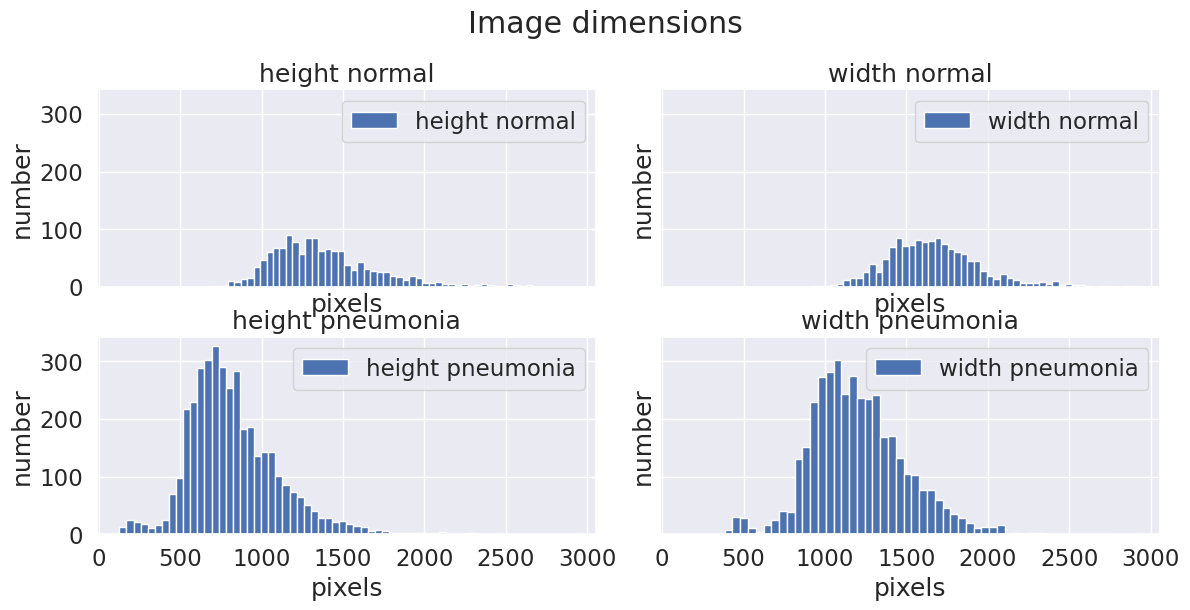

In [109]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(12, 6))
fig.suptitle('Image dimensions')
fig.tight_layout()

ax=ax.flatten()
def plothist(ax,label,dat):
    ax.hist(dat, label=label,bins=50)
    ax.legend(loc='upper right')
    ax.set(title=label, ylabel= 'number', xlabel='pixels')
    
plothist(ax[0],'height normal', np.asarray(n).T[0])
plothist(ax[1],'width normal', np.asarray(n).T[1])
plothist(ax[2],'height pneumonia', np.asarray(p).T[0])
plothist(ax[3],'width pneumonia', np.asarray(p).T[1])

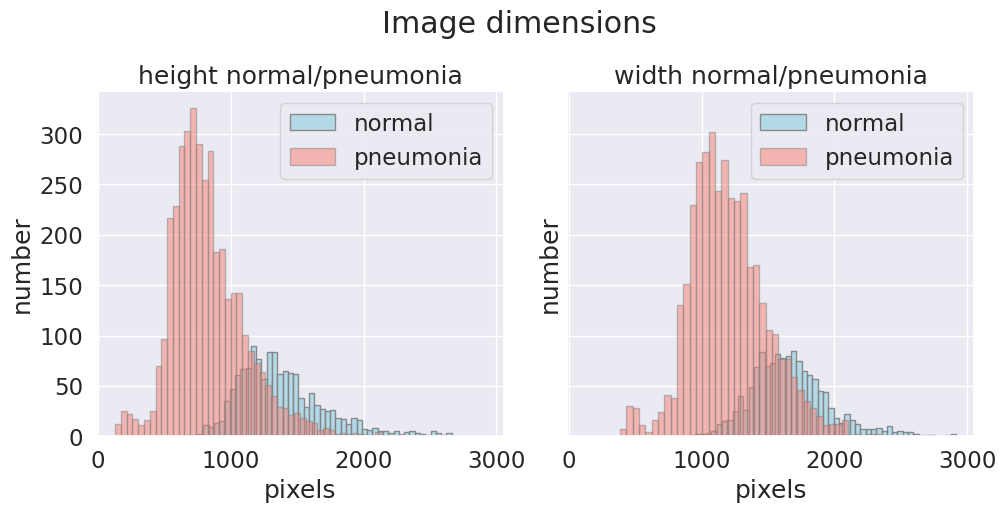

In [117]:
fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10, 5))
fig.suptitle('Image dimensions')
fig.tight_layout()

ax=ax.flatten()
def plothist(ax,label,n,p):
    ax.set(title=label, ylabel= 'number', xlabel='pixels')
    ax.hist(n, color='lightblue', label='normal', alpha=0.9, bins=50, edgecolor='gray')
    ax.hist(p, color='salmon', label='pneumonia', alpha=0.5, bins=50, edgecolor='gray')
    ax.margins(0.05)
    ax.set_ylim(bottom=0)
    ax.legend(loc='upper right')
    
plothist(ax[0],'height normal/pneumonia', np.asarray(n).T[0], np.asarray(p).T[0])
plothist(ax[1],'width normal/pneumonia', np.asarray(n).T[1], np.asarray(p).T[1])

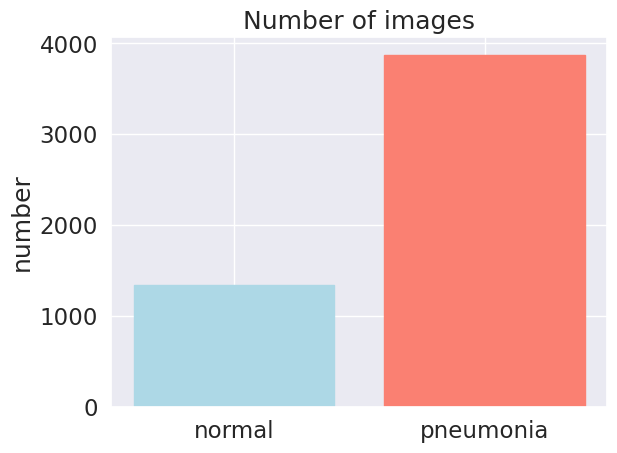

In [113]:
bars = plt.bar(['normal', 'pneumonia'], [len(n), len(p)])
plt.title('Number of images')
plt.ylabel('number')

bars[0].set_color('lightblue')
bars[1].set_color('salmon')

# Create spark session

In [3]:
    
model_path = '/home/ubuntu/mariajose/master/bigdata/bigdlModels/bigdl_inception-v1_imagenet_0.9.0.model'

spark_conf = SparkConf().set("spark.driver.memory", "5g") \
        .set("spark.driver.cores", 1)
        

In [4]:
ZooContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

sc = init_nncontext(spark_conf, cluster_mode="local")


Current pyspark location is : /home/ubuntu/miniconda3/envs/bigdata/lib/python3.10/site-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /home/ubuntu/miniconda3/envs/bigdata/lib/python3.10/site-packages/bigdl/share/friesian/lib/bigdl-friesian-spark_3.1.3-2.2.0-jar-with-dependencies.jar:/home/ubuntu/miniconda3/envs/bigdata/lib/python3.10/site-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_3.1.3-2.2.0-jar-with-dependencies.jar:/home/ubuntu/miniconda3/envs/bigdata/lib/python3.10/site-packages/bigdl/share/core/lib/all-2.2.0.jar:/home/ubuntu/miniconda3/envs/bigdata/lib/python3.10/site-packages/bigdl/share/orca/lib/bigdl-orca-spark_3.1.3-2.2.0-jar-with-dependencies.jar pyspark-shell 


2023-02-07 16:42:52 WARN  Utils:69 - Your hostname, ubuntu resolves to a loopback address: 127.0.1.1; using 192.168.1.46 instead (on interface wlo1)
2023-02-07 16:42:52 WARN  Utils:69 - Set SPARK_LOCAL_IP if you need to bind to another address


2023-02-07 16:42:53 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


2023-02-07 16:42:59,974 Thread-3 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2023-02-07 16:42:59,977 Thread-3 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2023-02-07 16:42:59,978 Thread-3 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2023-02-07 16:42:59,979 Thread-3 WARN The bufferSize is set to 4000 but bufferedIo is false: false
23-02-07 16:42:59 [Thread-3] INFO  Engine$:122 - Auto detect executor number and executor cores number
23-02-07 16:43:00 [Thread-3] INFO  Engine$:124 - Executor number is 1 and executor cores number is 2
23-02-07 16:43:00 [Thread-3] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 17
2023-02-07 16:43:00 WARN  SparkContext:69 - Using an existing SparkContext; some configuration may not take effect.
23-02-07 16:43:00 [Thread-3] INFO  Engine$:461 - Find existing spark context. Checking the spark conf...
cls.getname: com.intel.analytics.bigdl.dllib.utils.python.api.Sample
BigDLBasePickler registe


User settings:

   KMP_AFFINITY=granularity=fine,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   OMP_NUM_THREADS=1

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_HAND_THREAD=false
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_MONOTONIC_DYNAMIC_SCHEDULE=false
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_FORKJOIN_FRAMES=true
   KMP_FORKJOIN_FRAMES_MODE=3
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HIDDEN_HELPER_AFFINITY='noverbose,warnings,granularity=core,none'
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_

# Load inception model

In [5]:
def get_model(model_path, label_length=2, graphlayer="pool5/drop_7x7_s1"):
    full_model = Net.load_bigdl(model_path)
    # create a new model by remove layers after pool5/drop_7x7_s1
    model = full_model.new_graph([graphlayer])
    # freeze layers from input to pool4/3x3_s2 inclusive
    model.freeze_up_to(["pool4/3x3_s2"])

    inputNode = Input(name="input", shape=(3, 224, 224))
    inception = model.to_keras()(inputNode)
    flatten = Flatten()(inception)
    logits = Dense(label_length)(flatten)

    lrModel = Model(inputNode, logits)
    return lrModel


In [6]:
lrModel = get_model(model_path)

creating: createZooKerasInput
creating: createZooKerasFlatten
creating: createZooKerasDense
creating: createZooKerasModel


# Load images in spark dataframe (local)

In [7]:
trainSet = 'train'
testSet = 'test'
valSet = 'val'
dirPath = "/home/ubuntu/mariajose/master/bigdata/chest_xray/"


In [8]:
import glob
import cv2

nfnormal=[]
nfpneumonia=[]

nfnormal.append(len(glob.glob(os.path.join(dirPath, trainSet, 'NORMAL', '*.jp*'))))
nfpneumonia.append(len(glob.glob(os.path.join(dirPath, trainSet, 'PNEUMONIA', '*.jp*'))))
nfnormal.append(len(glob.glob(os.path.join(dirPath, testSet, 'NORMAL', '*.jp*'))))
nfpneumonia.append(len(glob.glob(os.path.join(dirPath, testSet, 'PNEUMONIA', '*.jp*'))))
nfnormal.append(len(glob.glob(os.path.join(dirPath, valSet, 'NORMAL', '*.jp*'))))
nfpneumonia.append(len(glob.glob(os.path.join(dirPath, valSet, 'PNEUMONIA', '*.jp*'))))
for i, iSet in enumerate([trainSet, testSet, valSet]):
    print(f'{iSet}set, {nfnormal[i]} normal xrays, {nfpneumonia[i]} pneumonia xrays, TOTAL: {nfnormal[i] + nfpneumonia[i]}')
  

trainset, 1341 normal xrays, 3875 pneumonia xrays, TOTAL: 5216
testset, 234 normal xrays, 390 pneumonia xrays, TOTAL: 624
valset, 8 normal xrays, 8 pneumonia xrays, TOTAL: 16


In [9]:
from pyspark.sql.functions import lit, col, udf, rand
from pyspark.sql.types import DoubleType, StringType

# Para las pruebas utilizamos el directorio val... tarda un mundo en ejecutarse!

getName = udf(lambda row: os.path.basename(row[0]), StringType())
#getLabel = udf(lambda name: 2.0 if name.find('bacteria') > 0 else (3.0 if name.find('virus') > 0 else 1.0), DoubleType())

def loadDF(path):
    imgNormalPath = f"{path}/NORMAL/"
    imgPneumoniaPath = f"{path}/PNEUMONIA/"
    normalDF = NNImageReader.readImages(imgNormalPath, sc, resizeH=300, resizeW=300,
                                          image_codec=1).withColumn("label", lit(1.0))
    pneumoniaDF = NNImageReader.readImages(imgPneumoniaPath, sc, resizeH=300, resizeW=300,
                                          image_codec=1).withColumn("label", lit(2.0))
    return normalDF.union(pneumoniaDF).withColumn('name', getName(col('image')))

trainDF = loadDF(dirPath + trainSet)
testDF  = loadDF(dirPath + testSet)
valDF   = loadDF(dirPath + valSet)



In [95]:
valDF.printSchema()


root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- data: binary (nullable = false)
 |-- label: double (nullable = false)
 |-- name: string (nullable = true)



In [10]:
validationDF = valDF

trainingDF = trainDF.orderBy(rand())

# Transfer learning

#### Log train summary

In [11]:
from bigdl.dllib.optim.optimizer import SGD, SequentialSchedule, Warmup, Poly,\
    Plateau, EveryEpoch, TrainSummary,\
    ValidationSummary, SeveralIteration, Step, L2Regularizer


train_summary = TrainSummary(log_dir="xray_save_summary", app_name=appname)
#val_summary = ValidationSummary(log_dir="xray_save_summary", app_name=appname)
train_summary.set_summary_trigger("LearningRate", SeveralIteration(50))
train_summary.set_summary_trigger("Loss", SeveralIteration(50))

creating: createTrainSummary
creating: createSeveralIteration
creating: createSeveralIteration


JavaObject id=o161

#### Adjust images

In [12]:
# compose a pipeline that includes feature transform, pretrained model and Logistic Regression
transformer = ChainedPreprocessing(
    [RowToImageFeature(), ImageResize(256, 256), ImageCenterCrop(224, 224),
     ImageChannelNormalize(123.0, 117.0, 104.0), ImageMatToTensor(), ImageFeatureToTensor()])


creating: createRowToImageFeature
creating: createImageResize
creating: createImageCenterCrop
creating: createImageChannelNormalize
creating: createImageMatToTensor
creating: createImageFeatureToTensor
creating: createChainedPreprocessing


#### Defining classifier and pipeline

In [13]:

%%time
batch_size=4
learning_rate=0.002 # 0.002
nb_epoch=2

classifier = NNClassifier(lrModel, CrossEntropyCriterion(), transformer) \
    .setLearningRate(learning_rate) \
    .setBatchSize(batch_size) \
    .setMaxEpoch(nb_epoch) \
    .setFeaturesCol("image") \
    .setCachingSample(False) \
    .setTrainSummary(train_summary) \


pipeline = Pipeline(stages=[classifier])


creating: createCrossEntropyCriterion
creating: createScalarToTensor
creating: createFeatureLabelPreprocessing
creating: createNNClassifier
CPU times: user 126 ms, sys: 32.5 ms, total: 159 ms
Wall time: 155 ms


#### Start training

In [14]:
%%time
xRayChestModel = pipeline.fit(trainingDF)

####################

23-02-07 16:51:50 [Thread-3] INFO  InternalDistriOptimizer$:1009 - Model[e6344ce8] isTorch is false
23-02-07 16:51:51 [Thread-3] INFO  DistriOptimizer$:830 - caching training rdd ...


23-02-07 16:59:16 [Thread-3] INFO  DistriOptimizer$:655 - Cache thread models...
23-02-07 16:59:16 [Executor task launch worker for task 0.0 in stage 6.0 (TID 221)] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 10519
23-02-07 16:59:16 [Executor task launch worker for task 0.0 in stage 6.0 (TID 221)] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 10519
23-02-07 16:59:16 [Executor task launch worker for task 0.0 in stage 6.0 (TID 221)] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 10519
23-02-07 16:59:16 [Executor task launch worker for task 0.0 in stage 6.0 (TID 221)] INFO  DistriOptimizer$:638 - model thread pool size is 1
2023-02-07 16:59:17 WARN  BlockManager:69 - Asked to remove block test_0weights0, which does not exist
2023-02-07 16:59:17 WARN  BlockManager:69 - Asked to remove block test_0gradients0, which does not exist
23-02-07 16:59:17 [Thread-3] INFO  DistriOptimizer$:657 - Cache thread models... done
23-02-07 16:59:17 [Thread-3] INFO  DistriOptimizer$:

23-02-07 16:59:34 [Thread-3] INFO  DistriOptimizer$:167 - Count dataset complete. Time elapsed: 17.184097288s
23-02-07 16:59:34 [Thread-3] INFO  DistriOptimizer$:175 - config  {
	learningRate: 0.002
	computeThresholdbatchSize: 100
	maxDropPercentage: 0.0
	warmupIterationNum: 200
	isLayerwiseScaled: true
	dropPercentage: 0.0
 }
23-02-07 16:59:34 [Thread-3] INFO  DistriOptimizer$:179 - Shuffle data
23-02-07 16:59:34 [Thread-3] INFO  DistriOptimizer$:182 - Shuffle data complete. Takes 0.044379051s


23-02-07 16:59:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4/5216][Iteration 1][Wall Clock 4.09338266s] Trained 4.0 records in 4.09338266 seconds. Throughput is 0.97718686 records/second. Loss is 1.4811375. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 16:59:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 8/5216][Iteration 2][Wall Clock 5.102465502s] Trained 4.0 records in 1.009082842 seconds. Throughput is 3.963996 records/second. Loss is 1.7014673. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 16:59:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 12/5216][Iteration 3][Wall Clock 6.131737015s] Trained 4.0 records in 1.029271513 seconds. Throughput is 3.8862438 records/second. Loss is 0.35641733. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 16:59:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 16/5216][Iteration 4][Wall Clock 7.14047698s] Trained 4.0 records in 1.008739965 seconds. Throughput is 3.965343 records/second. Loss is 0.1748492. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 16:59:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 20/5216][Iteration 5][Wall Clock 8.152311447s] Trained 4.0 records in 1.011834467 seconds. Throughput is 3.9532156 records/second. Loss is 0.536584. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 16:59:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 24/5216][Iteration 6][Wall Clock 9.11211077s] Trained 4.0 records in 0.959799323 seconds. Throughput is 4.1675377 records/second. Loss is 0.3462993. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 16:59:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 28/5216][Iteration 7][Wall Clock 10.053733277s] Trained 4.0 records in 0.941622507 seconds. Throughput is 4.247987 records/second. Loss is 0.15392116. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 16:59:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 32/5216][Iteration 8][Wall Clock 10.996573842s] Trained 4.0 records in 0.942840565 seconds. Throughput is 4.242499 records/second. Loss is 1.8396931. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 16:59:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 36/5216][Iteration 9][Wall Clock 11.992462661s] Trained 4.0 records in 0.995888819 seconds. Throughput is 4.0165124 records/second. Loss is 1.6858518. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 16:59:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 40/5216][Iteration 10][Wall Clock 12.935388222s] Trained 4.0 records in 0.942925561 seconds. Throughput is 4.2421165 records/second. Loss is 1.1118788. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 16:59:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 44/5216][Iteration 11][Wall Clock 13.84698093s] Trained 4.0 records in 0.911592708 seconds. Throughput is 4.3879247 records/second. Loss is 1.1808622. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 48/5216][Iteration 12][Wall Clock 26.008977015s] Trained 4.0 records in 12.161996085 seconds. Throughput is 0.3288934 records/second. Loss is 0.16435689. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 52/5216][Iteration 13][Wall Clock 26.932520808s] Trained 4.0 records in 0.923543793 seconds. Throughput is 4.3311424 records/second. Loss is 0.48422465. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 56/5216][Iteration 14][Wall Clock 27.902250697s] Trained 4.0 records in 0.969729889 seconds. Throughput is 4.12486 records/second. Loss is 0.4845778. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 60/5216][Iteration 15][Wall Clock 28.822574777s] Trained 4.0 records in 0.92032408 seconds. Throughput is 4.346295 records/second. Loss is 0.089270994. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


2023-02-07 16:42:59.995 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Auto detect executor number and executor cores number
2023-02-07 16:43:00.001 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Executor number is 1 and executor cores number is 2
2023-02-07 16:43:00.758 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.utils.ThreadPool$ - Set mkl threads to 1 on thread 17
2023-02-07 16:43:00.772 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Find existing spark context. Checking the spark conf...
2023-02-07 16:51:50.911 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.keras.models.InternalDistriOptimizer$ - Model[e6344ce8] isTorch is false
2023-02-07 16:51:51.077 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - caching training rdd ...
2023-02-07 16:59:16.503 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - Cache thread models...
2023-02-07 16:59:16.641 [Executor task launch worker f

23-02-07 17:00:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 68/5216][Iteration 17][Wall Clock 30.666973428s] Trained 4.0 records in 0.882377153 seconds. Throughput is 4.533209 records/second. Loss is 0.66387993. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 72/5216][Iteration 18][Wall Clock 31.580039253s] Trained 4.0 records in 0.913065825 seconds. Throughput is 4.380845 records/second. Loss is 0.9792793. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 76/5216][Iteration 19][Wall Clock 32.472421456s] Trained 4.0 records in 0.892382203 seconds. Throughput is 4.482384 records/second. Loss is 0.26706046. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 80/5216][Iteration 20][Wall Clock 33.502080019s] Trained 4.0 records in 1.029658563 seconds. Throughput is 3.884783 records/second. Loss is 0.07897278. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 84/5216][Iteration 21][Wall Clock 34.466043536s] Trained 4.0 records in 0.963963517 seconds. Throughput is 4.1495347 records/second. Loss is 0.9677289. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 88/5216][Iteration 22][Wall Clock 35.282398565s] Trained 4.0 records in 0.816355029 seconds. Throughput is 4.899829 records/second. Loss is 0.011938691. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 92/5216][Iteration 23][Wall Clock 36.138460483s] Trained 4.0 records in 0.856061918 seconds. Throughput is 4.6725593 records/second. Loss is 0.5937765. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 96/5216][Iteration 24][Wall Clock 37.135480964s] Trained 4.0 records in 0.997020481 seconds. Throughput is 4.011954 records/second. Loss is 0.29868972. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 100/5216][Iteration 25][Wall Clock 38.066828557s] Trained 4.0 records in 0.931347593 seconds. Throughput is 4.294852 records/second. Loss is 0.3899673. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 104/5216][Iteration 26][Wall Clock 38.875096278s] Trained 4.0 records in 0.808267721 seconds. Throughput is 4.9488554 records/second. Loss is 0.963107. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 108/5216][Iteration 27][Wall Clock 39.808043666s] Trained 4.0 records in 0.932947388 seconds. Throughput is 4.287487 records/second. Loss is 0.65979886. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 112/5216][Iteration 28][Wall Clock 40.712806055s] Trained 4.0 records in 0.904762389 seconds. Throughput is 4.42105 records/second. Loss is 0.40282306. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 116/5216][Iteration 29][Wall Clock 41.683050699s] Trained 4.0 records in 0.970244644 seconds. Throughput is 4.1226716 records/second. Loss is 0.9731655. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 120/5216][Iteration 30][Wall Clock 42.624320835s] Trained 4.0 records in 0.941270136 seconds. Throughput is 4.249577 records/second. Loss is 0.1622153. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 124/5216][Iteration 31][Wall Clock 43.526820856s] Trained 4.0 records in 0.902500021 seconds. Throughput is 4.4321327 records/second. Loss is 0.52028644. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 128/5216][Iteration 32][Wall Clock 44.454892781s] Trained 4.0 records in 0.928071925 seconds. Throughput is 4.310011 records/second. Loss is 0.008820921. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 132/5216][Iteration 33][Wall Clock 45.405840406s] Trained 4.0 records in 0.950947625 seconds. Throughput is 4.2063303 records/second. Loss is 0.16403398. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 136/5216][Iteration 34][Wall Clock 46.275435998s] Trained 4.0 records in 0.869595592 seconds. Throughput is 4.599839 records/second. Loss is 1.5523367. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 140/5216][Iteration 35][Wall Clock 47.113380818s] Trained 4.0 records in 0.83794482 seconds. Throughput is 4.773584 records/second. Loss is 0.6250625. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 144/5216][Iteration 36][Wall Clock 47.923755442s] Trained 4.0 records in 0.810374624 seconds. Throughput is 4.935989 records/second. Loss is 0.110169694. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 148/5216][Iteration 37][Wall Clock 48.789640204s] Trained 4.0 records in 0.865884762 seconds. Throughput is 4.619552 records/second. Loss is 0.35918322. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


ytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 64/5216][Iteration 16][Wall Clock 29.784596275s] Trained 4.0 records in 0.962021498 seconds. Throughput is 4.1579113 records/second. Loss is 0.27548838. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:00:05.245 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 68/5216][Iteration 17][Wall Clock 30.666973428s] Trained 4.0 records in 0.882377153 seconds. Throughput is 4.533209 records/second. Loss is 0.66387993. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:00:06.159 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 72/5216][Iteration 18][Wall Clock 31.580039253s] Trained 4.0 records in 0.913065825 seconds. Throughput is 4.380845 records/second. Loss is 0.9792793. Modele6344ce8's hyper parameters: Current learning r

23-02-07 17:00:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 156/5216][Iteration 39][Wall Clock 50.581094678s] Trained 4.0 records in 0.907426189 seconds. Throughput is 4.408072 records/second. Loss is 1.4577632. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 160/5216][Iteration 40][Wall Clock 51.473711823s] Trained 4.0 records in 0.892617145 seconds. Throughput is 4.4812045 records/second. Loss is 0.25580186. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 164/5216][Iteration 41][Wall Clock 52.331043457s] Trained 4.0 records in 0.857331634 seconds. Throughput is 4.665639 records/second. Loss is 0.032343388. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 168/5216][Iteration 42][Wall Clock 53.211186172s] Trained 4.0 records in 0.880142715 seconds. Throughput is 4.544718 records/second. Loss is 0.38611674. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 172/5216][Iteration 43][Wall Clock 54.105535841s] Trained 4.0 records in 0.894349669 seconds. Throughput is 4.4725237 records/second. Loss is 0.0048265383. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 176/5216][Iteration 44][Wall Clock 55.002434814s] Trained 4.0 records in 0.896898973 seconds. Throughput is 4.459811 records/second. Loss is 2.6273727E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 180/5216][Iteration 45][Wall Clock 55.825460591s] Trained 4.0 records in 0.823025777 seconds. Throughput is 4.860115 records/second. Loss is 0.021764323. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 184/5216][Iteration 46][Wall Clock 56.736196663s] Trained 4.0 records in 0.910736072 seconds. Throughput is 4.3920517 records/second. Loss is 0.2706111. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 188/5216][Iteration 47][Wall Clock 57.728225994s] Trained 4.0 records in 0.992029331 seconds. Throughput is 4.032139 records/second. Loss is 0.18625157. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 192/5216][Iteration 48][Wall Clock 58.680124354s] Trained 4.0 records in 0.95189836 seconds. Throughput is 4.2021294 records/second. Loss is 0.60940564. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 196/5216][Iteration 49][Wall Clock 59.69009208s] Trained 4.0 records in 1.009967726 seconds. Throughput is 3.9605227 records/second. Loss is 0.14736065. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 200/5216][Iteration 50][Wall Clock 60.586604836s] Trained 4.0 records in 0.896512756 seconds. Throughput is 4.4617324 records/second. Loss is 0.31535274. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 204/5216][Iteration 51][Wall Clock 61.517404336s] Trained 4.0 records in 0.9307995 seconds. Throughput is 4.297381 records/second. Loss is 0.17960313. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 208/5216][Iteration 52][Wall Clock 62.433324595s] Trained 4.0 records in 0.915920259 seconds. Throughput is 4.3671923 records/second. Loss is 0.24797599. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 212/5216][Iteration 53][Wall Clock 63.37733072s] Trained 4.0 records in 0.944006125 seconds. Throughput is 4.2372603 records/second. Loss is 0.5692937. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 216/5216][Iteration 54][Wall Clock 64.342610317s] Trained 4.0 records in 0.965279597 seconds. Throughput is 4.143877 records/second. Loss is 0.0027595162. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 220/5216][Iteration 55][Wall Clock 65.166837333s] Trained 4.0 records in 0.824227016 seconds. Throughput is 4.8530316 records/second. Loss is 0.012196064. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 224/5216][Iteration 56][Wall Clock 66.107507443s] Trained 4.0 records in 0.94067011 seconds. Throughput is 4.252288 records/second. Loss is 0.2781404. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 228/5216][Iteration 57][Wall Clock 66.979742796s] Trained 4.0 records in 0.872235353 seconds. Throughput is 4.5859184 records/second. Loss is 0.0048359036. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 232/5216][Iteration 58][Wall Clock 67.829735319s] Trained 4.0 records in 0.849992523 seconds. Throughput is 4.705924 records/second. Loss is 0.23282239. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 236/5216][Iteration 59][Wall Clock 68.795942544s] Trained 4.0 records in 0.966207225 seconds. Throughput is 4.139899 records/second. Loss is 0.42176682. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 240/5216][Iteration 60][Wall Clock 69.757880369s] Trained 4.0 records in 0.961937825 seconds. Throughput is 4.1582727 records/second. Loss is 0.7503989. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
nalytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 152/5216][Iteration 38][Wall Clock 49.673668489s] Trained 4.0 records in 0.884028285 seconds. Throughput is 4.524742 records/second. Loss is 0.071825236. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:00:25.180 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 156/5216][Iteration 39][Wall Clock 50.581094678s] Trained 4.0 records in 0.907426189 seconds. Throughput is 4.408072 records/second. Loss is 1.4577632. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is

23-02-07 17:00:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 244/5216][Iteration 61][Wall Clock 70.683585s] Trained 4.0 records in 0.925704631 seconds. Throughput is 4.3210325 records/second. Loss is 0.3955365. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 248/5216][Iteration 62][Wall Clock 71.571400812s] Trained 4.0 records in 0.887815812 seconds. Throughput is 4.505439 records/second. Loss is 0.032221507. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 252/5216][Iteration 63][Wall Clock 72.518846648s] Trained 4.0 records in 0.947445836 seconds. Throughput is 4.2218776 records/second. Loss is 0.0546404. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 256/5216][Iteration 64][Wall Clock 73.360617423s] Trained 4.0 records in 0.841770775 seconds. Throughput is 4.7518873 records/second. Loss is 0.2216992. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 260/5216][Iteration 65][Wall Clock 74.321756557s] Trained 4.0 records in 0.961139134 seconds. Throughput is 4.1617284 records/second. Loss is 0.03454885. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 264/5216][Iteration 66][Wall Clock 75.166311088s] Trained 4.0 records in 0.844554531 seconds. Throughput is 4.7362247 records/second. Loss is 1.1293517. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 268/5216][Iteration 67][Wall Clock 76.050769418s] Trained 4.0 records in 0.88445833 seconds. Throughput is 4.522542 records/second. Loss is 0.1424742. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 272/5216][Iteration 68][Wall Clock 76.884848415s] Trained 4.0 records in 0.834078997 seconds. Throughput is 4.795709 records/second. Loss is 0.2957378. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 276/5216][Iteration 69][Wall Clock 77.821602332s] Trained 4.0 records in 0.936753917 seconds. Throughput is 4.270065 records/second. Loss is 0.0027861297. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 280/5216][Iteration 70][Wall Clock 78.623450176s] Trained 4.0 records in 0.801847844 seconds. Throughput is 4.9884777 records/second. Loss is 0.080762446. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 284/5216][Iteration 71][Wall Clock 79.571683315s] Trained 4.0 records in 0.948233139 seconds. Throughput is 4.218372 records/second. Loss is 0.0105710775. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 288/5216][Iteration 72][Wall Clock 80.420925704s] Trained 4.0 records in 0.849242389 seconds. Throughput is 4.7100806 records/second. Loss is 0.012280792. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 292/5216][Iteration 73][Wall Clock 81.367697517s] Trained 4.0 records in 0.946771813 seconds. Throughput is 4.224883 records/second. Loss is 0.72160137. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 296/5216][Iteration 74][Wall Clock 82.216116966s] Trained 4.0 records in 0.848419449 seconds. Throughput is 4.714649 records/second. Loss is 0.6694006. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 300/5216][Iteration 75][Wall Clock 83.070374353s] Trained 4.0 records in 0.854257387 seconds. Throughput is 4.6824293 records/second. Loss is 0.789889. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 304/5216][Iteration 76][Wall Clock 84.117397204s] Trained 4.0 records in 1.047022851 seconds. Throughput is 3.8203561 records/second. Loss is 0.103191346. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:00:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 308/5216][Iteration 77][Wall Clock 85.019141075s] Trained 4.0 records in 0.901743871 seconds. Throughput is 4.435849 records/second. Loss is 0.0055605173. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 312/5216][Iteration 78][Wall Clock 85.858275889s] Trained 4.0 records in 0.839134814 seconds. Throughput is 4.7668147 records/second. Loss is 0.08848569. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 316/5216][Iteration 79][Wall Clock 86.681862155s] Trained 4.0 records in 0.823586266 seconds. Throughput is 4.856807 records/second. Loss is 0.3113615. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 320/5216][Iteration 80][Wall Clock 87.532478054s] Trained 4.0 records in 0.850615899 seconds. Throughput is 4.702475 records/second. Loss is 0.17979455. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 324/5216][Iteration 81][Wall Clock 88.450538046s] Trained 4.0 records in 0.918059992 seconds. Throughput is 4.3570137 records/second. Loss is 0.030433208. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 328/5216][Iteration 82][Wall Clock 89.300077448s] Trained 4.0 records in 0.849539402 seconds. Throughput is 4.7084336 records/second. Loss is 0.003178943. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
hread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 240/5216][Iteration 60][Wall Clock 69.757880369s] Trained 4.0 records in 0.961937825 seconds. Throughput is 4.1582727 records/second. Loss is 0.7503989. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:00:45.308 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 244/5216][Iteration 61][Wall Clock 70.683585s] Trained 4.0 records in 0.925704631 seconds. Throughput is 4.3210325 records/second. Loss is 0.3955365. Modele6344ce8's hyper parameters: Current learning rate is 0.

23-02-07 17:01:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 332/5216][Iteration 83][Wall Clock 90.151244268s] Trained 4.0 records in 0.85116682 seconds. Throughput is 4.699431 records/second. Loss is 0.6292265. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 336/5216][Iteration 84][Wall Clock 90.961465367s] Trained 4.0 records in 0.810221099 seconds. Throughput is 4.936924 records/second. Loss is 5.4347515E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 340/5216][Iteration 85][Wall Clock 91.792516945s] Trained 4.0 records in 0.831051578 seconds. Throughput is 4.813179 records/second. Loss is 0.013028782. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 344/5216][Iteration 86][Wall Clock 92.624570009s] Trained 4.0 records in 0.832053064 seconds. Throughput is 4.807386 records/second. Loss is 0.5360713. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 348/5216][Iteration 87][Wall Clock 93.444567959s] Trained 4.0 records in 0.81999795 seconds. Throughput is 4.878061 records/second. Loss is 0.080262296. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 352/5216][Iteration 88][Wall Clock 94.25359944s] Trained 4.0 records in 0.809031481 seconds. Throughput is 4.9441833 records/second. Loss is 0.34872493. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 356/5216][Iteration 89][Wall Clock 95.204115591s] Trained 4.0 records in 0.950516151 seconds. Throughput is 4.20824 records/second. Loss is 0.007601768. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 360/5216][Iteration 90][Wall Clock 96.031938582s] Trained 4.0 records in 0.827822991 seconds. Throughput is 4.8319507 records/second. Loss is 0.01909186. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 364/5216][Iteration 91][Wall Clock 96.809597063s] Trained 4.0 records in 0.777658481 seconds. Throughput is 5.1436462 records/second. Loss is 0.123208016. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 368/5216][Iteration 92][Wall Clock 97.630722635s] Trained 4.0 records in 0.821125572 seconds. Throughput is 4.871362 records/second. Loss is 0.2331098. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 372/5216][Iteration 93][Wall Clock 98.510297169s] Trained 4.0 records in 0.879574534 seconds. Throughput is 4.547653 records/second. Loss is 0.06077365. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 376/5216][Iteration 94][Wall Clock 99.393038731s] Trained 4.0 records in 0.882741562 seconds. Throughput is 4.5313377 records/second. Loss is 0.02484034. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 380/5216][Iteration 95][Wall Clock 100.209720862s] Trained 4.0 records in 0.816682131 seconds. Throughput is 4.8978662 records/second. Loss is 0.59766144. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 384/5216][Iteration 96][Wall Clock 101.081283288s] Trained 4.0 records in 0.871562426 seconds. Throughput is 4.589459 records/second. Loss is 0.793376. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 388/5216][Iteration 97][Wall Clock 101.940655208s] Trained 4.0 records in 0.85937192 seconds. Throughput is 4.6545625 records/second. Loss is 0.40974736. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 392/5216][Iteration 98][Wall Clock 102.763240282s] Trained 4.0 records in 0.822585074 seconds. Throughput is 4.862719 records/second. Loss is 0.024811894. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 396/5216][Iteration 99][Wall Clock 103.592997741s] Trained 4.0 records in 0.829757459 seconds. Throughput is 4.820686 records/second. Loss is 0.0022614896. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 400/5216][Iteration 100][Wall Clock 104.445679957s] Trained 4.0 records in 0.852682216 seconds. Throughput is 4.691079 records/second. Loss is 0.082378045. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 404/5216][Iteration 101][Wall Clock 105.277405772s] Trained 4.0 records in 0.831725815 seconds. Throughput is 4.809277 records/second. Loss is 0.08100729. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 408/5216][Iteration 102][Wall Clock 106.154897462s] Trained 4.0 records in 0.87749169 seconds. Throughput is 4.558448 records/second. Loss is 0.11440659. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 412/5216][Iteration 103][Wall Clock 107.000585405s] Trained 4.0 records in 0.845687943 seconds. Throughput is 4.729877 records/second. Loss is 0.100401446. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
-02-07 17:01:03.946 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 328/5216][Iteration 82][Wall Clock 89.300077448s] Trained 4.0 records in 0.849539402 seconds. Throughput is 4.7084336 records/second. Loss is 0.003178943. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:01:04.798 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 332/5216][Iteration 83][Wall Clock 90.151244268s] Trained 4.0 records in 0.85116682 seconds. Throughput is 4.699431 records/second. Loss is 0.6292265. Modele6344ce8's hyper parameters: C

23-02-07 17:01:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 416/5216][Iteration 104][Wall Clock 107.83541036s] Trained 4.0 records in 0.834824955 seconds. Throughput is 4.7914233 records/second. Loss is 0.022053361. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 420/5216][Iteration 105][Wall Clock 108.688366835s] Trained 4.0 records in 0.852956475 seconds. Throughput is 4.689571 records/second. Loss is 0.029323936. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 424/5216][Iteration 106][Wall Clock 109.51879142s] Trained 4.0 records in 0.830424585 seconds. Throughput is 4.816813 records/second. Loss is 0.01026091. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 428/5216][Iteration 107][Wall Clock 110.331449097s] Trained 4.0 records in 0.812657677 seconds. Throughput is 4.922122 records/second. Loss is 0.028418947. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 432/5216][Iteration 108][Wall Clock 111.148333462s] Trained 4.0 records in 0.816884365 seconds. Throughput is 4.896654 records/second. Loss is 1.3754323. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 436/5216][Iteration 109][Wall Clock 111.924424549s] Trained 4.0 records in 0.776091087 seconds. Throughput is 5.154034 records/second. Loss is 0.007183776. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 440/5216][Iteration 110][Wall Clock 112.781604134s] Trained 4.0 records in 0.857179585 seconds. Throughput is 4.6664667 records/second. Loss is 0.2560145. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 444/5216][Iteration 111][Wall Clock 113.735808201s] Trained 4.0 records in 0.954204067 seconds. Throughput is 4.1919756 records/second. Loss is 0.3749405. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 448/5216][Iteration 112][Wall Clock 114.557908097s] Trained 4.0 records in 0.822099896 seconds. Throughput is 4.8655887 records/second. Loss is 0.15372798. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 452/5216][Iteration 113][Wall Clock 115.34918811s] Trained 4.0 records in 0.791280013 seconds. Throughput is 5.0551004 records/second. Loss is 0.016982406. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 456/5216][Iteration 114][Wall Clock 116.201896969s] Trained 4.0 records in 0.852708859 seconds. Throughput is 4.6909328 records/second. Loss is 0.02897884. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 460/5216][Iteration 115][Wall Clock 117.098303774s] Trained 4.0 records in 0.896406805 seconds. Throughput is 4.46226 records/second. Loss is 0.7087919. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 464/5216][Iteration 116][Wall Clock 117.935565528s] Trained 4.0 records in 0.837261754 seconds. Throughput is 4.7774787 records/second. Loss is 1.0244207. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 468/5216][Iteration 117][Wall Clock 118.820336236s] Trained 4.0 records in 0.884770708 seconds. Throughput is 4.5209455 records/second. Loss is 0.0076432526. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 472/5216][Iteration 118][Wall Clock 119.766487562s] Trained 4.0 records in 0.946151326 seconds. Throughput is 4.2276535 records/second. Loss is 0.16024885. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 476/5216][Iteration 119][Wall Clock 120.704859126s] Trained 4.0 records in 0.938371564 seconds. Throughput is 4.262704 records/second. Loss is 0.16065982. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 480/5216][Iteration 120][Wall Clock 121.560889251s] Trained 4.0 records in 0.856030125 seconds. Throughput is 4.672733 records/second. Loss is 0.16961242. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 484/5216][Iteration 121][Wall Clock 122.499434619s] Trained 4.0 records in 0.938545368 seconds. Throughput is 4.2619143 records/second. Loss is 0.5684978. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 488/5216][Iteration 122][Wall Clock 123.307026184s] Trained 4.0 records in 0.807591565 seconds. Throughput is 4.9529986 records/second. Loss is 0.1105393. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 492/5216][Iteration 123][Wall Clock 124.153080492s] Trained 4.0 records in 0.846054308 seconds. Throughput is 4.727829 records/second. Loss is 0.1726609. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 496/5216][Iteration 124][Wall Clock 125.038146992s] Trained 4.0 records in 0.8850665 seconds. Throughput is 4.5194345 records/second. Loss is 0.83955127. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 500/5216][Iteration 125][Wall Clock 125.891941526s] Trained 4.0 records in 0.853794534 seconds. Throughput is 4.684968 records/second. Loss is 0.028733585. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
g is 1.7976931348623157E308.  
2023-02-07 17:01:22.508 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 416/5216][Iteration 104][Wall Clock 107.83541036s] Trained 4.0 records in 0.834824955 seconds. Throughput is 4.7914233 records/second. Loss is 0.022053361. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:01:23.362 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 420/5216][Iteration 105][Wall Clock 108.688366835s] Trained 4.0 records in 0.852956475 seconds. Throughput is 4.689571 records/second. Loss is 0.02932

23-02-07 17:01:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 504/5216][Iteration 126][Wall Clock 126.717834397s] Trained 4.0 records in 0.825892871 seconds. Throughput is 4.843243 records/second. Loss is 0.013833791. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 508/5216][Iteration 127][Wall Clock 127.660856317s] Trained 4.0 records in 0.94302192 seconds. Throughput is 4.241683 records/second. Loss is 0.021564119. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 512/5216][Iteration 128][Wall Clock 128.545253857s] Trained 4.0 records in 0.88439754 seconds. Throughput is 4.522853 records/second. Loss is 0.30029362. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 516/5216][Iteration 129][Wall Clock 129.404133887s] Trained 4.0 records in 0.85888003 seconds. Throughput is 4.657228 records/second. Loss is 0.039184935. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 520/5216][Iteration 130][Wall Clock 130.221885849s] Trained 4.0 records in 0.817751962 seconds. Throughput is 4.891459 records/second. Loss is 0.12507632. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 524/5216][Iteration 131][Wall Clock 131.088267263s] Trained 4.0 records in 0.866381414 seconds. Throughput is 4.6169043 records/second. Loss is 0.70431876. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 528/5216][Iteration 132][Wall Clock 131.912308517s] Trained 4.0 records in 0.824041254 seconds. Throughput is 4.854126 records/second. Loss is 0.0987936. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 532/5216][Iteration 133][Wall Clock 132.858551997s] Trained 4.0 records in 0.94624348 seconds. Throughput is 4.227242 records/second. Loss is 0.10430524. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 536/5216][Iteration 134][Wall Clock 133.718412804s] Trained 4.0 records in 0.859860807 seconds. Throughput is 4.651916 records/second. Loss is 0.18346602. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 540/5216][Iteration 135][Wall Clock 134.551115635s] Trained 4.0 records in 0.832702831 seconds. Throughput is 4.8036346 records/second. Loss is 0.021608248. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 544/5216][Iteration 136][Wall Clock 135.420893637s] Trained 4.0 records in 0.869778002 seconds. Throughput is 4.5988746 records/second. Loss is 0.3173062. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 548/5216][Iteration 137][Wall Clock 136.314239353s] Trained 4.0 records in 0.893345716 seconds. Throughput is 4.47755 records/second. Loss is 0.12614444. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 552/5216][Iteration 138][Wall Clock 137.212812301s] Trained 4.0 records in 0.898572948 seconds. Throughput is 4.451503 records/second. Loss is 0.038293134. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 556/5216][Iteration 139][Wall Clock 138.057021843s] Trained 4.0 records in 0.844209542 seconds. Throughput is 4.73816 records/second. Loss is 0.1533299. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 560/5216][Iteration 140][Wall Clock 138.996137943s] Trained 4.0 records in 0.9391161 seconds. Throughput is 4.259324 records/second. Loss is 0.13985392. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 564/5216][Iteration 141][Wall Clock 139.928553589s] Trained 4.0 records in 0.932415646 seconds. Throughput is 4.2899323 records/second. Loss is 0.0932494. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 568/5216][Iteration 142][Wall Clock 140.79180276s] Trained 4.0 records in 0.863249171 seconds. Throughput is 4.6336565 records/second. Loss is 0.07022372. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 572/5216][Iteration 143][Wall Clock 141.63098022s] Trained 4.0 records in 0.83917746 seconds. Throughput is 4.766572 records/second. Loss is 0.0065531284. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 576/5216][Iteration 144][Wall Clock 142.560723075s] Trained 4.0 records in 0.929742855 seconds. Throughput is 4.3022647 records/second. Loss is 0.0041078627. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 580/5216][Iteration 145][Wall Clock 143.466949325s] Trained 4.0 records in 0.90622625 seconds. Throughput is 4.4139085 records/second. Loss is 0.056493416. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 584/5216][Iteration 146][Wall Clock 144.372401107s] Trained 4.0 records in 0.905451782 seconds. Throughput is 4.417684 records/second. Loss is 0.109798804. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:01:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 588/5216][Iteration 147][Wall Clock 145.217772935s] Trained 4.0 records in 0.845371828 seconds. Throughput is 4.7316456 records/second. Loss is 0.0013786554. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
per parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:01:41.409 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 504/5216][Iteration 126][Wall Clock 126.717834397s] Trained 4.0 records in 0.825892871 seconds. Throughput is 4.843243 records/second. Loss is 0.013833791. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:01:42.353 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 508/5216][Iteration 127][Wall Clock 127.660856317s] Trained 4.0 records in 0.9430219

23-02-07 17:02:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 592/5216][Iteration 148][Wall Clock 146.089634327s] Trained 4.0 records in 0.871861392 seconds. Throughput is 4.5878854 records/second. Loss is 0.055729985. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 596/5216][Iteration 149][Wall Clock 146.930000411s] Trained 4.0 records in 0.840366084 seconds. Throughput is 4.7598305 records/second. Loss is 0.042697202. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 600/5216][Iteration 150][Wall Clock 147.803890884s] Trained 4.0 records in 0.873890473 seconds. Throughput is 4.577233 records/second. Loss is 0.6405667. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 604/5216][Iteration 151][Wall Clock 148.645376078s] Trained 4.0 records in 0.841485194 seconds. Throughput is 4.7535 records/second. Loss is 0.40127736. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 608/5216][Iteration 152][Wall Clock 149.485156663s] Trained 4.0 records in 0.839780585 seconds. Throughput is 4.7631493 records/second. Loss is 0.023149863. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 612/5216][Iteration 153][Wall Clock 150.334865571s] Trained 4.0 records in 0.849708908 seconds. Throughput is 4.7074943 records/second. Loss is 0.70287293. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 616/5216][Iteration 154][Wall Clock 151.073924251s] Trained 4.0 records in 0.73905868 seconds. Throughput is 5.41229 records/second. Loss is 0.024192423. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 620/5216][Iteration 155][Wall Clock 151.838663732s] Trained 4.0 records in 0.764739481 seconds. Throughput is 5.23054 records/second. Loss is 0.013789743. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 624/5216][Iteration 156][Wall Clock 152.701912372s] Trained 4.0 records in 0.86324864 seconds. Throughput is 4.6336594 records/second. Loss is 0.05070427. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 628/5216][Iteration 157][Wall Clock 153.530569829s] Trained 4.0 records in 0.828657457 seconds. Throughput is 4.827085 records/second. Loss is 0.25025985. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 632/5216][Iteration 158][Wall Clock 154.428976471s] Trained 4.0 records in 0.898406642 seconds. Throughput is 4.452327 records/second. Loss is 0.16898069. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 636/5216][Iteration 159][Wall Clock 155.260468713s] Trained 4.0 records in 0.831492242 seconds. Throughput is 4.810628 records/second. Loss is 0.014098398. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 640/5216][Iteration 160][Wall Clock 156.09949892s] Trained 4.0 records in 0.839030207 seconds. Throughput is 4.767409 records/second. Loss is 0.28734475. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 644/5216][Iteration 161][Wall Clock 156.937691221s] Trained 4.0 records in 0.838192301 seconds. Throughput is 4.772175 records/second. Loss is 0.034670144. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 648/5216][Iteration 162][Wall Clock 157.760812587s] Trained 4.0 records in 0.823121366 seconds. Throughput is 4.8595505 records/second. Loss is 0.011179313. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 652/5216][Iteration 163][Wall Clock 158.542785775s] Trained 4.0 records in 0.781973188 seconds. Throughput is 5.115265 records/second. Loss is 0.017708108. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 656/5216][Iteration 164][Wall Clock 159.416075635s] Trained 4.0 records in 0.87328986 seconds. Throughput is 4.5803804 records/second. Loss is 0.0047539026. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 660/5216][Iteration 165][Wall Clock 160.27719128s] Trained 4.0 records in 0.861115645 seconds. Throughput is 4.645137 records/second. Loss is 0.0027567819. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 664/5216][Iteration 166][Wall Clock 161.195808663s] Trained 4.0 records in 0.918617383 seconds. Throughput is 4.35437 records/second. Loss is 0.15328497. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 668/5216][Iteration 167][Wall Clock 162.045830255s] Trained 4.0 records in 0.850021592 seconds. Throughput is 4.705763 records/second. Loss is 8.1405044E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 672/5216][Iteration 168][Wall Clock 162.991173482s] Trained 4.0 records in 0.945343227 seconds. Throughput is 4.2312675 records/second. Loss is 0.046906896. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 676/5216][Iteration 169][Wall Clock 163.820257244s] Trained 4.0 records in 0.829083762 seconds. Throughput is 4.824603 records/second. Loss is 0.5147609. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
316456 records/second. Loss is 0.0013786554. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:02:00.798 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 592/5216][Iteration 148][Wall Clock 146.089634327s] Trained 4.0 records in 0.871861392 seconds. Throughput is 4.5878854 records/second. Loss is 0.055729985. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:02:01.639 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 596/5216][Iteration 149]

23-02-07 17:02:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 680/5216][Iteration 170][Wall Clock 164.67124907s] Trained 4.0 records in 0.850991826 seconds. Throughput is 4.7003975 records/second. Loss is 0.34671956. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 684/5216][Iteration 171][Wall Clock 165.62132955s] Trained 4.0 records in 0.95008048 seconds. Throughput is 4.21017 records/second. Loss is 0.5293577. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 688/5216][Iteration 172][Wall Clock 166.416070882s] Trained 4.0 records in 0.794741332 seconds. Throughput is 5.033084 records/second. Loss is 0.08551305. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 692/5216][Iteration 173][Wall Clock 167.26235052s] Trained 4.0 records in 0.846279638 seconds. Throughput is 4.72657 records/second. Loss is 0.006300032. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 696/5216][Iteration 174][Wall Clock 168.144341579s] Trained 4.0 records in 0.881991059 seconds. Throughput is 4.5351934 records/second. Loss is 1.2336686. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 700/5216][Iteration 175][Wall Clock 168.995026867s] Trained 4.0 records in 0.850685288 seconds. Throughput is 4.702091 records/second. Loss is 0.33084577. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 704/5216][Iteration 176][Wall Clock 169.858063841s] Trained 4.0 records in 0.863036974 seconds. Throughput is 4.6347957 records/second. Loss is 0.8400552. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 708/5216][Iteration 177][Wall Clock 170.706625812s] Trained 4.0 records in 0.848561971 seconds. Throughput is 4.713857 records/second. Loss is 0.121160366. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 712/5216][Iteration 178][Wall Clock 171.580201317s] Trained 4.0 records in 0.873575505 seconds. Throughput is 4.578883 records/second. Loss is 0.2364919. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 716/5216][Iteration 179][Wall Clock 172.401367219s] Trained 4.0 records in 0.821165902 seconds. Throughput is 4.871123 records/second. Loss is 0.2161776. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 720/5216][Iteration 180][Wall Clock 173.2117268s] Trained 4.0 records in 0.810359581 seconds. Throughput is 4.9360805 records/second. Loss is 0.05228673. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 724/5216][Iteration 181][Wall Clock 174.037608681s] Trained 4.0 records in 0.825881881 seconds. Throughput is 4.8433075 records/second. Loss is 0.0077738166. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 728/5216][Iteration 182][Wall Clock 174.997501126s] Trained 4.0 records in 0.959892445 seconds. Throughput is 4.1671333 records/second. Loss is 0.41229385. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 732/5216][Iteration 183][Wall Clock 175.851850466s] Trained 4.0 records in 0.85434934 seconds. Throughput is 4.681926 records/second. Loss is 0.183581. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 736/5216][Iteration 184][Wall Clock 176.676084789s] Trained 4.0 records in 0.824234323 seconds. Throughput is 4.852989 records/second. Loss is 0.30004042. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 740/5216][Iteration 185][Wall Clock 177.612345907s] Trained 4.0 records in 0.936261118 seconds. Throughput is 4.2723126 records/second. Loss is 0.5923455. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 744/5216][Iteration 186][Wall Clock 178.52845836s] Trained 4.0 records in 0.916112453 seconds. Throughput is 4.3662763 records/second. Loss is 0.19942059. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 748/5216][Iteration 187][Wall Clock 179.373234931s] Trained 4.0 records in 0.844776571 seconds. Throughput is 4.7349796 records/second. Loss is 0.020491838. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 752/5216][Iteration 188][Wall Clock 180.22989795s] Trained 4.0 records in 0.856663019 seconds. Throughput is 4.6692805 records/second. Loss is 0.16647771. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 756/5216][Iteration 189][Wall Clock 181.070033772s] Trained 4.0 records in 0.840135822 seconds. Throughput is 4.761135 records/second. Loss is 0.05192092. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 760/5216][Iteration 190][Wall Clock 182.007374867s] Trained 4.0 records in 0.937341095 seconds. Throughput is 4.26739 records/second. Loss is 0.022735164. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 764/5216][Iteration 191][Wall Clock 182.827049556s] Trained 4.0 records in 0.819674689 seconds. Throughput is 4.879985 records/second. Loss is 0.25076663. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
.820257244s] Trained 4.0 records in 0.829083762 seconds. Throughput is 4.824603 records/second. Loss is 0.5147609. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:02:19.396 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 680/5216][Iteration 170][Wall Clock 164.67124907s] Trained 4.0 records in 0.850991826 seconds. Throughput is 4.7003975 records/second. Loss is 0.34671956. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:02:20.348 [Thread-3] INFO  com.intel.analytics.b

23-02-07 17:02:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 768/5216][Iteration 192][Wall Clock 183.710413436s] Trained 4.0 records in 0.88336388 seconds. Throughput is 4.5281453 records/second. Loss is 0.08144516. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 772/5216][Iteration 193][Wall Clock 184.621317891s] Trained 4.0 records in 0.910904455 seconds. Throughput is 4.3912396 records/second. Loss is 0.054091252. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 776/5216][Iteration 194][Wall Clock 185.414460936s] Trained 4.0 records in 0.793143045 seconds. Throughput is 5.0432267 records/second. Loss is 0.22473927. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 780/5216][Iteration 195][Wall Clock 186.240548073s] Trained 4.0 records in 0.826087137 seconds. Throughput is 4.8421044 records/second. Loss is 0.014006399. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 784/5216][Iteration 196][Wall Clock 187.109197358s] Trained 4.0 records in 0.868649285 seconds. Throughput is 4.6048503 records/second. Loss is 0.64731336. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 788/5216][Iteration 197][Wall Clock 187.885315533s] Trained 4.0 records in 0.776118175 seconds. Throughput is 5.1538544 records/second. Loss is 0.27110076. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 792/5216][Iteration 198][Wall Clock 188.739867613s] Trained 4.0 records in 0.85455208 seconds. Throughput is 4.6808147 records/second. Loss is 0.027078908. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 796/5216][Iteration 199][Wall Clock 189.575801236s] Trained 4.0 records in 0.835933623 seconds. Throughput is 4.785069 records/second. Loss is 0.03583805. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 800/5216][Iteration 200][Wall Clock 190.464033359s] Trained 4.0 records in 0.888232123 seconds. Throughput is 4.5033274 records/second. Loss is 0.03387192. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 804/5216][Iteration 201][Wall Clock 191.312075913s] Trained 4.0 records in 0.848042554 seconds. Throughput is 4.7167444 records/second. Loss is 0.044493973. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 808/5216][Iteration 202][Wall Clock 192.124659865s] Trained 4.0 records in 0.812583952 seconds. Throughput is 4.9225683 records/second. Loss is 0.0043359995. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 812/5216][Iteration 203][Wall Clock 192.9520792s] Trained 4.0 records in 0.827419335 seconds. Throughput is 4.834308 records/second. Loss is 0.24553487. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 816/5216][Iteration 204][Wall Clock 193.749548597s] Trained 4.0 records in 0.797469397 seconds. Throughput is 5.0158668 records/second. Loss is 0.123538315. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 820/5216][Iteration 205][Wall Clock 194.620131345s] Trained 4.0 records in 0.870582748 seconds. Throughput is 4.5946236 records/second. Loss is 0.12526277. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 824/5216][Iteration 206][Wall Clock 195.511115352s] Trained 4.0 records in 0.890984007 seconds. Throughput is 4.4894185 records/second. Loss is 0.15057048. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 828/5216][Iteration 207][Wall Clock 196.5334485s] Trained 4.0 records in 1.022333148 seconds. Throughput is 3.9126189 records/second. Loss is 0.07810609. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 832/5216][Iteration 208][Wall Clock 197.484281592s] Trained 4.0 records in 0.950833092 seconds. Throughput is 4.206837 records/second. Loss is 0.058723316. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 836/5216][Iteration 209][Wall Clock 198.405904041s] Trained 4.0 records in 0.921622449 seconds. Throughput is 4.340172 records/second. Loss is 0.2636414. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 840/5216][Iteration 210][Wall Clock 199.241399918s] Trained 4.0 records in 0.835495877 seconds. Throughput is 4.7875757 records/second. Loss is 0.042699188. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 844/5216][Iteration 211][Wall Clock 200.138183171s] Trained 4.0 records in 0.896783253 seconds. Throughput is 4.4603868 records/second. Loss is 0.1330894. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 848/5216][Iteration 212][Wall Clock 201.011247452s] Trained 4.0 records in 0.873064281 seconds. Throughput is 4.581564 records/second. Loss is 0.39902908. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 852/5216][Iteration 213][Wall Clock 201.852150042s] Trained 4.0 records in 0.84090259 seconds. Throughput is 4.7567935 records/second. Loss is 0.20918569. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
r$ - [Epoch 1 764/5216][Iteration 191][Wall Clock 182.827049556s] Trained 4.0 records in 0.819674689 seconds. Throughput is 4.879985 records/second. Loss is 0.25076663. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:02:38.452 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 768/5216][Iteration 192][Wall Clock 183.710413436s] Trained 4.0 records in 0.88336388 seconds. Throughput is 4.5281453 records/second. Loss is 0.08144516. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-

23-02-07 17:02:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 856/5216][Iteration 214][Wall Clock 202.686659707s] Trained 4.0 records in 0.834509665 seconds. Throughput is 4.793234 records/second. Loss is 0.012956172. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 860/5216][Iteration 215][Wall Clock 203.506409623s] Trained 4.0 records in 0.819749916 seconds. Throughput is 4.879537 records/second. Loss is 0.012198269. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 864/5216][Iteration 216][Wall Clock 204.324216592s] Trained 4.0 records in 0.817806969 seconds. Throughput is 4.89113 records/second. Loss is 0.028517015. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:02:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 868/5216][Iteration 217][Wall Clock 205.235615889s] Trained 4.0 records in 0.911399297 seconds. Throughput is 4.3888555 records/second. Loss is 0.026341723. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 872/5216][Iteration 218][Wall Clock 206.052878303s] Trained 4.0 records in 0.817262414 seconds. Throughput is 4.8943887 records/second. Loss is 0.06954782. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 876/5216][Iteration 219][Wall Clock 206.904707052s] Trained 4.0 records in 0.851828749 seconds. Throughput is 4.6957793 records/second. Loss is 0.0012341142. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 880/5216][Iteration 220][Wall Clock 207.79939368s] Trained 4.0 records in 0.894686628 seconds. Throughput is 4.470839 records/second. Loss is 0.026567996. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 884/5216][Iteration 221][Wall Clock 208.726422559s] Trained 4.0 records in 0.927028879 seconds. Throughput is 4.3148603 records/second. Loss is 0.22580391. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 888/5216][Iteration 222][Wall Clock 209.568188678s] Trained 4.0 records in 0.841766119 seconds. Throughput is 4.7519135 records/second. Loss is 0.3948009. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 892/5216][Iteration 223][Wall Clock 210.432224718s] Trained 4.0 records in 0.86403604 seconds. Throughput is 4.6294365 records/second. Loss is 0.027275875. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 896/5216][Iteration 224][Wall Clock 211.318218065s] Trained 4.0 records in 0.885993347 seconds. Throughput is 4.5147066 records/second. Loss is 0.033508226. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 900/5216][Iteration 225][Wall Clock 212.252621126s] Trained 4.0 records in 0.934403061 seconds. Throughput is 4.280808 records/second. Loss is 0.41359195. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 904/5216][Iteration 226][Wall Clock 213.118002919s] Trained 4.0 records in 0.865381793 seconds. Throughput is 4.622237 records/second. Loss is 0.21154706. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 908/5216][Iteration 227][Wall Clock 214.022252675s] Trained 4.0 records in 0.904249756 seconds. Throughput is 4.423557 records/second. Loss is 0.33994877. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 912/5216][Iteration 228][Wall Clock 214.839029992s] Trained 4.0 records in 0.816777317 seconds. Throughput is 4.897296 records/second. Loss is 0.08321522. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 916/5216][Iteration 229][Wall Clock 215.726929728s] Trained 4.0 records in 0.887899736 seconds. Throughput is 4.505013 records/second. Loss is 0.028979445. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 920/5216][Iteration 230][Wall Clock 216.616329772s] Trained 4.0 records in 0.889400044 seconds. Throughput is 4.4974136 records/second. Loss is 1.9210472. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 924/5216][Iteration 231][Wall Clock 217.564639343s] Trained 4.0 records in 0.948309571 seconds. Throughput is 4.218032 records/second. Loss is 0.121529356. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 928/5216][Iteration 232][Wall Clock 218.452479381s] Trained 4.0 records in 0.887840038 seconds. Throughput is 4.5053163 records/second. Loss is 0.0047892034. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 932/5216][Iteration 233][Wall Clock 219.284685104s] Trained 4.0 records in 0.832205723 seconds. Throughput is 4.806504 records/second. Loss is 0.0065882504. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 936/5216][Iteration 234][Wall Clock 220.217365997s] Trained 4.0 records in 0.932680893 seconds. Throughput is 4.288712 records/second. Loss is 0.006143868. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
6.608 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 852/5216][Iteration 213][Wall Clock 201.852150042s] Trained 4.0 records in 0.84090259 seconds. Throughput is 4.7567935 records/second. Loss is 0.20918569. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:02:57.444 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 856/5216][Iteration 214][Wall Clock 202.686659707s] Trained 4.0 records in 0.834509665 seconds. Throughput is 4.793234 records/second. Loss is 0.012956172. Modele6344ce8's hyper parameters: Current le

23-02-07 17:03:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 940/5216][Iteration 235][Wall Clock 221.138044157s] Trained 4.0 records in 0.92067816 seconds. Throughput is 4.3446236 records/second. Loss is 0.16952862. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 944/5216][Iteration 236][Wall Clock 221.991742431s] Trained 4.0 records in 0.853698274 seconds. Throughput is 4.6854963 records/second. Loss is 0.02435603. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 948/5216][Iteration 237][Wall Clock 222.831206929s] Trained 4.0 records in 0.839464498 seconds. Throughput is 4.7649426 records/second. Loss is 0.48990938. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 952/5216][Iteration 238][Wall Clock 223.761109312s] Trained 4.0 records in 0.929902383 seconds. Throughput is 4.301527 records/second. Loss is 0.10061012. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 956/5216][Iteration 239][Wall Clock 224.580760352s] Trained 4.0 records in 0.81965104 seconds. Throughput is 4.8801255 records/second. Loss is 0.096249744. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 960/5216][Iteration 240][Wall Clock 225.639027189s] Trained 4.0 records in 1.058266837 seconds. Throughput is 3.779765 records/second. Loss is 0.35657004. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 964/5216][Iteration 241][Wall Clock 226.497911414s] Trained 4.0 records in 0.858884225 seconds. Throughput is 4.657205 records/second. Loss is 0.23046069. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 968/5216][Iteration 242][Wall Clock 227.437761466s] Trained 4.0 records in 0.939850052 seconds. Throughput is 4.255998 records/second. Loss is 0.20299748. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 972/5216][Iteration 243][Wall Clock 228.240339041s] Trained 4.0 records in 0.802577575 seconds. Throughput is 4.983942 records/second. Loss is 0.09940494. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 976/5216][Iteration 244][Wall Clock 229.07106957s] Trained 4.0 records in 0.830730529 seconds. Throughput is 4.815039 records/second. Loss is 0.01893419. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 980/5216][Iteration 245][Wall Clock 229.830587855s] Trained 4.0 records in 0.759518285 seconds. Throughput is 5.266496 records/second. Loss is 0.22527295. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 984/5216][Iteration 246][Wall Clock 230.763657457s] Trained 4.0 records in 0.933069602 seconds. Throughput is 4.286926 records/second. Loss is 0.23979996. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 988/5216][Iteration 247][Wall Clock 231.590834052s] Trained 4.0 records in 0.827176595 seconds. Throughput is 4.8357267 records/second. Loss is 0.033814877. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 992/5216][Iteration 248][Wall Clock 232.38001385s] Trained 4.0 records in 0.789179798 seconds. Throughput is 5.0685534 records/second. Loss is 0.008399442. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 996/5216][Iteration 249][Wall Clock 233.202701475s] Trained 4.0 records in 0.822687625 seconds. Throughput is 4.8621125 records/second. Loss is 1.200148. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1000/5216][Iteration 250][Wall Clock 234.184962946s] Trained 4.0 records in 0.982261471 seconds. Throughput is 4.0722356 records/second. Loss is 0.026094496. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1004/5216][Iteration 251][Wall Clock 235.047380942s] Trained 4.0 records in 0.862417996 seconds. Throughput is 4.638122 records/second. Loss is 0.46536103. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1008/5216][Iteration 252][Wall Clock 235.912096087s] Trained 4.0 records in 0.864715145 seconds. Throughput is 4.6258006 records/second. Loss is 0.09049937. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1012/5216][Iteration 253][Wall Clock 236.837988615s] Trained 4.0 records in 0.925892528 seconds. Throughput is 4.3201556 records/second. Loss is 0.03399402. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1016/5216][Iteration 254][Wall Clock 237.824440957s] Trained 4.0 records in 0.986452342 seconds. Throughput is 4.054935 records/second. Loss is 0.022673607. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1020/5216][Iteration 255][Wall Clock 238.743831454s] Trained 4.0 records in 0.919390497 seconds. Throughput is 4.3507085 records/second. Loss is 0.20376535. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1024/5216][Iteration 256][Wall Clock 239.619138009s] Trained 4.0 records in 0.875306555 seconds. Throughput is 4.5698276 records/second. Loss is 0.45104283. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
te is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:03:15.910 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 940/5216][Iteration 235][Wall Clock 221.138044157s] Trained 4.0 records in 0.92067816 seconds. Throughput is 4.3446236 records/second. Loss is 0.16952862. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:03:16.765 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 944/5216][Iteration 236][Wall Clock 221.991742431s] Trained 4.0 records in 0.853698274 seconds. Throughput is 4.6854963 r

23-02-07 17:03:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1028/5216][Iteration 257][Wall Clock 240.507700678s] Trained 4.0 records in 0.888562669 seconds. Throughput is 4.5016522 records/second. Loss is 0.014940143. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1032/5216][Iteration 258][Wall Clock 241.483689883s] Trained 4.0 records in 0.975989205 seconds. Throughput is 4.098406 records/second. Loss is 0.0041067004. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1036/5216][Iteration 259][Wall Clock 242.356818032s] Trained 4.0 records in 0.873128149 seconds. Throughput is 4.5812287 records/second. Loss is 0.006224245. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1040/5216][Iteration 260][Wall Clock 243.302355426s] Trained 4.0 records in 0.945537394 seconds. Throughput is 4.2303987 records/second. Loss is 0.4359322. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1044/5216][Iteration 261][Wall Clock 244.164906683s] Trained 4.0 records in 0.862551257 seconds. Throughput is 4.6374054 records/second. Loss is 0.038416397. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1048/5216][Iteration 262][Wall Clock 245.071758168s] Trained 4.0 records in 0.906851485 seconds. Throughput is 4.410866 records/second. Loss is 0.020092478. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1052/5216][Iteration 263][Wall Clock 245.978916274s] Trained 4.0 records in 0.907158106 seconds. Throughput is 4.4093747 records/second. Loss is 0.0034422427. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1056/5216][Iteration 264][Wall Clock 246.886356709s] Trained 4.0 records in 0.907440435 seconds. Throughput is 4.408003 records/second. Loss is 0.024760604. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1060/5216][Iteration 265][Wall Clock 247.853414477s] Trained 4.0 records in 0.967057768 seconds. Throughput is 4.1362576 records/second. Loss is 0.09532657. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1064/5216][Iteration 266][Wall Clock 248.828578356s] Trained 4.0 records in 0.975163879 seconds. Throughput is 4.101875 records/second. Loss is 0.19822544. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1068/5216][Iteration 267][Wall Clock 249.680303711s] Trained 4.0 records in 0.851725355 seconds. Throughput is 4.6963496 records/second. Loss is 0.07299051. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1072/5216][Iteration 268][Wall Clock 250.584080384s] Trained 4.0 records in 0.903776673 seconds. Throughput is 4.4258723 records/second. Loss is 0.006019056. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1076/5216][Iteration 269][Wall Clock 251.458485847s] Trained 4.0 records in 0.874405463 seconds. Throughput is 4.574537 records/second. Loss is 0.056991078. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1080/5216][Iteration 270][Wall Clock 252.412900705s] Trained 4.0 records in 0.954414858 seconds. Throughput is 4.1910496 records/second. Loss is 0.014298543. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1084/5216][Iteration 271][Wall Clock 253.278523906s] Trained 4.0 records in 0.865623201 seconds. Throughput is 4.6209483 records/second. Loss is 0.1036092. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1088/5216][Iteration 272][Wall Clock 254.262636768s] Trained 4.0 records in 0.984112862 seconds. Throughput is 4.0645742 records/second. Loss is 0.02065354. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1092/5216][Iteration 273][Wall Clock 255.138683193s] Trained 4.0 records in 0.876046425 seconds. Throughput is 4.565968 records/second. Loss is 0.005421579. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1096/5216][Iteration 274][Wall Clock 255.970546873s] Trained 4.0 records in 0.83186368 seconds. Throughput is 4.8084803 records/second. Loss is 0.6396245. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1100/5216][Iteration 275][Wall Clock 256.924503559s] Trained 4.0 records in 0.953956686 seconds. Throughput is 4.193063 records/second. Loss is 0.039604522. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1104/5216][Iteration 276][Wall Clock 257.740263854s] Trained 4.0 records in 0.815760295 seconds. Throughput is 4.903401 records/second. Loss is 0.011428207. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1108/5216][Iteration 277][Wall Clock 258.618756696s] Trained 4.0 records in 0.878492842 seconds. Throughput is 4.5532527 records/second. Loss is 0.25416586. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1112/5216][Iteration 278][Wall Clock 259.422209607s] Trained 4.0 records in 0.803452911 seconds. Throughput is 4.9785123 records/second. Loss is 0.026911438. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
d. Loss is 0.45104283. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:03:35.299 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 1028/5216][Iteration 257][Wall Clock 240.507700678s] Trained 4.0 records in 0.888562669 seconds. Throughput is 4.5016522 records/second. Loss is 0.014940143. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:03:36.276 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 1032/5216][Iteration 258][Wall Clock 241.

23-02-07 17:03:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1116/5216][Iteration 279][Wall Clock 260.299142791s] Trained 4.0 records in 0.876933184 seconds. Throughput is 4.5613513 records/second. Loss is 0.24891895. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1120/5216][Iteration 280][Wall Clock 261.13972815s] Trained 4.0 records in 0.840585359 seconds. Throughput is 4.758589 records/second. Loss is 0.35226044. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1124/5216][Iteration 281][Wall Clock 261.971368716s] Trained 4.0 records in 0.831640566 seconds. Throughput is 4.80977 records/second. Loss is 0.029856771. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1128/5216][Iteration 282][Wall Clock 262.811631741s] Trained 4.0 records in 0.840263025 seconds. Throughput is 4.760414 records/second. Loss is 0.77824324. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1132/5216][Iteration 283][Wall Clock 263.661233977s] Trained 4.0 records in 0.849602236 seconds. Throughput is 4.7080855 records/second. Loss is 0.017166324. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:03:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1136/5216][Iteration 284][Wall Clock 264.557581997s] Trained 4.0 records in 0.89634802 seconds. Throughput is 4.4625525 records/second. Loss is 0.7028341. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1140/5216][Iteration 285][Wall Clock 265.447995804s] Trained 4.0 records in 0.890413807 seconds. Throughput is 4.4922934 records/second. Loss is 0.07494826. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1144/5216][Iteration 286][Wall Clock 266.256820071s] Trained 4.0 records in 0.808824267 seconds. Throughput is 4.9454503 records/second. Loss is 0.05490683. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1148/5216][Iteration 287][Wall Clock 267.24057042s] Trained 4.0 records in 0.983750349 seconds. Throughput is 4.0660725 records/second. Loss is 0.008082509. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1152/5216][Iteration 288][Wall Clock 268.060115183s] Trained 4.0 records in 0.819544763 seconds. Throughput is 4.8807583 records/second. Loss is 0.0985468. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1156/5216][Iteration 289][Wall Clock 268.889910357s] Trained 4.0 records in 0.829795174 seconds. Throughput is 4.8204665 records/second. Loss is 0.2872749. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1160/5216][Iteration 290][Wall Clock 269.787068946s] Trained 4.0 records in 0.897158589 seconds. Throughput is 4.458521 records/second. Loss is 6.020069E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1164/5216][Iteration 291][Wall Clock 270.678457658s] Trained 4.0 records in 0.891388712 seconds. Throughput is 4.48738 records/second. Loss is 0.0018434227. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1168/5216][Iteration 292][Wall Clock 271.557569598s] Trained 4.0 records in 0.87911194 seconds. Throughput is 4.5500464 records/second. Loss is 0.2289947. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1172/5216][Iteration 293][Wall Clock 272.345317349s] Trained 4.0 records in 0.787747751 seconds. Throughput is 5.077768 records/second. Loss is 0.3303935. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1176/5216][Iteration 294][Wall Clock 273.265491769s] Trained 4.0 records in 0.92017442 seconds. Throughput is 4.347002 records/second. Loss is 0.064179085. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1180/5216][Iteration 295][Wall Clock 274.199092018s] Trained 4.0 records in 0.933600249 seconds. Throughput is 4.284489 records/second. Loss is 0.0060274154. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1184/5216][Iteration 296][Wall Clock 275.03502827s] Trained 4.0 records in 0.835936252 seconds. Throughput is 4.7850537 records/second. Loss is 0.03865529. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1188/5216][Iteration 297][Wall Clock 275.875766302s] Trained 4.0 records in 0.840738032 seconds. Throughput is 4.7577243 records/second. Loss is 3.5452843E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1192/5216][Iteration 298][Wall Clock 276.697630881s] Trained 4.0 records in 0.821864579 seconds. Throughput is 4.8669815 records/second. Loss is 0.033853322. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1196/5216][Iteration 299][Wall Clock 277.563121948s] Trained 4.0 records in 0.865491067 seconds. Throughput is 4.6216536 records/second. Loss is 0.24953812. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1200/5216][Iteration 300][Wall Clock 278.432365793s] Trained 4.0 records in 0.869243845 seconds. Throughput is 4.601701 records/second. Loss is 9.913445E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
l Clock 259.422209607s] Trained 4.0 records in 0.803452911 seconds. Throughput is 4.9785123 records/second. Loss is 0.026911438. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:03:55.106 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 1116/5216][Iteration 279][Wall Clock 260.299142791s] Trained 4.0 records in 0.876933184 seconds. Throughput is 4.5613513 records/second. Loss is 0.24891895. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:03:55.947 [Thread-3] INFO  com

23-02-07 17:04:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1204/5216][Iteration 301][Wall Clock 279.283730444s] Trained 4.0 records in 0.851364651 seconds. Throughput is 4.698339 records/second. Loss is 0.062051162. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1208/5216][Iteration 302][Wall Clock 280.110167559s] Trained 4.0 records in 0.826437115 seconds. Throughput is 4.8400536 records/second. Loss is 0.0716313. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1212/5216][Iteration 303][Wall Clock 281.031076492s] Trained 4.0 records in 0.920908933 seconds. Throughput is 4.343535 records/second. Loss is 0.06611431. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1216/5216][Iteration 304][Wall Clock 281.968957003s] Trained 4.0 records in 0.937880511 seconds. Throughput is 4.2649355 records/second. Loss is 0.00490728. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1220/5216][Iteration 305][Wall Clock 282.859546214s] Trained 4.0 records in 0.890589211 seconds. Throughput is 4.4914083 records/second. Loss is 0.009041414. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1224/5216][Iteration 306][Wall Clock 283.699588024s] Trained 4.0 records in 0.84004181 seconds. Throughput is 4.7616677 records/second. Loss is 0.010410607. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1228/5216][Iteration 307][Wall Clock 284.543444094s] Trained 4.0 records in 0.84385607 seconds. Throughput is 4.7401447 records/second. Loss is 0.1446676. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1232/5216][Iteration 308][Wall Clock 285.330308982s] Trained 4.0 records in 0.786864888 seconds. Throughput is 5.083465 records/second. Loss is 0.7181489. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1236/5216][Iteration 309][Wall Clock 286.157722086s] Trained 4.0 records in 0.827413104 seconds. Throughput is 4.834345 records/second. Loss is 0.2927972. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1240/5216][Iteration 310][Wall Clock 287.044238148s] Trained 4.0 records in 0.886516062 seconds. Throughput is 4.512045 records/second. Loss is 0.0010511279. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1244/5216][Iteration 311][Wall Clock 287.952475423s] Trained 4.0 records in 0.908237275 seconds. Throughput is 4.404135 records/second. Loss is 0.34049803. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1248/5216][Iteration 312][Wall Clock 288.83652831s] Trained 4.0 records in 0.884052887 seconds. Throughput is 4.5246162 records/second. Loss is 0.40265235. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1252/5216][Iteration 313][Wall Clock 289.681255403s] Trained 4.0 records in 0.844727093 seconds. Throughput is 4.735257 records/second. Loss is 0.23178. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1256/5216][Iteration 314][Wall Clock 290.534522258s] Trained 4.0 records in 0.853266855 seconds. Throughput is 4.6878653 records/second. Loss is 0.0036862195. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1260/5216][Iteration 315][Wall Clock 291.349977829s] Trained 4.0 records in 0.815455571 seconds. Throughput is 4.9052334 records/second. Loss is 0.001191318. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1264/5216][Iteration 316][Wall Clock 292.376565047s] Trained 4.0 records in 1.026587218 seconds. Throughput is 3.8964052 records/second. Loss is 0.0026220381. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1268/5216][Iteration 317][Wall Clock 293.248655048s] Trained 4.0 records in 0.872090001 seconds. Throughput is 4.586683 records/second. Loss is 0.014000297. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1272/5216][Iteration 318][Wall Clock 294.105690799s] Trained 4.0 records in 0.857035751 seconds. Throughput is 4.6672497 records/second. Loss is 0.13071421. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1276/5216][Iteration 319][Wall Clock 294.972366945s] Trained 4.0 records in 0.866676146 seconds. Throughput is 4.615334 records/second. Loss is 0.3289169. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1280/5216][Iteration 320][Wall Clock 295.818247726s] Trained 4.0 records in 0.845880781 seconds. Throughput is 4.728799 records/second. Loss is 0.008098811. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1284/5216][Iteration 321][Wall Clock 296.816160053s] Trained 4.0 records in 0.997912327 seconds. Throughput is 4.008368 records/second. Loss is 0.0015265644. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
om.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 1200/5216][Iteration 300][Wall Clock 278.432365793s] Trained 4.0 records in 0.869243845 seconds. Throughput is 4.601701 records/second. Loss is 9.913445E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:04:14.103 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 1204/5216][Iteration 301][Wall Clock 279.283730444s] Trained 4.0 records in 0.851364651 seconds. Throughput is 4.698339 records/second. Loss is 0.062051162. Modele6344ce8's hyper parameters: Current learning rate is 0.00

23-02-07 17:04:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1288/5216][Iteration 322][Wall Clock 297.619025773s] Trained 4.0 records in 0.80286572 seconds. Throughput is 4.982153 records/second. Loss is 0.08552803. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1292/5216][Iteration 323][Wall Clock 298.429383408s] Trained 4.0 records in 0.810357635 seconds. Throughput is 4.9360924 records/second. Loss is 4.2057037E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1296/5216][Iteration 324][Wall Clock 299.35145093s] Trained 4.0 records in 0.922067522 seconds. Throughput is 4.338077 records/second. Loss is 0.116510265. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1300/5216][Iteration 325][Wall Clock 300.203937447s] Trained 4.0 records in 0.852486517 seconds. Throughput is 4.6921563 records/second. Loss is 0.07060346. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1304/5216][Iteration 326][Wall Clock 301.086521085s] Trained 4.0 records in 0.882583638 seconds. Throughput is 4.5321484 records/second. Loss is 0.1932984. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1308/5216][Iteration 327][Wall Clock 301.979805581s] Trained 4.0 records in 0.893284496 seconds. Throughput is 4.4778566 records/second. Loss is 0.19430286. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1312/5216][Iteration 328][Wall Clock 302.952056764s] Trained 4.0 records in 0.972251183 seconds. Throughput is 4.1141634 records/second. Loss is 0.8857308. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1316/5216][Iteration 329][Wall Clock 303.775749301s] Trained 4.0 records in 0.823692537 seconds. Throughput is 4.8561807 records/second. Loss is 0.04645542. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1320/5216][Iteration 330][Wall Clock 304.579892604s] Trained 4.0 records in 0.804143303 seconds. Throughput is 4.974238 records/second. Loss is 0.0044743717. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1324/5216][Iteration 331][Wall Clock 305.398456837s] Trained 4.0 records in 0.818564233 seconds. Throughput is 4.886605 records/second. Loss is 0.14077783. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1328/5216][Iteration 332][Wall Clock 306.286056853s] Trained 4.0 records in 0.887600016 seconds. Throughput is 4.5065346 records/second. Loss is 0.1633895. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1332/5216][Iteration 333][Wall Clock 307.130291082s] Trained 4.0 records in 0.844234229 seconds. Throughput is 4.7380214 records/second. Loss is 0.102560595. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1336/5216][Iteration 334][Wall Clock 307.941431261s] Trained 4.0 records in 0.811140179 seconds. Throughput is 4.93133 records/second. Loss is 0.0013035536. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1340/5216][Iteration 335][Wall Clock 308.82069533s] Trained 4.0 records in 0.879264069 seconds. Throughput is 4.549259 records/second. Loss is 0.011861309. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1344/5216][Iteration 336][Wall Clock 309.680544596s] Trained 4.0 records in 0.859849266 seconds. Throughput is 4.651978 records/second. Loss is 0.3729497. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1348/5216][Iteration 337][Wall Clock 310.620406612s] Trained 4.0 records in 0.939862016 seconds. Throughput is 4.255944 records/second. Loss is 2.2100186. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1352/5216][Iteration 338][Wall Clock 311.400913405s] Trained 4.0 records in 0.780506793 seconds. Throughput is 5.1248755 records/second. Loss is 0.122475676. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1356/5216][Iteration 339][Wall Clock 312.223763909s] Trained 4.0 records in 0.822850504 seconds. Throughput is 4.8611503 records/second. Loss is 0.07343389. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1360/5216][Iteration 340][Wall Clock 313.064865613s] Trained 4.0 records in 0.841101704 seconds. Throughput is 4.755667 records/second. Loss is 0.010014683. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1364/5216][Iteration 341][Wall Clock 313.939361794s] Trained 4.0 records in 0.874496181 seconds. Throughput is 4.5740623 records/second. Loss is 0.010588676. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1368/5216][Iteration 342][Wall Clock 314.873752127s] Trained 4.0 records in 0.934390333 seconds. Throughput is 4.280866 records/second. Loss is 0.14413625. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1372/5216][Iteration 343][Wall Clock 315.681496638s] Trained 4.0 records in 0.807744511 seconds. Throughput is 4.9520607 records/second. Loss is 0.071541905. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:04:32.451 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 1288/5216][Iteration 322][Wall Clock 297.619025773s] Trained 4.0 records in 0.80286572 seconds. Throughput is 4.982153 records/second. Loss is 0.08552803. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:04:33.263 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 1292/5216][Iteration 323][Wall Clock 298.429383408s] Trained 4.0 records in 0.810357635 seconds. Throughput is 4.9360924 records

23-02-07 17:04:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1376/5216][Iteration 344][Wall Clock 316.523995744s] Trained 4.0 records in 0.842499106 seconds. Throughput is 4.74778 records/second. Loss is 0.07893664. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1380/5216][Iteration 345][Wall Clock 318.020093033s] Trained 4.0 records in 1.496097289 seconds. Throughput is 2.6736228 records/second. Loss is 0.40393707. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1384/5216][Iteration 346][Wall Clock 319.194284819s] Trained 4.0 records in 1.174191786 seconds. Throughput is 3.4065983 records/second. Loss is 0.09990162. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1388/5216][Iteration 347][Wall Clock 320.04473576s] Trained 4.0 records in 0.850450941 seconds. Throughput is 4.7033873 records/second. Loss is 0.08427299. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1392/5216][Iteration 348][Wall Clock 321.001991021s] Trained 4.0 records in 0.957255261 seconds. Throughput is 4.1786137 records/second. Loss is 0.42893848. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1396/5216][Iteration 349][Wall Clock 321.860699795s] Trained 4.0 records in 0.858708774 seconds. Throughput is 4.6581564 records/second. Loss is 0.12526178. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1400/5216][Iteration 350][Wall Clock 322.691679084s] Trained 4.0 records in 0.830979289 seconds. Throughput is 4.8135977 records/second. Loss is 0.24674982. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1404/5216][Iteration 351][Wall Clock 323.503985673s] Trained 4.0 records in 0.812306589 seconds. Throughput is 4.924249 records/second. Loss is 0.10778306. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:04:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1408/5216][Iteration 352][Wall Clock 324.305069969s] Trained 4.0 records in 0.801084296 seconds. Throughput is 4.9932323 records/second. Loss is 0.072121665. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1412/5216][Iteration 353][Wall Clock 325.16757004s] Trained 4.0 records in 0.862500071 seconds. Throughput is 4.637681 records/second. Loss is 0.12754825. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1416/5216][Iteration 354][Wall Clock 326.018305614s] Trained 4.0 records in 0.850735574 seconds. Throughput is 4.7018137 records/second. Loss is 0.3485238. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1420/5216][Iteration 355][Wall Clock 326.868836798s] Trained 4.0 records in 0.850531184 seconds. Throughput is 4.7029433 records/second. Loss is 0.003849566. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1424/5216][Iteration 356][Wall Clock 327.691460222s] Trained 4.0 records in 0.822623424 seconds. Throughput is 4.862492 records/second. Loss is 0.06813615. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1428/5216][Iteration 357][Wall Clock 328.57694809s] Trained 4.0 records in 0.885487868 seconds. Throughput is 4.517284 records/second. Loss is 0.035451457. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1432/5216][Iteration 358][Wall Clock 329.430747148s] Trained 4.0 records in 0.853799058 seconds. Throughput is 4.684943 records/second. Loss is 0.077367455. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1436/5216][Iteration 359][Wall Clock 330.241429519s] Trained 4.0 records in 0.810682371 seconds. Throughput is 4.934115 records/second. Loss is 0.027343303. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1440/5216][Iteration 360][Wall Clock 331.076916498s] Trained 4.0 records in 0.835486979 seconds. Throughput is 4.7876267 records/second. Loss is 0.0010043979. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1444/5216][Iteration 361][Wall Clock 331.986724592s] Trained 4.0 records in 0.909808094 seconds. Throughput is 4.3965316 records/second. Loss is 0.04520505. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1448/5216][Iteration 362][Wall Clock 332.777958085s] Trained 4.0 records in 0.791233493 seconds. Throughput is 5.055398 records/second. Loss is 0.13525052. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1452/5216][Iteration 363][Wall Clock 333.686756513s] Trained 4.0 records in 0.908798428 seconds. Throughput is 4.401416 records/second. Loss is 0.09620485. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1456/5216][Iteration 364][Wall Clock 334.642919483s] Trained 4.0 records in 0.95616297 seconds. Throughput is 4.1833873 records/second. Loss is 0.08678621. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1460/5216][Iteration 365][Wall Clock 335.485375724s] Trained 4.0 records in 0.842456241 seconds. Throughput is 4.748021 records/second. Loss is 0.02311942. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
cords/second. Loss is 0.071541905. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:04:51.369 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 1376/5216][Iteration 344][Wall Clock 316.523995744s] Trained 4.0 records in 0.842499106 seconds. Throughput is 4.74778 records/second. Loss is 0.07893664. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:04:52.866 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 1380/5216][Iteration 345][Wall Clo

23-02-07 17:05:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1464/5216][Iteration 366][Wall Clock 336.282232989s] Trained 4.0 records in 0.796857265 seconds. Throughput is 5.0197196 records/second. Loss is 0.06567207. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1468/5216][Iteration 367][Wall Clock 337.11520543s] Trained 4.0 records in 0.832972441 seconds. Throughput is 4.8020797 records/second. Loss is 0.38890442. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1472/5216][Iteration 368][Wall Clock 338.047332541s] Trained 4.0 records in 0.932127111 seconds. Throughput is 4.2912602 records/second. Loss is 0.1468209. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1476/5216][Iteration 369][Wall Clock 338.863130301s] Trained 4.0 records in 0.81579776 seconds. Throughput is 4.9031763 records/second. Loss is 0.0507202. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1480/5216][Iteration 370][Wall Clock 339.716099035s] Trained 4.0 records in 0.852968734 seconds. Throughput is 4.6895037 records/second. Loss is 0.12857924. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1484/5216][Iteration 371][Wall Clock 340.646927536s] Trained 4.0 records in 0.930828501 seconds. Throughput is 4.297247 records/second. Loss is 0.005755782. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1488/5216][Iteration 372][Wall Clock 341.478372283s] Trained 4.0 records in 0.831444747 seconds. Throughput is 4.810903 records/second. Loss is 0.0012540221. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1492/5216][Iteration 373][Wall Clock 342.395160483s] Trained 4.0 records in 0.9167882 seconds. Throughput is 4.3630576 records/second. Loss is 0.0023228228. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1496/5216][Iteration 374][Wall Clock 343.309249201s] Trained 4.0 records in 0.914088718 seconds. Throughput is 4.3759427 records/second. Loss is 0.35372177. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1500/5216][Iteration 375][Wall Clock 344.188561595s] Trained 4.0 records in 0.879312394 seconds. Throughput is 4.549009 records/second. Loss is 0.011275649. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1504/5216][Iteration 376][Wall Clock 345.013239606s] Trained 4.0 records in 0.824678011 seconds. Throughput is 4.850378 records/second. Loss is 0.34567726. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1508/5216][Iteration 377][Wall Clock 345.842805198s] Trained 4.0 records in 0.829565592 seconds. Throughput is 4.8218007 records/second. Loss is 0.0058966577. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1512/5216][Iteration 378][Wall Clock 346.674351039s] Trained 4.0 records in 0.831545841 seconds. Throughput is 4.810318 records/second. Loss is 0.008412063. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1516/5216][Iteration 379][Wall Clock 347.531899922s] Trained 4.0 records in 0.857548883 seconds. Throughput is 4.664457 records/second. Loss is 0.057874143. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1520/5216][Iteration 380][Wall Clock 348.463316192s] Trained 4.0 records in 0.93141627 seconds. Throughput is 4.294535 records/second. Loss is 0.0065668374. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1524/5216][Iteration 381][Wall Clock 349.415841807s] Trained 4.0 records in 0.952525615 seconds. Throughput is 4.1993623 records/second. Loss is 0.012657791. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1528/5216][Iteration 382][Wall Clock 350.24890009s] Trained 4.0 records in 0.833058283 seconds. Throughput is 4.8015847 records/second. Loss is 0.032291498. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1532/5216][Iteration 383][Wall Clock 351.143875099s] Trained 4.0 records in 0.894975009 seconds. Throughput is 4.4693985 records/second. Loss is 0.027394652. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1536/5216][Iteration 384][Wall Clock 352.003687022s] Trained 4.0 records in 0.859811923 seconds. Throughput is 4.65218 records/second. Loss is 0.0123464465. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1540/5216][Iteration 385][Wall Clock 352.805756219s] Trained 4.0 records in 0.802069197 seconds. Throughput is 4.987101 records/second. Loss is 0.0038047992. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1544/5216][Iteration 386][Wall Clock 353.632399603s] Trained 4.0 records in 0.826643384 seconds. Throughput is 4.8388457 records/second. Loss is 0.036268577. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1548/5216][Iteration 387][Wall Clock 354.552162186s] Trained 4.0 records in 0.919762583 seconds. Throughput is 4.3489485 records/second. Loss is 0.0066066682. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
ll Clock 335.485375724s] Trained 4.0 records in 0.842456241 seconds. Throughput is 4.748021 records/second. Loss is 0.02311942. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:05:11.143 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 1464/5216][Iteration 366][Wall Clock 336.282232989s] Trained 4.0 records in 0.796857265 seconds. Throughput is 5.0197196 records/second. Loss is 0.06567207. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:05:11.977 [Thread-3] INFO  co

23-02-07 17:05:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1552/5216][Iteration 388][Wall Clock 355.337941564s] Trained 4.0 records in 0.785779378 seconds. Throughput is 5.0904875 records/second. Loss is 0.52243555. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1556/5216][Iteration 389][Wall Clock 356.175986736s] Trained 4.0 records in 0.838045172 seconds. Throughput is 4.773012 records/second. Loss is 0.026475072. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1560/5216][Iteration 390][Wall Clock 357.121225148s] Trained 4.0 records in 0.945238412 seconds. Throughput is 4.2317367 records/second. Loss is 0.811358. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1564/5216][Iteration 391][Wall Clock 358.048044353s] Trained 4.0 records in 0.926819205 seconds. Throughput is 4.3158364 records/second. Loss is 0.019494414. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1568/5216][Iteration 392][Wall Clock 358.868529732s] Trained 4.0 records in 0.820485379 seconds. Throughput is 4.875163 records/second. Loss is 0.006169766. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1572/5216][Iteration 393][Wall Clock 359.841141384s] Trained 4.0 records in 0.972611652 seconds. Throughput is 4.1126385 records/second. Loss is 0.15897365. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1576/5216][Iteration 394][Wall Clock 360.683249929s] Trained 4.0 records in 0.842108545 seconds. Throughput is 4.7499814 records/second. Loss is 0.03518969. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1580/5216][Iteration 395][Wall Clock 361.531815904s] Trained 4.0 records in 0.848565975 seconds. Throughput is 4.713835 records/second. Loss is 0.7840376. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1584/5216][Iteration 396][Wall Clock 362.420027051s] Trained 4.0 records in 0.888211147 seconds. Throughput is 4.5034337 records/second. Loss is 0.012487099. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1588/5216][Iteration 397][Wall Clock 363.363724798s] Trained 4.0 records in 0.943697747 seconds. Throughput is 4.238645 records/second. Loss is 0.019291714. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1592/5216][Iteration 398][Wall Clock 364.252290334s] Trained 4.0 records in 0.888565536 seconds. Throughput is 4.5016375 records/second. Loss is 0.967101. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1596/5216][Iteration 399][Wall Clock 365.0896704s] Trained 4.0 records in 0.837380066 seconds. Throughput is 4.7768035 records/second. Loss is 0.16605917. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1600/5216][Iteration 400][Wall Clock 365.855439189s] Trained 4.0 records in 0.765768789 seconds. Throughput is 5.223509 records/second. Loss is 0.1634603. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1604/5216][Iteration 401][Wall Clock 366.662975157s] Trained 4.0 records in 0.807535968 seconds. Throughput is 4.95334 records/second. Loss is 0.03766705. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1608/5216][Iteration 402][Wall Clock 367.598451684s] Trained 4.0 records in 0.935476527 seconds. Throughput is 4.2758956 records/second. Loss is 0.08826707. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1612/5216][Iteration 403][Wall Clock 368.415456586s] Trained 4.0 records in 0.817004902 seconds. Throughput is 4.8959312 records/second. Loss is 0.020003468. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1616/5216][Iteration 404][Wall Clock 369.29338391s] Trained 4.0 records in 0.877927324 seconds. Throughput is 4.5561857 records/second. Loss is 0.0027151108. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1620/5216][Iteration 405][Wall Clock 370.103449068s] Trained 4.0 records in 0.810065158 seconds. Throughput is 4.9378743 records/second. Loss is 0.006327197. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1624/5216][Iteration 406][Wall Clock 370.962906764s] Trained 4.0 records in 0.859457696 seconds. Throughput is 4.6540976 records/second. Loss is 0.0398143. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1628/5216][Iteration 407][Wall Clock 371.882417935s] Trained 4.0 records in 0.919511171 seconds. Throughput is 4.350137 records/second. Loss is 0.032339234. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 1548/5216][Iteration 387][Wall Clock 354.552162186s] Trained 4.0 records in 0.919762583 seconds. Throughput is 4.3489485 records/second. Loss is 0.0066066682. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:05:30.212 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 1552/5216][Iteration 388][Wall Clock 355.337941564s] Trained 4.0 records in 0.785779378 seconds. Throughput is 5.0904875 records/second. Loss is 0.52243555. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:05:31.051 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 1556/5216][Iteration 389][Wall Clock 356.175986736s] Trained 4.0 records in 0.838045172 seconds. Throughput is 4.773012 records/second. Loss is 0.026475072. Modele6344ce

23-02-07 17:05:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1636/5216][Iteration 409][Wall Clock 373.519956052s] Trained 4.0 records in 0.786424219 seconds. Throughput is 5.0863132 records/second. Loss is 0.04203903. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1640/5216][Iteration 410][Wall Clock 374.391623119s] Trained 4.0 records in 0.871667067 seconds. Throughput is 4.5889077 records/second. Loss is 0.0017539263. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1644/5216][Iteration 411][Wall Clock 375.234530124s] Trained 4.0 records in 0.842907005 seconds. Throughput is 4.745482 records/second. Loss is 0.0032517016. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1648/5216][Iteration 412][Wall Clock 376.174443533s] Trained 4.0 records in 0.939913409 seconds. Throughput is 4.255711 records/second. Loss is 1.4164449. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1652/5216][Iteration 413][Wall Clock 377.06752161s] Trained 4.0 records in 0.893078077 seconds. Throughput is 4.478892 records/second. Loss is 0.21477073. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1656/5216][Iteration 414][Wall Clock 377.927530646s] Trained 4.0 records in 0.860009036 seconds. Throughput is 4.651114 records/second. Loss is 0.7092383. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1660/5216][Iteration 415][Wall Clock 378.771889099s] Trained 4.0 records in 0.844358453 seconds. Throughput is 4.7373247 records/second. Loss is 0.25120866. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1664/5216][Iteration 416][Wall Clock 379.606413499s] Trained 4.0 records in 0.8345244 seconds. Throughput is 4.7931495 records/second. Loss is 0.0064994693. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1668/5216][Iteration 417][Wall Clock 380.53336653s] Trained 4.0 records in 0.926953031 seconds. Throughput is 4.315213 records/second. Loss is 0.002944868. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1672/5216][Iteration 418][Wall Clock 381.415829473s] Trained 4.0 records in 0.882462943 seconds. Throughput is 4.5327682 records/second. Loss is 0.14691024. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1676/5216][Iteration 419][Wall Clock 382.244303716s] Trained 4.0 records in 0.828474243 seconds. Throughput is 4.8281527 records/second. Loss is 0.06603533. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1680/5216][Iteration 420][Wall Clock 383.062359044s] Trained 4.0 records in 0.818055328 seconds. Throughput is 4.8896446 records/second. Loss is 0.03399252. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1684/5216][Iteration 421][Wall Clock 383.866856808s] Trained 4.0 records in 0.804497764 seconds. Throughput is 4.972046 records/second. Loss is 0.03620161. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:05:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1688/5216][Iteration 422][Wall Clock 384.689360482s] Trained 4.0 records in 0.822503674 seconds. Throughput is 4.8632 records/second. Loss is 0.05677865. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1692/5216][Iteration 423][Wall Clock 385.604365659s] Trained 4.0 records in 0.915005177 seconds. Throughput is 4.37156 records/second. Loss is 0.097865425. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1696/5216][Iteration 424][Wall Clock 386.490265906s] Trained 4.0 records in 0.885900247 seconds. Throughput is 4.515181 records/second. Loss is 0.058150433. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1700/5216][Iteration 425][Wall Clock 387.397655128s] Trained 4.0 records in 0.907389222 seconds. Throughput is 4.408252 records/second. Loss is 0.27161878. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1704/5216][Iteration 426][Wall Clock 388.237872513s] Trained 4.0 records in 0.840217385 seconds. Throughput is 4.7606726 records/second. Loss is 0.016459085. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1708/5216][Iteration 427][Wall Clock 389.120558867s] Trained 4.0 records in 0.882686354 seconds. Throughput is 4.531621 records/second. Loss is 0.83879226. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1712/5216][Iteration 428][Wall Clock 390.039861394s] Trained 4.0 records in 0.919302527 seconds. Throughput is 4.351125 records/second. Loss is 0.24260035. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1716/5216][Iteration 429][Wall Clock 390.881358941s] Trained 4.0 records in 0.841497547 seconds. Throughput is 4.7534304 records/second. Loss is 0.14199993. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1720/5216][Iteration 430][Wall Clock 391.790153962s] Trained 4.0 records in 0.908795021 seconds. Throughput is 4.4014325 records/second. Loss is 0.06611394. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
ng rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:05:48.407 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 1636/5216][Iteration 409][Wall Clock 373.519956052s] Trained 4.0 records in 0.786424219 seconds. Throughput is 5.0863132 records/second. Loss is 0.04203903. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:05:49.279 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 1640/5216][Iteration 410][Wall Clock 374.391623119s] Trained 4.0 records in 0.871667067 seconds. Throughput is 4.5

23-02-07 17:06:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1724/5216][Iteration 431][Wall Clock 392.573851142s] Trained 4.0 records in 0.78369718 seconds. Throughput is 5.104012 records/second. Loss is 0.0029459298. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1728/5216][Iteration 432][Wall Clock 393.45612722s] Trained 4.0 records in 0.882276078 seconds. Throughput is 4.5337286 records/second. Loss is 0.6756037. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1732/5216][Iteration 433][Wall Clock 394.318480745s] Trained 4.0 records in 0.862353525 seconds. Throughput is 4.638469 records/second. Loss is 0.84230584. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1736/5216][Iteration 434][Wall Clock 395.246111455s] Trained 4.0 records in 0.92763071 seconds. Throughput is 4.312061 records/second. Loss is 0.13046929. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1740/5216][Iteration 435][Wall Clock 396.107266444s] Trained 4.0 records in 0.861154989 seconds. Throughput is 4.6449246 records/second. Loss is 0.14406872. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1744/5216][Iteration 436][Wall Clock 397.031402858s] Trained 4.0 records in 0.924136414 seconds. Throughput is 4.3283653 records/second. Loss is 0.10964422. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1748/5216][Iteration 437][Wall Clock 397.858780537s] Trained 4.0 records in 0.827377679 seconds. Throughput is 4.8345513 records/second. Loss is 0.48711997. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1752/5216][Iteration 438][Wall Clock 398.714730911s] Trained 4.0 records in 0.855950374 seconds. Throughput is 4.673168 records/second. Loss is 0.046404973. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1756/5216][Iteration 439][Wall Clock 399.608147596s] Trained 4.0 records in 0.893416685 seconds. Throughput is 4.4771943 records/second. Loss is 0.042388286. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1760/5216][Iteration 440][Wall Clock 400.497169306s] Trained 4.0 records in 0.88902171 seconds. Throughput is 4.4993277 records/second. Loss is 0.07317918. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1764/5216][Iteration 441][Wall Clock 401.400017913s] Trained 4.0 records in 0.902848607 seconds. Throughput is 4.430422 records/second. Loss is 4.3022633E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1768/5216][Iteration 442][Wall Clock 402.320757985s] Trained 4.0 records in 0.920740072 seconds. Throughput is 4.3443313 records/second. Loss is 0.055073638. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1772/5216][Iteration 443][Wall Clock 403.285297834s] Trained 4.0 records in 0.964539849 seconds. Throughput is 4.147055 records/second. Loss is 0.1092429. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1776/5216][Iteration 444][Wall Clock 404.146543739s] Trained 4.0 records in 0.861245905 seconds. Throughput is 4.644434 records/second. Loss is 0.0018314421. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1780/5216][Iteration 445][Wall Clock 404.96443446s] Trained 4.0 records in 0.817890721 seconds. Throughput is 4.890629 records/second. Loss is 0.5385399. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1784/5216][Iteration 446][Wall Clock 405.846174848s] Trained 4.0 records in 0.881740388 seconds. Throughput is 4.536483 records/second. Loss is 0.002954483. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1788/5216][Iteration 447][Wall Clock 406.688182517s] Trained 4.0 records in 0.842007669 seconds. Throughput is 4.7505503 records/second. Loss is 0.21155074. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1792/5216][Iteration 448][Wall Clock 407.625105655s] Trained 4.0 records in 0.936923138 seconds. Throughput is 4.269294 records/second. Loss is 0.017416. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1796/5216][Iteration 449][Wall Clock 408.536992481s] Trained 4.0 records in 0.911886826 seconds. Throughput is 4.3865094 records/second. Loss is 0.0021737516. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1800/5216][Iteration 450][Wall Clock 409.476430118s] Trained 4.0 records in 0.939437637 seconds. Throughput is 4.2578664 records/second. Loss is 0.0330756. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1804/5216][Iteration 451][Wall Clock 410.331314106s] Trained 4.0 records in 0.854883988 seconds. Throughput is 4.6789975 records/second. Loss is 1.9097927. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1808/5216][Iteration 452][Wall Clock 411.223940677s] Trained 4.0 records in 0.892626571 seconds. Throughput is 4.4811573 records/second. Loss is 0.0023934245. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
014325 records/second. Loss is 0.06611394. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:06:07.474 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 1724/5216][Iteration 431][Wall Clock 392.573851142s] Trained 4.0 records in 0.78369718 seconds. Throughput is 5.104012 records/second. Loss is 0.0029459298. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:06:08.357 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 1728/5216][Iteration 

23-02-07 17:06:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1812/5216][Iteration 453][Wall Clock 412.144373541s] Trained 4.0 records in 0.920432864 seconds. Throughput is 4.3457813 records/second. Loss is 0.012744606. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1816/5216][Iteration 454][Wall Clock 412.93559019s] Trained 4.0 records in 0.791216649 seconds. Throughput is 5.0555053 records/second. Loss is 0.014422238. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1820/5216][Iteration 455][Wall Clock 413.765954184s] Trained 4.0 records in 0.830363994 seconds. Throughput is 4.8171644 records/second. Loss is 0.05467695. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1824/5216][Iteration 456][Wall Clock 414.654844221s] Trained 4.0 records in 0.888890037 seconds. Throughput is 4.4999943 records/second. Loss is 0.7767815. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1828/5216][Iteration 457][Wall Clock 415.490195972s] Trained 4.0 records in 0.835351751 seconds. Throughput is 4.788402 records/second. Loss is 0.24659799. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1832/5216][Iteration 458][Wall Clock 416.375893796s] Trained 4.0 records in 0.885697824 seconds. Throughput is 4.516213 records/second. Loss is 0.030649766. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1836/5216][Iteration 459][Wall Clock 417.259279328s] Trained 4.0 records in 0.883385532 seconds. Throughput is 4.528034 records/second. Loss is 0.0038987398. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1840/5216][Iteration 460][Wall Clock 418.114086269s] Trained 4.0 records in 0.854806941 seconds. Throughput is 4.679419 records/second. Loss is 0.08536565. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1844/5216][Iteration 461][Wall Clock 418.946316371s] Trained 4.0 records in 0.832230102 seconds. Throughput is 4.806363 records/second. Loss is 0.2520828. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1848/5216][Iteration 462][Wall Clock 419.831305758s] Trained 4.0 records in 0.884989387 seconds. Throughput is 4.5198283 records/second. Loss is 0.001998037. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1852/5216][Iteration 463][Wall Clock 420.614562616s] Trained 4.0 records in 0.783256858 seconds. Throughput is 5.1068816 records/second. Loss is 0.058581803. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1856/5216][Iteration 464][Wall Clock 421.48055068s] Trained 4.0 records in 0.865988064 seconds. Throughput is 4.6190014 records/second. Loss is 0.13398838. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1860/5216][Iteration 465][Wall Clock 422.313144012s] Trained 4.0 records in 0.832593332 seconds. Throughput is 4.8042665 records/second. Loss is 0.0023349077. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1864/5216][Iteration 466][Wall Clock 423.195470114s] Trained 4.0 records in 0.882326102 seconds. Throughput is 4.533471 records/second. Loss is 0.04665165. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1868/5216][Iteration 467][Wall Clock 427.999894077s] Trained 4.0 records in 4.804423963 seconds. Throughput is 0.832566 records/second. Loss is 0.16322549. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1872/5216][Iteration 468][Wall Clock 428.850015591s] Trained 4.0 records in 0.850121514 seconds. Throughput is 4.7052097 records/second. Loss is 2.2804737E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1876/5216][Iteration 469][Wall Clock 429.671745246s] Trained 4.0 records in 0.821729655 seconds. Throughput is 4.867781 records/second. Loss is 0.67989016. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1880/5216][Iteration 470][Wall Clock 430.477787871s] Trained 4.0 records in 0.806042625 seconds. Throughput is 4.962517 records/second. Loss is 0.10047255. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1884/5216][Iteration 471][Wall Clock 431.423022248s] Trained 4.0 records in 0.945234377 seconds. Throughput is 4.231755 records/second. Loss is 0.03529343. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1888/5216][Iteration 472][Wall Clock 432.214508406s] Trained 4.0 records in 0.791486158 seconds. Throughput is 5.053784 records/second. Loss is 0.028082326. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1892/5216][Iteration 473][Wall Clock 433.238014449s] Trained 4.0 records in 1.023506043 seconds. Throughput is 3.9081352 records/second. Loss is 0.003969148. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1896/5216][Iteration 474][Wall Clock 434.115620164s] Trained 4.0 records in 0.877605715 seconds. Throughput is 4.557855 records/second. Loss is 0.82615525. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
52][Wall Clock 411.223940677s] Trained 4.0 records in 0.892626571 seconds. Throughput is 4.4811573 records/second. Loss is 0.0023934245. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:06:27.057 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 1812/5216][Iteration 453][Wall Clock 412.144373541s] Trained 4.0 records in 0.920432864 seconds. Throughput is 4.3457813 records/second. Loss is 0.012744606. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:06:27.849 [Thread-3] I

23-02-07 17:06:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1900/5216][Iteration 475][Wall Clock 434.992129885s] Trained 4.0 records in 0.876509721 seconds. Throughput is 4.563555 records/second. Loss is 0.0089441985. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1904/5216][Iteration 476][Wall Clock 435.824054899s] Trained 4.0 records in 0.831925014 seconds. Throughput is 4.8081255 records/second. Loss is 0.08609685. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1908/5216][Iteration 477][Wall Clock 436.695451273s] Trained 4.0 records in 0.871396374 seconds. Throughput is 4.5903335 records/second. Loss is 0.03387864. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1912/5216][Iteration 478][Wall Clock 437.631866564s] Trained 4.0 records in 0.936415291 seconds. Throughput is 4.271609 records/second. Loss is 0.008441031. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1916/5216][Iteration 479][Wall Clock 438.487912691s] Trained 4.0 records in 0.856046127 seconds. Throughput is 4.6726456 records/second. Loss is 0.014999028. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1920/5216][Iteration 480][Wall Clock 439.371598496s] Trained 4.0 records in 0.883685805 seconds. Throughput is 4.5264955 records/second. Loss is 0.03899236. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1924/5216][Iteration 481][Wall Clock 440.262459751s] Trained 4.0 records in 0.890861255 seconds. Throughput is 4.490037 records/second. Loss is 0.1753893. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1928/5216][Iteration 482][Wall Clock 441.035199461s] Trained 4.0 records in 0.77273971 seconds. Throughput is 5.1763873 records/second. Loss is 0.0010312796. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1932/5216][Iteration 483][Wall Clock 441.829547518s] Trained 4.0 records in 0.794348057 seconds. Throughput is 5.035576 records/second. Loss is 0.06068761. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1936/5216][Iteration 484][Wall Clock 442.720316129s] Trained 4.0 records in 0.890768611 seconds. Throughput is 4.4905043 records/second. Loss is 0.12930691. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1940/5216][Iteration 485][Wall Clock 443.609154714s] Trained 4.0 records in 0.888838585 seconds. Throughput is 4.5002546 records/second. Loss is 0.5750767. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:06:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1944/5216][Iteration 486][Wall Clock 444.479982072s] Trained 4.0 records in 0.870827358 seconds. Throughput is 4.593333 records/second. Loss is 0.15688607. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1948/5216][Iteration 487][Wall Clock 445.35566824s] Trained 4.0 records in 0.875686168 seconds. Throughput is 4.5678463 records/second. Loss is 0.12788692. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1952/5216][Iteration 488][Wall Clock 446.229091316s] Trained 4.0 records in 0.873423076 seconds. Throughput is 4.579682 records/second. Loss is 0.0017246902. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1956/5216][Iteration 489][Wall Clock 447.045247285s] Trained 4.0 records in 0.816155969 seconds. Throughput is 4.901024 records/second. Loss is 0.013551578. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1960/5216][Iteration 490][Wall Clock 447.807001681s] Trained 4.0 records in 0.761754396 seconds. Throughput is 5.251036 records/second. Loss is 0.037629083. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1964/5216][Iteration 491][Wall Clock 448.630405086s] Trained 4.0 records in 0.823403405 seconds. Throughput is 4.8578863 records/second. Loss is 9.000301E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1968/5216][Iteration 492][Wall Clock 449.481790435s] Trained 4.0 records in 0.851385349 seconds. Throughput is 4.698225 records/second. Loss is 0.33327925. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1972/5216][Iteration 493][Wall Clock 450.322310294s] Trained 4.0 records in 0.840519859 seconds. Throughput is 4.75896 records/second. Loss is 0.6337321. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1976/5216][Iteration 494][Wall Clock 451.288687732s] Trained 4.0 records in 0.966377438 seconds. Throughput is 4.1391697 records/second. Loss is 0.0042933524. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1980/5216][Iteration 495][Wall Clock 452.099950118s] Trained 4.0 records in 0.811262386 seconds. Throughput is 4.9305873 records/second. Loss is 0.029916458. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
read-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 1896/5216][Iteration 474][Wall Clock 434.115620164s] Trained 4.0 records in 0.877605715 seconds. Throughput is 4.557855 records/second. Loss is 0.82615525. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:06:49.918 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 1900/5216][Iteration 475][Wall Clock 434.992129885s] Trained 4.0 records in 0.876509721 seconds. Throughput is 4.563555 records/second. Loss is 0.0089441985. Modele6344ce8's hyper parameters: Current learni

23-02-07 17:07:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1984/5216][Iteration 496][Wall Clock 452.976435892s] Trained 4.0 records in 0.876485774 seconds. Throughput is 4.563679 records/second. Loss is 0.0064541698. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1988/5216][Iteration 497][Wall Clock 453.818857468s] Trained 4.0 records in 0.842421576 seconds. Throughput is 4.748216 records/second. Loss is 0.0977268. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1992/5216][Iteration 498][Wall Clock 454.739982541s] Trained 4.0 records in 0.921125073 seconds. Throughput is 4.3425155 records/second. Loss is 7.479191E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 1996/5216][Iteration 499][Wall Clock 455.602228534s] Trained 4.0 records in 0.862245993 seconds. Throughput is 4.6390476 records/second. Loss is 0.010582238. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2000/5216][Iteration 500][Wall Clock 456.473521117s] Trained 4.0 records in 0.871292583 seconds. Throughput is 4.5908804 records/second. Loss is 0.010941625. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2004/5216][Iteration 501][Wall Clock 457.292277961s] Trained 4.0 records in 0.818756844 seconds. Throughput is 4.8854556 records/second. Loss is 0.069793284. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2008/5216][Iteration 502][Wall Clock 458.130662289s] Trained 4.0 records in 0.838384328 seconds. Throughput is 4.7710814 records/second. Loss is 0.0026615262. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2012/5216][Iteration 503][Wall Clock 459.019704839s] Trained 4.0 records in 0.88904255 seconds. Throughput is 4.4992223 records/second. Loss is 0.048440114. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2016/5216][Iteration 504][Wall Clock 459.84910104s] Trained 4.0 records in 0.829396201 seconds. Throughput is 4.8227854 records/second. Loss is 0.23152892. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2020/5216][Iteration 505][Wall Clock 461.333998154s] Trained 4.0 records in 1.484897114 seconds. Throughput is 2.6937892 records/second. Loss is 0.30422807. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2024/5216][Iteration 506][Wall Clock 463.795157721s] Trained 4.0 records in 2.461159567 seconds. Throughput is 1.6252502 records/second. Loss is 0.001726538. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2028/5216][Iteration 507][Wall Clock 464.704338169s] Trained 4.0 records in 0.909180448 seconds. Throughput is 4.3995667 records/second. Loss is 7.017851E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2032/5216][Iteration 508][Wall Clock 465.624571867s] Trained 4.0 records in 0.920233698 seconds. Throughput is 4.3467216 records/second. Loss is 0.20695004. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2036/5216][Iteration 509][Wall Clock 466.539278298s] Trained 4.0 records in 0.914706431 seconds. Throughput is 4.3729877 records/second. Loss is 0.011933766. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2040/5216][Iteration 510][Wall Clock 467.35272969s] Trained 4.0 records in 0.813451392 seconds. Throughput is 4.917319 records/second. Loss is 0.008846406. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2044/5216][Iteration 511][Wall Clock 468.198938201s] Trained 4.0 records in 0.846208511 seconds. Throughput is 4.7269673 records/second. Loss is 0.012228936. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2048/5216][Iteration 512][Wall Clock 469.05489294s] Trained 4.0 records in 0.855954739 seconds. Throughput is 4.6731443 records/second. Loss is 0.20887753. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2052/5216][Iteration 513][Wall Clock 469.904560066s] Trained 4.0 records in 0.849667126 seconds. Throughput is 4.707726 records/second. Loss is 0.021509368. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2056/5216][Iteration 514][Wall Clock 470.74719394s] Trained 4.0 records in 0.842633874 seconds. Throughput is 4.7470202 records/second. Loss is 1.079875. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2060/5216][Iteration 515][Wall Clock 471.589527159s] Trained 4.0 records in 0.842333219 seconds. Throughput is 4.7487144 records/second. Loss is 0.62979037. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2064/5216][Iteration 516][Wall Clock 472.494510724s] Trained 4.0 records in 0.904983565 seconds. Throughput is 4.4199696 records/second. Loss is 0.00419569. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2068/5216][Iteration 517][Wall Clock 473.272411184s] Trained 4.0 records in 0.77790046 seconds. Throughput is 5.142046 records/second. Loss is 0.06953399. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
 learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:07:07.916 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 1984/5216][Iteration 496][Wall Clock 452.976435892s] Trained 4.0 records in 0.876485774 seconds. Throughput is 4.563679 records/second. Loss is 0.0064541698. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:07:08.759 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 1988/5216][Iteration 497][Wall Clock 453.818857468s] Trained 4.0 records in 0.842421576 seconds. Throughput 

23-02-07 17:07:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2072/5216][Iteration 518][Wall Clock 474.135273143s] Trained 4.0 records in 0.862861959 seconds. Throughput is 4.635736 records/second. Loss is 0.0019783974. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2076/5216][Iteration 519][Wall Clock 475.051371436s] Trained 4.0 records in 0.916098293 seconds. Throughput is 4.3663435 records/second. Loss is 2.4163723E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2080/5216][Iteration 520][Wall Clock 475.942524426s] Trained 4.0 records in 0.89115299 seconds. Throughput is 4.4885674 records/second. Loss is 0.37996665. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2084/5216][Iteration 521][Wall Clock 476.788033064s] Trained 4.0 records in 0.845508638 seconds. Throughput is 4.7308803 records/second. Loss is 0.011370733. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2088/5216][Iteration 522][Wall Clock 477.641479071s] Trained 4.0 records in 0.853446007 seconds. Throughput is 4.686881 records/second. Loss is 0.1164793. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2092/5216][Iteration 523][Wall Clock 478.566503158s] Trained 4.0 records in 0.925024087 seconds. Throughput is 4.3242116 records/second. Loss is 0.003851533. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2096/5216][Iteration 524][Wall Clock 479.497041323s] Trained 4.0 records in 0.930538165 seconds. Throughput is 4.298588 records/second. Loss is 1.1847043. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2100/5216][Iteration 525][Wall Clock 480.32052802s] Trained 4.0 records in 0.823486697 seconds. Throughput is 4.8573947 records/second. Loss is 0.0013077855. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2104/5216][Iteration 526][Wall Clock 481.235433853s] Trained 4.0 records in 0.914905833 seconds. Throughput is 4.3720345 records/second. Loss is 0.0027914643. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2108/5216][Iteration 527][Wall Clock 482.064106813s] Trained 4.0 records in 0.82867296 seconds. Throughput is 4.826995 records/second. Loss is 0.055879407. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2112/5216][Iteration 528][Wall Clock 482.951464671s] Trained 4.0 records in 0.887357858 seconds. Throughput is 4.5077643 records/second. Loss is 0.09562304. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2116/5216][Iteration 529][Wall Clock 483.865465815s] Trained 4.0 records in 0.914001144 seconds. Throughput is 4.376362 records/second. Loss is 0.20072621. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2120/5216][Iteration 530][Wall Clock 484.759628819s] Trained 4.0 records in 0.894163004 seconds. Throughput is 4.4734573 records/second. Loss is 0.16037993. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2124/5216][Iteration 531][Wall Clock 485.618920678s] Trained 4.0 records in 0.859291859 seconds. Throughput is 4.654996 records/second. Loss is 0.091045894. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2128/5216][Iteration 532][Wall Clock 486.463399144s] Trained 4.0 records in 0.844478466 seconds. Throughput is 4.736651 records/second. Loss is 0.25128096. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2132/5216][Iteration 533][Wall Clock 487.303298204s] Trained 4.0 records in 0.83989906 seconds. Throughput is 4.762477 records/second. Loss is 0.00210011. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2136/5216][Iteration 534][Wall Clock 488.221597195s] Trained 4.0 records in 0.918298991 seconds. Throughput is 4.35588 records/second. Loss is 0.037896946. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2140/5216][Iteration 535][Wall Clock 489.074294561s] Trained 4.0 records in 0.852697366 seconds. Throughput is 4.690996 records/second. Loss is 0.058012187. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2144/5216][Iteration 536][Wall Clock 489.947428755s] Trained 4.0 records in 0.873134194 seconds. Throughput is 4.5811973 records/second. Loss is 0.381191. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2148/5216][Iteration 537][Wall Clock 490.850839261s] Trained 4.0 records in 0.903410506 seconds. Throughput is 4.427666 records/second. Loss is 0.60469615. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2152/5216][Iteration 538][Wall Clock 491.735738608s] Trained 4.0 records in 0.884899347 seconds. Throughput is 4.5202885 records/second. Loss is 0.013674676. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2156/5216][Iteration 539][Wall Clock 492.533808519s] Trained 4.0 records in 0.798069911 seconds. Throughput is 5.012092 records/second. Loss is 0.0040339828. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
s. Throughput is 5.142046 records/second. Loss is 0.06953399. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:07:29.088 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 2072/5216][Iteration 518][Wall Clock 474.135273143s] Trained 4.0 records in 0.862861959 seconds. Throughput is 4.635736 records/second. Loss is 0.0019783974. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:07:30.004 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 20

23-02-07 17:07:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2160/5216][Iteration 540][Wall Clock 493.458678825s] Trained 4.0 records in 0.924870306 seconds. Throughput is 4.3249307 records/second. Loss is 0.007272333. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2164/5216][Iteration 541][Wall Clock 494.321696824s] Trained 4.0 records in 0.863017999 seconds. Throughput is 4.6348977 records/second. Loss is 0.008131295. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2168/5216][Iteration 542][Wall Clock 495.137048179s] Trained 4.0 records in 0.815351355 seconds. Throughput is 4.9058604 records/second. Loss is 0.5228783. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2172/5216][Iteration 543][Wall Clock 495.98869872s] Trained 4.0 records in 0.851650541 seconds. Throughput is 4.696762 records/second. Loss is 1.1198606. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2176/5216][Iteration 544][Wall Clock 496.903662869s] Trained 4.0 records in 0.914964149 seconds. Throughput is 4.371756 records/second. Loss is 0.019171238. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2180/5216][Iteration 545][Wall Clock 497.803319338s] Trained 4.0 records in 0.899656469 seconds. Throughput is 4.4461417 records/second. Loss is 0.1175298. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2184/5216][Iteration 546][Wall Clock 498.662781644s] Trained 4.0 records in 0.859462306 seconds. Throughput is 4.6540728 records/second. Loss is 0.007520497. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2188/5216][Iteration 547][Wall Clock 499.545069911s] Trained 4.0 records in 0.882288267 seconds. Throughput is 4.5336657 records/second. Loss is 0.09597677. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2192/5216][Iteration 548][Wall Clock 500.642140759s] Trained 4.0 records in 1.097070848 seconds. Throughput is 3.6460729 records/second. Loss is 0.0011219978. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2196/5216][Iteration 549][Wall Clock 501.565730107s] Trained 4.0 records in 0.923589348 seconds. Throughput is 4.3309293 records/second. Loss is 0.00462085. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2200/5216][Iteration 550][Wall Clock 502.516212718s] Trained 4.0 records in 0.950482611 seconds. Throughput is 4.2083883 records/second. Loss is 0.010014728. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2204/5216][Iteration 551][Wall Clock 503.30345649s] Trained 4.0 records in 0.787243772 seconds. Throughput is 5.0810184 records/second. Loss is 0.03404419. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:07:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2208/5216][Iteration 552][Wall Clock 504.320476059s] Trained 4.0 records in 1.017019569 seconds. Throughput is 3.9330611 records/second. Loss is 0.60262954. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2212/5216][Iteration 553][Wall Clock 505.176682415s] Trained 4.0 records in 0.856206356 seconds. Throughput is 4.671771 records/second. Loss is 0.47492805. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2216/5216][Iteration 554][Wall Clock 505.991186878s] Trained 4.0 records in 0.814504463 seconds. Throughput is 4.9109616 records/second. Loss is 0.067114785. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2220/5216][Iteration 555][Wall Clock 506.832811115s] Trained 4.0 records in 0.841624237 seconds. Throughput is 4.7527146 records/second. Loss is 0.09831691. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2224/5216][Iteration 556][Wall Clock 507.623389837s] Trained 4.0 records in 0.790578722 seconds. Throughput is 5.0595846 records/second. Loss is 0.03444331. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2228/5216][Iteration 557][Wall Clock 508.618577266s] Trained 4.0 records in 0.995187429 seconds. Throughput is 4.0193434 records/second. Loss is 0.54187167. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2232/5216][Iteration 558][Wall Clock 510.39921891s] Trained 4.0 records in 1.780641644 seconds. Throughput is 2.2463813 records/second. Loss is 0.0013111234. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2236/5216][Iteration 559][Wall Clock 511.183265352s] Trained 4.0 records in 0.784046442 seconds. Throughput is 5.1017385 records/second. Loss is 0.273133. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2240/5216][Iteration 560][Wall Clock 512.065273418s] Trained 4.0 records in 0.882008066 seconds. Throughput is 4.5351057 records/second. Loss is 0.003356725. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2244/5216][Iteration 561][Wall Clock 513.006068916s] Trained 4.0 records in 0.940795498 seconds. Throughput is 4.251721 records/second. Loss is 0.3150077. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
1 2156/5216][Iteration 539][Wall Clock 492.533808519s] Trained 4.0 records in 0.798069911 seconds. Throughput is 5.012092 records/second. Loss is 0.0040339828. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:07:48.423 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 2160/5216][Iteration 540][Wall Clock 493.458678825s] Trained 4.0 records in 0.924870306 seconds. Throughput is 4.3249307 records/second. Loss is 0.007272333. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:

23-02-07 17:08:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2248/5216][Iteration 562][Wall Clock 513.810020241s] Trained 4.0 records in 0.803951325 seconds. Throughput is 4.9754257 records/second. Loss is 0.0044330955. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2252/5216][Iteration 563][Wall Clock 514.734713487s] Trained 4.0 records in 0.924693246 seconds. Throughput is 4.325759 records/second. Loss is 0.005910486. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2256/5216][Iteration 564][Wall Clock 515.582866652s] Trained 4.0 records in 0.848153165 seconds. Throughput is 4.7161293 records/second. Loss is 0.36428735. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2260/5216][Iteration 565][Wall Clock 516.495303802s] Trained 4.0 records in 0.91243715 seconds. Throughput is 4.3838634 records/second. Loss is 0.007917836. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2264/5216][Iteration 566][Wall Clock 517.359459013s] Trained 4.0 records in 0.864155211 seconds. Throughput is 4.628798 records/second. Loss is 0.07710454. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2268/5216][Iteration 567][Wall Clock 518.188724743s] Trained 4.0 records in 0.82926573 seconds. Throughput is 4.8235445 records/second. Loss is 0.026043318. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2272/5216][Iteration 568][Wall Clock 519.12515593s] Trained 4.0 records in 0.936431187 seconds. Throughput is 4.2715364 records/second. Loss is 0.023825638. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2276/5216][Iteration 569][Wall Clock 519.97534705s] Trained 4.0 records in 0.85019112 seconds. Throughput is 4.7048244 records/second. Loss is 0.031162202. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2280/5216][Iteration 570][Wall Clock 520.861751084s] Trained 4.0 records in 0.886404034 seconds. Throughput is 4.5126147 records/second. Loss is 0.014695287. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2284/5216][Iteration 571][Wall Clock 521.687912883s] Trained 4.0 records in 0.826161799 seconds. Throughput is 4.8416667 records/second. Loss is 0.09603925. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2288/5216][Iteration 572][Wall Clock 522.581636891s] Trained 4.0 records in 0.893724008 seconds. Throughput is 4.4756546 records/second. Loss is 0.1725221. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2292/5216][Iteration 573][Wall Clock 523.53445514s] Trained 4.0 records in 0.952818249 seconds. Throughput is 4.1980724 records/second. Loss is 0.011469722. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2296/5216][Iteration 574][Wall Clock 524.310368737s] Trained 4.0 records in 0.775913597 seconds. Throughput is 5.1552134 records/second. Loss is 0.0024027228. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2300/5216][Iteration 575][Wall Clock 525.237279353s] Trained 4.0 records in 0.926910616 seconds. Throughput is 4.3154106 records/second. Loss is 0.040610675. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2304/5216][Iteration 576][Wall Clock 526.019764594s] Trained 4.0 records in 0.782485241 seconds. Throughput is 5.1119175 records/second. Loss is 3.2544136E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2308/5216][Iteration 577][Wall Clock 526.960578936s] Trained 4.0 records in 0.940814342 seconds. Throughput is 4.251636 records/second. Loss is 0.73309815. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2312/5216][Iteration 578][Wall Clock 527.774677761s] Trained 4.0 records in 0.814098825 seconds. Throughput is 4.9134083 records/second. Loss is 0.022480823. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2316/5216][Iteration 579][Wall Clock 528.708220573s] Trained 4.0 records in 0.933542812 seconds. Throughput is 4.284753 records/second. Loss is 0.034581065. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2320/5216][Iteration 580][Wall Clock 529.65307197s] Trained 4.0 records in 0.944851397 seconds. Throughput is 4.23347 records/second. Loss is 1.1099899. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2324/5216][Iteration 581][Wall Clock 530.499032307s] Trained 4.0 records in 0.845960337 seconds. Throughput is 4.728354 records/second. Loss is 0.0054116845. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2328/5216][Iteration 582][Wall Clock 531.378582843s] Trained 4.0 records in 0.879550536 seconds. Throughput is 4.5477777 records/second. Loss is 0.0011243224. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
23-02-07 17:08:07.984 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 2244/5216][Iteration 561][Wall Clock 513.006068916s] Trained 4.0 records in 0.940795498 seconds. Throughput is 4.251721 records/second. Loss is 0.3150077. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:08:08.789 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 2248/5216][Iteration 562][Wall Clock 513.810020241s] Trained 4.0 records in 0.803951325 seconds. Throughput is 4.9754257 records/second. Loss is 0.0044330955. Modele6344ce8's hyper 

23-02-07 17:08:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2332/5216][Iteration 583][Wall Clock 532.179111801s] Trained 4.0 records in 0.800528958 seconds. Throughput is 4.9966965 records/second. Loss is 0.25136372. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2336/5216][Iteration 584][Wall Clock 532.98945734s] Trained 4.0 records in 0.810345539 seconds. Throughput is 4.936166 records/second. Loss is 0.3445601. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2340/5216][Iteration 585][Wall Clock 533.788671157s] Trained 4.0 records in 0.799213817 seconds. Throughput is 5.0049186 records/second. Loss is 0.0175609. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2344/5216][Iteration 586][Wall Clock 534.632419975s] Trained 4.0 records in 0.843748818 seconds. Throughput is 4.7407475 records/second. Loss is 0.0061448514. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2348/5216][Iteration 587][Wall Clock 536.040542502s] Trained 4.0 records in 1.408122527 seconds. Throughput is 2.8406618 records/second. Loss is 1.0237098E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2352/5216][Iteration 588][Wall Clock 536.877237569s] Trained 4.0 records in 0.836695067 seconds. Throughput is 4.780714 records/second. Loss is 0.0013447553. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2356/5216][Iteration 589][Wall Clock 537.832381155s] Trained 4.0 records in 0.955143586 seconds. Throughput is 4.187852 records/second. Loss is 0.28381765. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2360/5216][Iteration 590][Wall Clock 538.721735364s] Trained 4.0 records in 0.889354209 seconds. Throughput is 4.4976454 records/second. Loss is 0.001283586. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2364/5216][Iteration 591][Wall Clock 539.630958605s] Trained 4.0 records in 0.909223241 seconds. Throughput is 4.3993597 records/second. Loss is 0.32076758. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2368/5216][Iteration 592][Wall Clock 540.466268284s] Trained 4.0 records in 0.835309679 seconds. Throughput is 4.7886434 records/second. Loss is 0.13237408. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2372/5216][Iteration 593][Wall Clock 541.311945645s] Trained 4.0 records in 0.845677361 seconds. Throughput is 4.729936 records/second. Loss is 0.013579577. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2376/5216][Iteration 594][Wall Clock 542.143058923s] Trained 4.0 records in 0.831113278 seconds. Throughput is 4.812822 records/second. Loss is 0.02842237. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2380/5216][Iteration 595][Wall Clock 542.941885126s] Trained 4.0 records in 0.798826203 seconds. Throughput is 5.007347 records/second. Loss is 3.966987E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2384/5216][Iteration 596][Wall Clock 543.812463637s] Trained 4.0 records in 0.870578511 seconds. Throughput is 4.594646 records/second. Loss is 0.05857107. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2388/5216][Iteration 597][Wall Clock 544.732457832s] Trained 4.0 records in 0.919994195 seconds. Throughput is 4.3478537 records/second. Loss is 0.052924752. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2392/5216][Iteration 598][Wall Clock 545.560664416s] Trained 4.0 records in 0.828206584 seconds. Throughput is 4.829713 records/second. Loss is 0.0772018. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2396/5216][Iteration 599][Wall Clock 546.407963173s] Trained 4.0 records in 0.847298757 seconds. Throughput is 4.7208853 records/second. Loss is 0.007810846. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2400/5216][Iteration 600][Wall Clock 547.233297663s] Trained 4.0 records in 0.82533449 seconds. Throughput is 4.84652 records/second. Loss is 0.039712384. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2404/5216][Iteration 601][Wall Clock 548.040108031s] Trained 4.0 records in 0.806810368 seconds. Throughput is 4.957794 records/second. Loss is 0.08265414. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2408/5216][Iteration 602][Wall Clock 548.976038166s] Trained 4.0 records in 0.935930135 seconds. Throughput is 4.2738233 records/second. Loss is 0.001245141. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2412/5216][Iteration 603][Wall Clock 549.846612703s] Trained 4.0 records in 0.870574537 seconds. Throughput is 4.594667 records/second. Loss is 0.009083167. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2416/5216][Iteration 604][Wall Clock 550.687762691s] Trained 4.0 records in 0.841149988 seconds. Throughput is 4.7553945 records/second. Loss is 0.034419872. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
e8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:08:27.169 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 2332/5216][Iteration 583][Wall Clock 532.179111801s] Trained 4.0 records in 0.800528958 seconds. Throughput is 4.9966965 records/second. Loss is 0.25136372. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:08:27.980 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 2336/5216][Iteration 584][Wall Clock 532.98945734s] Trained 4.0 records in 0

23-02-07 17:08:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2420/5216][Iteration 605][Wall Clock 551.55507453s] Trained 4.0 records in 0.867311839 seconds. Throughput is 4.6119514 records/second. Loss is 0.005774379. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2424/5216][Iteration 606][Wall Clock 552.331634173s] Trained 4.0 records in 0.776559643 seconds. Throughput is 5.150924 records/second. Loss is 0.0025173724. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2428/5216][Iteration 607][Wall Clock 553.208772412s] Trained 4.0 records in 0.877138239 seconds. Throughput is 4.5602846 records/second. Loss is 0.07467386. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2432/5216][Iteration 608][Wall Clock 554.028971868s] Trained 4.0 records in 0.820199456 seconds. Throughput is 4.8768625 records/second. Loss is 0.03650543. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2436/5216][Iteration 609][Wall Clock 554.897169242s] Trained 4.0 records in 0.868197374 seconds. Throughput is 4.6072474 records/second. Loss is 0.37923664. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2440/5216][Iteration 610][Wall Clock 555.727198365s] Trained 4.0 records in 0.830029123 seconds. Throughput is 4.819108 records/second. Loss is 0.024786085. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2444/5216][Iteration 611][Wall Clock 556.607792599s] Trained 4.0 records in 0.880594234 seconds. Throughput is 4.542387 records/second. Loss is 0.0010468364. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2448/5216][Iteration 612][Wall Clock 557.40397817s] Trained 4.0 records in 0.796185571 seconds. Throughput is 5.0239544 records/second. Loss is 0.31116873. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2452/5216][Iteration 613][Wall Clock 558.32552745s] Trained 4.0 records in 0.92154928 seconds. Throughput is 4.3405166 records/second. Loss is 0.025807127. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2456/5216][Iteration 614][Wall Clock 559.179605399s] Trained 4.0 records in 0.854077949 seconds. Throughput is 4.6834135 records/second. Loss is 0.78521615. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2460/5216][Iteration 615][Wall Clock 560.075405629s] Trained 4.0 records in 0.89580023 seconds. Throughput is 4.4652815 records/second. Loss is 6.3335896E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2464/5216][Iteration 616][Wall Clock 560.923842823s] Trained 4.0 records in 0.848437194 seconds. Throughput is 4.7145505 records/second. Loss is 0.002714336. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2468/5216][Iteration 617][Wall Clock 561.73652753s] Trained 4.0 records in 0.812684707 seconds. Throughput is 4.921958 records/second. Loss is 0.043366484. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2472/5216][Iteration 618][Wall Clock 562.649083915s] Trained 4.0 records in 0.912556385 seconds. Throughput is 4.383291 records/second. Loss is 0.22313802. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2476/5216][Iteration 619][Wall Clock 563.458232066s] Trained 4.0 records in 0.809148151 seconds. Throughput is 4.9434705 records/second. Loss is 2.1631753. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:08:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2480/5216][Iteration 620][Wall Clock 564.255925703s] Trained 4.0 records in 0.797693637 seconds. Throughput is 5.0144567 records/second. Loss is 0.02559612. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2484/5216][Iteration 621][Wall Clock 565.128941248s] Trained 4.0 records in 0.873015545 seconds. Throughput is 4.58182 records/second. Loss is 0.12533751. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2488/5216][Iteration 622][Wall Clock 565.973836155s] Trained 4.0 records in 0.844894907 seconds. Throughput is 4.734317 records/second. Loss is 0.012495697. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2492/5216][Iteration 623][Wall Clock 566.845527104s] Trained 4.0 records in 0.871690949 seconds. Throughput is 4.5887823 records/second. Loss is 0.045214295. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2496/5216][Iteration 624][Wall Clock 567.741097225s] Trained 4.0 records in 0.895570121 seconds. Throughput is 4.4664288 records/second. Loss is 0.44993395. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2500/5216][Iteration 625][Wall Clock 568.613893893s] Trained 4.0 records in 0.872796668 seconds. Throughput is 4.582969 records/second. Loss is 0.27152982. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


rds in 0.841149988 seconds. Throughput is 4.7553945 records/second. Loss is 0.034419872. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:08:46.558 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 2420/5216][Iteration 605][Wall Clock 551.55507453s] Trained 4.0 records in 0.867311839 seconds. Throughput is 4.6119514 records/second. Loss is 0.005774379. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:08:47.335 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 2424/5216][Iteration 606][Wall Clock 552.331634173s] Trained 4.0 records in 0.776559643 seconds. Throughput is 5.150924 records/second. Loss is 0.0025173724. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:08:48.213 [Thread-3] INFO  co

23-02-07 17:09:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2508/5216][Iteration 627][Wall Clock 570.311159499s] Trained 4.0 records in 0.841198391 seconds. Throughput is 4.7551208 records/second. Loss is 0.038846582. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2512/5216][Iteration 628][Wall Clock 571.151590705s] Trained 4.0 records in 0.840431206 seconds. Throughput is 4.7594614 records/second. Loss is 0.34555408. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2516/5216][Iteration 629][Wall Clock 572.018279385s] Trained 4.0 records in 0.86668868 seconds. Throughput is 4.6152673 records/second. Loss is 0.9167111. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2520/5216][Iteration 630][Wall Clock 573.057910097s] Trained 4.0 records in 1.039630712 seconds. Throughput is 3.8475199 records/second. Loss is 0.26240036. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2524/5216][Iteration 631][Wall Clock 573.832493649s] Trained 4.0 records in 0.774583552 seconds. Throughput is 5.164065 records/second. Loss is 0.78364503. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2528/5216][Iteration 632][Wall Clock 574.687746506s] Trained 4.0 records in 0.855252857 seconds. Throughput is 4.6769795 records/second. Loss is 0.49316347. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2532/5216][Iteration 633][Wall Clock 575.560353581s] Trained 4.0 records in 0.872607075 seconds. Throughput is 4.583965 records/second. Loss is 7.2172284E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2536/5216][Iteration 634][Wall Clock 576.310502953s] Trained 4.0 records in 0.750149372 seconds. Throughput is 5.3322716 records/second. Loss is 0.7038243. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2540/5216][Iteration 635][Wall Clock 577.172103438s] Trained 4.0 records in 0.861600485 seconds. Throughput is 4.6425233 records/second. Loss is 0.21101904. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2544/5216][Iteration 636][Wall Clock 578.090163021s] Trained 4.0 records in 0.918059583 seconds. Throughput is 4.3570156 records/second. Loss is 0.118012354. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2548/5216][Iteration 637][Wall Clock 578.976542268s] Trained 4.0 records in 0.886379247 seconds. Throughput is 4.512741 records/second. Loss is 0.02001986. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
23-02-07 17:09:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2552/5216][Iteration 638][Wall Clock 579.732053652s] Trained 4.0 records in 0.755511384 seconds. Throughput is 5.294427 records/second. Loss is 0.034007616. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2556/5216][Iteration 639][Wall Clock 580.666604558s] Trained 4.0 records in 0.934550906 seconds. Throughput is 4.280131 records/second. Loss is 0.087839395. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2560/5216][Iteration 640][Wall Clock 581.591492621s] Trained 4.0 records in 0.924888063 seconds. Throughput is 4.3248477 records/second. Loss is 0.014712043. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2564/5216][Iteration 641][Wall Clock 582.538707857s] Trained 4.0 records in 0.947215236 seconds. Throughput is 4.222905 records/second. Loss is 0.60521793. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2568/5216][Iteration 642][Wall Clock 583.331414665s] Trained 4.0 records in 0.792706808 seconds. Throughput is 5.046002 records/second. Loss is 0.0023319125. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2572/5216][Iteration 643][Wall Clock 584.089179375s] Trained 4.0 records in 0.75776471 seconds. Throughput is 5.2786837 records/second. Loss is 0.07618285. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2576/5216][Iteration 644][Wall Clock 584.946526381s] Trained 4.0 records in 0.857347006 seconds. Throughput is 4.6655555 records/second. Loss is 0.15994072. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2580/5216][Iteration 645][Wall Clock 585.841217944s] Trained 4.0 records in 0.894691563 seconds. Throughput is 4.470814 records/second. Loss is 0.088482976. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2584/5216][Iteration 646][Wall Clock 586.730378698s] Trained 4.0 records in 0.889160754 seconds. Throughput is 4.4986243 records/second. Loss is 0.015130997. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2588/5216][Iteration 647][Wall Clock 587.555196746s] Trained 4.0 records in 0.824818048 seconds. Throughput is 4.849554 records/second. Loss is 0.10950143. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
im.DistriOptimizer$ - [Epoch 1 2504/5216][Iteration 626][Wall Clock 569.469961108s] Trained 4.0 records in 0.856067215 seconds. Throughput is 4.67253 records/second. Loss is 0.42751226. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:09:05.332 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 2508/5216][Iteration 627][Wall Clock 570.311159499s] Trained 4.0 records in 0.841198391 seconds. Throughput is 4.7551208 records/second. Loss is 0.038846582. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.79769313486

23-02-07 17:09:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2592/5216][Iteration 648][Wall Clock 588.490356095s] Trained 4.0 records in 0.935159349 seconds. Throughput is 4.277346 records/second. Loss is 0.008919656. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2596/5216][Iteration 649][Wall Clock 589.302710218s] Trained 4.0 records in 0.812354123 seconds. Throughput is 4.9239607 records/second. Loss is 0.0010410845. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2600/5216][Iteration 650][Wall Clock 590.214908775s] Trained 4.0 records in 0.912198557 seconds. Throughput is 4.3850102 records/second. Loss is 0.025041595. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2604/5216][Iteration 651][Wall Clock 591.063501361s] Trained 4.0 records in 0.848592586 seconds. Throughput is 4.7136874 records/second. Loss is 0.27166462. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2608/5216][Iteration 652][Wall Clock 591.940413483s] Trained 4.0 records in 0.876912122 seconds. Throughput is 4.5614605 records/second. Loss is 0.081305765. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2612/5216][Iteration 653][Wall Clock 592.799783408s] Trained 4.0 records in 0.859369925 seconds. Throughput is 4.654573 records/second. Loss is 0.48543862. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2616/5216][Iteration 654][Wall Clock 593.703096787s] Trained 4.0 records in 0.903313379 seconds. Throughput is 4.428142 records/second. Loss is 0.2146018. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2620/5216][Iteration 655][Wall Clock 594.628413041s] Trained 4.0 records in 0.925316254 seconds. Throughput is 4.3228464 records/second. Loss is 0.16260985. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2624/5216][Iteration 656][Wall Clock 595.573798958s] Trained 4.0 records in 0.945385917 seconds. Throughput is 4.2310762 records/second. Loss is 0.14788829. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2628/5216][Iteration 657][Wall Clock 596.460043868s] Trained 4.0 records in 0.88624491 seconds. Throughput is 4.5134254 records/second. Loss is 0.18795452. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2632/5216][Iteration 658][Wall Clock 597.245213671s] Trained 4.0 records in 0.785169803 seconds. Throughput is 5.0944395 records/second. Loss is 0.9320481. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2636/5216][Iteration 659][Wall Clock 598.128221019s] Trained 4.0 records in 0.883007348 seconds. Throughput is 4.5299735 records/second. Loss is 0.09335047. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2640/5216][Iteration 660][Wall Clock 598.940338648s] Trained 4.0 records in 0.812117629 seconds. Throughput is 4.925395 records/second. Loss is 0.01113832. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2644/5216][Iteration 661][Wall Clock 599.808754133s] Trained 4.0 records in 0.868415485 seconds. Throughput is 4.60609 records/second. Loss is 0.20004404. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2648/5216][Iteration 662][Wall Clock 600.704003981s] Trained 4.0 records in 0.895249848 seconds. Throughput is 4.4680266 records/second. Loss is 0.48626605. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2652/5216][Iteration 663][Wall Clock 601.603445054s] Trained 4.0 records in 0.899441073 seconds. Throughput is 4.4472065 records/second. Loss is 0.077333376. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2656/5216][Iteration 664][Wall Clock 602.577830127s] Trained 4.0 records in 0.974385073 seconds. Throughput is 4.105153 records/second. Loss is 0.0905102. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2660/5216][Iteration 665][Wall Clock 603.562178635s] Trained 4.0 records in 0.984348508 seconds. Throughput is 4.0636015 records/second. Loss is 0.1840608. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2664/5216][Iteration 666][Wall Clock 604.414618682s] Trained 4.0 records in 0.852440047 seconds. Throughput is 4.692412 records/second. Loss is 1.213824. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2668/5216][Iteration 667][Wall Clock 605.363073735s] Trained 4.0 records in 0.948455053 seconds. Throughput is 4.217385 records/second. Loss is 0.18498899. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2672/5216][Iteration 668][Wall Clock 606.105344536s] Trained 4.0 records in 0.742270801 seconds. Throughput is 5.388869 records/second. Loss is 0.0016833842. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2676/5216][Iteration 669][Wall Clock 606.998808178s] Trained 4.0 records in 0.893463642 seconds. Throughput is 4.4769588 records/second. Loss is 0.10808551. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
76931348623157E308.  
2023-02-07 17:09:23.531 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 2592/5216][Iteration 648][Wall Clock 588.490356095s] Trained 4.0 records in 0.935159349 seconds. Throughput is 4.277346 records/second. Loss is 0.008919656. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:09:24.343 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 2596/5216][Iteration 649][Wall Clock 589.302710218s] Trained 4.0 records in 0.812354123 seconds. Throughput is 4.9239607 records/second. Loss is 0.0010410845

23-02-07 17:09:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2680/5216][Iteration 670][Wall Clock 607.949157686s] Trained 4.0 records in 0.950349508 seconds. Throughput is 4.2089777 records/second. Loss is 0.24417108. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2684/5216][Iteration 671][Wall Clock 608.794040835s] Trained 4.0 records in 0.844883149 seconds. Throughput is 4.7343826 records/second. Loss is 0.076527804. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2688/5216][Iteration 672][Wall Clock 609.677058552s] Trained 4.0 records in 0.883017717 seconds. Throughput is 4.5299206 records/second. Loss is 0.004493148. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2692/5216][Iteration 673][Wall Clock 610.565334876s] Trained 4.0 records in 0.888276324 seconds. Throughput is 4.5031033 records/second. Loss is 0.057940967. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2696/5216][Iteration 674][Wall Clock 611.518427246s] Trained 4.0 records in 0.95309237 seconds. Throughput is 4.196865 records/second. Loss is 0.0062434673. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2700/5216][Iteration 675][Wall Clock 612.270423373s] Trained 4.0 records in 0.751996127 seconds. Throughput is 5.3191767 records/second. Loss is 0.06874922. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2704/5216][Iteration 676][Wall Clock 613.10915831s] Trained 4.0 records in 0.838734937 seconds. Throughput is 4.7690873 records/second. Loss is 0.07915727. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2708/5216][Iteration 677][Wall Clock 613.899561605s] Trained 4.0 records in 0.790403295 seconds. Throughput is 5.0607076 records/second. Loss is 0.044967026. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2712/5216][Iteration 678][Wall Clock 614.735292657s] Trained 4.0 records in 0.835731052 seconds. Throughput is 4.7862287 records/second. Loss is 0.009949923. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2716/5216][Iteration 679][Wall Clock 615.677671686s] Trained 4.0 records in 0.942379029 seconds. Throughput is 4.2445765 records/second. Loss is 0.010596812. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2720/5216][Iteration 680][Wall Clock 616.429269829s] Trained 4.0 records in 0.751598143 seconds. Throughput is 5.321993 records/second. Loss is 0.42526478. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2724/5216][Iteration 681][Wall Clock 617.225702701s] Trained 4.0 records in 0.796432872 seconds. Throughput is 5.0223947 records/second. Loss is 0.25055793. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2728/5216][Iteration 682][Wall Clock 618.191711486s] Trained 4.0 records in 0.966008785 seconds. Throughput is 4.140749 records/second. Loss is 0.14668117. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2732/5216][Iteration 683][Wall Clock 619.034910559s] Trained 4.0 records in 0.843199073 seconds. Throughput is 4.7438383 records/second. Loss is 0.3186773. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2736/5216][Iteration 684][Wall Clock 619.956757965s] Trained 4.0 records in 0.921847406 seconds. Throughput is 4.3391128 records/second. Loss is 0.06788857. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2740/5216][Iteration 685][Wall Clock 620.800554118s] Trained 4.0 records in 0.843796153 seconds. Throughput is 4.7404814 records/second. Loss is 0.14627805. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2744/5216][Iteration 686][Wall Clock 621.664819879s] Trained 4.0 records in 0.864265761 seconds. Throughput is 4.6282063 records/second. Loss is 0.21365967. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2748/5216][Iteration 687][Wall Clock 622.53300771s] Trained 4.0 records in 0.868187831 seconds. Throughput is 4.607298 records/second. Loss is 0.01977481. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2752/5216][Iteration 688][Wall Clock 623.346647581s] Trained 4.0 records in 0.813639871 seconds. Throughput is 4.9161797 records/second. Loss is 0.09599322. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:09:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2756/5216][Iteration 689][Wall Clock 624.184676095s] Trained 4.0 records in 0.838028514 seconds. Throughput is 4.7731075 records/second. Loss is 0.013740569. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2760/5216][Iteration 690][Wall Clock 625.068294208s] Trained 4.0 records in 0.883618113 seconds. Throughput is 4.5268426 records/second. Loss is 0.012486011. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2764/5216][Iteration 691][Wall Clock 625.925257681s] Trained 4.0 records in 0.856963473 seconds. Throughput is 4.6676435 records/second. Loss is 0.016526207. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:09:43.001 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 2680/5216][Iteration 670][Wall Clock 607.949157686s] Trained 4.0 records in 0.950349508 seconds. Throughput is 4.2089777 records/second. Loss is 0.24417108. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:09:43.846 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 2684/5216][Iteration 671][Wall Clock 608.794040835s] Trained 4.

23-02-07 17:10:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2768/5216][Iteration 692][Wall Clock 626.753863561s] Trained 4.0 records in 0.82860588 seconds. Throughput is 4.8273854 records/second. Loss is 0.12380512. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2772/5216][Iteration 693][Wall Clock 627.517640664s] Trained 4.0 records in 0.763777103 seconds. Throughput is 5.23713 records/second. Loss is 0.02081275. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2776/5216][Iteration 694][Wall Clock 628.390868115s] Trained 4.0 records in 0.873227451 seconds. Throughput is 4.580708 records/second. Loss is 0.016599119. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2780/5216][Iteration 695][Wall Clock 629.250349584s] Trained 4.0 records in 0.859481469 seconds. Throughput is 4.653969 records/second. Loss is 0.37090403. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2784/5216][Iteration 696][Wall Clock 630.082339866s] Trained 4.0 records in 0.831990282 seconds. Throughput is 4.8077483 records/second. Loss is 0.3533795. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2788/5216][Iteration 697][Wall Clock 630.969742841s] Trained 4.0 records in 0.887402975 seconds. Throughput is 4.507535 records/second. Loss is 0.0544174. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2792/5216][Iteration 698][Wall Clock 631.806527993s] Trained 4.0 records in 0.836785152 seconds. Throughput is 4.7801995 records/second. Loss is 0.0038845274. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2796/5216][Iteration 699][Wall Clock 632.638183521s] Trained 4.0 records in 0.831655528 seconds. Throughput is 4.809684 records/second. Loss is 0.110282406. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2800/5216][Iteration 700][Wall Clock 633.473193376s] Trained 4.0 records in 0.835009855 seconds. Throughput is 4.7903624 records/second. Loss is 0.08778338. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2804/5216][Iteration 701][Wall Clock 634.329193432s] Trained 4.0 records in 0.856000056 seconds. Throughput is 4.672897 records/second. Loss is 0.25271305. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2808/5216][Iteration 702][Wall Clock 635.259818244s] Trained 4.0 records in 0.930624812 seconds. Throughput is 4.2981877 records/second. Loss is 0.05954855. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2812/5216][Iteration 703][Wall Clock 636.174095253s] Trained 4.0 records in 0.914277009 seconds. Throughput is 4.3750415 records/second. Loss is 0.1376125. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2816/5216][Iteration 704][Wall Clock 637.051439174s] Trained 4.0 records in 0.877343921 seconds. Throughput is 4.5592155 records/second. Loss is 0.09593153. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2820/5216][Iteration 705][Wall Clock 637.855024024s] Trained 4.0 records in 0.80358485 seconds. Throughput is 4.9776945 records/second. Loss is 0.21494375. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2824/5216][Iteration 706][Wall Clock 638.712702009s] Trained 4.0 records in 0.857677985 seconds. Throughput is 4.663755 records/second. Loss is 0.007900149. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2828/5216][Iteration 707][Wall Clock 639.607424255s] Trained 4.0 records in 0.894722246 seconds. Throughput is 4.470661 records/second. Loss is 0.09611014. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2832/5216][Iteration 708][Wall Clock 640.425815995s] Trained 4.0 records in 0.81839174 seconds. Throughput is 4.8876348 records/second. Loss is 0.15126798. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2836/5216][Iteration 709][Wall Clock 641.246675681s] Trained 4.0 records in 0.820859686 seconds. Throughput is 4.87294 records/second. Loss is 0.031414717. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2840/5216][Iteration 710][Wall Clock 642.166866649s] Trained 4.0 records in 0.920190968 seconds. Throughput is 4.346924 records/second. Loss is 0.0330737. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2844/5216][Iteration 711][Wall Clock 643.033103364s] Trained 4.0 records in 0.866236715 seconds. Throughput is 4.617676 records/second. Loss is 0.25618416. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2848/5216][Iteration 712][Wall Clock 643.840035976s] Trained 4.0 records in 0.806932612 seconds. Throughput is 4.957043 records/second. Loss is 6.1932206E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2852/5216][Iteration 713][Wall Clock 644.78576589s] Trained 4.0 records in 0.945729914 seconds. Throughput is 4.2295375 records/second. Loss is 0.009751447. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
] Trained 4.0 records in 0.856963473 seconds. Throughput is 4.6676435 records/second. Loss is 0.016526207. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:10:01.816 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 2768/5216][Iteration 692][Wall Clock 626.753863561s] Trained 4.0 records in 0.82860588 seconds. Throughput is 4.8273854 records/second. Loss is 0.12380512. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:10:02.580 [Thread-3] INFO  com.intel.analytics.bigdl.

23-02-07 17:10:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2856/5216][Iteration 714][Wall Clock 645.651090692s] Trained 4.0 records in 0.865324802 seconds. Throughput is 4.622542 records/second. Loss is 0.028216746. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2860/5216][Iteration 715][Wall Clock 646.518447154s] Trained 4.0 records in 0.867356462 seconds. Throughput is 4.611714 records/second. Loss is 0.0016001165. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2864/5216][Iteration 716][Wall Clock 647.398754939s] Trained 4.0 records in 0.880307785 seconds. Throughput is 4.543865 records/second. Loss is 0.025647193. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2868/5216][Iteration 717][Wall Clock 648.24618865s] Trained 4.0 records in 0.847433711 seconds. Throughput is 4.7201333 records/second. Loss is 0.38756597. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2872/5216][Iteration 718][Wall Clock 649.189128326s] Trained 4.0 records in 0.942939676 seconds. Throughput is 4.242053 records/second. Loss is 0.044121444. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2876/5216][Iteration 719][Wall Clock 650.025866134s] Trained 4.0 records in 0.836737808 seconds. Throughput is 4.78047 records/second. Loss is 0.0027108192. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2880/5216][Iteration 720][Wall Clock 650.853069798s] Trained 4.0 records in 0.827203664 seconds. Throughput is 4.8355684 records/second. Loss is 0.17846666. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2884/5216][Iteration 721][Wall Clock 651.736741715s] Trained 4.0 records in 0.883671917 seconds. Throughput is 4.5265665 records/second. Loss is 0.12917225. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2888/5216][Iteration 722][Wall Clock 652.575659425s] Trained 4.0 records in 0.83891771 seconds. Throughput is 4.768048 records/second. Loss is 0.46228462. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2892/5216][Iteration 723][Wall Clock 653.353483873s] Trained 4.0 records in 0.777824448 seconds. Throughput is 5.1425486 records/second. Loss is 0.0019090772. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2896/5216][Iteration 724][Wall Clock 654.153671967s] Trained 4.0 records in 0.800188094 seconds. Throughput is 4.998825 records/second. Loss is 0.06649892. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2900/5216][Iteration 725][Wall Clock 654.987280191s] Trained 4.0 records in 0.833608224 seconds. Throughput is 4.798417 records/second. Loss is 0.38251245. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2904/5216][Iteration 726][Wall Clock 655.838049876s] Trained 4.0 records in 0.850769685 seconds. Throughput is 4.701625 records/second. Loss is 0.009879351. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2908/5216][Iteration 727][Wall Clock 656.675229631s] Trained 4.0 records in 0.837179755 seconds. Throughput is 4.7779465 records/second. Loss is 0.05506766. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2912/5216][Iteration 728][Wall Clock 657.49770527s] Trained 4.0 records in 0.822475639 seconds. Throughput is 4.863366 records/second. Loss is 0.074499875. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2916/5216][Iteration 729][Wall Clock 658.349261403s] Trained 4.0 records in 0.851556133 seconds. Throughput is 4.697283 records/second. Loss is 0.12519707. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2920/5216][Iteration 730][Wall Clock 659.171661536s] Trained 4.0 records in 0.822400133 seconds. Throughput is 4.8638124 records/second. Loss is 0.50787604. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2924/5216][Iteration 731][Wall Clock 660.034276014s] Trained 4.0 records in 0.862614478 seconds. Throughput is 4.637066 records/second. Loss is 0.2186227. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2928/5216][Iteration 732][Wall Clock 660.987792269s] Trained 4.0 records in 0.953516255 seconds. Throughput is 4.194999 records/second. Loss is 0.55916727. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2932/5216][Iteration 733][Wall Clock 661.828790178s] Trained 4.0 records in 0.840997909 seconds. Throughput is 4.756254 records/second. Loss is 0.0030733645. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2936/5216][Iteration 734][Wall Clock 662.696303605s] Trained 4.0 records in 0.867513427 seconds. Throughput is 4.61088 records/second. Loss is 0.0938491. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
llib.optim.DistriOptimizer$ - [Epoch 1 2852/5216][Iteration 713][Wall Clock 644.78576589s] Trained 4.0 records in 0.945729914 seconds. Throughput is 4.2295375 records/second. Loss is 0.009751447. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:10:20.725 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 2856/5216][Iteration 714][Wall Clock 645.651090692s] Trained 4.0 records in 0.865324802 seconds. Throughput is 4.622542 records/second. Loss is 0.028216746. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976

23-02-07 17:10:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2940/5216][Iteration 735][Wall Clock 663.507203616s] Trained 4.0 records in 0.810900011 seconds. Throughput is 4.9327908 records/second. Loss is 2.7757883E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2944/5216][Iteration 736][Wall Clock 664.444137012s] Trained 4.0 records in 0.936933396 seconds. Throughput is 4.269247 records/second. Loss is 0.039757922. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2948/5216][Iteration 737][Wall Clock 665.328033101s] Trained 4.0 records in 0.883896089 seconds. Throughput is 4.5254188 records/second. Loss is 0.69544554. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2952/5216][Iteration 738][Wall Clock 666.171059563s] Trained 4.0 records in 0.843026462 seconds. Throughput is 4.7448096 records/second. Loss is 0.061515994. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2956/5216][Iteration 739][Wall Clock 667.029366278s] Trained 4.0 records in 0.858306715 seconds. Throughput is 4.660339 records/second. Loss is 0.53250945. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2960/5216][Iteration 740][Wall Clock 667.953890534s] Trained 4.0 records in 0.924524256 seconds. Throughput is 4.3265495 records/second. Loss is 0.33235437. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2964/5216][Iteration 741][Wall Clock 668.761712361s] Trained 4.0 records in 0.807821827 seconds. Throughput is 4.951587 records/second. Loss is 0.3754814. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2968/5216][Iteration 742][Wall Clock 669.622526395s] Trained 4.0 records in 0.860814034 seconds. Throughput is 4.6467643 records/second. Loss is 0.45486036. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2972/5216][Iteration 743][Wall Clock 670.443977809s] Trained 4.0 records in 0.821451414 seconds. Throughput is 4.8694296 records/second. Loss is 0.048036695. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2976/5216][Iteration 744][Wall Clock 671.246413126s] Trained 4.0 records in 0.802435317 seconds. Throughput is 4.984825 records/second. Loss is 0.049700946. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2980/5216][Iteration 745][Wall Clock 672.014417384s] Trained 4.0 records in 0.768004258 seconds. Throughput is 5.2083044 records/second. Loss is 0.27775675. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2984/5216][Iteration 746][Wall Clock 672.837671758s] Trained 4.0 records in 0.823254374 seconds. Throughput is 4.8587656 records/second. Loss is 0.01579376. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2988/5216][Iteration 747][Wall Clock 673.678466715s] Trained 4.0 records in 0.840794957 seconds. Throughput is 4.7574024 records/second. Loss is 0.012722075. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2992/5216][Iteration 748][Wall Clock 674.576081307s] Trained 4.0 records in 0.897614592 seconds. Throughput is 4.4562554 records/second. Loss is 0.5355227. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 2996/5216][Iteration 749][Wall Clock 675.511124965s] Trained 4.0 records in 0.935043658 seconds. Throughput is 4.2778754 records/second. Loss is 0.002616465. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3000/5216][Iteration 750][Wall Clock 676.361802088s] Trained 4.0 records in 0.850677123 seconds. Throughput is 4.7021365 records/second. Loss is 0.039219648. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3004/5216][Iteration 751][Wall Clock 677.181167707s] Trained 4.0 records in 0.819365619 seconds. Throughput is 4.8818254 records/second. Loss is 0.035223074. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3008/5216][Iteration 752][Wall Clock 678.078492793s] Trained 4.0 records in 0.897325086 seconds. Throughput is 4.457693 records/second. Loss is 0.015598059. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3012/5216][Iteration 753][Wall Clock 679.00216245s] Trained 4.0 records in 0.923669657 seconds. Throughput is 4.3305526 records/second. Loss is 0.04949534. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3016/5216][Iteration 754][Wall Clock 679.811378948s] Trained 4.0 records in 0.809216498 seconds. Throughput is 4.943053 records/second. Loss is 0.19845715. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3020/5216][Iteration 755][Wall Clock 680.611734047s] Trained 4.0 records in 0.800355099 seconds. Throughput is 4.9977818 records/second. Loss is 1.5491247E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3024/5216][Iteration 756][Wall Clock 681.473777882s] Trained 4.0 records in 0.862043835 seconds. Throughput is 4.6401353 records/second. Loss is 0.103232466. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
.7976931348623157E308.  
2023-02-07 17:10:38.594 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 2940/5216][Iteration 735][Wall Clock 663.507203616s] Trained 4.0 records in 0.810900011 seconds. Throughput is 4.9327908 records/second. Loss is 2.7757883E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:10:39.532 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 2944/5216][Iteration 736][Wall Clock 664.444137012s] Trained 4.0 records in 0.936933396 seconds. Throughput is 4.269247 records/second. Loss is 0.03975

23-02-07 17:10:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3028/5216][Iteration 757][Wall Clock 682.308706352s] Trained 4.0 records in 0.83492847 seconds. Throughput is 4.7908297 records/second. Loss is 0.043411016. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3032/5216][Iteration 758][Wall Clock 683.248552235s] Trained 4.0 records in 0.939845883 seconds. Throughput is 4.256017 records/second. Loss is 0.022169288. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3036/5216][Iteration 759][Wall Clock 684.058371533s] Trained 4.0 records in 0.809819298 seconds. Throughput is 4.9393735 records/second. Loss is 0.006562516. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:10:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3040/5216][Iteration 760][Wall Clock 684.822723325s] Trained 4.0 records in 0.764351792 seconds. Throughput is 5.2331924 records/second. Loss is 0.008030623. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3044/5216][Iteration 761][Wall Clock 685.682981586s] Trained 4.0 records in 0.860258261 seconds. Throughput is 4.6497664 records/second. Loss is 0.010162026. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3048/5216][Iteration 762][Wall Clock 686.580570152s] Trained 4.0 records in 0.897588566 seconds. Throughput is 4.4563847 records/second. Loss is 0.008973971. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3052/5216][Iteration 763][Wall Clock 687.467161529s] Trained 4.0 records in 0.886591377 seconds. Throughput is 4.5116615 records/second. Loss is 0.022393659. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3056/5216][Iteration 764][Wall Clock 688.372896087s] Trained 4.0 records in 0.905734558 seconds. Throughput is 4.416305 records/second. Loss is 0.02345489. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3060/5216][Iteration 765][Wall Clock 689.303756847s] Trained 4.0 records in 0.93086076 seconds. Throughput is 4.297098 records/second. Loss is 0.002091825. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3064/5216][Iteration 766][Wall Clock 690.146735406s] Trained 4.0 records in 0.842978559 seconds. Throughput is 4.7450795 records/second. Loss is 6.056428E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3068/5216][Iteration 767][Wall Clock 690.944780004s] Trained 4.0 records in 0.798044598 seconds. Throughput is 5.012251 records/second. Loss is 1.3434887E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3072/5216][Iteration 768][Wall Clock 691.878665422s] Trained 4.0 records in 0.933885418 seconds. Throughput is 4.2831807 records/second. Loss is 0.21761838. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3076/5216][Iteration 769][Wall Clock 692.792428746s] Trained 4.0 records in 0.913763324 seconds. Throughput is 4.377501 records/second. Loss is 0.037861176. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3080/5216][Iteration 770][Wall Clock 693.624396742s] Trained 4.0 records in 0.831967996 seconds. Throughput is 4.807877 records/second. Loss is 0.23591945. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3084/5216][Iteration 771][Wall Clock 694.43835891s] Trained 4.0 records in 0.813962168 seconds. Throughput is 4.914233 records/second. Loss is 0.0035301745. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3088/5216][Iteration 772][Wall Clock 695.279384856s] Trained 4.0 records in 0.841025946 seconds. Throughput is 4.756096 records/second. Loss is 0.027853101. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3092/5216][Iteration 773][Wall Clock 696.150851039s] Trained 4.0 records in 0.871466183 seconds. Throughput is 4.589966 records/second. Loss is 0.017175406. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3096/5216][Iteration 774][Wall Clock 696.942580356s] Trained 4.0 records in 0.791729317 seconds. Throughput is 5.052232 records/second. Loss is 0.092021644. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3100/5216][Iteration 775][Wall Clock 697.78800461s] Trained 4.0 records in 0.845424254 seconds. Throughput is 4.7313523 records/second. Loss is 0.06574023. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3104/5216][Iteration 776][Wall Clock 698.630999024s] Trained 4.0 records in 0.842994414 seconds. Throughput is 4.74499 records/second. Loss is 0.0045580864. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3108/5216][Iteration 777][Wall Clock 699.458973833s] Trained 4.0 records in 0.827974809 seconds. Throughput is 4.8310647 records/second. Loss is 0.09022151. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3112/5216][Iteration 778][Wall Clock 700.362104187s] Trained 4.0 records in 0.903130354 seconds. Throughput is 4.4290395 records/second. Loss is 0.022939235. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
ss is 0.103232466. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:10:57.408 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 3028/5216][Iteration 757][Wall Clock 682.308706352s] Trained 4.0 records in 0.83492847 seconds. Throughput is 4.7908297 records/second. Loss is 0.043411016. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:10:58.348 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 3032/5216][Iteration 758][Wall Clock 683.24855

23-02-07 17:11:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3116/5216][Iteration 779][Wall Clock 701.300789784s] Trained 4.0 records in 0.938685597 seconds. Throughput is 4.2612777 records/second. Loss is 0.0112672. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3120/5216][Iteration 780][Wall Clock 702.049416005s] Trained 4.0 records in 0.748626221 seconds. Throughput is 5.34312 records/second. Loss is 0.0026814342. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3124/5216][Iteration 781][Wall Clock 702.998007222s] Trained 4.0 records in 0.948591217 seconds. Throughput is 4.216779 records/second. Loss is 0.008888245. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3128/5216][Iteration 782][Wall Clock 703.986151549s] Trained 4.0 records in 0.988144327 seconds. Throughput is 4.0479918 records/second. Loss is 0.107884265. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3132/5216][Iteration 783][Wall Clock 704.829761394s] Trained 4.0 records in 0.843609845 seconds. Throughput is 4.741528 records/second. Loss is 0.26401666. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3136/5216][Iteration 784][Wall Clock 705.623962475s] Trained 4.0 records in 0.794201081 seconds. Throughput is 5.036508 records/second. Loss is 0.014948547. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3140/5216][Iteration 785][Wall Clock 706.477746275s] Trained 4.0 records in 0.8537838 seconds. Throughput is 4.685027 records/second. Loss is 0.001354903. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3144/5216][Iteration 786][Wall Clock 707.410848439s] Trained 4.0 records in 0.933102164 seconds. Throughput is 4.286776 records/second. Loss is 0.12529661. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3148/5216][Iteration 787][Wall Clock 708.444454913s] Trained 4.0 records in 1.033606474 seconds. Throughput is 3.8699446 records/second. Loss is 0.018363357. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3152/5216][Iteration 788][Wall Clock 709.25625294s] Trained 4.0 records in 0.811798027 seconds. Throughput is 4.927334 records/second. Loss is 0.4022721. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3156/5216][Iteration 789][Wall Clock 710.06688948s] Trained 4.0 records in 0.81063654 seconds. Throughput is 4.934394 records/second. Loss is 0.2498618. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3160/5216][Iteration 790][Wall Clock 710.890461969s] Trained 4.0 records in 0.823572489 seconds. Throughput is 4.856889 records/second. Loss is 0.0033378005. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3164/5216][Iteration 791][Wall Clock 711.733354222s] Trained 4.0 records in 0.842892253 seconds. Throughput is 4.745565 records/second. Loss is 0.051225998. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3168/5216][Iteration 792][Wall Clock 712.560521059s] Trained 4.0 records in 0.827166837 seconds. Throughput is 4.8357835 records/second. Loss is 0.929457. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3172/5216][Iteration 793][Wall Clock 713.560260069s] Trained 4.0 records in 0.99973901 seconds. Throughput is 4.0010443 records/second. Loss is 0.06644991. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3176/5216][Iteration 794][Wall Clock 714.405467128s] Trained 4.0 records in 0.845207059 seconds. Throughput is 4.7325683 records/second. Loss is 0.0037384778. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3180/5216][Iteration 795][Wall Clock 715.368909928s] Trained 4.0 records in 0.9634428 seconds. Throughput is 4.1517773 records/second. Loss is 0.07600568. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3184/5216][Iteration 796][Wall Clock 716.220170654s] Trained 4.0 records in 0.851260726 seconds. Throughput is 4.698913 records/second. Loss is 0.012929827. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3188/5216][Iteration 797][Wall Clock 717.122411407s] Trained 4.0 records in 0.902240753 seconds. Throughput is 4.4334064 records/second. Loss is 0.17991513. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3192/5216][Iteration 798][Wall Clock 718.092983005s] Trained 4.0 records in 0.970571598 seconds. Throughput is 4.121283 records/second. Loss is 0.0077209026. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3196/5216][Iteration 799][Wall Clock 719.054391292s] Trained 4.0 records in 0.961408287 seconds. Throughput is 4.1605635 records/second. Loss is 0.124089025. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3200/5216][Iteration 800][Wall Clock 719.93338172s] Trained 4.0 records in 0.878990428 seconds. Throughput is 4.5506754 records/second. Loss is 1.9199448. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
ock 700.362104187s] Trained 4.0 records in 0.903130354 seconds. Throughput is 4.4290395 records/second. Loss is 0.022939235. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:11:16.411 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 3116/5216][Iteration 779][Wall Clock 701.300789784s] Trained 4.0 records in 0.938685597 seconds. Throughput is 4.2612777 records/second. Loss is 0.0112672. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:11:17.160 [Thread-3] INFO  com.intel.

23-02-07 17:11:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3204/5216][Iteration 801][Wall Clock 720.855837638s] Trained 4.0 records in 0.922455918 seconds. Throughput is 4.336251 records/second. Loss is 0.06282289. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3208/5216][Iteration 802][Wall Clock 721.696383087s] Trained 4.0 records in 0.840545449 seconds. Throughput is 4.7588143 records/second. Loss is 0.056938075. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3212/5216][Iteration 803][Wall Clock 722.596237613s] Trained 4.0 records in 0.899854526 seconds. Throughput is 4.445163 records/second. Loss is 0.53398836. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3216/5216][Iteration 804][Wall Clock 723.406561093s] Trained 4.0 records in 0.81032348 seconds. Throughput is 4.9363003 records/second. Loss is 0.003974408. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3220/5216][Iteration 805][Wall Clock 724.265870503s] Trained 4.0 records in 0.85930941 seconds. Throughput is 4.6549006 records/second. Loss is 0.79100406. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3224/5216][Iteration 806][Wall Clock 725.129457297s] Trained 4.0 records in 0.863586794 seconds. Throughput is 4.631845 records/second. Loss is 0.0151604265. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3228/5216][Iteration 807][Wall Clock 725.982018675s] Trained 4.0 records in 0.852561378 seconds. Throughput is 4.6917443 records/second. Loss is 0.11201755. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3232/5216][Iteration 808][Wall Clock 726.908615751s] Trained 4.0 records in 0.926597076 seconds. Throughput is 4.316871 records/second. Loss is 0.11243838. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3236/5216][Iteration 809][Wall Clock 727.836139813s] Trained 4.0 records in 0.927524062 seconds. Throughput is 4.3125563 records/second. Loss is 0.016470663. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3240/5216][Iteration 810][Wall Clock 728.67048319s] Trained 4.0 records in 0.834343377 seconds. Throughput is 4.794189 records/second. Loss is 0.0947161. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3244/5216][Iteration 811][Wall Clock 729.549673175s] Trained 4.0 records in 0.879189985 seconds. Throughput is 4.5496426 records/second. Loss is 0.038092643. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3248/5216][Iteration 812][Wall Clock 730.390475961s] Trained 4.0 records in 0.840802786 seconds. Throughput is 4.757358 records/second. Loss is 0.48499826. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3252/5216][Iteration 813][Wall Clock 731.298610236s] Trained 4.0 records in 0.908134275 seconds. Throughput is 4.404635 records/second. Loss is 0.014806282. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3256/5216][Iteration 814][Wall Clock 732.18010036s] Trained 4.0 records in 0.881490124 seconds. Throughput is 4.5377707 records/second. Loss is 0.1862312. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3260/5216][Iteration 815][Wall Clock 733.049342955s] Trained 4.0 records in 0.869242595 seconds. Throughput is 4.6017075 records/second. Loss is 0.070005745. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3264/5216][Iteration 816][Wall Clock 733.975515901s] Trained 4.0 records in 0.926172946 seconds. Throughput is 4.3188477 records/second. Loss is 1.7625093E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3268/5216][Iteration 817][Wall Clock 734.71576618s] Trained 4.0 records in 0.740250279 seconds. Throughput is 5.403578 records/second. Loss is 0.20118469. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3272/5216][Iteration 818][Wall Clock 735.539469271s] Trained 4.0 records in 0.823703091 seconds. Throughput is 4.8561187 records/second. Loss is 0.104603305. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3276/5216][Iteration 819][Wall Clock 736.385250799s] Trained 4.0 records in 0.845781528 seconds. Throughput is 4.729354 records/second. Loss is 0.054223973. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3280/5216][Iteration 820][Wall Clock 737.187482839s] Trained 4.0 records in 0.80223204 seconds. Throughput is 4.9860888 records/second. Loss is 0.085052796. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3284/5216][Iteration 821][Wall Clock 738.082728065s] Trained 4.0 records in 0.895245226 seconds. Throughput is 4.4680495 records/second. Loss is 0.027570963. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
tel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 3200/5216][Iteration 800][Wall Clock 719.93338172s] Trained 4.0 records in 0.878990428 seconds. Throughput is 4.5506754 records/second. Loss is 1.9199448. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:11:35.977 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 3204/5216][Iteration 801][Wall Clock 720.855837638s] Trained 4.0 records in 0.922455918 seconds. Throughput is 4.336251 records/second. Loss is 0.06282289. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Curre

23-02-07 17:11:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3288/5216][Iteration 822][Wall Clock 739.132556531s] Trained 4.0 records in 1.049828466 seconds. Throughput is 3.8101466 records/second. Loss is 0.023873687. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3292/5216][Iteration 823][Wall Clock 740.230946255s] Trained 4.0 records in 1.098389724 seconds. Throughput is 3.6416945 records/second. Loss is 0.044944167. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3296/5216][Iteration 824][Wall Clock 741.059154837s] Trained 4.0 records in 0.828208582 seconds. Throughput is 4.8297014 records/second. Loss is 0.0021850765. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3300/5216][Iteration 825][Wall Clock 741.934154961s] Trained 4.0 records in 0.875000124 seconds. Throughput is 4.571428 records/second. Loss is 0.46805453. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3304/5216][Iteration 826][Wall Clock 742.807969463s] Trained 4.0 records in 0.873814502 seconds. Throughput is 4.5776305 records/second. Loss is 0.037531376. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3308/5216][Iteration 827][Wall Clock 743.715024061s] Trained 4.0 records in 0.907054598 seconds. Throughput is 4.409878 records/second. Loss is 0.011103317. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:11:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3312/5216][Iteration 828][Wall Clock 744.522662269s] Trained 4.0 records in 0.807638208 seconds. Throughput is 4.9527125 records/second. Loss is 1.1312349. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3316/5216][Iteration 829][Wall Clock 745.459680687s] Trained 4.0 records in 0.937018418 seconds. Throughput is 4.26886 records/second. Loss is 0.061814204. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3320/5216][Iteration 830][Wall Clock 746.471178386s] Trained 4.0 records in 1.011497699 seconds. Throughput is 3.954532 records/second. Loss is 0.113116845. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3324/5216][Iteration 831][Wall Clock 747.326677124s] Trained 4.0 records in 0.855498738 seconds. Throughput is 4.6756353 records/second. Loss is 0.01069567. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3328/5216][Iteration 832][Wall Clock 748.228314551s] Trained 4.0 records in 0.901637427 seconds. Throughput is 4.436373 records/second. Loss is 0.18203229. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3332/5216][Iteration 833][Wall Clock 749.159483961s] Trained 4.0 records in 0.93116941 seconds. Throughput is 4.295674 records/second. Loss is 0.09714618. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3336/5216][Iteration 834][Wall Clock 749.985792408s] Trained 4.0 records in 0.826308447 seconds. Throughput is 4.8408074 records/second. Loss is 0.22486308. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3340/5216][Iteration 835][Wall Clock 750.800053302s] Trained 4.0 records in 0.814260894 seconds. Throughput is 4.9124303 records/second. Loss is 0.08665937. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3344/5216][Iteration 836][Wall Clock 751.730626503s] Trained 4.0 records in 0.930573201 seconds. Throughput is 4.2984257 records/second. Loss is 0.20257762. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3348/5216][Iteration 837][Wall Clock 752.605200146s] Trained 4.0 records in 0.874573643 seconds. Throughput is 4.573657 records/second. Loss is 0.021128237. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3352/5216][Iteration 838][Wall Clock 753.57130741s] Trained 4.0 records in 0.966107264 seconds. Throughput is 4.140327 records/second. Loss is 0.053186305. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3356/5216][Iteration 839][Wall Clock 754.401787956s] Trained 4.0 records in 0.830480546 seconds. Throughput is 4.8164883 records/second. Loss is 0.21537954. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3360/5216][Iteration 840][Wall Clock 755.242462649s] Trained 4.0 records in 0.840674693 seconds. Throughput is 4.758083 records/second. Loss is 0.07276666. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3364/5216][Iteration 841][Wall Clock 756.058042653s] Trained 4.0 records in 0.815580004 seconds. Throughput is 4.904485 records/second. Loss is 0.51387876. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3368/5216][Iteration 842][Wall Clock 756.938061039s] Trained 4.0 records in 0.880018386 seconds. Throughput is 4.5453596 records/second. Loss is 0.022551402. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3372/5216][Iteration 843][Wall Clock 757.748567166s] Trained 4.0 records in 0.810506127 seconds. Throughput is 4.935188 records/second. Loss is 0.7497045. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:11:54.264 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 3288/5216][Iteration 822][Wall Clock 739.132556531s] Trained 4.0 records in 1.049828466 seconds. Throughput is 3.8101466 records/second. Loss is 0.023873687. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:11:55.363 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 3292/5216][Iteration 823][Wall Clock 740.230946255s] Trained 4.0 records in 1.098389724 seconds. Throughput is 3.6416945 records/s

23-02-07 17:12:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3376/5216][Iteration 844][Wall Clock 758.616362071s] Trained 4.0 records in 0.867794905 seconds. Throughput is 4.609384 records/second. Loss is 0.02140554. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3380/5216][Iteration 845][Wall Clock 759.49355534s] Trained 4.0 records in 0.877193269 seconds. Throughput is 4.5599985 records/second. Loss is 0.035112336. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3384/5216][Iteration 846][Wall Clock 760.353841625s] Trained 4.0 records in 0.860286285 seconds. Throughput is 4.649615 records/second. Loss is 0.033905715. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3388/5216][Iteration 847][Wall Clock 761.221029736s] Trained 4.0 records in 0.867188111 seconds. Throughput is 4.6126094 records/second. Loss is 0.32675394. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3392/5216][Iteration 848][Wall Clock 762.069981477s] Trained 4.0 records in 0.848951741 seconds. Throughput is 4.711693 records/second. Loss is 0.11841079. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3396/5216][Iteration 849][Wall Clock 762.878426547s] Trained 4.0 records in 0.80844507 seconds. Throughput is 4.9477696 records/second. Loss is 3.4940243E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3400/5216][Iteration 850][Wall Clock 763.720498267s] Trained 4.0 records in 0.84207172 seconds. Throughput is 4.7501893 records/second. Loss is 0.11242191. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3404/5216][Iteration 851][Wall Clock 764.611322777s] Trained 4.0 records in 0.89082451 seconds. Throughput is 4.4902225 records/second. Loss is 0.6466013. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3408/5216][Iteration 852][Wall Clock 765.468638704s] Trained 4.0 records in 0.857315927 seconds. Throughput is 4.6657248 records/second. Loss is 0.26344624. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3412/5216][Iteration 853][Wall Clock 766.252732799s] Trained 4.0 records in 0.784094095 seconds. Throughput is 5.1014285 records/second. Loss is 0.01459221. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3416/5216][Iteration 854][Wall Clock 767.055465527s] Trained 4.0 records in 0.802732728 seconds. Throughput is 4.982979 records/second. Loss is 0.06696643. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3420/5216][Iteration 855][Wall Clock 767.903124157s] Trained 4.0 records in 0.84765863 seconds. Throughput is 4.7188807 records/second. Loss is 0.013636798. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3424/5216][Iteration 856][Wall Clock 768.755020778s] Trained 4.0 records in 0.851896621 seconds. Throughput is 4.6954055 records/second. Loss is 0.006908089. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3428/5216][Iteration 857][Wall Clock 769.667631667s] Trained 4.0 records in 0.912610889 seconds. Throughput is 4.383029 records/second. Loss is 0.2577719. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3432/5216][Iteration 858][Wall Clock 770.519252727s] Trained 4.0 records in 0.85162106 seconds. Throughput is 4.6969247 records/second. Loss is 0.06226541. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3436/5216][Iteration 859][Wall Clock 771.658702738s] Trained 4.0 records in 1.139450011 seconds. Throughput is 3.5104656 records/second. Loss is 0.00679262. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3440/5216][Iteration 860][Wall Clock 773.060716071s] Trained 4.0 records in 1.402013333 seconds. Throughput is 2.85304 records/second. Loss is 0.08578454. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3444/5216][Iteration 861][Wall Clock 773.903985469s] Trained 4.0 records in 0.843269398 seconds. Throughput is 4.7434425 records/second. Loss is 0.24287623. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3448/5216][Iteration 862][Wall Clock 774.85148536s] Trained 4.0 records in 0.947499891 seconds. Throughput is 4.2216363 records/second. Loss is 0.24702169. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3452/5216][Iteration 863][Wall Clock 775.790629432s] Trained 4.0 records in 0.939144072 seconds. Throughput is 4.259197 records/second. Loss is 0.4466135. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3456/5216][Iteration 864][Wall Clock 776.67716896s] Trained 4.0 records in 0.886539528 seconds. Throughput is 4.511925 records/second. Loss is 0.7281585. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3460/5216][Iteration 865][Wall Clock 777.679256784s] Trained 4.0 records in 1.002087824 seconds. Throughput is 3.991666 records/second. Loss is 0.04753249. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
ecords/second. Loss is 0.7497045. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:12:13.758 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 3376/5216][Iteration 844][Wall Clock 758.616362071s] Trained 4.0 records in 0.867794905 seconds. Throughput is 4.609384 records/second. Loss is 0.02140554. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:12:14.635 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 3380/5216][Iteration 845][Wall Clo

23-02-07 17:12:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3464/5216][Iteration 866][Wall Clock 778.557664528s] Trained 4.0 records in 0.878407744 seconds. Throughput is 4.5536942 records/second. Loss is 0.018531367. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3468/5216][Iteration 867][Wall Clock 779.449851845s] Trained 4.0 records in 0.892187317 seconds. Throughput is 4.4833636 records/second. Loss is 0.122523345. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3472/5216][Iteration 868][Wall Clock 780.304886456s] Trained 4.0 records in 0.855034611 seconds. Throughput is 4.6781735 records/second. Loss is 0.035592034. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3476/5216][Iteration 869][Wall Clock 781.162557335s] Trained 4.0 records in 0.857670879 seconds. Throughput is 4.6637936 records/second. Loss is 0.64783424. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3480/5216][Iteration 870][Wall Clock 781.986340597s] Trained 4.0 records in 0.823783262 seconds. Throughput is 4.855646 records/second. Loss is 0.007779464. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3484/5216][Iteration 871][Wall Clock 782.800201745s] Trained 4.0 records in 0.813861148 seconds. Throughput is 4.9148436 records/second. Loss is 0.17224556. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3488/5216][Iteration 872][Wall Clock 783.691465631s] Trained 4.0 records in 0.891263886 seconds. Throughput is 4.4880085 records/second. Loss is 0.014846295. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3492/5216][Iteration 873][Wall Clock 784.545992524s] Trained 4.0 records in 0.854526893 seconds. Throughput is 4.680953 records/second. Loss is 0.0050576925. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3496/5216][Iteration 874][Wall Clock 785.456642527s] Trained 4.0 records in 0.910650003 seconds. Throughput is 4.392467 records/second. Loss is 0.01045838. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3500/5216][Iteration 875][Wall Clock 786.336098479s] Trained 4.0 records in 0.879455952 seconds. Throughput is 4.5482664 records/second. Loss is 0.0062214136. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3504/5216][Iteration 876][Wall Clock 787.284108897s] Trained 4.0 records in 0.948010418 seconds. Throughput is 4.2193627 records/second. Loss is 0.029678345. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3508/5216][Iteration 877][Wall Clock 788.260209568s] Trained 4.0 records in 0.976100671 seconds. Throughput is 4.097938 records/second. Loss is 0.007108927. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3512/5216][Iteration 878][Wall Clock 789.172840691s] Trained 4.0 records in 0.912631123 seconds. Throughput is 4.382932 records/second. Loss is 0.092077225. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3516/5216][Iteration 879][Wall Clock 790.003764777s] Trained 4.0 records in 0.830924086 seconds. Throughput is 4.8139176 records/second. Loss is 0.40415025. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3520/5216][Iteration 880][Wall Clock 790.81931965s] Trained 4.0 records in 0.815554873 seconds. Throughput is 4.9046364 records/second. Loss is 6.5279007E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3524/5216][Iteration 881][Wall Clock 791.627768109s] Trained 4.0 records in 0.808448459 seconds. Throughput is 4.947749 records/second. Loss is 0.022498935. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3528/5216][Iteration 882][Wall Clock 792.466516176s] Trained 4.0 records in 0.838748067 seconds. Throughput is 4.7690125 records/second. Loss is 0.002775371. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3532/5216][Iteration 883][Wall Clock 793.283272165s] Trained 4.0 records in 0.816755989 seconds. Throughput is 4.8974233 records/second. Loss is 6.810427E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3536/5216][Iteration 884][Wall Clock 794.160012734s] Trained 4.0 records in 0.876740569 seconds. Throughput is 4.562353 records/second. Loss is 0.20977941. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3540/5216][Iteration 885][Wall Clock 794.968253672s] Trained 4.0 records in 0.808240938 seconds. Throughput is 4.9490194 records/second. Loss is 0.16753331. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3544/5216][Iteration 886][Wall Clock 795.834184047s] Trained 4.0 records in 0.865930375 seconds. Throughput is 4.619309 records/second. Loss is 0.8515727. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3548/5216][Iteration 887][Wall Clock 796.662795609s] Trained 4.0 records in 0.828611562 seconds. Throughput is 4.8273525 records/second. Loss is 0.122950435. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
 777.679256784s] Trained 4.0 records in 1.002087824 seconds. Throughput is 3.991666 records/second. Loss is 0.04753249. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:12:33.709 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 3464/5216][Iteration 866][Wall Clock 778.557664528s] Trained 4.0 records in 0.878407744 seconds. Throughput is 4.5536942 records/second. Loss is 0.018531367. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:12:34.602 [Thread-3] INFO  com.intel.

23-02-07 17:12:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3552/5216][Iteration 888][Wall Clock 797.470480715s] Trained 4.0 records in 0.807685106 seconds. Throughput is 4.9524255 records/second. Loss is 0.19767565. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3556/5216][Iteration 889][Wall Clock 798.271173402s] Trained 4.0 records in 0.800692687 seconds. Throughput is 4.9956746 records/second. Loss is 0.12443507. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3560/5216][Iteration 890][Wall Clock 799.093308643s] Trained 4.0 records in 0.822135241 seconds. Throughput is 4.8653793 records/second. Loss is 0.0012837648. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3564/5216][Iteration 891][Wall Clock 799.934446979s] Trained 4.0 records in 0.841138336 seconds. Throughput is 4.7554603 records/second. Loss is 0.91630363. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3568/5216][Iteration 892][Wall Clock 800.767130162s] Trained 4.0 records in 0.832683183 seconds. Throughput is 4.8037477 records/second. Loss is 0.13671352. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3572/5216][Iteration 893][Wall Clock 801.65220193s] Trained 4.0 records in 0.885071768 seconds. Throughput is 4.5194077 records/second. Loss is 0.024802238. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3576/5216][Iteration 894][Wall Clock 802.516693627s] Trained 4.0 records in 0.864491697 seconds. Throughput is 4.6269965 records/second. Loss is 0.03522429. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3580/5216][Iteration 895][Wall Clock 803.495294905s] Trained 4.0 records in 0.978601278 seconds. Throughput is 4.0874667 records/second. Loss is 0.06618625. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:12:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3584/5216][Iteration 896][Wall Clock 804.381683542s] Trained 4.0 records in 0.886388637 seconds. Throughput is 4.512693 records/second. Loss is 0.6151019. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3588/5216][Iteration 897][Wall Clock 805.240143754s] Trained 4.0 records in 0.858460212 seconds. Throughput is 4.6595054 records/second. Loss is 0.08316726. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3592/5216][Iteration 898][Wall Clock 806.17997031s] Trained 4.0 records in 0.939826556 seconds. Throughput is 4.2561045 records/second. Loss is 0.13028942. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3596/5216][Iteration 899][Wall Clock 807.050663989s] Trained 4.0 records in 0.870693679 seconds. Throughput is 4.594038 records/second. Loss is 8.519292E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3600/5216][Iteration 900][Wall Clock 807.895495293s] Trained 4.0 records in 0.844831304 seconds. Throughput is 4.734673 records/second. Loss is 0.010086179. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3604/5216][Iteration 901][Wall Clock 808.830793528s] Trained 4.0 records in 0.935298235 seconds. Throughput is 4.2767105 records/second. Loss is 0.0019797683. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3608/5216][Iteration 902][Wall Clock 809.66403304s] Trained 4.0 records in 0.833239512 seconds. Throughput is 4.8005404 records/second. Loss is 0.01462476. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3612/5216][Iteration 903][Wall Clock 810.528271287s] Trained 4.0 records in 0.864238247 seconds. Throughput is 4.628353 records/second. Loss is 0.012216896. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3616/5216][Iteration 904][Wall Clock 811.412028376s] Trained 4.0 records in 0.883757089 seconds. Throughput is 4.5261307 records/second. Loss is 0.06510109. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3620/5216][Iteration 905][Wall Clock 812.234647257s] Trained 4.0 records in 0.822618881 seconds. Throughput is 4.862519 records/second. Loss is 0.15562789. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3624/5216][Iteration 906][Wall Clock 813.083133046s] Trained 4.0 records in 0.848485789 seconds. Throughput is 4.7142806 records/second. Loss is 0.3409136. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3628/5216][Iteration 907][Wall Clock 814.013336191s] Trained 4.0 records in 0.930203145 seconds. Throughput is 4.300136 records/second. Loss is 0.062364407. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3632/5216][Iteration 908][Wall Clock 814.84124773s] Trained 4.0 records in 0.827911539 seconds. Throughput is 4.831434 records/second. Loss is 3.6153197E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 3548/5216][Iteration 887][Wall Clock 796.662795609s] Trained 4.0 records in 0.828611562 seconds. Throughput is 4.8273525 records/second. Loss is 0.122950435. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:12:52.633 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 3552/5216][Iteration 888][Wall Clock 797.470480715s] Trained 4.0 records in 0.807685106 seconds. Throughput is 4.9524255 records/second. Loss is 0.19767565. Modele6344ce8's hyper parameters: Current learning rate 

23-02-07 17:13:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3636/5216][Iteration 909][Wall Clock 815.725859831s] Trained 4.0 records in 0.884612101 seconds. Throughput is 4.521756 records/second. Loss is 0.03488663. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3640/5216][Iteration 910][Wall Clock 816.589527956s] Trained 4.0 records in 0.863668125 seconds. Throughput is 4.6314087 records/second. Loss is 0.29495886. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3644/5216][Iteration 911][Wall Clock 817.516760858s] Trained 4.0 records in 0.927232902 seconds. Throughput is 4.3139105 records/second. Loss is 0.0017898679. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3648/5216][Iteration 912][Wall Clock 818.36380999s] Trained 4.0 records in 0.847049132 seconds. Throughput is 4.722276 records/second. Loss is 0.04510285. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3652/5216][Iteration 913][Wall Clock 819.302844787s] Trained 4.0 records in 0.939034797 seconds. Throughput is 4.259693 records/second. Loss is 0.4184476. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3656/5216][Iteration 914][Wall Clock 820.133912512s] Trained 4.0 records in 0.831067725 seconds. Throughput is 4.8130856 records/second. Loss is 0.0264045. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3660/5216][Iteration 915][Wall Clock 820.98289062s] Trained 4.0 records in 0.848978108 seconds. Throughput is 4.711547 records/second. Loss is 0.002873361. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3664/5216][Iteration 916][Wall Clock 821.83246772s] Trained 4.0 records in 0.8495771 seconds. Throughput is 4.708225 records/second. Loss is 1.6397238E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3668/5216][Iteration 917][Wall Clock 822.744189836s] Trained 4.0 records in 0.911722116 seconds. Throughput is 4.3873014 records/second. Loss is 0.017923288. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3672/5216][Iteration 918][Wall Clock 823.559515019s] Trained 4.0 records in 0.815325183 seconds. Throughput is 4.906018 records/second. Loss is 0.0156997. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3676/5216][Iteration 919][Wall Clock 824.44229853s] Trained 4.0 records in 0.882783511 seconds. Throughput is 4.531122 records/second. Loss is 0.006572038. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3680/5216][Iteration 920][Wall Clock 825.375467782s] Trained 4.0 records in 0.933169252 seconds. Throughput is 4.286468 records/second. Loss is 0.16761838. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3684/5216][Iteration 921][Wall Clock 826.229565144s] Trained 4.0 records in 0.854097362 seconds. Throughput is 4.6833067 records/second. Loss is 0.060282372. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3688/5216][Iteration 922][Wall Clock 827.078079449s] Trained 4.0 records in 0.848514305 seconds. Throughput is 4.714122 records/second. Loss is 0.014359027. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3692/5216][Iteration 923][Wall Clock 828.010307155s] Trained 4.0 records in 0.932227706 seconds. Throughput is 4.290797 records/second. Loss is 0.07608231. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3696/5216][Iteration 924][Wall Clock 828.813260642s] Trained 4.0 records in 0.802953487 seconds. Throughput is 4.981609 records/second. Loss is 0.009889886. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3700/5216][Iteration 925][Wall Clock 829.64093438s] Trained 4.0 records in 0.827673738 seconds. Throughput is 4.8328223 records/second. Loss is 0.20556477. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3704/5216][Iteration 926][Wall Clock 830.448186086s] Trained 4.0 records in 0.807251706 seconds. Throughput is 4.955084 records/second. Loss is 0.0061952993. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3708/5216][Iteration 927][Wall Clock 831.289245217s] Trained 4.0 records in 0.841059131 seconds. Throughput is 4.755908 records/second. Loss is 0.023769144. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3712/5216][Iteration 928][Wall Clock 832.210097862s] Trained 4.0 records in 0.920852645 seconds. Throughput is 4.3438 records/second. Loss is 6.723702E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3716/5216][Iteration 929][Wall Clock 833.141939323s] Trained 4.0 records in 0.931841461 seconds. Throughput is 4.292576 records/second. Loss is 0.0019428134. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3720/5216][Iteration 930][Wall Clock 833.979095315s] Trained 4.0 records in 0.837155992 seconds. Throughput is 4.778082 records/second. Loss is 0.16650054. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
ing rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:13:10.898 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 3636/5216][Iteration 909][Wall Clock 815.725859831s] Trained 4.0 records in 0.884612101 seconds. Throughput is 4.521756 records/second. Loss is 0.03488663. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:13:11.762 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 3640/5216][Iteration 910][Wall Clock 816.589527956s] Trained 4.0 records in 0.863668125 seconds. Throughput is 4.63

23-02-07 17:13:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3724/5216][Iteration 931][Wall Clock 834.891061638s] Trained 4.0 records in 0.911966323 seconds. Throughput is 4.386127 records/second. Loss is 0.20755282. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3728/5216][Iteration 932][Wall Clock 835.774276316s] Trained 4.0 records in 0.883214678 seconds. Throughput is 4.52891 records/second. Loss is 0.009340316. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3732/5216][Iteration 933][Wall Clock 837.483050489s] Trained 4.0 records in 1.708774173 seconds. Throughput is 2.3408594 records/second. Loss is 0.1404365. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3736/5216][Iteration 934][Wall Clock 838.368081124s] Trained 4.0 records in 0.885030635 seconds. Throughput is 4.5196176 records/second. Loss is 0.026600845. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3740/5216][Iteration 935][Wall Clock 839.304747098s] Trained 4.0 records in 0.936665974 seconds. Throughput is 4.270466 records/second. Loss is 0.013736114. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3744/5216][Iteration 936][Wall Clock 840.134336943s] Trained 4.0 records in 0.829589845 seconds. Throughput is 4.8216596 records/second. Loss is 0.0011345595. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3748/5216][Iteration 937][Wall Clock 840.974137623s] Trained 4.0 records in 0.83980068 seconds. Throughput is 4.7630353 records/second. Loss is 0.12501973. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3752/5216][Iteration 938][Wall Clock 841.791847915s] Trained 4.0 records in 0.817710292 seconds. Throughput is 4.891708 records/second. Loss is 0.07210798. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3756/5216][Iteration 939][Wall Clock 842.809275973s] Trained 4.0 records in 1.017428058 seconds. Throughput is 3.931482 records/second. Loss is 0.27139214. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3760/5216][Iteration 940][Wall Clock 843.629735368s] Trained 4.0 records in 0.820459395 seconds. Throughput is 4.8753176 records/second. Loss is 0.0067223012. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3764/5216][Iteration 941][Wall Clock 844.529505863s] Trained 4.0 records in 0.899770495 seconds. Throughput is 4.445578 records/second. Loss is 1.0603666E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3768/5216][Iteration 942][Wall Clock 845.471691071s] Trained 4.0 records in 0.942185208 seconds. Throughput is 4.2454495 records/second. Loss is 0.3308561. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3772/5216][Iteration 943][Wall Clock 846.320306473s] Trained 4.0 records in 0.848615402 seconds. Throughput is 4.7135606 records/second. Loss is 0.06275558. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3776/5216][Iteration 944][Wall Clock 847.131167879s] Trained 4.0 records in 0.810861406 seconds. Throughput is 4.9330254 records/second. Loss is 0.0049034357. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3780/5216][Iteration 945][Wall Clock 848.063767389s] Trained 4.0 records in 0.93259951 seconds. Throughput is 4.289087 records/second. Loss is 0.02958025. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3784/5216][Iteration 946][Wall Clock 849.013897205s] Trained 4.0 records in 0.950129816 seconds. Throughput is 4.209951 records/second. Loss is 0.19455004. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3788/5216][Iteration 947][Wall Clock 849.834323649s] Trained 4.0 records in 0.820426444 seconds. Throughput is 4.875513 records/second. Loss is 2.8160214E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3792/5216][Iteration 948][Wall Clock 850.674948945s] Trained 4.0 records in 0.840625296 seconds. Throughput is 4.758363 records/second. Loss is 0.018218338. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3796/5216][Iteration 949][Wall Clock 851.526755212s] Trained 4.0 records in 0.851806267 seconds. Throughput is 4.6959033 records/second. Loss is 8.935034E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3800/5216][Iteration 950][Wall Clock 852.394186296s] Trained 4.0 records in 0.867431084 seconds. Throughput is 4.611317 records/second. Loss is 0.0017096996. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3804/5216][Iteration 951][Wall Clock 853.221636191s] Trained 4.0 records in 0.827449895 seconds. Throughput is 4.8341293 records/second. Loss is 4.7048926E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3808/5216][Iteration 952][Wall Clock 854.079530534s] Trained 4.0 records in 0.857894343 seconds. Throughput is 4.6625786 records/second. Loss is 0.28645298. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
778082 records/second. Loss is 0.16650054. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:13:30.073 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 3724/5216][Iteration 931][Wall Clock 834.891061638s] Trained 4.0 records in 0.911966323 seconds. Throughput is 4.386127 records/second. Loss is 0.20755282. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:13:30.957 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 3728/5216][Iteration 932

23-02-07 17:13:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3812/5216][Iteration 953][Wall Clock 854.916910161s] Trained 4.0 records in 0.837379627 seconds. Throughput is 4.776806 records/second. Loss is 0.0062829256. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3816/5216][Iteration 954][Wall Clock 855.838173274s] Trained 4.0 records in 0.921263113 seconds. Throughput is 4.341865 records/second. Loss is 0.0028151572. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3820/5216][Iteration 955][Wall Clock 856.674765905s] Trained 4.0 records in 0.836592631 seconds. Throughput is 4.7812996 records/second. Loss is 0.024906114. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3824/5216][Iteration 956][Wall Clock 857.46926736s] Trained 4.0 records in 0.794501455 seconds. Throughput is 5.0346036 records/second. Loss is 0.0042183995. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3828/5216][Iteration 957][Wall Clock 858.317752861s] Trained 4.0 records in 0.848485501 seconds. Throughput is 4.714282 records/second. Loss is 0.013329774. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3832/5216][Iteration 958][Wall Clock 859.184518906s] Trained 4.0 records in 0.866766045 seconds. Throughput is 4.6148553 records/second. Loss is 0.22674341. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3836/5216][Iteration 959][Wall Clock 860.113084525s] Trained 4.0 records in 0.928565619 seconds. Throughput is 4.307719 records/second. Loss is 7.292628E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3840/5216][Iteration 960][Wall Clock 860.930970113s] Trained 4.0 records in 0.817885588 seconds. Throughput is 4.89066 records/second. Loss is 1.1509657E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3844/5216][Iteration 961][Wall Clock 861.811993991s] Trained 4.0 records in 0.881023878 seconds. Throughput is 4.540172 records/second. Loss is 0.4204926. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3848/5216][Iteration 962][Wall Clock 862.616229725s] Trained 4.0 records in 0.804235734 seconds. Throughput is 4.973666 records/second. Loss is 0.0066513866. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3852/5216][Iteration 963][Wall Clock 863.533339375s] Trained 4.0 records in 0.91710965 seconds. Throughput is 4.3615284 records/second. Loss is 0.0027003437. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:13:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3856/5216][Iteration 964][Wall Clock 864.415566987s] Trained 4.0 records in 0.882227612 seconds. Throughput is 4.5339775 records/second. Loss is 0.05285479. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3860/5216][Iteration 965][Wall Clock 865.236918188s] Trained 4.0 records in 0.821351201 seconds. Throughput is 4.8700237 records/second. Loss is 0.044520646. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3864/5216][Iteration 966][Wall Clock 866.064068857s] Trained 4.0 records in 0.827150669 seconds. Throughput is 4.8358784 records/second. Loss is 0.6137071. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3868/5216][Iteration 967][Wall Clock 866.955901878s] Trained 4.0 records in 0.891833021 seconds. Throughput is 4.4851446 records/second. Loss is 0.052978903. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3872/5216][Iteration 968][Wall Clock 867.806316742s] Trained 4.0 records in 0.850414864 seconds. Throughput is 4.7035866 records/second. Loss is 0.024491936. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3876/5216][Iteration 969][Wall Clock 868.7392753s] Trained 4.0 records in 0.932958558 seconds. Throughput is 4.287436 records/second. Loss is 0.009210199. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3880/5216][Iteration 970][Wall Clock 869.515902508s] Trained 4.0 records in 0.776627208 seconds. Throughput is 5.1504765 records/second. Loss is 0.7160998. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3884/5216][Iteration 971][Wall Clock 870.456831595s] Trained 4.0 records in 0.940929087 seconds. Throughput is 4.251117 records/second. Loss is 0.068629965. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3888/5216][Iteration 972][Wall Clock 871.311662873s] Trained 4.0 records in 0.854831278 seconds. Throughput is 4.679286 records/second. Loss is 0.020476356. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3892/5216][Iteration 973][Wall Clock 872.16431089s] Trained 4.0 records in 0.852648017 seconds. Throughput is 4.6912675 records/second. Loss is 0.43221402. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3896/5216][Iteration 974][Wall Clock 872.981717668s] Trained 4.0 records in 0.817406778 seconds. Throughput is 4.8935246 records/second. Loss is 0.032729. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
][Iteration 952][Wall Clock 854.079530534s] Trained 4.0 records in 0.857894343 seconds. Throughput is 4.6625786 records/second. Loss is 0.28645298. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:13:50.109 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 3812/5216][Iteration 953][Wall Clock 854.916910161s] Trained 4.0 records in 0.837379627 seconds. Throughput is 4.776806 records/second. Loss is 0.0062829256. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:13:51.031 [T

23-02-07 17:14:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3900/5216][Iteration 975][Wall Clock 873.891516811s] Trained 4.0 records in 0.909799143 seconds. Throughput is 4.396575 records/second. Loss is 0.28687346. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3904/5216][Iteration 976][Wall Clock 874.758662098s] Trained 4.0 records in 0.867145287 seconds. Throughput is 4.6128373 records/second. Loss is 0.27335137. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3908/5216][Iteration 977][Wall Clock 875.592284224s] Trained 4.0 records in 0.833622126 seconds. Throughput is 4.7983375 records/second. Loss is 0.12755258. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3912/5216][Iteration 978][Wall Clock 876.445205252s] Trained 4.0 records in 0.852921028 seconds. Throughput is 4.689766 records/second. Loss is 0.080068216. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3916/5216][Iteration 979][Wall Clock 878.118900084s] Trained 4.0 records in 1.673694832 seconds. Throughput is 2.389922 records/second. Loss is 0.081877194. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3920/5216][Iteration 980][Wall Clock 879.070467691s] Trained 4.0 records in 0.951567607 seconds. Throughput is 4.20359 records/second. Loss is 0.0025972724. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3924/5216][Iteration 981][Wall Clock 879.876800561s] Trained 4.0 records in 0.80633287 seconds. Throughput is 4.9607306 records/second. Loss is 0.032902256. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3928/5216][Iteration 982][Wall Clock 880.743841342s] Trained 4.0 records in 0.867040781 seconds. Throughput is 4.6133933 records/second. Loss is 0.0654972. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3932/5216][Iteration 983][Wall Clock 881.603008576s] Trained 4.0 records in 0.859167234 seconds. Throughput is 4.655671 records/second. Loss is 0.57990116. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3936/5216][Iteration 984][Wall Clock 882.473889793s] Trained 4.0 records in 0.870881217 seconds. Throughput is 4.593049 records/second. Loss is 0.22668886. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3940/5216][Iteration 985][Wall Clock 883.295890149s] Trained 4.0 records in 0.822000356 seconds. Throughput is 4.8661776 records/second. Loss is 0.0065703243. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3944/5216][Iteration 986][Wall Clock 884.153922515s] Trained 4.0 records in 0.858032366 seconds. Throughput is 4.661829 records/second. Loss is 0.5622048. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3948/5216][Iteration 987][Wall Clock 885.088627032s] Trained 4.0 records in 0.934704517 seconds. Throughput is 4.279427 records/second. Loss is 0.008365899. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3952/5216][Iteration 988][Wall Clock 885.974789035s] Trained 4.0 records in 0.886162003 seconds. Throughput is 4.5138474 records/second. Loss is 0.023780063. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3956/5216][Iteration 989][Wall Clock 886.831679986s] Trained 4.0 records in 0.856890951 seconds. Throughput is 4.6680384 records/second. Loss is 0.32478434. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3960/5216][Iteration 990][Wall Clock 887.652801693s] Trained 4.0 records in 0.821121707 seconds. Throughput is 4.871385 records/second. Loss is 0.25921023. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3964/5216][Iteration 991][Wall Clock 888.463110954s] Trained 4.0 records in 0.810309261 seconds. Throughput is 4.936387 records/second. Loss is 0.0050811768. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3968/5216][Iteration 992][Wall Clock 889.200058263s] Trained 4.0 records in 0.736947309 seconds. Throughput is 5.4277964 records/second. Loss is 0.0037217438. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3972/5216][Iteration 993][Wall Clock 890.012716245s] Trained 4.0 records in 0.812657982 seconds. Throughput is 4.92212 records/second. Loss is 0.09554147. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3976/5216][Iteration 994][Wall Clock 890.863220051s] Trained 4.0 records in 0.850503806 seconds. Throughput is 4.703095 records/second. Loss is 0.0943719. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3980/5216][Iteration 995][Wall Clock 891.708787645s] Trained 4.0 records in 0.845567594 seconds. Throughput is 4.7305503 records/second. Loss is 0.038618237. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
7:14:08.184 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 3896/5216][Iteration 974][Wall Clock 872.981717668s] Trained 4.0 records in 0.817406778 seconds. Throughput is 4.8935246 records/second. Loss is 0.032729. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:14:09.095 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 3900/5216][Iteration 975][Wall Clock 873.891516811s] Trained 4.0 records in 0.909799143 seconds. Throughput is 4.396575 records/second. Loss is 0.28687346. Modele6344ce8's hyper parameters: Cu

23-02-07 17:14:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3984/5216][Iteration 996][Wall Clock 892.643863474s] Trained 4.0 records in 0.935075829 seconds. Throughput is 4.277728 records/second. Loss is 9.2580914E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3988/5216][Iteration 997][Wall Clock 893.4856233s] Trained 4.0 records in 0.841759826 seconds. Throughput is 4.7519493 records/second. Loss is 0.062130354. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3992/5216][Iteration 998][Wall Clock 894.407798737s] Trained 4.0 records in 0.922175437 seconds. Throughput is 4.3375697 records/second. Loss is 0.33138943. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 3996/5216][Iteration 999][Wall Clock 895.289127061s] Trained 4.0 records in 0.881328324 seconds. Throughput is 4.538604 records/second. Loss is 0.6130745. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4000/5216][Iteration 1000][Wall Clock 896.140409615s] Trained 4.0 records in 0.851282554 seconds. Throughput is 4.6987925 records/second. Loss is 0.0303967. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4004/5216][Iteration 1001][Wall Clock 897.01832527s] Trained 4.0 records in 0.877915655 seconds. Throughput is 4.5562463 records/second. Loss is 0.02962029. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4008/5216][Iteration 1002][Wall Clock 897.788886969s] Trained 4.0 records in 0.770561699 seconds. Throughput is 5.1910186 records/second. Loss is 0.28925106. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4012/5216][Iteration 1003][Wall Clock 898.587109238s] Trained 4.0 records in 0.798222269 seconds. Throughput is 5.0111356 records/second. Loss is 0.12787221. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4016/5216][Iteration 1004][Wall Clock 899.477825667s] Trained 4.0 records in 0.890716429 seconds. Throughput is 4.490767 records/second. Loss is 0.14147228. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4020/5216][Iteration 1005][Wall Clock 900.331326847s] Trained 4.0 records in 0.85350118 seconds. Throughput is 4.6865783 records/second. Loss is 6.812811E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4024/5216][Iteration 1006][Wall Clock 901.177306488s] Trained 4.0 records in 0.845979641 seconds. Throughput is 4.728246 records/second. Loss is 0.01338996. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4028/5216][Iteration 1007][Wall Clock 902.048476576s] Trained 4.0 records in 0.871170088 seconds. Throughput is 4.5915256 records/second. Loss is 0.2962627. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4032/5216][Iteration 1008][Wall Clock 903.009323561s] Trained 4.0 records in 0.960846985 seconds. Throughput is 4.162994 records/second. Loss is 0.012237057. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4036/5216][Iteration 1009][Wall Clock 903.81114824s] Trained 4.0 records in 0.801824679 seconds. Throughput is 4.9886217 records/second. Loss is 0.02050209. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4040/5216][Iteration 1010][Wall Clock 904.657942487s] Trained 4.0 records in 0.846794247 seconds. Throughput is 4.7236977 records/second. Loss is 0.025538698. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4044/5216][Iteration 1011][Wall Clock 905.59007308s] Trained 4.0 records in 0.932130593 seconds. Throughput is 4.2912445 records/second. Loss is 0.8179451. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4048/5216][Iteration 1012][Wall Clock 906.43995658s] Trained 4.0 records in 0.8498835 seconds. Throughput is 4.706527 records/second. Loss is 0.050209723. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4052/5216][Iteration 1013][Wall Clock 907.303860554s] Trained 4.0 records in 0.863903974 seconds. Throughput is 4.630144 records/second. Loss is 0.025435418. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4056/5216][Iteration 1014][Wall Clock 908.226373804s] Trained 4.0 records in 0.92251325 seconds. Throughput is 4.335981 records/second. Loss is 0.09398842. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4060/5216][Iteration 1015][Wall Clock 909.175756843s] Trained 4.0 records in 0.949383039 seconds. Throughput is 4.2132626 records/second. Loss is 0.7192974. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4064/5216][Iteration 1016][Wall Clock 910.036163817s] Trained 4.0 records in 0.860406974 seconds. Throughput is 4.6489625 records/second. Loss is 5.8341026E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4068/5216][Iteration 1017][Wall Clock 910.807091211s] Trained 4.0 records in 0.770927394 seconds. Throughput is 5.188556 records/second. Loss is 0.006806463. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
ers: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:14:27.856 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 3984/5216][Iteration 996][Wall Clock 892.643863474s] Trained 4.0 records in 0.935075829 seconds. Throughput is 4.277728 records/second. Loss is 9.2580914E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:14:28.698 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 3988/5216][Iteration 997][Wall Clock 893.4856233s] Trained 4.0 records in 0.841759826 seconds

23-02-07 17:14:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4072/5216][Iteration 1018][Wall Clock 911.723053391s] Trained 4.0 records in 0.91596218 seconds. Throughput is 4.3669925 records/second. Loss is 0.002813667. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4076/5216][Iteration 1019][Wall Clock 912.601748878s] Trained 4.0 records in 0.878695487 seconds. Throughput is 4.5522027 records/second. Loss is 0.0024761558. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4080/5216][Iteration 1020][Wall Clock 913.471895902s] Trained 4.0 records in 0.870147024 seconds. Throughput is 4.5969243 records/second. Loss is 0.068036675. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4084/5216][Iteration 1021][Wall Clock 914.400463234s] Trained 4.0 records in 0.928567332 seconds. Throughput is 4.307711 records/second. Loss is 8.369088E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4088/5216][Iteration 1022][Wall Clock 915.279759224s] Trained 4.0 records in 0.87929599 seconds. Throughput is 4.5490937 records/second. Loss is 0.006223008. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4092/5216][Iteration 1023][Wall Clock 916.106963964s] Trained 4.0 records in 0.82720474 seconds. Throughput is 4.835562 records/second. Loss is 0.042997025. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4096/5216][Iteration 1024][Wall Clock 917.020248109s] Trained 4.0 records in 0.913284145 seconds. Throughput is 4.379798 records/second. Loss is 0.09720102. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4100/5216][Iteration 1025][Wall Clock 917.903209452s] Trained 4.0 records in 0.882961343 seconds. Throughput is 4.5302095 records/second. Loss is 1.2348113. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4104/5216][Iteration 1026][Wall Clock 918.681226731s] Trained 4.0 records in 0.778017279 seconds. Throughput is 5.141274 records/second. Loss is 0.05247107. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4108/5216][Iteration 1027][Wall Clock 919.569495115s] Trained 4.0 records in 0.888268384 seconds. Throughput is 4.5031433 records/second. Loss is 0.018989265. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4112/5216][Iteration 1028][Wall Clock 920.379633517s] Trained 4.0 records in 0.810138402 seconds. Throughput is 4.937428 records/second. Loss is 0.021964673. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4116/5216][Iteration 1029][Wall Clock 921.232071139s] Trained 4.0 records in 0.852437622 seconds. Throughput is 4.6924257 records/second. Loss is 0.027981479. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4120/5216][Iteration 1030][Wall Clock 922.075435986s] Trained 4.0 records in 0.843364847 seconds. Throughput is 4.7429056 records/second. Loss is 0.1171518. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4124/5216][Iteration 1031][Wall Clock 922.914989121s] Trained 4.0 records in 0.839553135 seconds. Throughput is 4.7644396 records/second. Loss is 0.0014692247. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4128/5216][Iteration 1032][Wall Clock 923.794176464s] Trained 4.0 records in 0.879187343 seconds. Throughput is 4.549656 records/second. Loss is 0.08963902. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:14:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4132/5216][Iteration 1033][Wall Clock 924.680892133s] Trained 4.0 records in 0.886715669 seconds. Throughput is 4.511029 records/second. Loss is 0.25079796. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4136/5216][Iteration 1034][Wall Clock 925.510675464s] Trained 4.0 records in 0.829783331 seconds. Throughput is 4.8205357 records/second. Loss is 0.048379797. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4140/5216][Iteration 1035][Wall Clock 926.383263759s] Trained 4.0 records in 0.872588295 seconds. Throughput is 4.5840635 records/second. Loss is 0.028945364. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4144/5216][Iteration 1036][Wall Clock 927.16058028s] Trained 4.0 records in 0.777316521 seconds. Throughput is 5.145909 records/second. Loss is 0.63507336. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4148/5216][Iteration 1037][Wall Clock 927.986679904s] Trained 4.0 records in 0.826099624 seconds. Throughput is 4.842031 records/second. Loss is 2.374053E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4152/5216][Iteration 1038][Wall Clock 928.915768626s] Trained 4.0 records in 0.929088722 seconds. Throughput is 4.305294 records/second. Loss is 0.01219736. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4156/5216][Iteration 1039][Wall Clock 929.760639609s] Trained 4.0 records in 0.844870983 seconds. Throughput is 4.734451 records/second. Loss is 0.07461331. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
70927394 seconds. Throughput is 5.188556 records/second. Loss is 0.006806463. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:14:46.945 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 4072/5216][Iteration 1018][Wall Clock 911.723053391s] Trained 4.0 records in 0.91596218 seconds. Throughput is 4.3669925 records/second. Loss is 0.002813667. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:14:47.824 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer

23-02-07 17:15:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4160/5216][Iteration 1040][Wall Clock 930.696933183s] Trained 4.0 records in 0.936293574 seconds. Throughput is 4.2721643 records/second. Loss is 0.005941659. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4164/5216][Iteration 1041][Wall Clock 931.627415365s] Trained 4.0 records in 0.930482182 seconds. Throughput is 4.2988462 records/second. Loss is 0.040235717. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4168/5216][Iteration 1042][Wall Clock 932.542993183s] Trained 4.0 records in 0.915577818 seconds. Throughput is 4.368826 records/second. Loss is 0.03068629. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4172/5216][Iteration 1043][Wall Clock 933.405104444s] Trained 4.0 records in 0.862111261 seconds. Throughput is 4.6397724 records/second. Loss is 0.29809853. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4176/5216][Iteration 1044][Wall Clock 934.279588811s] Trained 4.0 records in 0.874484367 seconds. Throughput is 4.5741243 records/second. Loss is 5.159974E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4180/5216][Iteration 1045][Wall Clock 935.106065179s] Trained 4.0 records in 0.826476368 seconds. Throughput is 4.8398237 records/second. Loss is 1.6021733. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4184/5216][Iteration 1046][Wall Clock 935.896868016s] Trained 4.0 records in 0.790802837 seconds. Throughput is 5.058151 records/second. Loss is 5.624294E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4188/5216][Iteration 1047][Wall Clock 936.711247556s] Trained 4.0 records in 0.81437954 seconds. Throughput is 4.911715 records/second. Loss is 0.0014164709. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4192/5216][Iteration 1048][Wall Clock 937.596403547s] Trained 4.0 records in 0.885155991 seconds. Throughput is 4.5189776 records/second. Loss is 0.034157142. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4196/5216][Iteration 1049][Wall Clock 938.467388417s] Trained 4.0 records in 0.87098487 seconds. Throughput is 4.5925026 records/second. Loss is 0.08363273. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4200/5216][Iteration 1050][Wall Clock 939.371411439s] Trained 4.0 records in 0.904023022 seconds. Throughput is 4.424666 records/second. Loss is 0.004949093. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4204/5216][Iteration 1051][Wall Clock 940.246268733s] Trained 4.0 records in 0.874857294 seconds. Throughput is 4.572174 records/second. Loss is 0.00993304. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4208/5216][Iteration 1052][Wall Clock 941.103245598s] Trained 4.0 records in 0.856976865 seconds. Throughput is 4.6675706 records/second. Loss is 0.23171957. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4212/5216][Iteration 1053][Wall Clock 941.995562539s] Trained 4.0 records in 0.892316941 seconds. Throughput is 4.4827123 records/second. Loss is 0.22926937. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4216/5216][Iteration 1054][Wall Clock 942.900700702s] Trained 4.0 records in 0.905138163 seconds. Throughput is 4.419215 records/second. Loss is 0.043052584. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4220/5216][Iteration 1055][Wall Clock 943.878987083s] Trained 4.0 records in 0.978286381 seconds. Throughput is 4.0887823 records/second. Loss is 0.019080743. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4224/5216][Iteration 1056][Wall Clock 944.878501254s] Trained 4.0 records in 0.999514171 seconds. Throughput is 4.001944 records/second. Loss is 0.50245816. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4228/5216][Iteration 1057][Wall Clock 945.729847139s] Trained 4.0 records in 0.851345885 seconds. Throughput is 4.698443 records/second. Loss is 0.037988625. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4232/5216][Iteration 1058][Wall Clock 946.508472249s] Trained 4.0 records in 0.77862511 seconds. Throughput is 5.1372604 records/second. Loss is 0.16556677. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4236/5216][Iteration 1059][Wall Clock 947.351583447s] Trained 4.0 records in 0.843111198 seconds. Throughput is 4.744333 records/second. Loss is 0.025305618. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4240/5216][Iteration 1060][Wall Clock 948.194498971s] Trained 4.0 records in 0.842915524 seconds. Throughput is 4.745434 records/second. Loss is 0.7051781. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
dl.dllib.optim.DistriOptimizer$ - [Epoch 1 4156/5216][Iteration 1039][Wall Clock 929.760639609s] Trained 4.0 records in 0.844870983 seconds. Throughput is 4.734451 records/second. Loss is 0.07461331. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:15:05.929 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 4160/5216][Iteration 1040][Wall Clock 930.696933183s] Trained 4.0 records in 0.936293574 seconds. Throughput is 4.2721643 records/second. Loss is 0.005941659. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening i

23-02-07 17:15:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4244/5216][Iteration 1061][Wall Clock 949.104037832s] Trained 4.0 records in 0.909538861 seconds. Throughput is 4.397833 records/second. Loss is 0.029499814. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4248/5216][Iteration 1062][Wall Clock 949.978836601s] Trained 4.0 records in 0.874798769 seconds. Throughput is 4.57248 records/second. Loss is 0.10225744. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4252/5216][Iteration 1063][Wall Clock 950.857059403s] Trained 4.0 records in 0.878222802 seconds. Throughput is 4.5546527 records/second. Loss is 0.06020144. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4256/5216][Iteration 1064][Wall Clock 951.701422375s] Trained 4.0 records in 0.844362972 seconds. Throughput is 4.737299 records/second. Loss is 0.025857657. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4260/5216][Iteration 1065][Wall Clock 952.522265559s] Trained 4.0 records in 0.820843184 seconds. Throughput is 4.8730383 records/second. Loss is 0.016348436. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4264/5216][Iteration 1066][Wall Clock 953.390421894s] Trained 4.0 records in 0.868156335 seconds. Throughput is 4.6074653 records/second. Loss is 1.372695E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4268/5216][Iteration 1067][Wall Clock 954.314810893s] Trained 4.0 records in 0.924388999 seconds. Throughput is 4.327183 records/second. Loss is 7.6058507E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4272/5216][Iteration 1068][Wall Clock 955.176506376s] Trained 4.0 records in 0.861695483 seconds. Throughput is 4.642011 records/second. Loss is 0.0016165376. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4276/5216][Iteration 1069][Wall Clock 956.165442522s] Trained 4.0 records in 0.988936146 seconds. Throughput is 4.0447507 records/second. Loss is 2.4658442E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4280/5216][Iteration 1070][Wall Clock 957.282880223s] Trained 4.0 records in 1.117437701 seconds. Throughput is 3.5796177 records/second. Loss is 0.0077533275. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4284/5216][Iteration 1071][Wall Clock 958.109471903s] Trained 4.0 records in 0.82659168 seconds. Throughput is 4.8391485 records/second. Loss is 0.04007642. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4288/5216][Iteration 1072][Wall Clock 958.925066438s] Trained 4.0 records in 0.815594535 seconds. Throughput is 4.9043975 records/second. Loss is 0.19023448. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4292/5216][Iteration 1073][Wall Clock 959.834239357s] Trained 4.0 records in 0.909172919 seconds. Throughput is 4.3996034 records/second. Loss is 0.0030549169. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4296/5216][Iteration 1074][Wall Clock 960.69503525s] Trained 4.0 records in 0.860795893 seconds. Throughput is 4.646862 records/second. Loss is 9.2568994E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4300/5216][Iteration 1075][Wall Clock 961.629416496s] Trained 4.0 records in 0.934381246 seconds. Throughput is 4.2809076 records/second. Loss is 0.002519846. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4304/5216][Iteration 1076][Wall Clock 962.402551782s] Trained 4.0 records in 0.773135286 seconds. Throughput is 5.1737385 records/second. Loss is 0.0071308315. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4308/5216][Iteration 1077][Wall Clock 963.288389226s] Trained 4.0 records in 0.885837444 seconds. Throughput is 4.515501 records/second. Loss is 0.013717569. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4312/5216][Iteration 1078][Wall Clock 964.203452422s] Trained 4.0 records in 0.915063196 seconds. Throughput is 4.3712826 records/second. Loss is 0.096482545. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4316/5216][Iteration 1079][Wall Clock 965.050120388s] Trained 4.0 records in 0.846667966 seconds. Throughput is 4.7244024 records/second. Loss is 0.002529949. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4320/5216][Iteration 1080][Wall Clock 965.818156578s] Trained 4.0 records in 0.76803619 seconds. Throughput is 5.208088 records/second. Loss is 0.027675211. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4324/5216][Iteration 1081][Wall Clock 966.736175831s] Trained 4.0 records in 0.918019253 seconds. Throughput is 4.3572073 records/second. Loss is 0.07348697. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4328/5216][Iteration 1082][Wall Clock 967.595980069s] Trained 4.0 records in 0.859804238 seconds. Throughput is 4.6522217 records/second. Loss is 0.04751075. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
s 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:15:24.347 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 4244/5216][Iteration 1061][Wall Clock 949.104037832s] Trained 4.0 records in 0.909538861 seconds. Throughput is 4.397833 records/second. Loss is 0.029499814. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:15:25.223 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 4248/5216][Iteration 1062][Wall Clock 949.978836601s] Trained 4.0 records in 0.874798769 seconds. Throughput is 4.57248 r

23-02-07 17:15:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4332/5216][Iteration 1083][Wall Clock 968.523471467s] Trained 4.0 records in 0.927491398 seconds. Throughput is 4.3127084 records/second. Loss is 0.024675563. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4336/5216][Iteration 1084][Wall Clock 969.358120496s] Trained 4.0 records in 0.834649029 seconds. Throughput is 4.7924337 records/second. Loss is 9.0542436E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4340/5216][Iteration 1085][Wall Clock 970.226452882s] Trained 4.0 records in 0.868332386 seconds. Throughput is 4.606531 records/second. Loss is 0.0110128075. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4344/5216][Iteration 1086][Wall Clock 971.098368089s] Trained 4.0 records in 0.871915207 seconds. Throughput is 4.587602 records/second. Loss is 0.22170672. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4348/5216][Iteration 1087][Wall Clock 971.88437311s] Trained 4.0 records in 0.786005021 seconds. Throughput is 5.089026 records/second. Loss is 0.007565759. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4352/5216][Iteration 1088][Wall Clock 972.678302608s] Trained 4.0 records in 0.793929498 seconds. Throughput is 5.0382304 records/second. Loss is 0.009373814. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4356/5216][Iteration 1089][Wall Clock 973.576747395s] Trained 4.0 records in 0.898444787 seconds. Throughput is 4.452138 records/second. Loss is 0.25910312. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4360/5216][Iteration 1090][Wall Clock 974.433437511s] Trained 4.0 records in 0.856690116 seconds. Throughput is 4.6691327 records/second. Loss is 0.056505427. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4364/5216][Iteration 1091][Wall Clock 975.30668723s] Trained 4.0 records in 0.873249719 seconds. Throughput is 4.580591 records/second. Loss is 0.004553318. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4368/5216][Iteration 1092][Wall Clock 976.171887727s] Trained 4.0 records in 0.865200497 seconds. Throughput is 4.6232057 records/second. Loss is 0.032289296. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4372/5216][Iteration 1093][Wall Clock 977.094390615s] Trained 4.0 records in 0.922502888 seconds. Throughput is 4.33603 records/second. Loss is 0.08176744. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4376/5216][Iteration 1094][Wall Clock 977.943731509s] Trained 4.0 records in 0.849340894 seconds. Throughput is 4.709534 records/second. Loss is 0.01485759. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4380/5216][Iteration 1095][Wall Clock 978.881090872s] Trained 4.0 records in 0.937359363 seconds. Throughput is 4.267307 records/second. Loss is 0.066075996. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4384/5216][Iteration 1096][Wall Clock 979.766774373s] Trained 4.0 records in 0.885683501 seconds. Throughput is 4.516286 records/second. Loss is 0.020864367. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4388/5216][Iteration 1097][Wall Clock 980.613113197s] Trained 4.0 records in 0.846338824 seconds. Throughput is 4.7262397 records/second. Loss is 0.10963141. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4392/5216][Iteration 1098][Wall Clock 981.481338609s] Trained 4.0 records in 0.868225412 seconds. Throughput is 4.6070986 records/second. Loss is 0.012687489. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4396/5216][Iteration 1099][Wall Clock 982.434456933s] Trained 4.0 records in 0.953118324 seconds. Throughput is 4.1967506 records/second. Loss is 0.005900562. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4400/5216][Iteration 1100][Wall Clock 983.294164375s] Trained 4.0 records in 0.859707442 seconds. Throughput is 4.6527457 records/second. Loss is 0.2581022. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:15:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4404/5216][Iteration 1101][Wall Clock 984.225813136s] Trained 4.0 records in 0.931648761 seconds. Throughput is 4.2934637 records/second. Loss is 0.037947558. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4408/5216][Iteration 1102][Wall Clock 985.100928471s] Trained 4.0 records in 0.875115335 seconds. Throughput is 4.570826 records/second. Loss is 0.015359573. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4412/5216][Iteration 1103][Wall Clock 986.034554465s] Trained 4.0 records in 0.933625994 seconds. Throughput is 4.284371 records/second. Loss is 0.018688604. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4416/5216][Iteration 1104][Wall Clock 986.874647747s] Trained 4.0 records in 0.840093282 seconds. Throughput is 4.7613764 records/second. Loss is 0.08032214. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
59804238 seconds. Throughput is 4.6522217 records/second. Loss is 0.04751075. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:15:43.777 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 4332/5216][Iteration 1083][Wall Clock 968.523471467s] Trained 4.0 records in 0.927491398 seconds. Throughput is 4.3127084 records/second. Loss is 0.024675563. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:15:44.612 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimiz

23-02-07 17:16:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4420/5216][Iteration 1105][Wall Clock 987.738795196s] Trained 4.0 records in 0.864147449 seconds. Throughput is 4.62884 records/second. Loss is 0.08369563. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4424/5216][Iteration 1106][Wall Clock 988.592545265s] Trained 4.0 records in 0.853750069 seconds. Throughput is 4.685212 records/second. Loss is 0.4358942. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4428/5216][Iteration 1107][Wall Clock 989.42034044s] Trained 4.0 records in 0.827795175 seconds. Throughput is 4.8321133 records/second. Loss is 0.0016350448. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4432/5216][Iteration 1108][Wall Clock 990.318716878s] Trained 4.0 records in 0.898376438 seconds. Throughput is 4.4524765 records/second. Loss is 0.009446554. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4436/5216][Iteration 1109][Wall Clock 991.247605022s] Trained 4.0 records in 0.928888144 seconds. Throughput is 4.3062234 records/second. Loss is 0.46566045. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4440/5216][Iteration 1110][Wall Clock 992.158258411s] Trained 4.0 records in 0.910653389 seconds. Throughput is 4.3924503 records/second. Loss is 0.008424461. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4444/5216][Iteration 1111][Wall Clock 992.992437702s] Trained 4.0 records in 0.834179291 seconds. Throughput is 4.795132 records/second. Loss is 0.0043060184. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4448/5216][Iteration 1112][Wall Clock 993.830419878s] Trained 4.0 records in 0.837982176 seconds. Throughput is 4.773371 records/second. Loss is 0.04357448. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4452/5216][Iteration 1113][Wall Clock 994.702595422s] Trained 4.0 records in 0.872175544 seconds. Throughput is 4.5862327 records/second. Loss is 0.017963558. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4456/5216][Iteration 1114][Wall Clock 995.555299949s] Trained 4.0 records in 0.852704527 seconds. Throughput is 4.6909566 records/second. Loss is 0.012422502. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4460/5216][Iteration 1115][Wall Clock 996.347278931s] Trained 4.0 records in 0.791978982 seconds. Throughput is 5.050639 records/second. Loss is 6.574392E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4464/5216][Iteration 1116][Wall Clock 997.189585576s] Trained 4.0 records in 0.842306645 seconds. Throughput is 4.748864 records/second. Loss is 0.018979594. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4468/5216][Iteration 1117][Wall Clock 997.948120652s] Trained 4.0 records in 0.758535076 seconds. Throughput is 5.273322 records/second. Loss is 0.0019461066. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4472/5216][Iteration 1118][Wall Clock 998.842337079s] Trained 4.0 records in 0.894216427 seconds. Throughput is 4.47319 records/second. Loss is 0.0044056773. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4476/5216][Iteration 1119][Wall Clock 999.704834138s] Trained 4.0 records in 0.862497059 seconds. Throughput is 4.637697 records/second. Loss is 0.0144973695. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4480/5216][Iteration 1120][Wall Clock 1000.594341691s] Trained 4.0 records in 0.889507553 seconds. Throughput is 4.4968705 records/second. Loss is 0.0011695623. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4484/5216][Iteration 1121][Wall Clock 1001.502215594s] Trained 4.0 records in 0.907873903 seconds. Throughput is 4.405898 records/second. Loss is 0.078327544. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4488/5216][Iteration 1122][Wall Clock 1002.345952851s] Trained 4.0 records in 0.843737257 seconds. Throughput is 4.7408123 records/second. Loss is 0.0054390132. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4492/5216][Iteration 1123][Wall Clock 1003.14486927s] Trained 4.0 records in 0.798916419 seconds. Throughput is 5.0067816 records/second. Loss is 0.041849326. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4496/5216][Iteration 1124][Wall Clock 1004.095382302s] Trained 4.0 records in 0.950513032 seconds. Throughput is 4.208254 records/second. Loss is 0.23768735. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4500/5216][Iteration 1125][Wall Clock 1004.988071758s] Trained 4.0 records in 0.892689456 seconds. Throughput is 4.4808416 records/second. Loss is 0.011406183. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 4416/5216][Iteration 1104][Wall Clock 986.874647747s] Trained 4.0 records in 0.840093282 seconds. Throughput is 4.7613764 records/second. Loss is 0.08032214. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:16:03.002 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 4420/5216][Iteration 1105][Wall Clock 987.738795196s] Trained 4.0 records in 0.864147449 seconds. Throughput is 4.62884 records/second. Loss is 0.08369563. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampen

23-02-07 17:16:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4504/5216][Iteration 1126][Wall Clock 1005.821810037s] Trained 4.0 records in 0.833738279 seconds. Throughput is 4.797669 records/second. Loss is 0.0059574246. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4508/5216][Iteration 1127][Wall Clock 1006.635000621s] Trained 4.0 records in 0.813190584 seconds. Throughput is 4.918896 records/second. Loss is 6.361753E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4512/5216][Iteration 1128][Wall Clock 1007.546538654s] Trained 4.0 records in 0.911538033 seconds. Throughput is 4.388188 records/second. Loss is 0.12127799. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4516/5216][Iteration 1129][Wall Clock 1008.385726562s] Trained 4.0 records in 0.839187908 seconds. Throughput is 4.766513 records/second. Loss is 0.08798398. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4520/5216][Iteration 1130][Wall Clock 1009.243465254s] Trained 4.0 records in 0.857738692 seconds. Throughput is 4.663425 records/second. Loss is 9.819269E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4524/5216][Iteration 1131][Wall Clock 1010.047701321s] Trained 4.0 records in 0.804236067 seconds. Throughput is 4.9736643 records/second. Loss is 0.044501625. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4528/5216][Iteration 1132][Wall Clock 1010.915910471s] Trained 4.0 records in 0.86820915 seconds. Throughput is 4.607185 records/second. Loss is 0.11588475. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4532/5216][Iteration 1133][Wall Clock 1011.819899806s] Trained 4.0 records in 0.903989335 seconds. Throughput is 4.424831 records/second. Loss is 0.0011821985. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4536/5216][Iteration 1134][Wall Clock 1012.819147472s] Trained 4.0 records in 0.999247666 seconds. Throughput is 4.0030117 records/second. Loss is 0.021734484. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4540/5216][Iteration 1135][Wall Clock 1013.876677601s] Trained 4.0 records in 1.057530129 seconds. Throughput is 3.782398 records/second. Loss is 9.5009804E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4544/5216][Iteration 1136][Wall Clock 1014.735501323s] Trained 4.0 records in 0.858823722 seconds. Throughput is 4.657533 records/second. Loss is 0.118901655. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4548/5216][Iteration 1137][Wall Clock 1015.546282523s] Trained 4.0 records in 0.8107812 seconds. Throughput is 4.9335136 records/second. Loss is 0.0024147332. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4552/5216][Iteration 1138][Wall Clock 1016.365042349s] Trained 4.0 records in 0.818759826 seconds. Throughput is 4.8854375 records/second. Loss is 0.002419144. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4556/5216][Iteration 1139][Wall Clock 1017.248581936s] Trained 4.0 records in 0.883539587 seconds. Throughput is 4.527245 records/second. Loss is 0.29897937. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4560/5216][Iteration 1140][Wall Clock 1018.078335759s] Trained 4.0 records in 0.829753823 seconds. Throughput is 4.820707 records/second. Loss is 5.9366226E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4564/5216][Iteration 1141][Wall Clock 1018.855280869s] Trained 4.0 records in 0.77694511 seconds. Throughput is 5.148369 records/second. Loss is 0.12827422. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4568/5216][Iteration 1142][Wall Clock 1019.705575083s] Trained 4.0 records in 0.850294214 seconds. Throughput is 4.704254 records/second. Loss is 0.0013116151. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4572/5216][Iteration 1143][Wall Clock 1020.625788938s] Trained 4.0 records in 0.920213855 seconds. Throughput is 4.3468156 records/second. Loss is 0.017340682. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4576/5216][Iteration 1144][Wall Clock 1021.505445383s] Trained 4.0 records in 0.879656445 seconds. Throughput is 4.54723 records/second. Loss is 0.015406847. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4580/5216][Iteration 1145][Wall Clock 1022.359811709s] Trained 4.0 records in 0.854366326 seconds. Throughput is 4.681833 records/second. Loss is 0.11346195. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4584/5216][Iteration 1146][Wall Clock 1023.243469045s] Trained 4.0 records in 0.883657336 seconds. Throughput is 4.5266414 records/second. Loss is 0.0021087527. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4588/5216][Iteration 1147][Wall Clock 1024.193385109s] Trained 4.0 records in 0.949916064 seconds. Throughput is 4.2108984 records/second. Loss is 0.25929776. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
rent learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:16:21.095 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 4504/5216][Iteration 1126][Wall Clock 1005.821810037s] Trained 4.0 records in 0.833738279 seconds. Throughput is 4.797669 records/second. Loss is 0.0059574246. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:16:21.908 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 4508/5216][Iteration 1127][Wall Clock 1006.635000621s] Trained 4.0 records in 0.813190584 seconds.

23-02-07 17:16:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4592/5216][Iteration 1148][Wall Clock 1024.999628112s] Trained 4.0 records in 0.806243003 seconds. Throughput is 4.961283 records/second. Loss is 0.055880547. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4596/5216][Iteration 1149][Wall Clock 1025.885472888s] Trained 4.0 records in 0.885844776 seconds. Throughput is 4.515464 records/second. Loss is 0.013368666. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4600/5216][Iteration 1150][Wall Clock 1026.703152366s] Trained 4.0 records in 0.817679478 seconds. Throughput is 4.8918924 records/second. Loss is 0.005106747. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4604/5216][Iteration 1151][Wall Clock 1027.560790726s] Trained 4.0 records in 0.85763836 seconds. Throughput is 4.6639705 records/second. Loss is 0.014601976. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4608/5216][Iteration 1152][Wall Clock 1028.412428154s] Trained 4.0 records in 0.851637428 seconds. Throughput is 4.6968346 records/second. Loss is 0.051807463. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4612/5216][Iteration 1153][Wall Clock 1029.263892942s] Trained 4.0 records in 0.851464788 seconds. Throughput is 4.697787 records/second. Loss is 0.03965778. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4616/5216][Iteration 1154][Wall Clock 1030.116939527s] Trained 4.0 records in 0.853046585 seconds. Throughput is 4.6890755 records/second. Loss is 0.007850915. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4620/5216][Iteration 1155][Wall Clock 1031.016357614s] Trained 4.0 records in 0.899418087 seconds. Throughput is 4.44732 records/second. Loss is 0.011230782. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4624/5216][Iteration 1156][Wall Clock 1031.854910051s] Trained 4.0 records in 0.838552437 seconds. Throughput is 4.7701254 records/second. Loss is 7.69496E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4628/5216][Iteration 1157][Wall Clock 1032.667308152s] Trained 4.0 records in 0.812398101 seconds. Throughput is 4.9236946 records/second. Loss is 0.024241969. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4632/5216][Iteration 1158][Wall Clock 1033.576046503s] Trained 4.0 records in 0.908738351 seconds. Throughput is 4.4017067 records/second. Loss is 2.0992756E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4636/5216][Iteration 1159][Wall Clock 1034.456160653s] Trained 4.0 records in 0.88011415 seconds. Throughput is 4.544865 records/second. Loss is 2.4437904E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4640/5216][Iteration 1160][Wall Clock 1035.31411208s] Trained 4.0 records in 0.857951427 seconds. Throughput is 4.6622686 records/second. Loss is 3.5828352E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4644/5216][Iteration 1161][Wall Clock 1036.17697318s] Trained 4.0 records in 0.8628611 seconds. Throughput is 4.6357403 records/second. Loss is 0.0013556182. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4648/5216][Iteration 1162][Wall Clock 1037.098504379s] Trained 4.0 records in 0.921531199 seconds. Throughput is 4.340602 records/second. Loss is 0.22450449. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4652/5216][Iteration 1163][Wall Clock 1037.978998356s] Trained 4.0 records in 0.880493977 seconds. Throughput is 4.5429044 records/second. Loss is 0.00387913. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4656/5216][Iteration 1164][Wall Clock 1038.902952756s] Trained 4.0 records in 0.9239544 seconds. Throughput is 4.329218 records/second. Loss is 0.08849963. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4660/5216][Iteration 1165][Wall Clock 1039.713299124s] Trained 4.0 records in 0.810346368 seconds. Throughput is 4.936161 records/second. Loss is 0.0024704337. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4664/5216][Iteration 1166][Wall Clock 1040.651450095s] Trained 4.0 records in 0.938150971 seconds. Throughput is 4.263706 records/second. Loss is 0.004342675. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4668/5216][Iteration 1167][Wall Clock 1041.534593298s] Trained 4.0 records in 0.883143203 seconds. Throughput is 4.529277 records/second. Loss is 0.0018027425. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4672/5216][Iteration 1168][Wall Clock 1042.333355803s] Trained 4.0 records in 0.798762505 seconds. Throughput is 5.007746 records/second. Loss is 0.0028327405. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:16:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4676/5216][Iteration 1169][Wall Clock 1043.166488815s] Trained 4.0 records in 0.833133012 seconds. Throughput is 4.801154 records/second. Loss is 0.12575412. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
5109s] Trained 4.0 records in 0.949916064 seconds. Throughput is 4.2108984 records/second. Loss is 0.25929776. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:16:40.283 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 4592/5216][Iteration 1148][Wall Clock 1024.999628112s] Trained 4.0 records in 0.806243003 seconds. Throughput is 4.961283 records/second. Loss is 0.055880547. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:16:41.170 [Thread-3] INFO  com.intel.analytic

23-02-07 17:16:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4680/5216][Iteration 1170][Wall Clock 1044.028398263s] Trained 4.0 records in 0.861909448 seconds. Throughput is 4.6408587 records/second. Loss is 0.0018203557. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4684/5216][Iteration 1171][Wall Clock 1044.97974779s] Trained 4.0 records in 0.951349527 seconds. Throughput is 4.2045536 records/second. Loss is 0.0013856292. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4688/5216][Iteration 1172][Wall Clock 1045.820327688s] Trained 4.0 records in 0.840579898 seconds. Throughput is 4.7586193 records/second. Loss is 0.00847825. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4692/5216][Iteration 1173][Wall Clock 1046.670665252s] Trained 4.0 records in 0.850337564 seconds. Throughput is 4.7040143 records/second. Loss is 0.0021896958. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4696/5216][Iteration 1174][Wall Clock 1047.515899338s] Trained 4.0 records in 0.845234086 seconds. Throughput is 4.7324166 records/second. Loss is 0.0011931062. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4700/5216][Iteration 1175][Wall Clock 1048.335363918s] Trained 4.0 records in 0.81946458 seconds. Throughput is 4.881236 records/second. Loss is 0.1569239. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4704/5216][Iteration 1176][Wall Clock 1049.156019404s] Trained 4.0 records in 0.820655486 seconds. Throughput is 4.8741527 records/second. Loss is 0.04759494. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4708/5216][Iteration 1177][Wall Clock 1049.905467699s] Trained 4.0 records in 0.749448295 seconds. Throughput is 5.3372593 records/second. Loss is 0.0015734732. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4712/5216][Iteration 1178][Wall Clock 1050.80411418s] Trained 4.0 records in 0.898646481 seconds. Throughput is 4.4511385 records/second. Loss is 0.065293. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4716/5216][Iteration 1179][Wall Clock 1051.634464237s] Trained 4.0 records in 0.830350057 seconds. Throughput is 4.8172455 records/second. Loss is 0.00912863. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4720/5216][Iteration 1180][Wall Clock 1052.498965556s] Trained 4.0 records in 0.864501319 seconds. Throughput is 4.626945 records/second. Loss is 0.10803044. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4724/5216][Iteration 1181][Wall Clock 1053.275182727s] Trained 4.0 records in 0.776217171 seconds. Throughput is 5.1531973 records/second. Loss is 0.033438068. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4728/5216][Iteration 1182][Wall Clock 1054.148455204s] Trained 4.0 records in 0.873272477 seconds. Throughput is 4.580472 records/second. Loss is 0.026731938. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4732/5216][Iteration 1183][Wall Clock 1055.072479757s] Trained 4.0 records in 0.924024553 seconds. Throughput is 4.3288894 records/second. Loss is 0.055308744. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4736/5216][Iteration 1184][Wall Clock 1055.921800732s] Trained 4.0 records in 0.849320975 seconds. Throughput is 4.709645 records/second. Loss is 9.453297E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4740/5216][Iteration 1185][Wall Clock 1056.759935806s] Trained 4.0 records in 0.838135074 seconds. Throughput is 4.7725005 records/second. Loss is 0.039539017. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4744/5216][Iteration 1186][Wall Clock 1057.587662425s] Trained 4.0 records in 0.827726619 seconds. Throughput is 4.8325133 records/second. Loss is 0.15734717. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4748/5216][Iteration 1187][Wall Clock 1058.513050836s] Trained 4.0 records in 0.925388411 seconds. Throughput is 4.3225093 records/second. Loss is 0.015410155. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4752/5216][Iteration 1188][Wall Clock 1059.357737296s] Trained 4.0 records in 0.84468646 seconds. Throughput is 4.735485 records/second. Loss is 0.06703259. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4756/5216][Iteration 1189][Wall Clock 1060.291137787s] Trained 4.0 records in 0.933400491 seconds. Throughput is 4.2854056 records/second. Loss is 0.00485193. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4760/5216][Iteration 1190][Wall Clock 1061.138540205s] Trained 4.0 records in 0.847402418 seconds. Throughput is 4.720308 records/second. Loss is 0.2896918. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2-07 17:16:58.459 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 4676/5216][Iteration 1169][Wall Clock 1043.166488815s] Trained 4.0 records in 0.833133012 seconds. Throughput is 4.801154 records/second. Loss is 0.12575412. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:16:59.322 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 4680/5216][Iteration 1170][Wall Clock 1044.028398263s] Trained 4.0 records in 0.861909448 seconds. Throughput is 4.6408587 records/second. Loss is 0.0018203557. Modele6344ce8's hyper p

23-02-07 17:17:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4764/5216][Iteration 1191][Wall Clock 1061.954347765s] Trained 4.0 records in 0.81580756 seconds. Throughput is 4.903117 records/second. Loss is 0.014676452. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4768/5216][Iteration 1192][Wall Clock 1062.804588555s] Trained 4.0 records in 0.85024079 seconds. Throughput is 4.70455 records/second. Loss is 0.010971818. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4772/5216][Iteration 1193][Wall Clock 1063.66611081s] Trained 4.0 records in 0.861522255 seconds. Throughput is 4.6429443 records/second. Loss is 0.007383585. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4776/5216][Iteration 1194][Wall Clock 1064.589496041s] Trained 4.0 records in 0.923385231 seconds. Throughput is 4.331887 records/second. Loss is 0.43780115. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4780/5216][Iteration 1195][Wall Clock 1065.533271934s] Trained 4.0 records in 0.943775893 seconds. Throughput is 4.238294 records/second. Loss is 0.12436031. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4784/5216][Iteration 1196][Wall Clock 1066.385557839s] Trained 4.0 records in 0.852285905 seconds. Throughput is 4.6932607 records/second. Loss is 0.14151268. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4788/5216][Iteration 1197][Wall Clock 1068.138814294s] Trained 4.0 records in 1.753256455 seconds. Throughput is 2.2814689 records/second. Loss is 0.009837896. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4792/5216][Iteration 1198][Wall Clock 1068.988266919s] Trained 4.0 records in 0.849452625 seconds. Throughput is 4.7089148 records/second. Loss is 0.0042164326. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4796/5216][Iteration 1199][Wall Clock 1069.99032648s] Trained 4.0 records in 1.002059561 seconds. Throughput is 3.9917786 records/second. Loss is 0.0033242106. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4800/5216][Iteration 1200][Wall Clock 1071.396473828s] Trained 4.0 records in 1.406147348 seconds. Throughput is 2.8446522 records/second. Loss is 0.0014222562. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4804/5216][Iteration 1201][Wall Clock 1072.385093275s] Trained 4.0 records in 0.988619447 seconds. Throughput is 4.0460463 records/second. Loss is 0.007405594. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4808/5216][Iteration 1202][Wall Clock 1073.331161035s] Trained 4.0 records in 0.94606776 seconds. Throughput is 4.228027 records/second. Loss is 3.116727E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4812/5216][Iteration 1203][Wall Clock 1074.217447831s] Trained 4.0 records in 0.886286796 seconds. Throughput is 4.5132117 records/second. Loss is 0.046090238. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4816/5216][Iteration 1204][Wall Clock 1075.029083918s] Trained 4.0 records in 0.811636087 seconds. Throughput is 4.928317 records/second. Loss is 0.07094972. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4820/5216][Iteration 1205][Wall Clock 1075.954999546s] Trained 4.0 records in 0.925915628 seconds. Throughput is 4.3200483 records/second. Loss is 0.035771206. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4824/5216][Iteration 1206][Wall Clock 1076.821206692s] Trained 4.0 records in 0.866207146 seconds. Throughput is 4.617833 records/second. Loss is 0.101599455. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4828/5216][Iteration 1207][Wall Clock 1077.667730428s] Trained 4.0 records in 0.846523736 seconds. Throughput is 4.725207 records/second. Loss is 0.002826631. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4832/5216][Iteration 1208][Wall Clock 1078.684320861s] Trained 4.0 records in 1.016590433 seconds. Throughput is 3.934721 records/second. Loss is 1.8537045E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4836/5216][Iteration 1209][Wall Clock 1079.539541866s] Trained 4.0 records in 0.855221005 seconds. Throughput is 4.6771536 records/second. Loss is 0.47267747. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4840/5216][Iteration 1210][Wall Clock 1080.402510734s] Trained 4.0 records in 0.862968868 seconds. Throughput is 4.6351614 records/second. Loss is 0.6009043. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4844/5216][Iteration 1211][Wall Clock 1081.29078486s] Trained 4.0 records in 0.888274126 seconds. Throughput is 4.503114 records/second. Loss is 1.8805265E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4848/5216][Iteration 1212][Wall Clock 1082.157257084s] Trained 4.0 records in 0.866472224 seconds. Throughput is 4.6164203 records/second. Loss is 0.9879737. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
/second. Loss is 0.2896918. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:17:17.257 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 4764/5216][Iteration 1191][Wall Clock 1061.954347765s] Trained 4.0 records in 0.81580756 seconds. Throughput is 4.903117 records/second. Loss is 0.014676452. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:17:18.108 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 4768/5216][Iteration 1192][Wall Cloc

23-02-07 17:17:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4852/5216][Iteration 1213][Wall Clock 1082.984056944s] Trained 4.0 records in 0.82679986 seconds. Throughput is 4.83793 records/second. Loss is 0.009428367. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4856/5216][Iteration 1214][Wall Clock 1083.831143251s] Trained 4.0 records in 0.847086307 seconds. Throughput is 4.722069 records/second. Loss is 0.052188993. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4860/5216][Iteration 1215][Wall Clock 1084.633528957s] Trained 4.0 records in 0.802385706 seconds. Throughput is 4.9851336 records/second. Loss is 0.14649265. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4864/5216][Iteration 1216][Wall Clock 1085.552688024s] Trained 4.0 records in 0.919159067 seconds. Throughput is 4.351804 records/second. Loss is 0.018297791. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4868/5216][Iteration 1217][Wall Clock 1086.481521768s] Trained 4.0 records in 0.928833744 seconds. Throughput is 4.3064756 records/second. Loss is 0.031939797. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4872/5216][Iteration 1218][Wall Clock 1087.298417592s] Trained 4.0 records in 0.816895824 seconds. Throughput is 4.896585 records/second. Loss is 0.008395135. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4876/5216][Iteration 1219][Wall Clock 1088.10959419s] Trained 4.0 records in 0.811176598 seconds. Throughput is 4.931109 records/second. Loss is 0.03180778. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4880/5216][Iteration 1220][Wall Clock 1089.036084131s] Trained 4.0 records in 0.926489941 seconds. Throughput is 4.31737 records/second. Loss is 0.53405255. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4884/5216][Iteration 1221][Wall Clock 1089.91887319s] Trained 4.0 records in 0.882789059 seconds. Throughput is 4.5310936 records/second. Loss is 0.20080334. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4888/5216][Iteration 1222][Wall Clock 1090.73232448s] Trained 4.0 records in 0.81345129 seconds. Throughput is 4.91732 records/second. Loss is 0.01867178. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4892/5216][Iteration 1223][Wall Clock 1091.639779663s] Trained 4.0 records in 0.907455183 seconds. Throughput is 4.407931 records/second. Loss is 0.16443075. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4896/5216][Iteration 1224][Wall Clock 1092.490454315s] Trained 4.0 records in 0.850674652 seconds. Throughput is 4.7021503 records/second. Loss is 0.007238239. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4900/5216][Iteration 1225][Wall Clock 1093.273348994s] Trained 4.0 records in 0.782894679 seconds. Throughput is 5.1092443 records/second. Loss is 3.784895E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4904/5216][Iteration 1226][Wall Clock 1094.1062441s] Trained 4.0 records in 0.832895106 seconds. Throughput is 4.8025255 records/second. Loss is 0.021552265. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4908/5216][Iteration 1227][Wall Clock 1094.893707186s] Trained 4.0 records in 0.787463086 seconds. Throughput is 5.079603 records/second. Loss is 0.14432502. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4912/5216][Iteration 1228][Wall Clock 1095.712739901s] Trained 4.0 records in 0.819032715 seconds. Throughput is 4.8838096 records/second. Loss is 0.53910744. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4916/5216][Iteration 1229][Wall Clock 1096.586019696s] Trained 4.0 records in 0.873279795 seconds. Throughput is 4.5804334 records/second. Loss is 0.5058849. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4920/5216][Iteration 1230][Wall Clock 1097.418074986s] Trained 4.0 records in 0.83205529 seconds. Throughput is 4.807373 records/second. Loss is 0.34886733. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4924/5216][Iteration 1231][Wall Clock 1098.307617003s] Trained 4.0 records in 0.889542017 seconds. Throughput is 4.496696 records/second. Loss is 3.0061603E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4928/5216][Iteration 1232][Wall Clock 1099.1922056s] Trained 4.0 records in 0.884588597 seconds. Throughput is 4.521876 records/second. Loss is 0.062550515. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4932/5216][Iteration 1233][Wall Clock 1100.129505958s] Trained 4.0 records in 0.937300358 seconds. Throughput is 4.2675753 records/second. Loss is 0.057301015. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
izer$ - [Epoch 1 4848/5216][Iteration 1212][Wall Clock 1082.157257084s] Trained 4.0 records in 0.866472224 seconds. Throughput is 4.6164203 records/second. Loss is 0.9879737. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:17:38.296 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 4852/5216][Iteration 1213][Wall Clock 1082.984056944s] Trained 4.0 records in 0.82679986 seconds. Throughput is 4.83793 records/second. Loss is 0.009428367. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E30

23-02-07 17:17:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4936/5216][Iteration 1234][Wall Clock 1100.94482765s] Trained 4.0 records in 0.815321692 seconds. Throughput is 4.906039 records/second. Loss is 0.0015746951. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4940/5216][Iteration 1235][Wall Clock 1101.738682587s] Trained 4.0 records in 0.793854937 seconds. Throughput is 5.038704 records/second. Loss is 0.005798757. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4944/5216][Iteration 1236][Wall Clock 1102.651436763s] Trained 4.0 records in 0.912754176 seconds. Throughput is 4.382341 records/second. Loss is 0.54233336. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4948/5216][Iteration 1237][Wall Clock 1103.547436215s] Trained 4.0 records in 0.895999452 seconds. Throughput is 4.4642887 records/second. Loss is 7.4344873E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:17:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4952/5216][Iteration 1238][Wall Clock 1104.431963331s] Trained 4.0 records in 0.884527116 seconds. Throughput is 4.5221906 records/second. Loss is 0.008924693. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4956/5216][Iteration 1239][Wall Clock 1105.268240812s] Trained 4.0 records in 0.836277481 seconds. Throughput is 4.7831016 records/second. Loss is 0.022551585. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4960/5216][Iteration 1240][Wall Clock 1106.083407177s] Trained 4.0 records in 0.815166365 seconds. Throughput is 4.906974 records/second. Loss is 0.0053117424. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4964/5216][Iteration 1241][Wall Clock 1106.929231638s] Trained 4.0 records in 0.845824461 seconds. Throughput is 4.7291136 records/second. Loss is 0.049803555. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4968/5216][Iteration 1242][Wall Clock 1107.745463201s] Trained 4.0 records in 0.816231563 seconds. Throughput is 4.9005704 records/second. Loss is 9.847879E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4972/5216][Iteration 1243][Wall Clock 1108.665767647s] Trained 4.0 records in 0.920304446 seconds. Throughput is 4.346388 records/second. Loss is 0.0021504164. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4976/5216][Iteration 1244][Wall Clock 1109.55610928s] Trained 4.0 records in 0.890341633 seconds. Throughput is 4.4926577 records/second. Loss is 0.010773838. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4980/5216][Iteration 1245][Wall Clock 1110.470347788s] Trained 4.0 records in 0.914238508 seconds. Throughput is 4.375226 records/second. Loss is 0.3489017. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4984/5216][Iteration 1246][Wall Clock 1111.469916568s] Trained 4.0 records in 0.99956878 seconds. Throughput is 4.0017257 records/second. Loss is 0.035501752. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4988/5216][Iteration 1247][Wall Clock 1112.404210931s] Trained 4.0 records in 0.934294363 seconds. Throughput is 4.281306 records/second. Loss is 0.77216864. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4992/5216][Iteration 1248][Wall Clock 1113.258243464s] Trained 4.0 records in 0.854032533 seconds. Throughput is 4.6836624 records/second. Loss is 0.0016072989. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 4996/5216][Iteration 1249][Wall Clock 1114.094739395s] Trained 4.0 records in 0.836495931 seconds. Throughput is 4.7818522 records/second. Loss is 0.015259266. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5000/5216][Iteration 1250][Wall Clock 1115.01684508s] Trained 4.0 records in 0.922105685 seconds. Throughput is 4.337898 records/second. Loss is 0.031118214. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5004/5216][Iteration 1251][Wall Clock 1115.952377813s] Trained 4.0 records in 0.935532733 seconds. Throughput is 4.2756386 records/second. Loss is 0.008437604. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5008/5216][Iteration 1252][Wall Clock 1116.810940246s] Trained 4.0 records in 0.858562433 seconds. Throughput is 4.658951 records/second. Loss is 0.028301567. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5012/5216][Iteration 1253][Wall Clock 1117.735372825s] Trained 4.0 records in 0.924432579 seconds. Throughput is 4.3269787 records/second. Loss is 0.0734005. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5016/5216][Iteration 1254][Wall Clock 1118.667270659s] Trained 4.0 records in 0.931897834 seconds. Throughput is 4.292316 records/second. Loss is 0.001370281. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5020/5216][Iteration 1255][Wall Clock 1119.546190481s] Trained 4.0 records in 0.878919822 seconds. Throughput is 4.5510406 records/second. Loss is 1.0741875. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
t dampening is 1.7976931348623157E308.  
2023-02-07 17:17:56.266 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 4936/5216][Iteration 1234][Wall Clock 1100.94482765s] Trained 4.0 records in 0.815321692 seconds. Throughput is 4.906039 records/second. Loss is 0.0015746951. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:17:57.061 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 4940/5216][Iteration 1235][Wall Clock 1101.738682587s] Trained 4.0 records in 0.793854937 seconds. Throughput is 5.038704 records/secon

23-02-07 17:18:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5024/5216][Iteration 1256][Wall Clock 1120.500929544s] Trained 4.0 records in 0.954739063 seconds. Throughput is 4.1896267 records/second. Loss is 0.578274. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5028/5216][Iteration 1257][Wall Clock 1121.43419348s] Trained 4.0 records in 0.933263936 seconds. Throughput is 4.2860327 records/second. Loss is 0.041507214. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5032/5216][Iteration 1258][Wall Clock 1122.242062856s] Trained 4.0 records in 0.807869376 seconds. Throughput is 4.9512954 records/second. Loss is 0.0419966. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5036/5216][Iteration 1259][Wall Clock 1123.050723964s] Trained 4.0 records in 0.808661108 seconds. Throughput is 4.946448 records/second. Loss is 0.03336194. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5040/5216][Iteration 1260][Wall Clock 1123.838693626s] Trained 4.0 records in 0.787969662 seconds. Throughput is 5.076338 records/second. Loss is 0.0014865398. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5044/5216][Iteration 1261][Wall Clock 1124.729615396s] Trained 4.0 records in 0.89092177 seconds. Throughput is 4.489732 records/second. Loss is 0.008881882. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5048/5216][Iteration 1262][Wall Clock 1125.532904921s] Trained 4.0 records in 0.803289525 seconds. Throughput is 4.9795246 records/second. Loss is 0.45879373. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5052/5216][Iteration 1263][Wall Clock 1126.382176027s] Trained 4.0 records in 0.849271106 seconds. Throughput is 4.7099214 records/second. Loss is 0.10318883. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5056/5216][Iteration 1264][Wall Clock 1127.319892531s] Trained 4.0 records in 0.937716504 seconds. Throughput is 4.2656817 records/second. Loss is 0.03531251. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5060/5216][Iteration 1265][Wall Clock 1128.167618061s] Trained 4.0 records in 0.84772553 seconds. Throughput is 4.7185082 records/second. Loss is 0.020108987. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5064/5216][Iteration 1266][Wall Clock 1128.992448767s] Trained 4.0 records in 0.824830706 seconds. Throughput is 4.84948 records/second. Loss is 0.0022158623. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5068/5216][Iteration 1267][Wall Clock 1129.829647973s] Trained 4.0 records in 0.837199206 seconds. Throughput is 4.7778354 records/second. Loss is 0.022659652. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5072/5216][Iteration 1268][Wall Clock 1130.742081682s] Trained 4.0 records in 0.912433709 seconds. Throughput is 4.38388 records/second. Loss is 0.0037449002. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5076/5216][Iteration 1269][Wall Clock 1131.67350421s] Trained 4.0 records in 0.931422528 seconds. Throughput is 4.2945065 records/second. Loss is 8.684397E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5080/5216][Iteration 1270][Wall Clock 1132.525422889s] Trained 4.0 records in 0.851918679 seconds. Throughput is 4.695284 records/second. Loss is 0.029899567. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5084/5216][Iteration 1271][Wall Clock 1133.397664036s] Trained 4.0 records in 0.872241147 seconds. Throughput is 4.585888 records/second. Loss is 0.0037593246. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5088/5216][Iteration 1272][Wall Clock 1134.291755644s] Trained 4.0 records in 0.894091608 seconds. Throughput is 4.4738145 records/second. Loss is 0.017435446. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5092/5216][Iteration 1273][Wall Clock 1135.10817504s] Trained 4.0 records in 0.816419396 seconds. Throughput is 4.8994427 records/second. Loss is 0.0018532276. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5096/5216][Iteration 1274][Wall Clock 1135.947975155s] Trained 4.0 records in 0.839800115 seconds. Throughput is 4.763038 records/second. Loss is 0.021931916. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5100/5216][Iteration 1275][Wall Clock 1136.758770207s] Trained 4.0 records in 0.810795052 seconds. Throughput is 4.9334292 records/second. Loss is 0.0050283074. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5104/5216][Iteration 1276][Wall Clock 1137.60762363s] Trained 4.0 records in 0.848853423 seconds. Throughput is 4.712239 records/second. Loss is 9.048581E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5108/5216][Iteration 1277][Wall Clock 1138.510264936s] Trained 4.0 records in 0.902641306 seconds. Throughput is 4.4314394 records/second. Loss is 0.18288842. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
.878919822 seconds. Throughput is 4.5510406 records/second. Loss is 1.0741875. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:18:15.833 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 5024/5216][Iteration 1256][Wall Clock 1120.500929544s] Trained 4.0 records in 0.954739063 seconds. Throughput is 4.1896267 records/second. Loss is 0.578274. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:18:16.766 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimiz

23-02-07 17:18:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5112/5216][Iteration 1278][Wall Clock 1139.347149142s] Trained 4.0 records in 0.836884206 seconds. Throughput is 4.779634 records/second. Loss is 0.03125742. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5116/5216][Iteration 1279][Wall Clock 1140.203066878s] Trained 4.0 records in 0.855917736 seconds. Throughput is 4.673346 records/second. Loss is 0.58638835. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5120/5216][Iteration 1280][Wall Clock 1141.07313717s] Trained 4.0 records in 0.870070292 seconds. Throughput is 4.5973296 records/second. Loss is 0.15121934. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5124/5216][Iteration 1281][Wall Clock 1141.956590451s] Trained 4.0 records in 0.883453281 seconds. Throughput is 4.527687 records/second. Loss is 0.16456331. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5128/5216][Iteration 1282][Wall Clock 1142.903708136s] Trained 4.0 records in 0.947117685 seconds. Throughput is 4.22334 records/second. Loss is 0.4618857. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5132/5216][Iteration 1283][Wall Clock 1143.848084402s] Trained 4.0 records in 0.944376266 seconds. Throughput is 4.2356 records/second. Loss is 0.074450225. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5136/5216][Iteration 1284][Wall Clock 1144.642681897s] Trained 4.0 records in 0.794597495 seconds. Throughput is 5.033995 records/second. Loss is 0.0041431785. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5140/5216][Iteration 1285][Wall Clock 1145.500530948s] Trained 4.0 records in 0.857849051 seconds. Throughput is 4.662825 records/second. Loss is 0.06280409. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5144/5216][Iteration 1286][Wall Clock 1146.424071165s] Trained 4.0 records in 0.923540217 seconds. Throughput is 4.3311596 records/second. Loss is 0.18391383. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5148/5216][Iteration 1287][Wall Clock 1147.178089829s] Trained 4.0 records in 0.754018664 seconds. Throughput is 5.3049083 records/second. Loss is 0.040741887. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5152/5216][Iteration 1288][Wall Clock 1148.093063472s] Trained 4.0 records in 0.914973643 seconds. Throughput is 4.371711 records/second. Loss is 0.708274. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5156/5216][Iteration 1289][Wall Clock 1148.937604137s] Trained 4.0 records in 0.844540665 seconds. Throughput is 4.7363024 records/second. Loss is 0.11715614. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5160/5216][Iteration 1290][Wall Clock 1149.821939737s] Trained 4.0 records in 0.8843356 seconds. Throughput is 4.52317 records/second. Loss is 0.097163886. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5164/5216][Iteration 1291][Wall Clock 1150.758626732s] Trained 4.0 records in 0.936686995 seconds. Throughput is 4.27037 records/second. Loss is 0.03380108. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5168/5216][Iteration 1292][Wall Clock 1151.672964507s] Trained 4.0 records in 0.914337775 seconds. Throughput is 4.374751 records/second. Loss is 0.028431356. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5172/5216][Iteration 1293][Wall Clock 1152.581325366s] Trained 4.0 records in 0.908360859 seconds. Throughput is 4.4035363 records/second. Loss is 0.003443092. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5176/5216][Iteration 1294][Wall Clock 1153.334306303s] Trained 4.0 records in 0.752980937 seconds. Throughput is 5.3122196 records/second. Loss is 0.019390702. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5180/5216][Iteration 1295][Wall Clock 1154.126298716s] Trained 4.0 records in 0.791992413 seconds. Throughput is 5.0505533 records/second. Loss is 0.5224191. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5184/5216][Iteration 1296][Wall Clock 1154.988731568s] Trained 4.0 records in 0.862432852 seconds. Throughput is 4.6380424 records/second. Loss is 0.023447625. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5188/5216][Iteration 1297][Wall Clock 1155.841133168s] Trained 4.0 records in 0.8524016 seconds. Throughput is 4.6926236 records/second. Loss is 0.0031764507. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5192/5216][Iteration 1298][Wall Clock 1156.759504497s] Trained 4.0 records in 0.918371329 seconds. Throughput is 4.355537 records/second. Loss is 0.17706582. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
 com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 5108/5216][Iteration 1277][Wall Clock 1138.510264936s] Trained 4.0 records in 0.902641306 seconds. Throughput is 4.4314394 records/second. Loss is 0.18288842. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:18:34.689 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 5112/5216][Iteration 1278][Wall Clock 1139.347149142s] Trained 4.0 records in 0.836884206 seconds. Throughput is 4.779634 records/second. Loss is 0.03125742. Modele6344ce8's hyper parameters: Current learning rate is

23-02-07 17:18:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5196/5216][Iteration 1299][Wall Clock 1157.647918393s] Trained 4.0 records in 0.888413896 seconds. Throughput is 4.502406 records/second. Loss is 0.0076494813. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5200/5216][Iteration 1300][Wall Clock 1158.506036574s] Trained 4.0 records in 0.858118181 seconds. Throughput is 4.6613626 records/second. Loss is 0.25073862. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5204/5216][Iteration 1301][Wall Clock 1159.4250265s] Trained 4.0 records in 0.918989926 seconds. Throughput is 4.352605 records/second. Loss is 0.03892636. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5208/5216][Iteration 1302][Wall Clock 1160.271314049s] Trained 4.0 records in 0.846287549 seconds. Throughput is 4.726526 records/second. Loss is 3.0642748E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5212/5216][Iteration 1303][Wall Clock 1161.142383748s] Trained 4.0 records in 0.871069699 seconds. Throughput is 4.5920553 records/second. Loss is 0.07606758. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 1 5216/5216][Iteration 1304][Wall Clock 1161.971249678s] Trained 4.0 records in 0.82886593 seconds. Throughput is 4.825871 records/second. Loss is 0.071387075. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
23-02-07 17:18:57 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 1 5216/5216][Iteration 1304][Wall Clock 1161.971249678s] Epoch finished. Wall clock time is 1162865.427787 ms


23-02-07 17:18:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4/5216][Iteration 1305][Wall Clock 1163.737483165s] Trained 4.0 records in 0.872055378 seconds. Throughput is 4.586865 records/second. Loss is 0.1862444. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 8/5216][Iteration 1306][Wall Clock 1164.602779884s] Trained 4.0 records in 0.865296719 seconds. Throughput is 4.6226916 records/second. Loss is 0.0074885488. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:18:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 12/5216][Iteration 1307][Wall Clock 1165.450110775s] Trained 4.0 records in 0.847330891 seconds. Throughput is 4.720706 records/second. Loss is 0.5974323. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 16/5216][Iteration 1308][Wall Clock 1166.314380663s] Trained 4.0 records in 0.864269888 seconds. Throughput is 4.628184 records/second. Loss is 0.122058645. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 20/5216][Iteration 1309][Wall Clock 1167.162657668s] Trained 4.0 records in 0.848277005 seconds. Throughput is 4.7154408 records/second. Loss is 0.16315797. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 24/5216][Iteration 1310][Wall Clock 1167.983075618s] Trained 4.0 records in 0.82041795 seconds. Throughput is 4.8755636 records/second. Loss is 1.4072657E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 28/5216][Iteration 1311][Wall Clock 1168.779153536s] Trained 4.0 records in 0.796077918 seconds. Throughput is 5.024634 records/second. Loss is 0.06170588. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 32/5216][Iteration 1312][Wall Clock 1169.667223284s] Trained 4.0 records in 0.888069748 seconds. Throughput is 4.504151 records/second. Loss is 0.019686282. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 36/5216][Iteration 1313][Wall Clock 1170.572446154s] Trained 4.0 records in 0.90522287 seconds. Throughput is 4.4188013 records/second. Loss is 7.8594685E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 40/5216][Iteration 1314][Wall Clock 1171.380881929s] Trained 4.0 records in 0.808435775 seconds. Throughput is 4.9478264 records/second. Loss is 0.12139106. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 44/5216][Iteration 1315][Wall Clock 1172.333603296s] Trained 4.0 records in 0.952721367 seconds. Throughput is 4.198499 records/second. Loss is 0.004481105. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 48/5216][Iteration 1316][Wall Clock 1173.253476441s] Trained 4.0 records in 0.919873145 seconds. Throughput is 4.348426 records/second. Loss is 0.3151009. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 52/5216][Iteration 1317][Wall Clock 1174.185350892s] Trained 4.0 records in 0.931874451 seconds. Throughput is 4.2924237 records/second. Loss is 7.623434E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 56/5216][Iteration 1318][Wall Clock 1175.031974266s] Trained 4.0 records in 0.846623374 seconds. Throughput is 4.7246513 records/second. Loss is 0.00935179. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 60/5216][Iteration 1319][Wall Clock 1175.842096332s] Trained 4.0 records in 0.810122066 seconds. Throughput is 4.9375277 records/second. Loss is 2.066493E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:18:52.998 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 5196/5216][Iteration 1299][Wall Clock 1157.647918393s] Trained 4.0 records in 0.888413896 seconds. Throughput is 4.502406 records/second. Loss is 0.0076494813. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:18:53.857 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 1 5200/5216][Iteration 1300][Wall Clock 1158.506036574s] Trained 4.0 records in 0.8581

23-02-07 17:19:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 64/5216][Iteration 1320][Wall Clock 1176.702825897s] Trained 4.0 records in 0.860729565 seconds. Throughput is 4.64722 records/second. Loss is 5.065203E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 68/5216][Iteration 1321][Wall Clock 1177.588307225s] Trained 4.0 records in 0.885481328 seconds. Throughput is 4.517317 records/second. Loss is 0.0037990808. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 72/5216][Iteration 1322][Wall Clock 1178.610392181s] Trained 4.0 records in 1.022084956 seconds. Throughput is 3.913569 records/second. Loss is 0.61453843. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 76/5216][Iteration 1323][Wall Clock 1179.422218799s] Trained 4.0 records in 0.811826618 seconds. Throughput is 4.9271603 records/second. Loss is 0.3865053. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 80/5216][Iteration 1324][Wall Clock 1180.281640871s] Trained 4.0 records in 0.859422072 seconds. Throughput is 4.65429 records/second. Loss is 0.005704522. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 84/5216][Iteration 1325][Wall Clock 1181.160315372s] Trained 4.0 records in 0.878674501 seconds. Throughput is 4.5523114 records/second. Loss is 0.010191515. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 88/5216][Iteration 1326][Wall Clock 1182.011350979s] Trained 4.0 records in 0.851035607 seconds. Throughput is 4.7001557 records/second. Loss is 7.56979E-6. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 92/5216][Iteration 1327][Wall Clock 1182.857719037s] Trained 4.0 records in 0.846368058 seconds. Throughput is 4.726076 records/second. Loss is 0.055455577. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 96/5216][Iteration 1328][Wall Clock 1183.71721731s] Trained 4.0 records in 0.859498273 seconds. Throughput is 4.6538777 records/second. Loss is 0.15747207. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 100/5216][Iteration 1329][Wall Clock 1184.572012405s] Trained 4.0 records in 0.854795095 seconds. Throughput is 4.679484 records/second. Loss is 0.0059306026. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 104/5216][Iteration 1330][Wall Clock 1185.472633267s] Trained 4.0 records in 0.900620862 seconds. Throughput is 4.4413805 records/second. Loss is 0.098963626. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 108/5216][Iteration 1331][Wall Clock 1186.350190042s] Trained 4.0 records in 0.877556775 seconds. Throughput is 4.5581093 records/second. Loss is 0.105386324. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 112/5216][Iteration 1332][Wall Clock 1187.173615947s] Trained 4.0 records in 0.823425905 seconds. Throughput is 4.8577533 records/second. Loss is 0.31921723. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 116/5216][Iteration 1333][Wall Clock 1188.046948629s] Trained 4.0 records in 0.873332682 seconds. Throughput is 4.5801563 records/second. Loss is 0.041100726. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 120/5216][Iteration 1334][Wall Clock 1188.960343432s] Trained 4.0 records in 0.913394803 seconds. Throughput is 4.379267 records/second. Loss is 0.16143484. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 124/5216][Iteration 1335][Wall Clock 1189.811244177s] Trained 4.0 records in 0.850900745 seconds. Throughput is 4.7009006 records/second. Loss is 0.0057768226. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 128/5216][Iteration 1336][Wall Clock 1190.625343158s] Trained 4.0 records in 0.814098981 seconds. Throughput is 4.913408 records/second. Loss is 0.0039517283. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 132/5216][Iteration 1337][Wall Clock 1191.477293014s] Trained 4.0 records in 0.851949856 seconds. Throughput is 4.6951118 records/second. Loss is 0.027428806. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 136/5216][Iteration 1338][Wall Clock 1192.364613457s] Trained 4.0 records in 0.887320443 seconds. Throughput is 4.507954 records/second. Loss is 0.09975494. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 140/5216][Iteration 1339][Wall Clock 1193.281438576s] Trained 4.0 records in 0.916825119 seconds. Throughput is 4.362882 records/second. Loss is 0.056598663. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 144/5216][Iteration 1340][Wall Clock 1194.130820586s] Trained 4.0 records in 0.84938201 seconds. Throughput is 4.7093062 records/second. Loss is 0.04223731. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 148/5216][Iteration 1341][Wall Clock 1195.066316726s] Trained 4.0 records in 0.93549614 seconds. Throughput is 4.275806 records/second. Loss is 0.33646452. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
ampening is 1.7976931348623157E308.  
2023-02-07 17:19:11.198 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 64/5216][Iteration 1320][Wall Clock 1176.702825897s] Trained 4.0 records in 0.860729565 seconds. Throughput is 4.64722 records/second. Loss is 5.065203E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:19:12.084 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 68/5216][Iteration 1321][Wall Clock 1177.588307225s] Trained 4.0 records in 0.885481328 seconds. Throughput is 4.517317 records/second. Loss is

23-02-07 17:19:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 152/5216][Iteration 1342][Wall Clock 1195.996457359s] Trained 4.0 records in 0.930140633 seconds. Throughput is 4.300425 records/second. Loss is 0.019638613. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 156/5216][Iteration 1343][Wall Clock 1196.893188681s] Trained 4.0 records in 0.896731322 seconds. Throughput is 4.4606447 records/second. Loss is 0.024087247. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 160/5216][Iteration 1344][Wall Clock 1197.686730496s] Trained 4.0 records in 0.793541815 seconds. Throughput is 5.0406923 records/second. Loss is 0.020901293. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 164/5216][Iteration 1345][Wall Clock 1198.546303212s] Trained 4.0 records in 0.859572716 seconds. Throughput is 4.653475 records/second. Loss is 0.0041431785. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 168/5216][Iteration 1346][Wall Clock 1199.370580017s] Trained 4.0 records in 0.824276805 seconds. Throughput is 4.852739 records/second. Loss is 1.6388297E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 172/5216][Iteration 1347][Wall Clock 1200.310436818s] Trained 4.0 records in 0.939856801 seconds. Throughput is 4.2559676 records/second. Loss is 0.19551185. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 176/5216][Iteration 1348][Wall Clock 1201.116581306s] Trained 4.0 records in 0.806144488 seconds. Throughput is 4.9618897 records/second. Loss is 0.055720113. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 180/5216][Iteration 1349][Wall Clock 1201.982438488s] Trained 4.0 records in 0.865857182 seconds. Throughput is 4.6196995 records/second. Loss is 0.001619786. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 184/5216][Iteration 1350][Wall Clock 1202.86769581s] Trained 4.0 records in 0.885257322 seconds. Throughput is 4.5184603 records/second. Loss is 0.042630926. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 188/5216][Iteration 1351][Wall Clock 1203.703231459s] Trained 4.0 records in 0.835535649 seconds. Throughput is 4.7873483 records/second. Loss is 0.022571921. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 192/5216][Iteration 1352][Wall Clock 1204.618096444s] Trained 4.0 records in 0.914864985 seconds. Throughput is 4.37223 records/second. Loss is 0.34370026. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 196/5216][Iteration 1353][Wall Clock 1205.433956953s] Trained 4.0 records in 0.815860509 seconds. Throughput is 4.9027987 records/second. Loss is 1.1789799E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 200/5216][Iteration 1354][Wall Clock 1206.382480405s] Trained 4.0 records in 0.948523452 seconds. Throughput is 4.2170806 records/second. Loss is 0.2775383. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 204/5216][Iteration 1355][Wall Clock 1207.182853065s] Trained 4.0 records in 0.80037266 seconds. Throughput is 4.997672 records/second. Loss is 0.26037234. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 208/5216][Iteration 1356][Wall Clock 1207.9901194s] Trained 4.0 records in 0.807266335 seconds. Throughput is 4.954994 records/second. Loss is 0.0044086874. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 212/5216][Iteration 1357][Wall Clock 1208.818817491s] Trained 4.0 records in 0.828698091 seconds. Throughput is 4.8268485 records/second. Loss is 0.22906598. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 216/5216][Iteration 1358][Wall Clock 1209.649958963s] Trained 4.0 records in 0.831141472 seconds. Throughput is 4.8126583 records/second. Loss is 0.2273907. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 220/5216][Iteration 1359][Wall Clock 1210.551121269s] Trained 4.0 records in 0.901162306 seconds. Throughput is 4.438712 records/second. Loss is 0.09933597. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 224/5216][Iteration 1360][Wall Clock 1211.443225503s] Trained 4.0 records in 0.892104234 seconds. Throughput is 4.4837813 records/second. Loss is 0.0022458136. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 228/5216][Iteration 1361][Wall Clock 1212.412243439s] Trained 4.0 records in 0.969017936 seconds. Throughput is 4.1278906 records/second. Loss is 0.0053707063. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 232/5216][Iteration 1362][Wall Clock 1213.287627657s] Trained 4.0 records in 0.875384218 seconds. Throughput is 4.5694222 records/second. Loss is 0.21272594. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 236/5216][Iteration 1363][Wall Clock 1214.086428471s] Trained 4.0 records in 0.798800814 seconds. Throughput is 5.007506 records/second. Loss is 0.0044281036. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
806 records/second. Loss is 0.33646452. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:19:30.502 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 152/5216][Iteration 1342][Wall Clock 1195.996457359s] Trained 4.0 records in 0.930140633 seconds. Throughput is 4.300425 records/second. Loss is 0.019638613. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:19:31.399 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 156/5216][Iteration 134

23-02-07 17:19:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 240/5216][Iteration 1364][Wall Clock 1214.89056834s] Trained 4.0 records in 0.804139869 seconds. Throughput is 4.974259 records/second. Loss is 0.0033845454. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 244/5216][Iteration 1365][Wall Clock 1215.82790076s] Trained 4.0 records in 0.93733242 seconds. Throughput is 4.26743 records/second. Loss is 0.0012996793. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 248/5216][Iteration 1366][Wall Clock 1216.694688563s] Trained 4.0 records in 0.866787803 seconds. Throughput is 4.61474 records/second. Loss is 0.1638813. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 252/5216][Iteration 1367][Wall Clock 1217.554431728s] Trained 4.0 records in 0.859743165 seconds. Throughput is 4.652552 records/second. Loss is 0.0047852546. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 256/5216][Iteration 1368][Wall Clock 1218.502574937s] Trained 4.0 records in 0.948143209 seconds. Throughput is 4.218772 records/second. Loss is 0.07197112. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 260/5216][Iteration 1369][Wall Clock 1219.374490337s] Trained 4.0 records in 0.8719154 seconds. Throughput is 4.587601 records/second. Loss is 0.103039436. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 264/5216][Iteration 1370][Wall Clock 1220.19433421s] Trained 4.0 records in 0.819843873 seconds. Throughput is 4.878978 records/second. Loss is 0.0012103319. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 268/5216][Iteration 1371][Wall Clock 1221.09456177s] Trained 4.0 records in 0.90022756 seconds. Throughput is 4.443321 records/second. Loss is 0.015596032. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 272/5216][Iteration 1372][Wall Clock 1222.035570204s] Trained 4.0 records in 0.941008434 seconds. Throughput is 4.2507586 records/second. Loss is 0.001365453. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 276/5216][Iteration 1373][Wall Clock 1222.908867244s] Trained 4.0 records in 0.87329704 seconds. Throughput is 4.5803432 records/second. Loss is 0.033779062. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 280/5216][Iteration 1374][Wall Clock 1223.742917658s] Trained 4.0 records in 0.834050414 seconds. Throughput is 4.795873 records/second. Loss is 0.00171417. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 284/5216][Iteration 1375][Wall Clock 1224.589476671s] Trained 4.0 records in 0.846559013 seconds. Throughput is 4.7250104 records/second. Loss is 0.009917006. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:19:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 288/5216][Iteration 1376][Wall Clock 1225.381586513s] Trained 4.0 records in 0.792109842 seconds. Throughput is 5.0498047 records/second. Loss is 1.1962343. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 292/5216][Iteration 1377][Wall Clock 1226.24853078s] Trained 4.0 records in 0.866944267 seconds. Throughput is 4.613907 records/second. Loss is 0.012600653. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 296/5216][Iteration 1378][Wall Clock 1227.1247147s] Trained 4.0 records in 0.87618392 seconds. Throughput is 4.5652514 records/second. Loss is 0.24877547. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 300/5216][Iteration 1379][Wall Clock 1228.04990752s] Trained 4.0 records in 0.92519282 seconds. Throughput is 4.323423 records/second. Loss is 0.17614964. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 304/5216][Iteration 1380][Wall Clock 1228.913305843s] Trained 4.0 records in 0.863398323 seconds. Throughput is 4.632856 records/second. Loss is 0.035816595. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 308/5216][Iteration 1381][Wall Clock 1229.789177424s] Trained 4.0 records in 0.875871581 seconds. Throughput is 4.5668793 records/second. Loss is 5.6684017E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 312/5216][Iteration 1382][Wall Clock 1230.649757656s] Trained 4.0 records in 0.860580232 seconds. Throughput is 4.648027 records/second. Loss is 0.002108574. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 316/5216][Iteration 1383][Wall Clock 1231.502006336s] Trained 4.0 records in 0.85224868 seconds. Throughput is 4.6934657 records/second. Loss is 6.836653E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 320/5216][Iteration 1384][Wall Clock 1232.369406933s] Trained 4.0 records in 0.867400597 seconds. Throughput is 4.6114793 records/second. Loss is 1.4215708E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
- [Epoch 2 236/5216][Iteration 1363][Wall Clock 1214.086428471s] Trained 4.0 records in 0.798800814 seconds. Throughput is 5.007506 records/second. Loss is 0.0044281036. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:19:49.409 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 240/5216][Iteration 1364][Wall Clock 1214.89056834s] Trained 4.0 records in 0.804139869 seconds. Throughput is 4.974259 records/second. Loss is 0.0033845454. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  

23-02-07 17:20:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 324/5216][Iteration 1385][Wall Clock 1233.261454883s] Trained 4.0 records in 0.89204795 seconds. Throughput is 4.484064 records/second. Loss is 6.425381E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 328/5216][Iteration 1386][Wall Clock 1234.11348066s] Trained 4.0 records in 0.852025777 seconds. Throughput is 4.694694 records/second. Loss is 0.07726711. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 332/5216][Iteration 1387][Wall Clock 1235.00040164s] Trained 4.0 records in 0.88692098 seconds. Throughput is 4.5099845 records/second. Loss is 0.0016283393. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 336/5216][Iteration 1388][Wall Clock 1235.824607716s] Trained 4.0 records in 0.824206076 seconds. Throughput is 4.853155 records/second. Loss is 8.1408024E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 340/5216][Iteration 1389][Wall Clock 1236.759424901s] Trained 4.0 records in 0.934817185 seconds. Throughput is 4.2789116 records/second. Loss is 3.3438206E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 344/5216][Iteration 1390][Wall Clock 1237.597462572s] Trained 4.0 records in 0.838037671 seconds. Throughput is 4.773055 records/second. Loss is 0.0065796524. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 348/5216][Iteration 1391][Wall Clock 1238.449760139s] Trained 4.0 records in 0.852297567 seconds. Throughput is 4.693197 records/second. Loss is 0.046732116. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 352/5216][Iteration 1392][Wall Clock 1239.42761924s] Trained 4.0 records in 0.977859101 seconds. Throughput is 4.090569 records/second. Loss is 6.0141087E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 356/5216][Iteration 1393][Wall Clock 1240.298530902s] Trained 4.0 records in 0.870911662 seconds. Throughput is 4.5928884 records/second. Loss is 0.0027976632. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 360/5216][Iteration 1394][Wall Clock 1241.19171131s] Trained 4.0 records in 0.893180408 seconds. Throughput is 4.4783783 records/second. Loss is 0.01876548. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 364/5216][Iteration 1395][Wall Clock 1242.069179442s] Trained 4.0 records in 0.877468132 seconds. Throughput is 4.5585704 records/second. Loss is 7.1924925E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 368/5216][Iteration 1396][Wall Clock 1242.909721718s] Trained 4.0 records in 0.840542276 seconds. Throughput is 4.758833 records/second. Loss is 2.9432774E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 372/5216][Iteration 1397][Wall Clock 1243.730173729s] Trained 4.0 records in 0.820452011 seconds. Throughput is 4.875361 records/second. Loss is 2.514124E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 376/5216][Iteration 1398][Wall Clock 1244.701352731s] Trained 4.0 records in 0.971179002 seconds. Throughput is 4.1187053 records/second. Loss is 0.17601301. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 380/5216][Iteration 1399][Wall Clock 1245.531457003s] Trained 4.0 records in 0.830104272 seconds. Throughput is 4.8186717 records/second. Loss is 0.015371107. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 384/5216][Iteration 1400][Wall Clock 1246.397559s] Trained 4.0 records in 0.866101997 seconds. Throughput is 4.618394 records/second. Loss is 0.002089478. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 388/5216][Iteration 1401][Wall Clock 1247.267115727s] Trained 4.0 records in 0.869556727 seconds. Throughput is 4.6000447 records/second. Loss is 0.028838288. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 392/5216][Iteration 1402][Wall Clock 1248.110231192s] Trained 4.0 records in 0.843115465 seconds. Throughput is 4.744309 records/second. Loss is 0.054544017. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 396/5216][Iteration 1403][Wall Clock 1249.031281637s] Trained 4.0 records in 0.921050445 seconds. Throughput is 4.3428674 records/second. Loss is 0.20001063. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 400/5216][Iteration 1404][Wall Clock 1249.915891865s] Trained 4.0 records in 0.884610228 seconds. Throughput is 4.521765 records/second. Loss is 0.0017864406. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 404/5216][Iteration 1405][Wall Clock 1250.795949063s] Trained 4.0 records in 0.880057198 seconds. Throughput is 4.545159 records/second. Loss is 0.085598804. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 408/5216][Iteration 1406][Wall Clock 1251.646269436s] Trained 4.0 records in 0.850320373 seconds. Throughput is 4.704109 records/second. Loss is 0.020668745. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
348623157E308.  
2023-02-07 17:20:07.791 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 324/5216][Iteration 1385][Wall Clock 1233.261454883s] Trained 4.0 records in 0.89204795 seconds. Throughput is 4.484064 records/second. Loss is 6.425381E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:20:08.643 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 328/5216][Iteration 1386][Wall Clock 1234.11348066s] Trained 4.0 records in 0.852025777 seconds. Throughput is 4.694694 records/second. Loss is 0.07726711. Model

23-02-07 17:20:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 412/5216][Iteration 1407][Wall Clock 1252.549478194s] Trained 4.0 records in 0.903208758 seconds. Throughput is 4.428655 records/second. Loss is 0.02549842. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 416/5216][Iteration 1408][Wall Clock 1253.36116358s] Trained 4.0 records in 0.811685386 seconds. Throughput is 4.9280176 records/second. Loss is 3.2627583E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 420/5216][Iteration 1409][Wall Clock 1254.168219535s] Trained 4.0 records in 0.807055955 seconds. Throughput is 4.956286 records/second. Loss is 0.07854673. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 424/5216][Iteration 1410][Wall Clock 1255.008283819s] Trained 4.0 records in 0.840064284 seconds. Throughput is 4.7615404 records/second. Loss is 0.00545612. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 428/5216][Iteration 1411][Wall Clock 1255.896308614s] Trained 4.0 records in 0.888024795 seconds. Throughput is 4.504379 records/second. Loss is 0.025182158. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 432/5216][Iteration 1412][Wall Clock 1256.743925123s] Trained 4.0 records in 0.847616509 seconds. Throughput is 4.7191153 records/second. Loss is 0.6665092. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 436/5216][Iteration 1413][Wall Clock 1257.639257065s] Trained 4.0 records in 0.895331942 seconds. Throughput is 4.467617 records/second. Loss is 0.014850993. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 440/5216][Iteration 1414][Wall Clock 1258.532195438s] Trained 4.0 records in 0.892938373 seconds. Throughput is 4.4795923 records/second. Loss is 0.0053192973. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 444/5216][Iteration 1415][Wall Clock 1259.364505065s] Trained 4.0 records in 0.832309627 seconds. Throughput is 4.805904 records/second. Loss is 0.020932205. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 448/5216][Iteration 1416][Wall Clock 1260.220118001s] Trained 4.0 records in 0.855612936 seconds. Throughput is 4.675011 records/second. Loss is 0.97972167. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 452/5216][Iteration 1417][Wall Clock 1261.145705386s] Trained 4.0 records in 0.925587385 seconds. Throughput is 4.3215804 records/second. Loss is 0.03237523. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 456/5216][Iteration 1418][Wall Clock 1262.042526618s] Trained 4.0 records in 0.896821232 seconds. Throughput is 4.4601974 records/second. Loss is 0.40786374. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 460/5216][Iteration 1419][Wall Clock 1262.936196346s] Trained 4.0 records in 0.893669728 seconds. Throughput is 4.4759264 records/second. Loss is 0.010852873. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 464/5216][Iteration 1420][Wall Clock 1263.766430049s] Trained 4.0 records in 0.830233703 seconds. Throughput is 4.8179207 records/second. Loss is 0.039873503. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 468/5216][Iteration 1421][Wall Clock 1264.574863229s] Trained 4.0 records in 0.80843318 seconds. Throughput is 4.9478426 records/second. Loss is 0.0019386709. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 472/5216][Iteration 1422][Wall Clock 1265.440830162s] Trained 4.0 records in 0.865966933 seconds. Throughput is 4.619114 records/second. Loss is 0.2171866. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 476/5216][Iteration 1423][Wall Clock 1266.341415667s] Trained 4.0 records in 0.900585505 seconds. Throughput is 4.441555 records/second. Loss is 0.04438947. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 480/5216][Iteration 1424][Wall Clock 1267.189879146s] Trained 4.0 records in 0.848463479 seconds. Throughput is 4.7144046 records/second. Loss is 0.62501055. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 484/5216][Iteration 1425][Wall Clock 1268.113648419s] Trained 4.0 records in 0.923769273 seconds. Throughput is 4.3300853 records/second. Loss is 0.061709397. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 488/5216][Iteration 1426][Wall Clock 1269.034892799s] Trained 4.0 records in 0.92124438 seconds. Throughput is 4.3419533 records/second. Loss is 0.080559194. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 492/5216][Iteration 1427][Wall Clock 1269.886439075s] Trained 4.0 records in 0.851546276 seconds. Throughput is 4.697337 records/second. Loss is 0.013171777. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 496/5216][Iteration 1428][Wall Clock 1270.734602726s] Trained 4.0 records in 0.848163651 seconds. Throughput is 4.716071 records/second. Loss is 0.4987532. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
rds/second. Loss is 0.020668745. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:20:27.088 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 412/5216][Iteration 1407][Wall Clock 1252.549478194s] Trained 4.0 records in 0.903208758 seconds. Throughput is 4.428655 records/second. Loss is 0.02549842. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:20:27.900 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 416/5216][Iteration 1408][Wall Clo

23-02-07 17:20:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 500/5216][Iteration 1429][Wall Clock 1271.573547352s] Trained 4.0 records in 0.838944626 seconds. Throughput is 4.767895 records/second. Loss is 0.02426152. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 504/5216][Iteration 1430][Wall Clock 1272.499126516s] Trained 4.0 records in 0.925579164 seconds. Throughput is 4.3216186 records/second. Loss is 0.05889877. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 508/5216][Iteration 1431][Wall Clock 1273.334461152s] Trained 4.0 records in 0.835334636 seconds. Throughput is 4.7885 records/second. Loss is 0.0074175596. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 512/5216][Iteration 1432][Wall Clock 1274.246237584s] Trained 4.0 records in 0.911776432 seconds. Throughput is 4.3870406 records/second. Loss is 0.21624003. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 516/5216][Iteration 1433][Wall Clock 1275.109857948s] Trained 4.0 records in 0.863620364 seconds. Throughput is 4.6316648 records/second. Loss is 0.010879993. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 520/5216][Iteration 1434][Wall Clock 1275.96835723s] Trained 4.0 records in 0.858499282 seconds. Throughput is 4.659293 records/second. Loss is 0.006568603. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 524/5216][Iteration 1435][Wall Clock 1276.894486396s] Trained 4.0 records in 0.926129166 seconds. Throughput is 4.319052 records/second. Loss is 0.0027942061. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 528/5216][Iteration 1436][Wall Clock 1277.723309732s] Trained 4.0 records in 0.828823336 seconds. Throughput is 4.826119 records/second. Loss is 0.38375938. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 532/5216][Iteration 1437][Wall Clock 1278.675658683s] Trained 4.0 records in 0.952348951 seconds. Throughput is 4.200141 records/second. Loss is 0.04975283. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 536/5216][Iteration 1438][Wall Clock 1279.675148698s] Trained 4.0 records in 0.999490015 seconds. Throughput is 4.002041 records/second. Loss is 1.129508E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 540/5216][Iteration 1439][Wall Clock 1280.602062531s] Trained 4.0 records in 0.926913833 seconds. Throughput is 4.315396 records/second. Loss is 0.01932767. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 544/5216][Iteration 1440][Wall Clock 1281.389838991s] Trained 4.0 records in 0.78777646 seconds. Throughput is 5.0775824 records/second. Loss is 0.021769673. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 548/5216][Iteration 1441][Wall Clock 1282.28799355s] Trained 4.0 records in 0.898154559 seconds. Throughput is 4.4535766 records/second. Loss is 8.857846E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 552/5216][Iteration 1442][Wall Clock 1283.065583065s] Trained 4.0 records in 0.777589515 seconds. Throughput is 5.1441026 records/second. Loss is 0.026157761. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 556/5216][Iteration 1443][Wall Clock 1283.947597584s] Trained 4.0 records in 0.882014519 seconds. Throughput is 4.535073 records/second. Loss is 0.018259257. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:20:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 560/5216][Iteration 1444][Wall Clock 1284.757307342s] Trained 4.0 records in 0.809709758 seconds. Throughput is 4.9400415 records/second. Loss is 8.404255E-6. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 564/5216][Iteration 1445][Wall Clock 1285.637036182s] Trained 4.0 records in 0.87972884 seconds. Throughput is 4.5468554 records/second. Loss is 0.0013950765. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 568/5216][Iteration 1446][Wall Clock 1286.48516063s] Trained 4.0 records in 0.848124448 seconds. Throughput is 4.716289 records/second. Loss is 0.016619384. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 572/5216][Iteration 1447][Wall Clock 1287.290220909s] Trained 4.0 records in 0.805060279 seconds. Throughput is 4.968572 records/second. Loss is 0.029329866. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 576/5216][Iteration 1448][Wall Clock 1288.172975728s] Trained 4.0 records in 0.882754819 seconds. Throughput is 4.5312696 records/second. Loss is 0.014940903. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 580/5216][Iteration 1449][Wall Clock 1289.079758168s] Trained 4.0 records in 0.90678244 seconds. Throughput is 4.4112015 records/second. Loss is 0.0061426163. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
96/5216][Iteration 1428][Wall Clock 1270.734602726s] Trained 4.0 records in 0.848163651 seconds. Throughput is 4.716071 records/second. Loss is 0.4987532. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:20:46.122 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 500/5216][Iteration 1429][Wall Clock 1271.573547352s] Trained 4.0 records in 0.838944626 seconds. Throughput is 4.767895 records/second. Loss is 0.02426152. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:20

23-02-07 17:21:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 584/5216][Iteration 1450][Wall Clock 1289.969483827s] Trained 4.0 records in 0.889725659 seconds. Throughput is 4.4957676 records/second. Loss is 0.103321016. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 588/5216][Iteration 1451][Wall Clock 1290.813056808s] Trained 4.0 records in 0.843572981 seconds. Throughput is 4.7417355 records/second. Loss is 0.006864384. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 592/5216][Iteration 1452][Wall Clock 1291.598288396s] Trained 4.0 records in 0.785231588 seconds. Throughput is 5.0940385 records/second. Loss is 0.11896107. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 596/5216][Iteration 1453][Wall Clock 1292.471238934s] Trained 4.0 records in 0.872950538 seconds. Throughput is 4.582161 records/second. Loss is 0.0030049495. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 600/5216][Iteration 1454][Wall Clock 1293.325501221s] Trained 4.0 records in 0.854262287 seconds. Throughput is 4.6824026 records/second. Loss is 0.25128913. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 604/5216][Iteration 1455][Wall Clock 1294.220912368s] Trained 4.0 records in 0.895411147 seconds. Throughput is 4.4672217 records/second. Loss is 0.002343893. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 608/5216][Iteration 1456][Wall Clock 1295.080422491s] Trained 4.0 records in 0.859510123 seconds. Throughput is 4.653814 records/second. Loss is 2.2858381E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 612/5216][Iteration 1457][Wall Clock 1295.925454678s] Trained 4.0 records in 0.845032187 seconds. Throughput is 4.733547 records/second. Loss is 1.02341175E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 616/5216][Iteration 1458][Wall Clock 1296.785415754s] Trained 4.0 records in 0.859961076 seconds. Throughput is 4.6513734 records/second. Loss is 9.357333E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 620/5216][Iteration 1459][Wall Clock 1297.608591179s] Trained 4.0 records in 0.823175425 seconds. Throughput is 4.8592315 records/second. Loss is 0.0063474923. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 624/5216][Iteration 1460][Wall Clock 1298.445576709s] Trained 4.0 records in 0.83698553 seconds. Throughput is 4.779055 records/second. Loss is 1.4781952E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 628/5216][Iteration 1461][Wall Clock 1299.232875581s] Trained 4.0 records in 0.787298872 seconds. Throughput is 5.0806627 records/second. Loss is 0.0053022504. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 632/5216][Iteration 1462][Wall Clock 1300.132020432s] Trained 4.0 records in 0.899144851 seconds. Throughput is 4.4486713 records/second. Loss is 0.0013359785. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 636/5216][Iteration 1463][Wall Clock 1300.982410214s] Trained 4.0 records in 0.850389782 seconds. Throughput is 4.7037253 records/second. Loss is 0.043716818. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 640/5216][Iteration 1464][Wall Clock 1301.917684811s] Trained 4.0 records in 0.935274597 seconds. Throughput is 4.2768188 records/second. Loss is 0.051165044. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 644/5216][Iteration 1465][Wall Clock 1302.792303092s] Trained 4.0 records in 0.874618281 seconds. Throughput is 4.573424 records/second. Loss is 0.019179996. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 648/5216][Iteration 1466][Wall Clock 1303.640830092s] Trained 4.0 records in 0.848527 seconds. Throughput is 4.7140512 records/second. Loss is 0.029710874. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 652/5216][Iteration 1467][Wall Clock 1304.482169644s] Trained 4.0 records in 0.841339552 seconds. Throughput is 4.754323 records/second. Loss is 0.043326907. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 656/5216][Iteration 1468][Wall Clock 1305.292144186s] Trained 4.0 records in 0.809974542 seconds. Throughput is 4.938427 records/second. Loss is 0.0020989776. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 660/5216][Iteration 1469][Wall Clock 1306.172678165s] Trained 4.0 records in 0.880533979 seconds. Throughput is 4.542698 records/second. Loss is 0.01797089. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 664/5216][Iteration 1470][Wall Clock 1307.030021499s] Trained 4.0 records in 0.857343334 seconds. Throughput is 4.6655755 records/second. Loss is 0.037009034. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 668/5216][Iteration 1471][Wall Clock 1307.888722743s] Trained 4.0 records in 0.858701244 seconds. Throughput is 4.6581974 records/second. Loss is 0.11114803. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
623157E308.  
2023-02-07 17:21:04.528 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 584/5216][Iteration 1450][Wall Clock 1289.969483827s] Trained 4.0 records in 0.889725659 seconds. Throughput is 4.4957676 records/second. Loss is 0.103321016. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:21:05.372 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 588/5216][Iteration 1451][Wall Clock 1290.813056808s] Trained 4.0 records in 0.843572981 seconds. Throughput is 4.7417355 records/second. Loss is 0.006864384. Mod

23-02-07 17:21:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 672/5216][Iteration 1472][Wall Clock 1308.821521442s] Trained 4.0 records in 0.932798699 seconds. Throughput is 4.288171 records/second. Loss is 3.6501884E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 676/5216][Iteration 1473][Wall Clock 1309.69894664s] Trained 4.0 records in 0.877425198 seconds. Throughput is 4.558793 records/second. Loss is 0.04747732. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 680/5216][Iteration 1474][Wall Clock 1310.628751416s] Trained 4.0 records in 0.929804776 seconds. Throughput is 4.301978 records/second. Loss is 1.9359589E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 684/5216][Iteration 1475][Wall Clock 1311.46426288s] Trained 4.0 records in 0.835511464 seconds. Throughput is 4.7874866 records/second. Loss is 0.8340646. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 688/5216][Iteration 1476][Wall Clock 1312.393274215s] Trained 4.0 records in 0.929011335 seconds. Throughput is 4.3056526 records/second. Loss is 1.1068509. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 692/5216][Iteration 1477][Wall Clock 1313.31257097s] Trained 4.0 records in 0.919296755 seconds. Throughput is 4.351152 records/second. Loss is 0.038343042. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 696/5216][Iteration 1478][Wall Clock 1314.118482211s] Trained 4.0 records in 0.805911241 seconds. Throughput is 4.9633255 records/second. Loss is 0.00668774. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 700/5216][Iteration 1479][Wall Clock 1314.938180726s] Trained 4.0 records in 0.819698515 seconds. Throughput is 4.8798428 records/second. Loss is 0.1748125. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 704/5216][Iteration 1480][Wall Clock 1315.787787049s] Trained 4.0 records in 0.849606323 seconds. Throughput is 4.7080626 records/second. Loss is 0.3837222. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 708/5216][Iteration 1481][Wall Clock 1316.631691883s] Trained 4.0 records in 0.843904834 seconds. Throughput is 4.739871 records/second. Loss is 0.050476. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 712/5216][Iteration 1482][Wall Clock 1317.407793219s] Trained 4.0 records in 0.776101336 seconds. Throughput is 5.153966 records/second. Loss is 0.004421681. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 716/5216][Iteration 1483][Wall Clock 1318.252536127s] Trained 4.0 records in 0.844742908 seconds. Throughput is 4.7351685 records/second. Loss is 0.027407818. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 720/5216][Iteration 1484][Wall Clock 1319.068182061s] Trained 4.0 records in 0.815645934 seconds. Throughput is 4.9040885 records/second. Loss is 0.046979994. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 724/5216][Iteration 1485][Wall Clock 1319.912525599s] Trained 4.0 records in 0.844343538 seconds. Throughput is 4.737408 records/second. Loss is 0.039395336. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 728/5216][Iteration 1486][Wall Clock 1320.696826536s] Trained 4.0 records in 0.784300937 seconds. Throughput is 5.1000834 records/second. Loss is 0.0043866932. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 732/5216][Iteration 1487][Wall Clock 1321.439184385s] Trained 4.0 records in 0.742357849 seconds. Throughput is 5.388237 records/second. Loss is 0.0012471676. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 736/5216][Iteration 1488][Wall Clock 1322.388953189s] Trained 4.0 records in 0.949768804 seconds. Throughput is 4.211551 records/second. Loss is 0.38611266. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 740/5216][Iteration 1489][Wall Clock 1323.221319894s] Trained 4.0 records in 0.832366705 seconds. Throughput is 4.8055744 records/second. Loss is 0.112095945. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 744/5216][Iteration 1490][Wall Clock 1324.14720738s] Trained 4.0 records in 0.925887486 seconds. Throughput is 4.3201795 records/second. Loss is 0.57880354. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 748/5216][Iteration 1491][Wall Clock 1324.953939558s] Trained 4.0 records in 0.806732178 seconds. Throughput is 4.958275 records/second. Loss is 0.03938672. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 752/5216][Iteration 1492][Wall Clock 1325.884422815s] Trained 4.0 records in 0.930483257 seconds. Throughput is 4.2988415 records/second. Loss is 0.020187527. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 756/5216][Iteration 1493][Wall Clock 1326.701302336s] Trained 4.0 records in 0.816879521 seconds. Throughput is 4.896683 records/second. Loss is 0.03503035. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
974 records/second. Loss is 0.11114803. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:21:23.389 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 672/5216][Iteration 1472][Wall Clock 1308.821521442s] Trained 4.0 records in 0.932798699 seconds. Throughput is 4.288171 records/second. Loss is 3.6501884E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:21:24.267 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 676/5216][Iteration 1473

23-02-07 17:21:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 760/5216][Iteration 1494][Wall Clock 1327.634291572s] Trained 4.0 records in 0.932989236 seconds. Throughput is 4.287295 records/second. Loss is 0.2845213. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 764/5216][Iteration 1495][Wall Clock 1328.498373776s] Trained 4.0 records in 0.864082204 seconds. Throughput is 4.629189 records/second. Loss is 0.04188837. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 768/5216][Iteration 1496][Wall Clock 1329.3141543s] Trained 4.0 records in 0.815780524 seconds. Throughput is 4.90328 records/second. Loss is 0.38884625. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 772/5216][Iteration 1497][Wall Clock 1330.172406339s] Trained 4.0 records in 0.858252039 seconds. Throughput is 4.6606355 records/second. Loss is 0.0041065514. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 776/5216][Iteration 1498][Wall Clock 1330.998004682s] Trained 4.0 records in 0.825598343 seconds. Throughput is 4.8449707 records/second. Loss is 0.08404109. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 780/5216][Iteration 1499][Wall Clock 1331.843569277s] Trained 4.0 records in 0.845564595 seconds. Throughput is 4.730567 records/second. Loss is 0.9748211. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 784/5216][Iteration 1500][Wall Clock 1332.734552224s] Trained 4.0 records in 0.890982947 seconds. Throughput is 4.4894238 records/second. Loss is 0.011111394. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 788/5216][Iteration 1501][Wall Clock 1333.579946088s] Trained 4.0 records in 0.845393864 seconds. Throughput is 4.7315226 records/second. Loss is 0.20345858. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 792/5216][Iteration 1502][Wall Clock 1334.458301931s] Trained 4.0 records in 0.878355843 seconds. Throughput is 4.5539627 records/second. Loss is 5.005598E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 796/5216][Iteration 1503][Wall Clock 1335.267294291s] Trained 4.0 records in 0.80899236 seconds. Throughput is 4.9444222 records/second. Loss is 0.64231145. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 800/5216][Iteration 1504][Wall Clock 1336.190188733s] Trained 4.0 records in 0.922894442 seconds. Throughput is 4.3341904 records/second. Loss is 0.30433697. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 804/5216][Iteration 1505][Wall Clock 1336.99478102s] Trained 4.0 records in 0.804592287 seconds. Throughput is 4.971462 records/second. Loss is 0.00872609. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 808/5216][Iteration 1506][Wall Clock 1337.939991892s] Trained 4.0 records in 0.945210872 seconds. Throughput is 4.2318597 records/second. Loss is 0.0029662848. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 812/5216][Iteration 1507][Wall Clock 1338.836077123s] Trained 4.0 records in 0.896085231 seconds. Throughput is 4.4638615 records/second. Loss is 0.011042148. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 816/5216][Iteration 1508][Wall Clock 1339.669458927s] Trained 4.0 records in 0.833381804 seconds. Throughput is 4.799721 records/second. Loss is 0.04043155. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 820/5216][Iteration 1509][Wall Clock 1340.560803887s] Trained 4.0 records in 0.89134496 seconds. Throughput is 4.4876003 records/second. Loss is 0.0030743778. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 824/5216][Iteration 1510][Wall Clock 1341.543681178s] Trained 4.0 records in 0.982877291 seconds. Throughput is 4.069684 records/second. Loss is 0.013191789. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 828/5216][Iteration 1511][Wall Clock 1342.475397355s] Trained 4.0 records in 0.931716177 seconds. Throughput is 4.293153 records/second. Loss is 0.0024040341. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 832/5216][Iteration 1512][Wall Clock 1343.246497689s] Trained 4.0 records in 0.771100334 seconds. Throughput is 5.187392 records/second. Loss is 0.013449252. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 836/5216][Iteration 1513][Wall Clock 1344.046200737s] Trained 4.0 records in 0.799703048 seconds. Throughput is 5.0018563 records/second. Loss is 0.007472649. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:21:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 840/5216][Iteration 1514][Wall Clock 1344.905465119s] Trained 4.0 records in 0.859264382 seconds. Throughput is 4.6551447 records/second. Loss is 0.0018913448. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
 756/5216][Iteration 1493][Wall Clock 1326.701302336s] Trained 4.0 records in 0.816879521 seconds. Throughput is 4.896683 records/second. Loss is 0.03503035. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:21:42.214 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 760/5216][Iteration 1494][Wall Clock 1327.634291572s] Trained 4.0 records in 0.932989236 seconds. Throughput is 4.287295 records/second. Loss is 0.2845213. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17

23-02-07 17:22:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 844/5216][Iteration 1515][Wall Clock 1345.79055014s] Trained 4.0 records in 0.885085021 seconds. Throughput is 4.5193396 records/second. Loss is 0.006402552. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 848/5216][Iteration 1516][Wall Clock 1346.658628368s] Trained 4.0 records in 0.868078228 seconds. Throughput is 4.6078796 records/second. Loss is 0.04854466. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 852/5216][Iteration 1517][Wall Clock 1347.557779763s] Trained 4.0 records in 0.899151395 seconds. Throughput is 4.448639 records/second. Loss is 0.10229015. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 856/5216][Iteration 1518][Wall Clock 1348.409585519s] Trained 4.0 records in 0.851805756 seconds. Throughput is 4.695906 records/second. Loss is 0.06413732. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 860/5216][Iteration 1519][Wall Clock 1349.261690391s] Trained 4.0 records in 0.852104872 seconds. Throughput is 4.694258 records/second. Loss is 0.005986631. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 864/5216][Iteration 1520][Wall Clock 1350.134001353s] Trained 4.0 records in 0.872310962 seconds. Throughput is 4.5855207 records/second. Loss is 0.48169738. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 868/5216][Iteration 1521][Wall Clock 1350.986693998s] Trained 4.0 records in 0.852692645 seconds. Throughput is 4.691022 records/second. Loss is 0.04501319. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 872/5216][Iteration 1522][Wall Clock 1351.803760831s] Trained 4.0 records in 0.817066833 seconds. Throughput is 4.8955603 records/second. Loss is 0.018217944. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 876/5216][Iteration 1523][Wall Clock 1352.689477439s] Trained 4.0 records in 0.885716608 seconds. Throughput is 4.516117 records/second. Loss is 0.010592073. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 880/5216][Iteration 1524][Wall Clock 1353.51537937s] Trained 4.0 records in 0.825901931 seconds. Throughput is 4.84319 records/second. Loss is 0.0031945407. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 884/5216][Iteration 1525][Wall Clock 1354.321518571s] Trained 4.0 records in 0.806139201 seconds. Throughput is 4.961922 records/second. Loss is 0.0040768385. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 888/5216][Iteration 1526][Wall Clock 1355.223043235s] Trained 4.0 records in 0.901524664 seconds. Throughput is 4.436928 records/second. Loss is 0.001249373. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 892/5216][Iteration 1527][Wall Clock 1356.112277437s] Trained 4.0 records in 0.889234202 seconds. Throughput is 4.4982524 records/second. Loss is 0.0044445097. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 896/5216][Iteration 1528][Wall Clock 1356.991997136s] Trained 4.0 records in 0.879719699 seconds. Throughput is 4.546903 records/second. Loss is 0.008483082. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 900/5216][Iteration 1529][Wall Clock 1357.752423582s] Trained 4.0 records in 0.760426446 seconds. Throughput is 5.260206 records/second. Loss is 0.09091045. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 904/5216][Iteration 1530][Wall Clock 1358.572800596s] Trained 4.0 records in 0.820377014 seconds. Throughput is 4.8758073 records/second. Loss is 2.964735E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 908/5216][Iteration 1531][Wall Clock 1359.42011936s] Trained 4.0 records in 0.847318764 seconds. Throughput is 4.7207737 records/second. Loss is 0.0023852587. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 912/5216][Iteration 1532][Wall Clock 1360.271214589s] Trained 4.0 records in 0.851095229 seconds. Throughput is 4.6998267 records/second. Loss is 0.062545344. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 916/5216][Iteration 1533][Wall Clock 1361.167932907s] Trained 4.0 records in 0.896718318 seconds. Throughput is 4.4607096 records/second. Loss is 0.030974697. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 920/5216][Iteration 1534][Wall Clock 1362.056686136s] Trained 4.0 records in 0.888753229 seconds. Throughput is 4.5006866 records/second. Loss is 0.005289465. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 924/5216][Iteration 1535][Wall Clock 1362.958664861s] Trained 4.0 records in 0.901978725 seconds. Throughput is 4.4346943 records/second. Loss is 6.1410666E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 928/5216][Iteration 1536][Wall Clock 1363.947641401s] Trained 4.0 records in 0.98897654 seconds. Throughput is 4.044585 records/second. Loss is 2.6464462E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
48623157E308.  
2023-02-07 17:22:00.380 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 844/5216][Iteration 1515][Wall Clock 1345.79055014s] Trained 4.0 records in 0.885085021 seconds. Throughput is 4.5193396 records/second. Loss is 0.006402552. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:22:01.248 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 848/5216][Iteration 1516][Wall Clock 1346.658628368s] Trained 4.0 records in 0.868078228 seconds. Throughput is 4.6078796 records/second. Loss is 0.04854466. Mod

23-02-07 17:22:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 932/5216][Iteration 1537][Wall Clock 1364.808505661s] Trained 4.0 records in 0.86086426 seconds. Throughput is 4.646493 records/second. Loss is 0.012026265. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 936/5216][Iteration 1538][Wall Clock 1365.606230666s] Trained 4.0 records in 0.797725005 seconds. Throughput is 5.0142593 records/second. Loss is 0.0030029416. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 940/5216][Iteration 1539][Wall Clock 1366.398880542s] Trained 4.0 records in 0.792649876 seconds. Throughput is 5.0463643 records/second. Loss is 0.007087514. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 944/5216][Iteration 1540][Wall Clock 1367.24954415s] Trained 4.0 records in 0.850663608 seconds. Throughput is 4.7022114 records/second. Loss is 0.068118766. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 948/5216][Iteration 1541][Wall Clock 1368.170893433s] Trained 4.0 records in 0.921349283 seconds. Throughput is 4.341459 records/second. Loss is 0.36383513. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 952/5216][Iteration 1542][Wall Clock 1374.22698431s] Trained 4.0 records in 6.056090877 seconds. Throughput is 0.66049206 records/second. Loss is 0.14718026. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 956/5216][Iteration 1543][Wall Clock 1375.07693504s] Trained 4.0 records in 0.84995073 seconds. Throughput is 4.7061553 records/second. Loss is 0.3130955. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 960/5216][Iteration 1544][Wall Clock 1376.005147167s] Trained 4.0 records in 0.928212127 seconds. Throughput is 4.30936 records/second. Loss is 0.04099655. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 964/5216][Iteration 1545][Wall Clock 1376.888833564s] Trained 4.0 records in 0.883686397 seconds. Throughput is 4.5264926 records/second. Loss is 5.632043E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 968/5216][Iteration 1546][Wall Clock 1377.731034281s] Trained 4.0 records in 0.842200717 seconds. Throughput is 4.7494617 records/second. Loss is 9.3244016E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 972/5216][Iteration 1547][Wall Clock 1378.567541169s] Trained 4.0 records in 0.836506888 seconds. Throughput is 4.78179 records/second. Loss is 0.87073845. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 976/5216][Iteration 1548][Wall Clock 1379.455600424s] Trained 4.0 records in 0.888059255 seconds. Throughput is 4.504204 records/second. Loss is 0.006616175. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 980/5216][Iteration 1549][Wall Clock 1380.299831572s] Trained 4.0 records in 0.844231148 seconds. Throughput is 4.738039 records/second. Loss is 0.0032779574. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 984/5216][Iteration 1550][Wall Clock 1381.122515232s] Trained 4.0 records in 0.82268366 seconds. Throughput is 4.8621364 records/second. Loss is 0.03818424. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 988/5216][Iteration 1551][Wall Clock 1387.31340362s] Trained 4.0 records in 6.190888388 seconds. Throughput is 0.64611083 records/second. Loss is 0.17095415. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 992/5216][Iteration 1552][Wall Clock 1388.145567907s] Trained 4.0 records in 0.832164287 seconds. Throughput is 4.806743 records/second. Loss is 0.15646411. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 996/5216][Iteration 1553][Wall Clock 1389.871736038s] Trained 4.0 records in 1.726168131 seconds. Throughput is 2.3172712 records/second. Loss is 0.0019617975. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1000/5216][Iteration 1554][Wall Clock 1390.822222722s] Trained 4.0 records in 0.950486684 seconds. Throughput is 4.2083707 records/second. Loss is 0.0070690513. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1004/5216][Iteration 1555][Wall Clock 1391.7366065s] Trained 4.0 records in 0.914383778 seconds. Throughput is 4.374531 records/second. Loss is 0.007255167. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1008/5216][Iteration 1556][Wall Clock 1392.61555072s] Trained 4.0 records in 0.87894422 seconds. Throughput is 4.5509143 records/second. Loss is 0.050271407. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1012/5216][Iteration 1557][Wall Clock 1393.477964459s] Trained 4.0 records in 0.862413739 seconds. Throughput is 4.638145 records/second. Loss is 0.011870235. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1016/5216][Iteration 1558][Wall Clock 1394.334924053s] Trained 4.0 records in 0.856959594 seconds. Throughput is 4.6676645 records/second. Loss is 0.35377002. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
ds/second. Loss is 2.6464462E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:22:19.408 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 932/5216][Iteration 1537][Wall Clock 1364.808505661s] Trained 4.0 records in 0.86086426 seconds. Throughput is 4.646493 records/second. Loss is 0.012026265. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:22:20.206 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 936/5216][Iteration 1538][Wall 

23-02-07 17:22:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1020/5216][Iteration 1559][Wall Clock 1395.128353233s] Trained 4.0 records in 0.79342918 seconds. Throughput is 5.0414076 records/second. Loss is 0.20983656. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1024/5216][Iteration 1560][Wall Clock 1396.031964125s] Trained 4.0 records in 0.903610892 seconds. Throughput is 4.4266844 records/second. Loss is 0.012581915. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1028/5216][Iteration 1561][Wall Clock 1396.833855775s] Trained 4.0 records in 0.80189165 seconds. Throughput is 4.9882054 records/second. Loss is 0.0035257936. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1032/5216][Iteration 1562][Wall Clock 1397.707689518s] Trained 4.0 records in 0.873833743 seconds. Throughput is 4.57753 records/second. Loss is 0.0036904216. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1036/5216][Iteration 1563][Wall Clock 1398.526985425s] Trained 4.0 records in 0.819295907 seconds. Throughput is 4.8822412 records/second. Loss is 0.066197194. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1040/5216][Iteration 1564][Wall Clock 1399.439216938s] Trained 4.0 records in 0.912231513 seconds. Throughput is 4.384852 records/second. Loss is 8.6933374E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1044/5216][Iteration 1565][Wall Clock 1400.292156322s] Trained 4.0 records in 0.852939384 seconds. Throughput is 4.6896653 records/second. Loss is 0.0042033494. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1048/5216][Iteration 1566][Wall Clock 1401.129719563s] Trained 4.0 records in 0.837563241 seconds. Throughput is 4.7757587 records/second. Loss is 0.3896207. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1052/5216][Iteration 1567][Wall Clock 1401.992704105s] Trained 4.0 records in 0.862984542 seconds. Throughput is 4.6350775 records/second. Loss is 0.13750336. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1056/5216][Iteration 1568][Wall Clock 1402.892988926s] Trained 4.0 records in 0.900284821 seconds. Throughput is 4.4430385 records/second. Loss is 0.0018409193. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1060/5216][Iteration 1569][Wall Clock 1403.802631105s] Trained 4.0 records in 0.909642179 seconds. Throughput is 4.3973336 records/second. Loss is 5.1417947E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:22:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1064/5216][Iteration 1570][Wall Clock 1404.636241152s] Trained 4.0 records in 0.833610047 seconds. Throughput is 4.7984066 records/second. Loss is 0.0012946427. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1068/5216][Iteration 1571][Wall Clock 1405.437570907s] Trained 4.0 records in 0.801329755 seconds. Throughput is 4.991703 records/second. Loss is 0.014584002. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1072/5216][Iteration 1572][Wall Clock 1406.344525417s] Trained 4.0 records in 0.90695451 seconds. Throughput is 4.4103646 records/second. Loss is 4.827976E-6. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1076/5216][Iteration 1573][Wall Clock 1407.189775513s] Trained 4.0 records in 0.845250096 seconds. Throughput is 4.7323275 records/second. Loss is 0.0060293674. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1080/5216][Iteration 1574][Wall Clock 1408.038645544s] Trained 4.0 records in 0.848870031 seconds. Throughput is 4.7121463 records/second. Loss is 0.02153024. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1084/5216][Iteration 1575][Wall Clock 1408.885729319s] Trained 4.0 records in 0.847083775 seconds. Throughput is 4.722083 records/second. Loss is 0.0034225285. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1088/5216][Iteration 1576][Wall Clock 1409.748577929s] Trained 4.0 records in 0.86284861 seconds. Throughput is 4.635807 records/second. Loss is 0.0033962727. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1092/5216][Iteration 1577][Wall Clock 1410.632124898s] Trained 4.0 records in 0.883546969 seconds. Throughput is 4.527207 records/second. Loss is 0.7564063. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1096/5216][Iteration 1578][Wall Clock 1411.523759734s] Trained 4.0 records in 0.891634836 seconds. Throughput is 4.4861417 records/second. Loss is 0.013114408. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1100/5216][Iteration 1579][Wall Clock 1412.36782707s] Trained 4.0 records in 0.844067336 seconds. Throughput is 4.7389584 records/second. Loss is 0.5695379. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
1016/5216][Iteration 1558][Wall Clock 1394.334924053s] Trained 4.0 records in 0.856959594 seconds. Throughput is 4.6676645 records/second. Loss is 0.35377002. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:22:49.738 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 1020/5216][Iteration 1559][Wall Clock 1395.128353233s] Trained 4.0 records in 0.79342918 seconds. Throughput is 5.0414076 records/second. Loss is 0.20983656. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17

23-02-07 17:23:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1104/5216][Iteration 1580][Wall Clock 1413.238361648s] Trained 4.0 records in 0.870534578 seconds. Throughput is 4.5948777 records/second. Loss is 0.0018648207. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1108/5216][Iteration 1581][Wall Clock 1414.114694953s] Trained 4.0 records in 0.876333305 seconds. Throughput is 4.564473 records/second. Loss is 0.00413242. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1112/5216][Iteration 1582][Wall Clock 1415.105776966s] Trained 4.0 records in 0.991082013 seconds. Throughput is 4.035993 records/second. Loss is 0.64252883. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1116/5216][Iteration 1583][Wall Clock 1415.9712165s] Trained 4.0 records in 0.865439534 seconds. Throughput is 4.6219287 records/second. Loss is 1.2218952E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1120/5216][Iteration 1584][Wall Clock 1416.907762166s] Trained 4.0 records in 0.936545666 seconds. Throughput is 4.271014 records/second. Loss is 0.010896519. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1124/5216][Iteration 1585][Wall Clock 1417.812766025s] Trained 4.0 records in 0.905003859 seconds. Throughput is 4.419871 records/second. Loss is 0.7009176. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1128/5216][Iteration 1586][Wall Clock 1418.656094889s] Trained 4.0 records in 0.843328864 seconds. Throughput is 4.743108 records/second. Loss is 0.3051928. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1132/5216][Iteration 1587][Wall Clock 1419.505564515s] Trained 4.0 records in 0.849469626 seconds. Throughput is 4.708821 records/second. Loss is 0.1752289. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1136/5216][Iteration 1588][Wall Clock 1420.360080101s] Trained 4.0 records in 0.854515586 seconds. Throughput is 4.6810145 records/second. Loss is 0.0010762513. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1140/5216][Iteration 1589][Wall Clock 1421.215029999s] Trained 4.0 records in 0.854949898 seconds. Throughput is 4.6786366 records/second. Loss is 0.20113906. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1144/5216][Iteration 1590][Wall Clock 1422.04503718s] Trained 4.0 records in 0.830007181 seconds. Throughput is 4.8192353 records/second. Loss is 3.0863285E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1148/5216][Iteration 1591][Wall Clock 1422.868475788s] Trained 4.0 records in 0.823438608 seconds. Throughput is 4.8576784 records/second. Loss is 0.0017426908. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1152/5216][Iteration 1592][Wall Clock 1423.69911225s] Trained 4.0 records in 0.830636462 seconds. Throughput is 4.8155847 records/second. Loss is 0.023133084. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1156/5216][Iteration 1593][Wall Clock 1424.551254931s] Trained 4.0 records in 0.852142681 seconds. Throughput is 4.6940494 records/second. Loss is 0.45975038. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1160/5216][Iteration 1594][Wall Clock 1425.404131646s] Trained 4.0 records in 0.852876715 seconds. Throughput is 4.6900096 records/second. Loss is 0.04613538. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1164/5216][Iteration 1595][Wall Clock 1426.257589823s] Trained 4.0 records in 0.853458177 seconds. Throughput is 4.6868143 records/second. Loss is 0.017408818. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1168/5216][Iteration 1596][Wall Clock 1427.104705029s] Trained 4.0 records in 0.847115206 seconds. Throughput is 4.7219076 records/second. Loss is 0.010323435. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1172/5216][Iteration 1597][Wall Clock 1427.988932013s] Trained 4.0 records in 0.884226984 seconds. Throughput is 4.5237255 records/second. Loss is 1.2457371E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1176/5216][Iteration 1598][Wall Clock 1428.895921188s] Trained 4.0 records in 0.906989175 seconds. Throughput is 4.410196 records/second. Loss is 2.9444695E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1180/5216][Iteration 1599][Wall Clock 1429.743515623s] Trained 4.0 records in 0.847594435 seconds. Throughput is 4.7192383 records/second. Loss is 9.892583E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1184/5216][Iteration 1600][Wall Clock 1430.675193008s] Trained 4.0 records in 0.931677385 seconds. Throughput is 4.2933316 records/second. Loss is 0.0022583604. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1188/5216][Iteration 1601][Wall Clock 1431.620299358s] Trained 4.0 records in 0.94510635 seconds. Throughput is 4.232328 records/second. Loss is 0.33762902. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:23:07.858 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 1104/5216][Iteration 1580][Wall Clock 1413.238361648s] Trained 4.0 records in 0.870534578 seconds. Throughput is 4.5948777 records/second. Loss is 0.0018648207. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:23:08.734 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 1108/5216][Iteration 1581][Wall Clock 1414.114694953s] Trained 4.0 records in 0.876333305 seconds. Throughput is 4.564473 reco

23-02-07 17:23:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1192/5216][Iteration 1602][Wall Clock 1432.521540548s] Trained 4.0 records in 0.90124119 seconds. Throughput is 4.4383235 records/second. Loss is 0.02704966. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1196/5216][Iteration 1603][Wall Clock 1433.333984639s] Trained 4.0 records in 0.812444091 seconds. Throughput is 4.9234157 records/second. Loss is 9.316504E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1200/5216][Iteration 1604][Wall Clock 1434.210642603s] Trained 4.0 records in 0.876657964 seconds. Throughput is 4.562783 records/second. Loss is 0.0470227. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1204/5216][Iteration 1605][Wall Clock 1434.957629225s] Trained 4.0 records in 0.746986622 seconds. Throughput is 5.3548484 records/second. Loss is 0.008117437. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1208/5216][Iteration 1606][Wall Clock 1435.848464753s] Trained 4.0 records in 0.890835528 seconds. Throughput is 4.4901667 records/second. Loss is 0.015696354. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1212/5216][Iteration 1607][Wall Clock 1436.7107729s] Trained 4.0 records in 0.862308147 seconds. Throughput is 4.638713 records/second. Loss is 0.06945089. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1216/5216][Iteration 1608][Wall Clock 1437.664655785s] Trained 4.0 records in 0.953882885 seconds. Throughput is 4.193387 records/second. Loss is 0.1012159. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1220/5216][Iteration 1609][Wall Clock 1438.479933176s] Trained 4.0 records in 0.815277391 seconds. Throughput is 4.9063053 records/second. Loss is 0.03719013. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1224/5216][Iteration 1610][Wall Clock 1439.33286581s] Trained 4.0 records in 0.852932634 seconds. Throughput is 4.689702 records/second. Loss is 0.004629463. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1228/5216][Iteration 1611][Wall Clock 1440.157714212s] Trained 4.0 records in 0.824848402 seconds. Throughput is 4.8493757 records/second. Loss is 0.01250983. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1232/5216][Iteration 1612][Wall Clock 1440.948862821s] Trained 4.0 records in 0.791148609 seconds. Throughput is 5.05594 records/second. Loss is 0.4417565. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1236/5216][Iteration 1613][Wall Clock 1441.809426912s] Trained 4.0 records in 0.860564091 seconds. Throughput is 4.6481137 records/second. Loss is 0.053665116. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1240/5216][Iteration 1614][Wall Clock 1442.62028696s] Trained 4.0 records in 0.810860048 seconds. Throughput is 4.933034 records/second. Loss is 0.05051267. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1244/5216][Iteration 1615][Wall Clock 1443.455380908s] Trained 4.0 records in 0.835093948 seconds. Throughput is 4.7898803 records/second. Loss is 0.09704417. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1248/5216][Iteration 1616][Wall Clock 1444.386094463s] Trained 4.0 records in 0.930713555 seconds. Throughput is 4.2977777 records/second. Loss is 0.016091272. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1252/5216][Iteration 1617][Wall Clock 1445.206647208s] Trained 4.0 records in 0.820552745 seconds. Throughput is 4.8747625 records/second. Loss is 7.87735E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1256/5216][Iteration 1618][Wall Clock 1446.050400745s] Trained 4.0 records in 0.843753537 seconds. Throughput is 4.7407207 records/second. Loss is 0.09458509. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1260/5216][Iteration 1619][Wall Clock 1446.861301606s] Trained 4.0 records in 0.810900861 seconds. Throughput is 4.9327855 records/second. Loss is 0.41372785. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1264/5216][Iteration 1620][Wall Clock 1447.820886042s] Trained 4.0 records in 0.959584436 seconds. Throughput is 4.1684713 records/second. Loss is 0.15967084. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1268/5216][Iteration 1621][Wall Clock 1448.665056368s] Trained 4.0 records in 0.844170326 seconds. Throughput is 4.7383804 records/second. Loss is 0.12376159. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1272/5216][Iteration 1622][Wall Clock 1449.466094819s] Trained 4.0 records in 0.801038451 seconds. Throughput is 4.9935184 records/second. Loss is 0.11341261. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1276/5216][Iteration 1623][Wall Clock 1450.226432605s] Trained 4.0 records in 0.760337786 seconds. Throughput is 5.26082 records/second. Loss is 1.6522408E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
ords in 0.94510635 seconds. Throughput is 4.232328 records/second. Loss is 0.33762902. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:23:27.152 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 1192/5216][Iteration 1602][Wall Clock 1432.521540548s] Trained 4.0 records in 0.90124119 seconds. Throughput is 4.4383235 records/second. Loss is 0.02704966. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:23:27.964 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.Dist

23-02-07 17:23:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1280/5216][Iteration 1624][Wall Clock 1451.15477305s] Trained 4.0 records in 0.928340445 seconds. Throughput is 4.308764 records/second. Loss is 0.12673506. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1284/5216][Iteration 1625][Wall Clock 1452.089868896s] Trained 4.0 records in 0.935095846 seconds. Throughput is 4.2776365 records/second. Loss is 0.10168172. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1288/5216][Iteration 1626][Wall Clock 1452.941515495s] Trained 4.0 records in 0.851646599 seconds. Throughput is 4.696784 records/second. Loss is 0.05071508. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1292/5216][Iteration 1627][Wall Clock 1453.801324371s] Trained 4.0 records in 0.859808876 seconds. Throughput is 4.652197 records/second. Loss is 8.9401007E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1296/5216][Iteration 1628][Wall Clock 1454.718956101s] Trained 4.0 records in 0.91763173 seconds. Throughput is 4.359047 records/second. Loss is 0.112913325. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1300/5216][Iteration 1629][Wall Clock 1455.558262238s] Trained 4.0 records in 0.839306137 seconds. Throughput is 4.7658415 records/second. Loss is 0.21490313. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1304/5216][Iteration 1630][Wall Clock 1456.503412785s] Trained 4.0 records in 0.945150547 seconds. Throughput is 4.23213 records/second. Loss is 0.14445877. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1308/5216][Iteration 1631][Wall Clock 1457.29888711s] Trained 4.0 records in 0.795474325 seconds. Throughput is 5.028446 records/second. Loss is 3.1608343E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1312/5216][Iteration 1632][Wall Clock 1458.179047392s] Trained 4.0 records in 0.880160282 seconds. Throughput is 4.5446267 records/second. Loss is 0.030409925. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1316/5216][Iteration 1633][Wall Clock 1459.047721276s] Trained 4.0 records in 0.868673884 seconds. Throughput is 4.60472 records/second. Loss is 0.0057558864. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1320/5216][Iteration 1634][Wall Clock 1459.826567401s] Trained 4.0 records in 0.778846125 seconds. Throughput is 5.1358027 records/second. Loss is 0.6529913. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1324/5216][Iteration 1635][Wall Clock 1460.74678952s] Trained 4.0 records in 0.920222119 seconds. Throughput is 4.3467765 records/second. Loss is 0.021708399. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1328/5216][Iteration 1636][Wall Clock 1461.670163111s] Trained 4.0 records in 0.923373591 seconds. Throughput is 4.331941 records/second. Loss is 0.5623146. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1332/5216][Iteration 1637][Wall Clock 1462.524069575s] Trained 4.0 records in 0.853906464 seconds. Throughput is 4.684354 records/second. Loss is 0.006141603. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1336/5216][Iteration 1638][Wall Clock 1463.330334277s] Trained 4.0 records in 0.806264702 seconds. Throughput is 4.9611497 records/second. Loss is 0.0019081831. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1340/5216][Iteration 1639][Wall Clock 1464.192650339s] Trained 4.0 records in 0.862316062 seconds. Throughput is 4.6386704 records/second. Loss is 0.009218365. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:23:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1344/5216][Iteration 1640][Wall Clock 1465.097122203s] Trained 4.0 records in 0.904471864 seconds. Throughput is 4.42247 records/second. Loss is 8.356571E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1348/5216][Iteration 1641][Wall Clock 1465.965201737s] Trained 4.0 records in 0.868079534 seconds. Throughput is 4.6078725 records/second. Loss is 0.01733394. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1352/5216][Iteration 1642][Wall Clock 1466.779192804s] Trained 4.0 records in 0.813991067 seconds. Throughput is 4.9140587 records/second. Loss is 0.007275164. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1356/5216][Iteration 1643][Wall Clock 1467.639618261s] Trained 4.0 records in 0.860425457 seconds. Throughput is 4.648863 records/second. Loss is 0.14146507. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1360/5216][Iteration 1644][Wall Clock 1468.476562295s] Trained 4.0 records in 0.836944034 seconds. Throughput is 4.779292 records/second. Loss is 0.016620249. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
om.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 1276/5216][Iteration 1623][Wall Clock 1450.226432605s] Trained 4.0 records in 0.760337786 seconds. Throughput is 5.26082 records/second. Loss is 1.6522408E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:23:45.795 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 1280/5216][Iteration 1624][Wall Clock 1451.15477305s] Trained 4.0 records in 0.928340445 seconds. Throughput is 4.308764 records/second. Loss is 0.12673506. Modele6344ce8's hyper parameters: Current learning rate is 0

23-02-07 17:24:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1364/5216][Iteration 1645][Wall Clock 1469.33026438s] Trained 4.0 records in 0.853702085 seconds. Throughput is 4.6854753 records/second. Loss is 0.026059084. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1368/5216][Iteration 1646][Wall Clock 1470.133410264s] Trained 4.0 records in 0.803145884 seconds. Throughput is 4.9804153 records/second. Loss is 0.011534736. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1372/5216][Iteration 1647][Wall Clock 1471.040564016s] Trained 4.0 records in 0.907153752 seconds. Throughput is 4.409396 records/second. Loss is 0.089897044. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1376/5216][Iteration 1648][Wall Clock 1471.929956042s] Trained 4.0 records in 0.889392026 seconds. Throughput is 4.497454 records/second. Loss is 0.0013182461. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1380/5216][Iteration 1649][Wall Clock 1472.84567983s] Trained 4.0 records in 0.915723788 seconds. Throughput is 4.3681293 records/second. Loss is 0.0035117269. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1384/5216][Iteration 1650][Wall Clock 1473.680625637s] Trained 4.0 records in 0.834945807 seconds. Throughput is 4.79073 records/second. Loss is 0.022845611. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1388/5216][Iteration 1651][Wall Clock 1474.606886137s] Trained 4.0 records in 0.9262605 seconds. Throughput is 4.3184395 records/second. Loss is 0.018048346. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1392/5216][Iteration 1652][Wall Clock 1475.534355303s] Trained 4.0 records in 0.927469166 seconds. Throughput is 4.312812 records/second. Loss is 0.015307933. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1396/5216][Iteration 1653][Wall Clock 1476.313674093s] Trained 4.0 records in 0.77931879 seconds. Throughput is 5.1326876 records/second. Loss is 0.009807844. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1400/5216][Iteration 1654][Wall Clock 1477.142896675s] Trained 4.0 records in 0.829222582 seconds. Throughput is 4.8237953 records/second. Loss is 0.11753002. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1404/5216][Iteration 1655][Wall Clock 1478.072511032s] Trained 4.0 records in 0.929614357 seconds. Throughput is 4.3028593 records/second. Loss is 0.9973429. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1408/5216][Iteration 1656][Wall Clock 1478.932601645s] Trained 4.0 records in 0.860090613 seconds. Throughput is 4.650673 records/second. Loss is 0.030134946. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1412/5216][Iteration 1657][Wall Clock 1479.860763391s] Trained 4.0 records in 0.928161746 seconds. Throughput is 4.3095937 records/second. Loss is 0.00696137. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1416/5216][Iteration 1658][Wall Clock 1480.7283379s] Trained 4.0 records in 0.867574509 seconds. Throughput is 4.610555 records/second. Loss is 0.024345279. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1420/5216][Iteration 1659][Wall Clock 1481.563252684s] Trained 4.0 records in 0.834914784 seconds. Throughput is 4.790908 records/second. Loss is 0.06456494. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1424/5216][Iteration 1660][Wall Clock 1482.389720967s] Trained 4.0 records in 0.826468283 seconds. Throughput is 4.839871 records/second. Loss is 0.013124973. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1428/5216][Iteration 1661][Wall Clock 1483.336498306s] Trained 4.0 records in 0.946777339 seconds. Throughput is 4.2248583 records/second. Loss is 0.03430833. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1432/5216][Iteration 1662][Wall Clock 1484.277922524s] Trained 4.0 records in 0.941424218 seconds. Throughput is 4.248882 records/second. Loss is 0.00116992. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1436/5216][Iteration 1663][Wall Clock 1485.141610521s] Trained 4.0 records in 0.863687997 seconds. Throughput is 4.631302 records/second. Loss is 0.08483737. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1440/5216][Iteration 1664][Wall Clock 1485.946718678s] Trained 4.0 records in 0.805108157 seconds. Throughput is 4.968277 records/second. Loss is 0.0016165078. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1444/5216][Iteration 1665][Wall Clock 1486.824968634s] Trained 4.0 records in 0.878249956 seconds. Throughput is 4.554512 records/second. Loss is 0.101984926. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1448/5216][Iteration 1666][Wall Clock 1487.637914864s] Trained 4.0 records in 0.81294623 seconds. Throughput is 4.920375 records/second. Loss is 0.0020920634. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
s hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:24:03.981 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 1364/5216][Iteration 1645][Wall Clock 1469.33026438s] Trained 4.0 records in 0.853702085 seconds. Throughput is 4.6854753 records/second. Loss is 0.026059084. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:24:04.785 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 1368/5216][Iteration 1646][Wall Clock 1470.133410264s] Trained 4.0 records i

23-02-07 17:24:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1452/5216][Iteration 1667][Wall Clock 1488.503366672s] Trained 4.0 records in 0.865451808 seconds. Throughput is 4.6218634 records/second. Loss is 0.0020593107. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1456/5216][Iteration 1668][Wall Clock 1489.295184703s] Trained 4.0 records in 0.791818031 seconds. Throughput is 5.051666 records/second. Loss is 0.010669142. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1460/5216][Iteration 1669][Wall Clock 1490.143891295s] Trained 4.0 records in 0.848706592 seconds. Throughput is 4.7130537 records/second. Loss is 9.596944E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1464/5216][Iteration 1670][Wall Clock 1490.997189841s] Trained 4.0 records in 0.853298546 seconds. Throughput is 4.687691 records/second. Loss is 0.002290368. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1468/5216][Iteration 1671][Wall Clock 1491.900048123s] Trained 4.0 records in 0.902858282 seconds. Throughput is 4.430374 records/second. Loss is 0.5093679. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1472/5216][Iteration 1672][Wall Clock 1492.817521093s] Trained 4.0 records in 0.91747297 seconds. Throughput is 4.3598013 records/second. Loss is 0.03882558. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1476/5216][Iteration 1673][Wall Clock 1493.673670371s] Trained 4.0 records in 0.856149278 seconds. Throughput is 4.6720824 records/second. Loss is 0.045135275. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1480/5216][Iteration 1674][Wall Clock 1494.461867337s] Trained 4.0 records in 0.788196966 seconds. Throughput is 5.0748734 records/second. Loss is 0.08734453. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1484/5216][Iteration 1675][Wall Clock 1495.256246864s] Trained 4.0 records in 0.794379527 seconds. Throughput is 5.0353765 records/second. Loss is 0.46557754. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1488/5216][Iteration 1676][Wall Clock 1496.173104908s] Trained 4.0 records in 0.916858044 seconds. Throughput is 4.3627257 records/second. Loss is 0.088911325. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1492/5216][Iteration 1677][Wall Clock 1497.038885107s] Trained 4.0 records in 0.865780199 seconds. Throughput is 4.6201105 records/second. Loss is 0.0840573. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1496/5216][Iteration 1678][Wall Clock 1497.972356714s] Trained 4.0 records in 0.933471607 seconds. Throughput is 4.2850795 records/second. Loss is 0.0034610033. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1500/5216][Iteration 1679][Wall Clock 1498.908397644s] Trained 4.0 records in 0.93604093 seconds. Throughput is 4.2733173 records/second. Loss is 0.06515602. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1504/5216][Iteration 1680][Wall Clock 1499.754378216s] Trained 4.0 records in 0.845980572 seconds. Throughput is 4.728241 records/second. Loss is 0.01356712. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1508/5216][Iteration 1681][Wall Clock 1500.64414199s] Trained 4.0 records in 0.889763774 seconds. Throughput is 4.4955754 records/second. Loss is 0.0019093156. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1512/5216][Iteration 1682][Wall Clock 1501.521982958s] Trained 4.0 records in 0.877840968 seconds. Throughput is 4.556634 records/second. Loss is 0.0027699172. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1516/5216][Iteration 1683][Wall Clock 1502.336980764s] Trained 4.0 records in 0.814997806 seconds. Throughput is 4.9079885 records/second. Loss is 0.0015910268. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1520/5216][Iteration 1684][Wall Clock 1503.249232914s] Trained 4.0 records in 0.91225215 seconds. Throughput is 4.3847528 records/second. Loss is 0.003610164. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1524/5216][Iteration 1685][Wall Clock 1504.09800675s] Trained 4.0 records in 0.848773836 seconds. Throughput is 4.712681 records/second. Loss is 0.5344374. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1528/5216][Iteration 1686][Wall Clock 1504.946887998s] Trained 4.0 records in 0.848881248 seconds. Throughput is 4.7120843 records/second. Loss is 0.0016626716. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1532/5216][Iteration 1687][Wall Clock 1505.812602539s] Trained 4.0 records in 0.865714541 seconds. Throughput is 4.6204605 records/second. Loss is 0.021264635. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
 Clock 1487.637914864s] Trained 4.0 records in 0.81294623 seconds. Throughput is 4.920375 records/second. Loss is 0.0020920634. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:24:23.164 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 1452/5216][Iteration 1667][Wall Clock 1488.503366672s] Trained 4.0 records in 0.865451808 seconds. Throughput is 4.6218634 records/second. Loss is 0.0020593107. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:24:23.957 [Thread-3] INF

23-02-07 17:24:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1536/5216][Iteration 1688][Wall Clock 1506.560636445s] Trained 4.0 records in 0.748033906 seconds. Throughput is 5.3473516 records/second. Loss is 0.002095908. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1540/5216][Iteration 1689][Wall Clock 1507.395047073s] Trained 4.0 records in 0.834410628 seconds. Throughput is 4.7938027 records/second. Loss is 0.03647085. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1544/5216][Iteration 1690][Wall Clock 1508.211164392s] Trained 4.0 records in 0.816117319 seconds. Throughput is 4.901256 records/second. Loss is 0.0049703754. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1548/5216][Iteration 1691][Wall Clock 1509.088029882s] Trained 4.0 records in 0.87686549 seconds. Throughput is 4.561703 records/second. Loss is 5.4752827E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1552/5216][Iteration 1692][Wall Clock 1509.932185132s] Trained 4.0 records in 0.84415525 seconds. Throughput is 4.738465 records/second. Loss is 0.0075727403. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1556/5216][Iteration 1693][Wall Clock 1510.813306692s] Trained 4.0 records in 0.88112156 seconds. Throughput is 4.5396686 records/second. Loss is 0.28097358. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1560/5216][Iteration 1694][Wall Clock 1511.646197398s] Trained 4.0 records in 0.832890706 seconds. Throughput is 4.802551 records/second. Loss is 4.338324E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1564/5216][Iteration 1695][Wall Clock 1512.569901209s] Trained 4.0 records in 0.923703811 seconds. Throughput is 4.3303924 records/second. Loss is 0.008066133. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1568/5216][Iteration 1696][Wall Clock 1513.409352844s] Trained 4.0 records in 0.839451635 seconds. Throughput is 4.7650156 records/second. Loss is 0.03438303. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1572/5216][Iteration 1697][Wall Clock 1514.305322711s] Trained 4.0 records in 0.895969867 seconds. Throughput is 4.464436 records/second. Loss is 0.053285286. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1576/5216][Iteration 1698][Wall Clock 1515.159681009s] Trained 4.0 records in 0.854358298 seconds. Throughput is 4.681876 records/second. Loss is 0.025564082. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1580/5216][Iteration 1699][Wall Clock 1515.92496147s] Trained 4.0 records in 0.765280461 seconds. Throughput is 5.226842 records/second. Loss is 5.123615E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1584/5216][Iteration 1700][Wall Clock 1516.820431926s] Trained 4.0 records in 0.895470456 seconds. Throughput is 4.4669256 records/second. Loss is 0.0010245144. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1588/5216][Iteration 1701][Wall Clock 1517.695828318s] Trained 4.0 records in 0.875396392 seconds. Throughput is 4.569359 records/second. Loss is 0.0059431493. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1592/5216][Iteration 1702][Wall Clock 1518.562059711s] Trained 4.0 records in 0.866231393 seconds. Throughput is 4.617704 records/second. Loss is 0.7194377. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1596/5216][Iteration 1703][Wall Clock 1519.439319598s] Trained 4.0 records in 0.877259887 seconds. Throughput is 4.5596523 records/second. Loss is 1.0609627E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1600/5216][Iteration 1704][Wall Clock 1520.239848403s] Trained 4.0 records in 0.800528805 seconds. Throughput is 4.996697 records/second. Loss is 0.39622808. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1604/5216][Iteration 1705][Wall Clock 1521.126076042s] Trained 4.0 records in 0.886227639 seconds. Throughput is 4.513513 records/second. Loss is 9.940267E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1608/5216][Iteration 1706][Wall Clock 1521.99576493s] Trained 4.0 records in 0.869688888 seconds. Throughput is 4.599346 records/second. Loss is 0.019255087. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1612/5216][Iteration 1707][Wall Clock 1522.912670669s] Trained 4.0 records in 0.916905739 seconds. Throughput is 4.3624983 records/second. Loss is 0.4335635. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1616/5216][Iteration 1708][Wall Clock 1523.738975802s] Trained 4.0 records in 0.826305133 seconds. Throughput is 4.8408265 records/second. Loss is 0.13774708. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:24:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1620/5216][Iteration 1709][Wall Clock 1524.601062681s] Trained 4.0 records in 0.862086879 seconds. Throughput is 4.6399035 records/second. Loss is 7.805228E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
23157E308.  
2023-02-07 17:24:41.231 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 1536/5216][Iteration 1688][Wall Clock 1506.560636445s] Trained 4.0 records in 0.748033906 seconds. Throughput is 5.3473516 records/second. Loss is 0.002095908. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:24:42.066 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 1540/5216][Iteration 1689][Wall Clock 1507.395047073s] Trained 4.0 records in 0.834410628 seconds. Throughput is 4.7938027 records/second. Loss is 0.03647085. M

23-02-07 17:25:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1624/5216][Iteration 1710][Wall Clock 1525.527650447s] Trained 4.0 records in 0.926587766 seconds. Throughput is 4.3169146 records/second. Loss is 0.29634067. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1628/5216][Iteration 1711][Wall Clock 1526.420629845s] Trained 4.0 records in 0.892979398 seconds. Throughput is 4.479387 records/second. Loss is 0.20227495. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1632/5216][Iteration 1712][Wall Clock 1527.273259671s] Trained 4.0 records in 0.852629826 seconds. Throughput is 4.6913676 records/second. Loss is 0.01681298. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1636/5216][Iteration 1713][Wall Clock 1528.089393181s] Trained 4.0 records in 0.81613351 seconds. Throughput is 4.901159 records/second. Loss is 0.17534302. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1640/5216][Iteration 1714][Wall Clock 1528.942757839s] Trained 4.0 records in 0.853364658 seconds. Throughput is 4.687328 records/second. Loss is 0.033867456. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1644/5216][Iteration 1715][Wall Clock 1529.831525767s] Trained 4.0 records in 0.888767928 seconds. Throughput is 4.5006123 records/second. Loss is 0.0034401119. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1648/5216][Iteration 1716][Wall Clock 1530.698242811s] Trained 4.0 records in 0.866717044 seconds. Throughput is 4.6151166 records/second. Loss is 1.0865927E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1652/5216][Iteration 1717][Wall Clock 1531.66677386s] Trained 4.0 records in 0.968531049 seconds. Throughput is 4.129966 records/second. Loss is 0.030067816. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1656/5216][Iteration 1718][Wall Clock 1532.517576983s] Trained 4.0 records in 0.850803123 seconds. Throughput is 4.7014403 records/second. Loss is 0.028631777. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1660/5216][Iteration 1719][Wall Clock 1533.33891185s] Trained 4.0 records in 0.821334867 seconds. Throughput is 4.870121 records/second. Loss is 0.015550733. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1664/5216][Iteration 1720][Wall Clock 1534.1340206s] Trained 4.0 records in 0.79510875 seconds. Throughput is 5.0307584 records/second. Loss is 0.0023997724. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1668/5216][Iteration 1721][Wall Clock 1534.952007215s] Trained 4.0 records in 0.817986615 seconds. Throughput is 4.8900557 records/second. Loss is 0.022551924. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1672/5216][Iteration 1722][Wall Clock 1535.816350012s] Trained 4.0 records in 0.864342797 seconds. Throughput is 4.6277933 records/second. Loss is 0.2750216. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1676/5216][Iteration 1723][Wall Clock 1536.647123702s] Trained 4.0 records in 0.83077369 seconds. Throughput is 4.814789 records/second. Loss is 1.9812584E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1680/5216][Iteration 1724][Wall Clock 1537.456952187s] Trained 4.0 records in 0.809828485 seconds. Throughput is 4.9393177 records/second. Loss is 0.0011795163. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1684/5216][Iteration 1725][Wall Clock 1538.251663404s] Trained 4.0 records in 0.794711217 seconds. Throughput is 5.0332747 records/second. Loss is 3.6227703E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1688/5216][Iteration 1726][Wall Clock 1539.074113345s] Trained 4.0 records in 0.822449941 seconds. Throughput is 4.8635178 records/second. Loss is 0.005697176. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1692/5216][Iteration 1727][Wall Clock 1539.854172158s] Trained 4.0 records in 0.780058813 seconds. Throughput is 5.1278186 records/second. Loss is 0.40367237. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1696/5216][Iteration 1728][Wall Clock 1540.790291392s] Trained 4.0 records in 0.936119234 seconds. Throughput is 4.2729597 records/second. Loss is 0.35891944. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1700/5216][Iteration 1729][Wall Clock 1541.636332036s] Trained 4.0 records in 0.846040644 seconds. Throughput is 4.7279053 records/second. Loss is 0.0056102276. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1704/5216][Iteration 1730][Wall Clock 1542.486657756s] Trained 4.0 records in 0.85032572 seconds. Throughput is 4.7040796 records/second. Loss is 0.27995518. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1708/5216][Iteration 1731][Wall Clock 1543.333233846s] Trained 4.0 records in 0.84657609 seconds. Throughput is 4.724915 records/second. Loss is 0.0074102283. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
 4.6399035 records/second. Loss is 7.805228E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:25:00.208 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 1624/5216][Iteration 1710][Wall Clock 1525.527650447s] Trained 4.0 records in 0.926587766 seconds. Throughput is 4.3169146 records/second. Loss is 0.29634067. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:25:01.102 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 1628/5216][Ite

23-02-07 17:25:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1712/5216][Iteration 1732][Wall Clock 1544.177513722s] Trained 4.0 records in 0.844279876 seconds. Throughput is 4.7377653 records/second. Loss is 0.24140805. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1716/5216][Iteration 1733][Wall Clock 1545.0448987s] Trained 4.0 records in 0.867384978 seconds. Throughput is 4.6115627 records/second. Loss is 0.014612287. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1720/5216][Iteration 1734][Wall Clock 1545.980153298s] Trained 4.0 records in 0.935254598 seconds. Throughput is 4.2769103 records/second. Loss is 0.047369223. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1724/5216][Iteration 1735][Wall Clock 1546.909332992s] Trained 4.0 records in 0.929179694 seconds. Throughput is 4.3048725 records/second. Loss is 5.964041E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1728/5216][Iteration 1736][Wall Clock 1547.753421106s] Trained 4.0 records in 0.844088114 seconds. Throughput is 4.7388415 records/second. Loss is 4.3803453E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1732/5216][Iteration 1737][Wall Clock 1548.618141555s] Trained 4.0 records in 0.864720449 seconds. Throughput is 4.6257725 records/second. Loss is 0.023063391. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1736/5216][Iteration 1738][Wall Clock 1549.512753964s] Trained 4.0 records in 0.894612409 seconds. Throughput is 4.47121 records/second. Loss is 0.0010109693. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1740/5216][Iteration 1739][Wall Clock 1550.332593586s] Trained 4.0 records in 0.819839622 seconds. Throughput is 4.879003 records/second. Loss is 0.02602508. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1744/5216][Iteration 1740][Wall Clock 1551.258103131s] Trained 4.0 records in 0.925509545 seconds. Throughput is 4.3219433 records/second. Loss is 9.126514E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1748/5216][Iteration 1741][Wall Clock 1552.168308247s] Trained 4.0 records in 0.910205116 seconds. Throughput is 4.3946137 records/second. Loss is 0.0025149584. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1752/5216][Iteration 1742][Wall Clock 1552.987946799s] Trained 4.0 records in 0.819638552 seconds. Throughput is 4.8802 records/second. Loss is 0.252933. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1756/5216][Iteration 1743][Wall Clock 1553.744279274s] Trained 4.0 records in 0.756332475 seconds. Throughput is 5.2886796 records/second. Loss is 0.41124585. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1760/5216][Iteration 1744][Wall Clock 1554.53720283s] Trained 4.0 records in 0.792923556 seconds. Throughput is 5.0446224 records/second. Loss is 0.37862352. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1764/5216][Iteration 1745][Wall Clock 1555.479440008s] Trained 4.0 records in 0.942237178 seconds. Throughput is 4.2452154 records/second. Loss is 0.3974782. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1768/5216][Iteration 1746][Wall Clock 1556.336270518s] Trained 4.0 records in 0.85683051 seconds. Throughput is 4.668368 records/second. Loss is 0.004413128. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1772/5216][Iteration 1747][Wall Clock 1557.223527486s] Trained 4.0 records in 0.887256968 seconds. Throughput is 4.508277 records/second. Loss is 1.0728836E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1776/5216][Iteration 1748][Wall Clock 1558.074418453s] Trained 4.0 records in 0.850890967 seconds. Throughput is 4.700955 records/second. Loss is 4.5216084E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1780/5216][Iteration 1749][Wall Clock 1559.032176024s] Trained 4.0 records in 0.957757571 seconds. Throughput is 4.176422 records/second. Loss is 0.065681964. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1784/5216][Iteration 1750][Wall Clock 1559.94836573s] Trained 4.0 records in 0.916189706 seconds. Throughput is 4.365908 records/second. Loss is 0.05540614. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1788/5216][Iteration 1751][Wall Clock 1560.801820864s] Trained 4.0 records in 0.853455134 seconds. Throughput is 4.686831 records/second. Loss is 0.17499845. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1792/5216][Iteration 1752][Wall Clock 1561.673843869s] Trained 4.0 records in 0.872023005 seconds. Throughput is 4.587035 records/second. Loss is 0.007091373. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
dllib.optim.DistriOptimizer$ - [Epoch 2 1708/5216][Iteration 1731][Wall Clock 1543.333233846s] Trained 4.0 records in 0.84657609 seconds. Throughput is 4.724915 records/second. Loss is 0.0074102283. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:25:18.869 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 1712/5216][Iteration 1732][Wall Clock 1544.177513722s] Trained 4.0 records in 0.844279876 seconds. Throughput is 4.7377653 records/second. Loss is 0.24140805. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening

23-02-07 17:25:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1796/5216][Iteration 1753][Wall Clock 1562.512849249s] Trained 4.0 records in 0.83900538 seconds. Throughput is 4.76755 records/second. Loss is 0.9037957. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1800/5216][Iteration 1754][Wall Clock 1563.39788351s] Trained 4.0 records in 0.885034261 seconds. Throughput is 4.519599 records/second. Loss is 0.0732356. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1804/5216][Iteration 1755][Wall Clock 1564.210759281s] Trained 4.0 records in 0.812875771 seconds. Throughput is 4.920801 records/second. Loss is 0.023627967. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1808/5216][Iteration 1756][Wall Clock 1565.062224026s] Trained 4.0 records in 0.851464745 seconds. Throughput is 4.697787 records/second. Loss is 3.7670135E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1812/5216][Iteration 1757][Wall Clock 1565.901388281s] Trained 4.0 records in 0.839164255 seconds. Throughput is 4.7666473 records/second. Loss is 0.0046037138. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1816/5216][Iteration 1758][Wall Clock 1566.757452656s] Trained 4.0 records in 0.856064375 seconds. Throughput is 4.672546 records/second. Loss is 0.07774429. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1820/5216][Iteration 1759][Wall Clock 1567.673927553s] Trained 4.0 records in 0.916474897 seconds. Throughput is 4.3645496 records/second. Loss is 0.059031665. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1824/5216][Iteration 1760][Wall Clock 1568.501024984s] Trained 4.0 records in 0.827097431 seconds. Throughput is 4.8361897 records/second. Loss is 0.0014452934. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1828/5216][Iteration 1761][Wall Clock 1569.320253819s] Trained 4.0 records in 0.819228835 seconds. Throughput is 4.882641 records/second. Loss is 0.054035336. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1832/5216][Iteration 1762][Wall Clock 1570.162282266s] Trained 4.0 records in 0.842028447 seconds. Throughput is 4.7504334 records/second. Loss is 0.031888798. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1836/5216][Iteration 1763][Wall Clock 1571.065418298s] Trained 4.0 records in 0.903136032 seconds. Throughput is 4.429012 records/second. Loss is 0.018257022. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1840/5216][Iteration 1764][Wall Clock 1571.948800654s] Trained 4.0 records in 0.883382356 seconds. Throughput is 4.5280504 records/second. Loss is 0.011441782. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1844/5216][Iteration 1765][Wall Clock 1572.802873438s] Trained 4.0 records in 0.854072784 seconds. Throughput is 4.6834416 records/second. Loss is 0.051217884. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1848/5216][Iteration 1766][Wall Clock 1573.628045377s] Trained 4.0 records in 0.825171939 seconds. Throughput is 4.8474746 records/second. Loss is 0.07404426. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1852/5216][Iteration 1767][Wall Clock 1574.47702192s] Trained 4.0 records in 0.848976543 seconds. Throughput is 4.7115555 records/second. Loss is 6.3818693E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1856/5216][Iteration 1768][Wall Clock 1575.30162074s] Trained 4.0 records in 0.82459882 seconds. Throughput is 4.8508434 records/second. Loss is 0.002602011. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1860/5216][Iteration 1769][Wall Clock 1576.139944506s] Trained 4.0 records in 0.838323766 seconds. Throughput is 4.771426 records/second. Loss is 0.05867731. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1864/5216][Iteration 1770][Wall Clock 1576.99107703s] Trained 4.0 records in 0.851132524 seconds. Throughput is 4.6996207 records/second. Loss is 0.008820176. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1868/5216][Iteration 1771][Wall Clock 1577.822072634s] Trained 4.0 records in 0.830995604 seconds. Throughput is 4.8135033 records/second. Loss is 0.0015860796. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1872/5216][Iteration 1772][Wall Clock 1578.674730999s] Trained 4.0 records in 0.852658365 seconds. Throughput is 4.6912103 records/second. Loss is 0.013806835. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1876/5216][Iteration 1773][Wall Clock 1579.552395737s] Trained 4.0 records in 0.877664738 seconds. Throughput is 4.557549 records/second. Loss is 0.5496659. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1880/5216][Iteration 1774][Wall Clock 1580.354845444s] Trained 4.0 records in 0.802449707 seconds. Throughput is 4.984736 records/second. Loss is 0.008549869. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
rent learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:25:37.214 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 1796/5216][Iteration 1753][Wall Clock 1562.512849249s] Trained 4.0 records in 0.83900538 seconds. Throughput is 4.76755 records/second. Loss is 0.9037957. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:25:38.099 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 1800/5216][Iteration 1754][Wall Clock 1563.39788351s] Trained 4.0 records in 0.885034261 seconds. Throu

23-02-07 17:25:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1884/5216][Iteration 1775][Wall Clock 1581.147895739s] Trained 4.0 records in 0.793050295 seconds. Throughput is 5.0438166 records/second. Loss is 0.289824. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1888/5216][Iteration 1776][Wall Clock 1581.967550595s] Trained 4.0 records in 0.819654856 seconds. Throughput is 4.8801026 records/second. Loss is 0.0034818053. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1892/5216][Iteration 1777][Wall Clock 1582.826083832s] Trained 4.0 records in 0.858533237 seconds. Throughput is 4.659109 records/second. Loss is 0.0074374154. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1896/5216][Iteration 1778][Wall Clock 1583.683964728s] Trained 4.0 records in 0.857880896 seconds. Throughput is 4.662652 records/second. Loss is 0.01747331. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:25:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1900/5216][Iteration 1779][Wall Clock 1584.442580775s] Trained 4.0 records in 0.758616047 seconds. Throughput is 5.2727594 records/second. Loss is 0.05876352. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1904/5216][Iteration 1780][Wall Clock 1585.336482265s] Trained 4.0 records in 0.89390149 seconds. Throughput is 4.4747663 records/second. Loss is 0.003147453. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1908/5216][Iteration 1781][Wall Clock 1586.218796661s] Trained 4.0 records in 0.882314396 seconds. Throughput is 4.5335317 records/second. Loss is 0.059357613. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1912/5216][Iteration 1782][Wall Clock 1587.113489814s] Trained 4.0 records in 0.894693153 seconds. Throughput is 4.4708066 records/second. Loss is 0.029005956. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1916/5216][Iteration 1783][Wall Clock 1588.112470849s] Trained 4.0 records in 0.998981035 seconds. Throughput is 4.00408 records/second. Loss is 0.0036116838. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1920/5216][Iteration 1784][Wall Clock 1588.966186355s] Trained 4.0 records in 0.853715506 seconds. Throughput is 4.685402 records/second. Loss is 1.103453. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1924/5216][Iteration 1785][Wall Clock 1589.818782668s] Trained 4.0 records in 0.852596313 seconds. Throughput is 4.6915517 records/second. Loss is 0.07588409. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1928/5216][Iteration 1786][Wall Clock 1590.693788706s] Trained 4.0 records in 0.875006038 seconds. Throughput is 4.5713973 records/second. Loss is 0.0062651634. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1932/5216][Iteration 1787][Wall Clock 1591.512178822s] Trained 4.0 records in 0.818390116 seconds. Throughput is 4.8876443 records/second. Loss is 1.0728836E-6. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1936/5216][Iteration 1788][Wall Clock 1592.339118411s] Trained 4.0 records in 0.826939589 seconds. Throughput is 4.837113 records/second. Loss is 0.055366233. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1940/5216][Iteration 1789][Wall Clock 1593.18684435s] Trained 4.0 records in 0.847725939 seconds. Throughput is 4.7185063 records/second. Loss is 0.032805134. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1944/5216][Iteration 1790][Wall Clock 1594.047983224s] Trained 4.0 records in 0.861138874 seconds. Throughput is 4.6450114 records/second. Loss is 0.16918105. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1948/5216][Iteration 1791][Wall Clock 1594.891120493s] Trained 4.0 records in 0.843137269 seconds. Throughput is 4.744186 records/second. Loss is 0.36632377. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1952/5216][Iteration 1792][Wall Clock 1595.790072934s] Trained 4.0 records in 0.898952441 seconds. Throughput is 4.4496236 records/second. Loss is 7.1424246E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1956/5216][Iteration 1793][Wall Clock 1596.610149644s] Trained 4.0 records in 0.82007671 seconds. Throughput is 4.8775926 records/second. Loss is 0.026834197. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1960/5216][Iteration 1794][Wall Clock 1597.479065481s] Trained 4.0 records in 0.868915837 seconds. Throughput is 4.603438 records/second. Loss is 4.2667985E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1964/5216][Iteration 1795][Wall Clock 1598.328368385s] Trained 4.0 records in 0.849302904 seconds. Throughput is 4.709745 records/second. Loss is 0.021035686. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1968/5216][Iteration 1796][Wall Clock 1599.272001015s] Trained 4.0 records in 0.94363263 seconds. Throughput is 4.238938 records/second. Loss is 0.015487835. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
444s] Trained 4.0 records in 0.802449707 seconds. Throughput is 4.984736 records/second. Loss is 0.008549869. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:25:55.860 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 1884/5216][Iteration 1775][Wall Clock 1581.147895739s] Trained 4.0 records in 0.793050295 seconds. Throughput is 5.0438166 records/second. Loss is 0.289824. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:25:56.680 [Thread-3] INFO  com.intel.analytics.b

23-02-07 17:26:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1972/5216][Iteration 1797][Wall Clock 1600.028645008s] Trained 4.0 records in 0.756643993 seconds. Throughput is 5.286502 records/second. Loss is 0.14584526. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1976/5216][Iteration 1798][Wall Clock 1600.875728864s] Trained 4.0 records in 0.847083856 seconds. Throughput is 4.7220826 records/second. Loss is 0.009511471. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1980/5216][Iteration 1799][Wall Clock 1601.829045049s] Trained 4.0 records in 0.953316185 seconds. Throughput is 4.1958795 records/second. Loss is 0.7234235. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1984/5216][Iteration 1800][Wall Clock 1602.732765478s] Trained 4.0 records in 0.903720429 seconds. Throughput is 4.4261475 records/second. Loss is 0.2401501. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1988/5216][Iteration 1801][Wall Clock 1603.552616641s] Trained 4.0 records in 0.819851163 seconds. Throughput is 4.8789344 records/second. Loss is 0.0012774467. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1992/5216][Iteration 1802][Wall Clock 1604.429791765s] Trained 4.0 records in 0.877175124 seconds. Throughput is 4.560093 records/second. Loss is 2.0861626E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 1996/5216][Iteration 1803][Wall Clock 1605.220601422s] Trained 4.0 records in 0.790809657 seconds. Throughput is 5.0581074 records/second. Loss is 0.001209557. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2000/5216][Iteration 1804][Wall Clock 1606.104546323s] Trained 4.0 records in 0.883944901 seconds. Throughput is 4.525169 records/second. Loss is 0.48358878. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2004/5216][Iteration 1805][Wall Clock 1606.998017734s] Trained 4.0 records in 0.893471411 seconds. Throughput is 4.47692 records/second. Loss is 0.19068131. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2008/5216][Iteration 1806][Wall Clock 1607.863492555s] Trained 4.0 records in 0.865474821 seconds. Throughput is 4.6217403 records/second. Loss is 0.010470405. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2012/5216][Iteration 1807][Wall Clock 1608.717971148s] Trained 4.0 records in 0.854478593 seconds. Throughput is 4.681217 records/second. Loss is 0.049779028. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2016/5216][Iteration 1808][Wall Clock 1609.596739784s] Trained 4.0 records in 0.878768636 seconds. Throughput is 4.551824 records/second. Loss is 0.14658573. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2020/5216][Iteration 1809][Wall Clock 1610.417407484s] Trained 4.0 records in 0.8206677 seconds. Throughput is 4.87408 records/second. Loss is 0.012512177. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2024/5216][Iteration 1810][Wall Clock 1611.297088354s] Trained 4.0 records in 0.87968087 seconds. Throughput is 4.5471034 records/second. Loss is 0.14577016. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2028/5216][Iteration 1811][Wall Clock 1612.163593294s] Trained 4.0 records in 0.86650494 seconds. Throughput is 4.6162457 records/second. Loss is 0.22421294. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2032/5216][Iteration 1812][Wall Clock 1613.068817964s] Trained 4.0 records in 0.90522467 seconds. Throughput is 4.4187922 records/second. Loss is 0.18142481. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2036/5216][Iteration 1813][Wall Clock 1613.973718887s] Trained 4.0 records in 0.904900923 seconds. Throughput is 4.4203734 records/second. Loss is 0.12328789. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2040/5216][Iteration 1814][Wall Clock 1614.816412295s] Trained 4.0 records in 0.842693408 seconds. Throughput is 4.746685 records/second. Loss is 0.005091816. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2044/5216][Iteration 1815][Wall Clock 1615.688532542s] Trained 4.0 records in 0.872120247 seconds. Throughput is 4.5865235 records/second. Loss is 0.016962528. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2048/5216][Iteration 1816][Wall Clock 1616.529679269s] Trained 4.0 records in 0.841146727 seconds. Throughput is 4.755413 records/second. Loss is 0.050022293. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2052/5216][Iteration 1817][Wall Clock 1617.361282191s] Trained 4.0 records in 0.831602922 seconds. Throughput is 4.809988 records/second. Loss is 0.20401247. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
02-07 17:26:13.997 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 1968/5216][Iteration 1796][Wall Clock 1599.272001015s] Trained 4.0 records in 0.94363263 seconds. Throughput is 4.238938 records/second. Loss is 0.015487835. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:26:14.754 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 1972/5216][Iteration 1797][Wall Clock 1600.028645008s] Trained 4.0 records in 0.756643993 seconds. Throughput is 5.286502 records/second. Loss is 0.14584526. Modele6344ce8's hyper pa

23-02-07 17:26:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2056/5216][Iteration 1818][Wall Clock 1618.163817743s] Trained 4.0 records in 0.802535552 seconds. Throughput is 4.984203 records/second. Loss is 0.036839902. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2060/5216][Iteration 1819][Wall Clock 1618.958480069s] Trained 4.0 records in 0.794662326 seconds. Throughput is 5.0335846 records/second. Loss is 0.118064895. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2064/5216][Iteration 1820][Wall Clock 1619.806914272s] Trained 4.0 records in 0.848434203 seconds. Throughput is 4.714567 records/second. Loss is 0.0232573. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2068/5216][Iteration 1821][Wall Clock 1620.730797728s] Trained 4.0 records in 0.923883456 seconds. Throughput is 4.3295503 records/second. Loss is 0.20107308. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2072/5216][Iteration 1822][Wall Clock 1621.562586499s] Trained 4.0 records in 0.831788771 seconds. Throughput is 4.808913 records/second. Loss is 6.41346E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2076/5216][Iteration 1823][Wall Clock 1622.472754485s] Trained 4.0 records in 0.910167986 seconds. Throughput is 4.394793 records/second. Loss is 2.374649E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2080/5216][Iteration 1824][Wall Clock 1623.37504832s] Trained 4.0 records in 0.902293835 seconds. Throughput is 4.4331455 records/second. Loss is 0.10666326. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2084/5216][Iteration 1825][Wall Clock 1624.226690539s] Trained 4.0 records in 0.851642219 seconds. Throughput is 4.6968083 records/second. Loss is 0.01320973. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2088/5216][Iteration 1826][Wall Clock 1625.024825274s] Trained 4.0 records in 0.798134735 seconds. Throughput is 5.011685 records/second. Loss is 0.0011548102. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2092/5216][Iteration 1827][Wall Clock 1625.903192824s] Trained 4.0 records in 0.87836755 seconds. Throughput is 4.553902 records/second. Loss is 0.0023398548. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2096/5216][Iteration 1828][Wall Clock 1626.745258493s] Trained 4.0 records in 0.842065669 seconds. Throughput is 4.750223 records/second. Loss is 0.53943807. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2100/5216][Iteration 1829][Wall Clock 1627.545544112s] Trained 4.0 records in 0.800285619 seconds. Throughput is 4.998215 records/second. Loss is 2.347827E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2104/5216][Iteration 1830][Wall Clock 1628.501370034s] Trained 4.0 records in 0.955825922 seconds. Throughput is 4.1848626 records/second. Loss is 0.09586204. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2108/5216][Iteration 1831][Wall Clock 1629.351810235s] Trained 4.0 records in 0.850440201 seconds. Throughput is 4.7034464 records/second. Loss is 0.09401664. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2112/5216][Iteration 1832][Wall Clock 1630.184661092s] Trained 4.0 records in 0.832850857 seconds. Throughput is 4.8027806 records/second. Loss is 0.2565261. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2116/5216][Iteration 1833][Wall Clock 1631.079959057s] Trained 4.0 records in 0.895297965 seconds. Throughput is 4.4677863 records/second. Loss is 1.7207861E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2120/5216][Iteration 1834][Wall Clock 1631.982146364s] Trained 4.0 records in 0.902187307 seconds. Throughput is 4.433669 records/second. Loss is 0.0035089776. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2124/5216][Iteration 1835][Wall Clock 1632.848658188s] Trained 4.0 records in 0.866511824 seconds. Throughput is 4.6162095 records/second. Loss is 0.014630385. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2128/5216][Iteration 1836][Wall Clock 1633.793742096s] Trained 4.0 records in 0.945083908 seconds. Throughput is 4.2324286 records/second. Loss is 0.012808204. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2132/5216][Iteration 1837][Wall Clock 1634.632824634s] Trained 4.0 records in 0.839082538 seconds. Throughput is 4.7671113 records/second. Loss is 0.0052657425. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2136/5216][Iteration 1838][Wall Clock 1635.478225731s] Trained 4.0 records in 0.845401097 seconds. Throughput is 4.731482 records/second. Loss is 0.038804308. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2140/5216][Iteration 1839][Wall Clock 1636.267949652s] Trained 4.0 records in 0.789723921 seconds. Throughput is 5.065061 records/second. Loss is 0.027060062. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
Loss is 0.20401247. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:26:32.898 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 2056/5216][Iteration 1818][Wall Clock 1618.163817743s] Trained 4.0 records in 0.802535552 seconds. Throughput is 4.984203 records/second. Loss is 0.036839902. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:26:33.693 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 2060/5216][Iteration 1819][Wall Clock 1618

23-02-07 17:26:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2144/5216][Iteration 1840][Wall Clock 1637.104746195s] Trained 4.0 records in 0.836796543 seconds. Throughput is 4.7801347 records/second. Loss is 0.059290145. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2148/5216][Iteration 1841][Wall Clock 1637.955246377s] Trained 4.0 records in 0.850500182 seconds. Throughput is 4.703115 records/second. Loss is 0.1101866. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2152/5216][Iteration 1842][Wall Clock 1638.81050949s] Trained 4.0 records in 0.855263113 seconds. Throughput is 4.6769233 records/second. Loss is 0.21329555. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2156/5216][Iteration 1843][Wall Clock 1639.637621845s] Trained 4.0 records in 0.827112355 seconds. Throughput is 4.836102 records/second. Loss is 0.03467466. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2160/5216][Iteration 1844][Wall Clock 1640.498239154s] Trained 4.0 records in 0.860617309 seconds. Throughput is 4.6478267 records/second. Loss is 0.01941669. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2164/5216][Iteration 1845][Wall Clock 1641.290471101s] Trained 4.0 records in 0.792231947 seconds. Throughput is 5.0490265 records/second. Loss is 0.003503859. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2168/5216][Iteration 1846][Wall Clock 1642.174528615s] Trained 4.0 records in 0.884057514 seconds. Throughput is 4.5245924 records/second. Loss is 0.8643389. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2172/5216][Iteration 1847][Wall Clock 1643.023936489s] Trained 4.0 records in 0.849407874 seconds. Throughput is 4.709163 records/second. Loss is 0.030309945. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2176/5216][Iteration 1848][Wall Clock 1643.864952098s] Trained 4.0 records in 0.841015609 seconds. Throughput is 4.756154 records/second. Loss is 0.10559298. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:26:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2180/5216][Iteration 1849][Wall Clock 1644.71721129s] Trained 4.0 records in 0.852259192 seconds. Throughput is 4.6934075 records/second. Loss is 0.03893569. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2184/5216][Iteration 1850][Wall Clock 1645.548404623s] Trained 4.0 records in 0.831193333 seconds. Throughput is 4.8123584 records/second. Loss is 0.32932353. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2188/5216][Iteration 1851][Wall Clock 1646.390310826s] Trained 4.0 records in 0.841906203 seconds. Throughput is 4.751123 records/second. Loss is 0.0025175214. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2192/5216][Iteration 1852][Wall Clock 1647.249653936s] Trained 4.0 records in 0.85934311 seconds. Throughput is 4.6547184 records/second. Loss is 0.006276846. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2196/5216][Iteration 1853][Wall Clock 1648.108469448s] Trained 4.0 records in 0.858815512 seconds. Throughput is 4.657578 records/second. Loss is 0.00295797. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2200/5216][Iteration 1854][Wall Clock 1648.944268523s] Trained 4.0 records in 0.835799075 seconds. Throughput is 4.785839 records/second. Loss is 0.08642645. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2204/5216][Iteration 1855][Wall Clock 1649.867631024s] Trained 4.0 records in 0.923362501 seconds. Throughput is 4.331993 records/second. Loss is 0.01693635. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2208/5216][Iteration 1856][Wall Clock 1650.694673325s] Trained 4.0 records in 0.827042301 seconds. Throughput is 4.836512 records/second. Loss is 0.16243008. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2212/5216][Iteration 1857][Wall Clock 1651.648096037s] Trained 4.0 records in 0.953422712 seconds. Throughput is 4.1954107 records/second. Loss is 0.0031021535. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2216/5216][Iteration 1858][Wall Clock 1652.501899569s] Trained 4.0 records in 0.853803532 seconds. Throughput is 4.6849184 records/second. Loss is 0.022214212. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2220/5216][Iteration 1859][Wall Clock 1653.427210123s] Trained 4.0 records in 0.925310554 seconds. Throughput is 4.322873 records/second. Loss is 0.0017268658. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2224/5216][Iteration 1860][Wall Clock 1654.273361575s] Trained 4.0 records in 0.846151452 seconds. Throughput is 4.727286 records/second. Loss is 0.19749099. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
 [Epoch 2 2140/5216][Iteration 1839][Wall Clock 1636.267949652s] Trained 4.0 records in 0.789723921 seconds. Throughput is 5.065061 records/second. Loss is 0.027060062. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:26:51.851 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 2144/5216][Iteration 1840][Wall Clock 1637.104746195s] Trained 4.0 records in 0.836796543 seconds. Throughput is 4.7801347 records/second. Loss is 0.059290145. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2228/5216][Iteration 1861][Wall Clock 1655.124001657s] Trained 4.0 records in 0.850640082 seconds. Throughput is 4.7023416 records/second. Loss is 0.5120303. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2232/5216][Iteration 1862][Wall Clock 1655.92716388s] Trained 4.0 records in 0.803162223 seconds. Throughput is 4.980314 records/second. Loss is 0.002624929. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2236/5216][Iteration 1863][Wall Clock 1656.714162162s] Trained 4.0 records in 0.786998282 seconds. Throughput is 5.0826035 records/second. Loss is 0.611807. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2240/5216][Iteration 1864][Wall Clock 1657.584367837s] Trained 4.0 records in 0.870205675 seconds. Throughput is 4.5966144 records/second. Loss is 0.07228982. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2244/5216][Iteration 1865][Wall Clock 1658.453046408s] Trained 4.0 records in 0.868678571 seconds. Throughput is 4.6046953 records/second. Loss is 0.8092648. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2248/5216][Iteration 1866][Wall Clock 1659.247818983s] Trained 4.0 records in 0.794772575 seconds. Throughput is 5.0328865 records/second. Loss is 0.004281521. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2252/5216][Iteration 1867][Wall Clock 1660.183262521s] Trained 4.0 records in 0.935443538 seconds. Throughput is 4.2760463 records/second. Loss is 0.9693196. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2256/5216][Iteration 1868][Wall Clock 1660.951217415s] Trained 4.0 records in 0.767954894 seconds. Throughput is 5.208639 records/second. Loss is 0.08635175. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2260/5216][Iteration 1869][Wall Clock 1661.795513591s] Trained 4.0 records in 0.844296176 seconds. Throughput is 4.737674 records/second. Loss is 0.043827504. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2264/5216][Iteration 1870][Wall Clock 1662.632285516s] Trained 4.0 records in 0.836771925 seconds. Throughput is 4.7802753 records/second. Loss is 0.09971228. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2268/5216][Iteration 1871][Wall Clock 1663.527846455s] Trained 4.0 records in 0.895560939 seconds. Throughput is 4.4664745 records/second. Loss is 0.043813035. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2272/5216][Iteration 1872][Wall Clock 1664.370274915s] Trained 4.0 records in 0.84242846 seconds. Throughput is 4.7481775 records/second. Loss is 0.17348386. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2276/5216][Iteration 1873][Wall Clock 1665.190983379s] Trained 4.0 records in 0.820708464 seconds. Throughput is 4.873838 records/second. Loss is 0.072163835. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2280/5216][Iteration 1874][Wall Clock 1666.036315915s] Trained 4.0 records in 0.845332536 seconds. Throughput is 4.7318654 records/second. Loss is 0.02354221. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2284/5216][Iteration 1875][Wall Clock 1666.875010517s] Trained 4.0 records in 0.838694602 seconds. Throughput is 4.7693167 records/second. Loss is 0.025039017. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2288/5216][Iteration 1876][Wall Clock 1667.715850061s] Trained 4.0 records in 0.840839544 seconds. Throughput is 4.75715 records/second. Loss is 0.019726396. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2292/5216][Iteration 1877][Wall Clock 1668.564178954s] Trained 4.0 records in 0.848328893 seconds. Throughput is 4.7151523 records/second. Loss is 2.4318695E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2296/5216][Iteration 1878][Wall Clock 1669.40389215s] Trained 4.0 records in 0.839713196 seconds. Throughput is 4.763531 records/second. Loss is 0.4228323. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2300/5216][Iteration 1879][Wall Clock 1670.21919103s] Trained 4.0 records in 0.81529888 seconds. Throughput is 4.9061766 records/second. Loss is 0.04825011. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2304/5216][Iteration 1880][Wall Clock 1671.058204568s] Trained 4.0 records in 0.839013538 seconds. Throughput is 4.7675037 records/second. Loss is 3.260374E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2308/5216][Iteration 1881][Wall Clock 1671.908469051s] Trained 4.0 records in 0.850264483 seconds. Throughput is 4.7044187 records/second. Loss is 0.4766245. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2312/5216][Iteration 1882][Wall Clock 1672.745792747s] Trained 4.0 records in 0.837323696 seconds. Throughput is 4.777125 records/second. Loss is 0.009745985. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
rent dampening is 1.7976931348623157E308.  
2023-02-07 17:27:09.879 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 2228/5216][Iteration 1861][Wall Clock 1655.124001657s] Trained 4.0 records in 0.850640082 seconds. Throughput is 4.7023416 records/second. Loss is 0.5120303. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:27:10.683 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 2232/5216][Iteration 1862][Wall Clock 1655.92716388s] Trained 4.0 records in 0.803162223 seconds. Throughput is 4.980314 records/sec

23-02-07 17:27:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2316/5216][Iteration 1883][Wall Clock 1673.546762128s] Trained 4.0 records in 0.800969381 seconds. Throughput is 4.993949 records/second. Loss is 3.7553906E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2320/5216][Iteration 1884][Wall Clock 1674.369268106s] Trained 4.0 records in 0.822505978 seconds. Throughput is 4.863187 records/second. Loss is 0.0076543987. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2324/5216][Iteration 1885][Wall Clock 1675.201812582s] Trained 4.0 records in 0.832544476 seconds. Throughput is 4.804548 records/second. Loss is 4.9114227E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2328/5216][Iteration 1886][Wall Clock 1676.061560926s] Trained 4.0 records in 0.859748344 seconds. Throughput is 4.652524 records/second. Loss is 1.3703108E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2332/5216][Iteration 1887][Wall Clock 1676.884489786s] Trained 4.0 records in 0.82292886 seconds. Throughput is 4.8606877 records/second. Loss is 0.23057835. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2336/5216][Iteration 1888][Wall Clock 1677.777181027s] Trained 4.0 records in 0.892691241 seconds. Throughput is 4.4808326 records/second. Loss is 0.0011985004. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2340/5216][Iteration 1889][Wall Clock 1678.605423302s] Trained 4.0 records in 0.828242275 seconds. Throughput is 4.8295045 records/second. Loss is 0.49213356. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2344/5216][Iteration 1890][Wall Clock 1679.444517902s] Trained 4.0 records in 0.8390946 seconds. Throughput is 4.767043 records/second. Loss is 0.34507367. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2348/5216][Iteration 1891][Wall Clock 1680.335481132s] Trained 4.0 records in 0.89096323 seconds. Throughput is 4.489523 records/second. Loss is 0.021698352. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2352/5216][Iteration 1892][Wall Clock 1681.250561678s] Trained 4.0 records in 0.915080546 seconds. Throughput is 4.3712 records/second. Loss is 0.041391313. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2356/5216][Iteration 1893][Wall Clock 1682.135243457s] Trained 4.0 records in 0.884681779 seconds. Throughput is 4.5214 records/second. Loss is 0.08875156. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2360/5216][Iteration 1894][Wall Clock 1683.058320573s] Trained 4.0 records in 0.923077116 seconds. Throughput is 4.3333325 records/second. Loss is 0.12886696. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2364/5216][Iteration 1895][Wall Clock 1683.856535867s] Trained 4.0 records in 0.798215294 seconds. Throughput is 5.0111794 records/second. Loss is 3.6358833E-6. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2368/5216][Iteration 1896][Wall Clock 1684.724429225s] Trained 4.0 records in 0.867893358 seconds. Throughput is 4.6088614 records/second. Loss is 0.075203694. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2372/5216][Iteration 1897][Wall Clock 1685.573252587s] Trained 4.0 records in 0.848823362 seconds. Throughput is 4.7124057 records/second. Loss is 0.009564519. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2376/5216][Iteration 1898][Wall Clock 1686.396064198s] Trained 4.0 records in 0.822811611 seconds. Throughput is 4.86138 records/second. Loss is 0.0011548698. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2380/5216][Iteration 1899][Wall Clock 1687.262342076s] Trained 4.0 records in 0.866277878 seconds. Throughput is 4.617456 records/second. Loss is 0.12448031. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2384/5216][Iteration 1900][Wall Clock 1688.184927727s] Trained 4.0 records in 0.922585651 seconds. Throughput is 4.335641 records/second. Loss is 0.034606636. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2388/5216][Iteration 1901][Wall Clock 1689.055745054s] Trained 4.0 records in 0.870817327 seconds. Throughput is 4.593386 records/second. Loss is 0.019088954. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2392/5216][Iteration 1902][Wall Clock 1689.873881403s] Trained 4.0 records in 0.818136349 seconds. Throughput is 4.8891606 records/second. Loss is 0.0052748024. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2396/5216][Iteration 1903][Wall Clock 1690.782722179s] Trained 4.0 records in 0.908840776 seconds. Throughput is 4.401211 records/second. Loss is 0.20386428. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2400/5216][Iteration 1904][Wall Clock 1691.781804066s] Trained 4.0 records in 0.999081887 seconds. Throughput is 4.003676 records/second. Loss is 0.0011098981. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
econds. Throughput is 4.777125 records/second. Loss is 0.009745985. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:27:28.312 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 2316/5216][Iteration 1883][Wall Clock 1673.546762128s] Trained 4.0 records in 0.800969381 seconds. Throughput is 4.993949 records/second. Loss is 3.7553906E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:27:29.135 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [

23-02-07 17:27:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2404/5216][Iteration 1905][Wall Clock 1692.644149531s] Trained 4.0 records in 0.862345465 seconds. Throughput is 4.638512 records/second. Loss is 0.55329007. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2408/5216][Iteration 1906][Wall Clock 1693.511898912s] Trained 4.0 records in 0.867749381 seconds. Throughput is 4.609626 records/second. Loss is 6.6030025E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2412/5216][Iteration 1907][Wall Clock 1694.330292232s] Trained 4.0 records in 0.81839332 seconds. Throughput is 4.887625 records/second. Loss is 0.035299182. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2416/5216][Iteration 1908][Wall Clock 1695.269207211s] Trained 4.0 records in 0.938914979 seconds. Throughput is 4.2602367 records/second. Loss is 0.212167. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2420/5216][Iteration 1909][Wall Clock 1696.128597398s] Trained 4.0 records in 0.859390187 seconds. Throughput is 4.6544633 records/second. Loss is 0.072024226. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2424/5216][Iteration 1910][Wall Clock 1696.979055424s] Trained 4.0 records in 0.850458026 seconds. Throughput is 4.703348 records/second. Loss is 0.0031623691. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2428/5216][Iteration 1911][Wall Clock 1697.808431072s] Trained 4.0 records in 0.829375648 seconds. Throughput is 4.822905 records/second. Loss is 0.23517141. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2432/5216][Iteration 1912][Wall Clock 1698.665315251s] Trained 4.0 records in 0.856884179 seconds. Throughput is 4.6680756 records/second. Loss is 0.18512622. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2436/5216][Iteration 1913][Wall Clock 1699.523339301s] Trained 4.0 records in 0.85802405 seconds. Throughput is 4.661874 records/second. Loss is 0.094467364. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2440/5216][Iteration 1914][Wall Clock 1700.367837177s] Trained 4.0 records in 0.844497876 seconds. Throughput is 4.7365427 records/second. Loss is 0.017246932. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2444/5216][Iteration 1915][Wall Clock 1701.157321152s] Trained 4.0 records in 0.789483975 seconds. Throughput is 5.066601 records/second. Loss is 0.009059101. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2448/5216][Iteration 1916][Wall Clock 1702.029677874s] Trained 4.0 records in 0.872356722 seconds. Throughput is 4.5852804 records/second. Loss is 0.13798441. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2452/5216][Iteration 1917][Wall Clock 1702.907415028s] Trained 4.0 records in 0.877737154 seconds. Throughput is 4.557173 records/second. Loss is 0.0064066052. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2456/5216][Iteration 1918][Wall Clock 1703.770813451s] Trained 4.0 records in 0.863398423 seconds. Throughput is 4.6328554 records/second. Loss is 0.020780496. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:27:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2460/5216][Iteration 1919][Wall Clock 1704.595293097s] Trained 4.0 records in 0.824479646 seconds. Throughput is 4.851545 records/second. Loss is 0.02844724. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2464/5216][Iteration 1920][Wall Clock 1705.531050816s] Trained 4.0 records in 0.935757719 seconds. Throughput is 4.274611 records/second. Loss is 0.2968823. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2468/5216][Iteration 1921][Wall Clock 1706.402088965s] Trained 4.0 records in 0.871038149 seconds. Throughput is 4.5922213 records/second. Loss is 0.0076318383. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2472/5216][Iteration 1922][Wall Clock 1707.261177589s] Trained 4.0 records in 0.859088624 seconds. Throughput is 4.656097 records/second. Loss is 0.08537952. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2476/5216][Iteration 1923][Wall Clock 1708.100641265s] Trained 4.0 records in 0.839463676 seconds. Throughput is 4.7649474 records/second. Loss is 0.001086086. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2480/5216][Iteration 1924][Wall Clock 1708.942023106s] Trained 4.0 records in 0.841381841 seconds. Throughput is 4.754084 records/second. Loss is 0.005599335. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2484/5216][Iteration 1925][Wall Clock 1709.774194495s] Trained 4.0 records in 0.832171389 seconds. Throughput is 4.806702 records/second. Loss is 0.09711127. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
nalytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 2400/5216][Iteration 1904][Wall Clock 1691.781804066s] Trained 4.0 records in 0.999081887 seconds. Throughput is 4.003676 records/second. Loss is 0.0011098981. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:27:47.418 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 2404/5216][Iteration 1905][Wall Clock 1692.644149531s] Trained 4.0 records in 0.862345465 seconds. Throughput is 4.638512 records/second. Loss is 0.55329007. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Cur

23-02-07 17:28:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2488/5216][Iteration 1926][Wall Clock 1710.629742921s] Trained 4.0 records in 0.855548426 seconds. Throughput is 4.6753635 records/second. Loss is 0.005470246. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2492/5216][Iteration 1927][Wall Clock 1711.47581295s] Trained 4.0 records in 0.846070029 seconds. Throughput is 4.727741 records/second. Loss is 1.012646. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2496/5216][Iteration 1928][Wall Clock 1712.343235033s] Trained 4.0 records in 0.867422083 seconds. Throughput is 4.6113653 records/second. Loss is 0.048646435. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2500/5216][Iteration 1929][Wall Clock 1713.271136493s] Trained 4.0 records in 0.92790146 seconds. Throughput is 4.3108025 records/second. Loss is 0.0014194846. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2504/5216][Iteration 1930][Wall Clock 1714.153034598s] Trained 4.0 records in 0.881898105 seconds. Throughput is 4.535671 records/second. Loss is 0.10954195. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2508/5216][Iteration 1931][Wall Clock 1715.106499445s] Trained 4.0 records in 0.953464847 seconds. Throughput is 4.1952252 records/second. Loss is 0.22893885. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2512/5216][Iteration 1932][Wall Clock 1716.026117898s] Trained 4.0 records in 0.919618453 seconds. Throughput is 4.34963 records/second. Loss is 0.0141426325. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2516/5216][Iteration 1933][Wall Clock 1716.851798394s] Trained 4.0 records in 0.825680496 seconds. Throughput is 4.844489 records/second. Loss is 0.5451958. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2520/5216][Iteration 1934][Wall Clock 1717.685555703s] Trained 4.0 records in 0.833757309 seconds. Throughput is 4.7975593 records/second. Loss is 0.007594168. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2524/5216][Iteration 1935][Wall Clock 1718.627026836s] Trained 4.0 records in 0.941471133 seconds. Throughput is 4.2486696 records/second. Loss is 0.008437127. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2528/5216][Iteration 1936][Wall Clock 1719.49842008s] Trained 4.0 records in 0.871393244 seconds. Throughput is 4.59035 records/second. Loss is 0.08351245. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2532/5216][Iteration 1937][Wall Clock 1720.358304835s] Trained 4.0 records in 0.859884755 seconds. Throughput is 4.6517863 records/second. Loss is 0.0064172745. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2536/5216][Iteration 1938][Wall Clock 1721.229279447s] Trained 4.0 records in 0.870974612 seconds. Throughput is 4.5925565 records/second. Loss is 0.004618082. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2540/5216][Iteration 1939][Wall Clock 1722.0746637s] Trained 4.0 records in 0.845384253 seconds. Throughput is 4.7315764 records/second. Loss is 0.01824236. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2544/5216][Iteration 1940][Wall Clock 1722.887223866s] Trained 4.0 records in 0.812560166 seconds. Throughput is 4.9227123 records/second. Loss is 0.011162549. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2548/5216][Iteration 1941][Wall Clock 1723.761761619s] Trained 4.0 records in 0.874537753 seconds. Throughput is 4.573845 records/second. Loss is 0.9117377. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2552/5216][Iteration 1942][Wall Clock 1724.684105487s] Trained 4.0 records in 0.922343868 seconds. Throughput is 4.336777 records/second. Loss is 0.07935715. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2556/5216][Iteration 1943][Wall Clock 1725.571734259s] Trained 4.0 records in 0.887628772 seconds. Throughput is 4.506388 records/second. Loss is 6.95765E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2560/5216][Iteration 1944][Wall Clock 1726.405800279s] Trained 4.0 records in 0.83406602 seconds. Throughput is 4.7957835 records/second. Loss is 0.028717175. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2564/5216][Iteration 1945][Wall Clock 1727.261830143s] Trained 4.0 records in 0.856029864 seconds. Throughput is 4.6727343 records/second. Loss is 0.0111759305. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2568/5216][Iteration 1946][Wall Clock 1728.183852111s] Trained 4.0 records in 0.922021968 seconds. Throughput is 4.338291 records/second. Loss is 0.009382427. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2572/5216][Iteration 1947][Wall Clock 1729.04682265s] Trained 4.0 records in 0.862970539 seconds. Throughput is 4.6351523 records/second. Loss is 0.0036605895. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
r parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:28:05.413 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 2488/5216][Iteration 1926][Wall Clock 1710.629742921s] Trained 4.0 records in 0.855548426 seconds. Throughput is 4.6753635 records/second. Loss is 0.005470246. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:28:06.259 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 2492/5216][Iteration 1927][Wall Clock 1711.47581295s] Trained 4.0 records in 0.8

23-02-07 17:28:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2576/5216][Iteration 1948][Wall Clock 1729.888830215s] Trained 4.0 records in 0.842007565 seconds. Throughput is 4.750551 records/second. Loss is 3.9678812E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2580/5216][Iteration 1949][Wall Clock 1730.778001746s] Trained 4.0 records in 0.889171531 seconds. Throughput is 4.4985695 records/second. Loss is 0.008343343. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2584/5216][Iteration 1950][Wall Clock 1731.619817389s] Trained 4.0 records in 0.841815643 seconds. Throughput is 4.751634 records/second. Loss is 0.001658082. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2588/5216][Iteration 1951][Wall Clock 1732.445519446s] Trained 4.0 records in 0.825702057 seconds. Throughput is 4.8443623 records/second. Loss is 0.01695326. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2592/5216][Iteration 1952][Wall Clock 1733.395659095s] Trained 4.0 records in 0.950139649 seconds. Throughput is 4.2099075 records/second. Loss is 0.029782698. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2596/5216][Iteration 1953][Wall Clock 1734.320471218s] Trained 4.0 records in 0.924812123 seconds. Throughput is 4.325203 records/second. Loss is 3.1733513E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2600/5216][Iteration 1954][Wall Clock 1735.207274478s] Trained 4.0 records in 0.88680326 seconds. Throughput is 4.5105834 records/second. Loss is 0.08050369. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2604/5216][Iteration 1955][Wall Clock 1736.06142533s] Trained 4.0 records in 0.854150852 seconds. Throughput is 4.6830134 records/second. Loss is 0.0049442053. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2608/5216][Iteration 1956][Wall Clock 1736.910905887s] Trained 4.0 records in 0.849480557 seconds. Throughput is 4.70876 records/second. Loss is 0.021364033. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2612/5216][Iteration 1957][Wall Clock 1737.777108499s] Trained 4.0 records in 0.866202612 seconds. Throughput is 4.6178575 records/second. Loss is 0.20512381. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2616/5216][Iteration 1958][Wall Clock 1738.697921546s] Trained 4.0 records in 0.920813047 seconds. Throughput is 4.343987 records/second. Loss is 0.023357868. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2620/5216][Iteration 1959][Wall Clock 1739.578940005s] Trained 4.0 records in 0.881018459 seconds. Throughput is 4.5401998 records/second. Loss is 0.06497049. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2624/5216][Iteration 1960][Wall Clock 1740.386269334s] Trained 4.0 records in 0.807329329 seconds. Throughput is 4.9546075 records/second. Loss is 0.0030821264. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2628/5216][Iteration 1961][Wall Clock 1741.195829652s] Trained 4.0 records in 0.809560318 seconds. Throughput is 4.9409537 records/second. Loss is 0.0043238997. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2632/5216][Iteration 1962][Wall Clock 1742.059885022s] Trained 4.0 records in 0.86405537 seconds. Throughput is 4.629333 records/second. Loss is 1.731515E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2636/5216][Iteration 1963][Wall Clock 1742.848324269s] Trained 4.0 records in 0.788439247 seconds. Throughput is 5.073314 records/second. Loss is 0.61672676. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2640/5216][Iteration 1964][Wall Clock 1743.711279464s] Trained 4.0 records in 0.862955195 seconds. Throughput is 4.635235 records/second. Loss is 0.0054891706. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2644/5216][Iteration 1965][Wall Clock 1744.614643945s] Trained 4.0 records in 0.903364481 seconds. Throughput is 4.4278917 records/second. Loss is 0.39858377. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2648/5216][Iteration 1966][Wall Clock 1745.500871964s] Trained 4.0 records in 0.886228019 seconds. Throughput is 4.513511 records/second. Loss is 0.022727996. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2652/5216][Iteration 1967][Wall Clock 1746.300346695s] Trained 4.0 records in 0.799474731 seconds. Throughput is 5.0032854 records/second. Loss is 0.009310961. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


1729.04682265s] Trained 4.0 records in 0.862970539 seconds. Throughput is 4.6351523 records/second. Loss is 0.0036605895. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:28:24.681 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 2576/5216][Iteration 1948][Wall Clock 1729.888830215s] Trained 4.0 records in 0.842007565 seconds. Throughput is 4.750551 records/second. Loss is 3.9678812E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:28:25.571 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 2580/5216][Iteration 1949][Wall Clock 1730.778001746s] Trained 4.0 records in 0.889171531 seconds. Throughput is 4.4985695 records/second. Loss is 0.008343343. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-

23-02-07 17:28:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2660/5216][Iteration 1969][Wall Clock 1747.964407289s] Trained 4.0 records in 0.859335712 seconds. Throughput is 4.654758 records/second. Loss is 0.4251713. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2664/5216][Iteration 1970][Wall Clock 1748.845171565s] Trained 4.0 records in 0.880764276 seconds. Throughput is 4.54151 records/second. Loss is 0.058361515. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2668/5216][Iteration 1971][Wall Clock 1749.724980319s] Trained 4.0 records in 0.879808754 seconds. Throughput is 4.5464425 records/second. Loss is 0.019992352. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2672/5216][Iteration 1972][Wall Clock 1750.62755812s] Trained 4.0 records in 0.902577801 seconds. Throughput is 4.431751 records/second. Loss is 0.014766723. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2676/5216][Iteration 1973][Wall Clock 1751.481799105s] Trained 4.0 records in 0.854240985 seconds. Throughput is 4.6825194 records/second. Loss is 0.002353251. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2680/5216][Iteration 1974][Wall Clock 1752.298986071s] Trained 4.0 records in 0.817186966 seconds. Throughput is 4.8948407 records/second. Loss is 0.0064849854. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2684/5216][Iteration 1975][Wall Clock 1753.1501444s] Trained 4.0 records in 0.851158329 seconds. Throughput is 4.699478 records/second. Loss is 0.014719591. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2688/5216][Iteration 1976][Wall Clock 1754.090017053s] Trained 4.0 records in 0.939872653 seconds. Throughput is 4.2558956 records/second. Loss is 0.07778205. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2692/5216][Iteration 1977][Wall Clock 1755.015639388s] Trained 4.0 records in 0.925622335 seconds. Throughput is 4.321417 records/second. Loss is 0.046928294. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2696/5216][Iteration 1978][Wall Clock 1755.868415125s] Trained 4.0 records in 0.852775737 seconds. Throughput is 4.690565 records/second. Loss is 0.012065738. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2700/5216][Iteration 1979][Wall Clock 1756.711449511s] Trained 4.0 records in 0.843034386 seconds. Throughput is 4.744765 records/second. Loss is 0.0015573502. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2704/5216][Iteration 1980][Wall Clock 1757.638490395s] Trained 4.0 records in 0.927040884 seconds. Throughput is 4.3148046 records/second. Loss is 0.019562721. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2708/5216][Iteration 1981][Wall Clock 1758.484525706s] Trained 4.0 records in 0.846035311 seconds. Throughput is 4.7279353 records/second. Loss is 1.9532442E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2712/5216][Iteration 1982][Wall Clock 1759.349703982s] Trained 4.0 records in 0.865178276 seconds. Throughput is 4.6233244 records/second. Loss is 0.0037031174. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2716/5216][Iteration 1983][Wall Clock 1760.094054131s] Trained 4.0 records in 0.744350149 seconds. Throughput is 5.373815 records/second. Loss is 0.3505743. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2720/5216][Iteration 1984][Wall Clock 1760.933232995s] Trained 4.0 records in 0.839178864 seconds. Throughput is 4.7665644 records/second. Loss is 0.9319706. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2724/5216][Iteration 1985][Wall Clock 1761.78029348s] Trained 4.0 records in 0.847060485 seconds. Throughput is 4.722213 records/second. Loss is 0.008376479. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2728/5216][Iteration 1986][Wall Clock 1762.62932462s] Trained 4.0 records in 0.84903114 seconds. Throughput is 4.711252 records/second. Loss is 0.057865217. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2732/5216][Iteration 1987][Wall Clock 1763.509178986s] Trained 4.0 records in 0.879854366 seconds. Throughput is 4.546207 records/second. Loss is 0.0016935468. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:28:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2736/5216][Iteration 1988][Wall Clock 1764.332031228s] Trained 4.0 records in 0.822852242 seconds. Throughput is 4.86114 records/second. Loss is 0.0050691515. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2740/5216][Iteration 1989][Wall Clock 1765.258946861s] Trained 4.0 records in 0.926915633 seconds. Throughput is 4.3153872 records/second. Loss is 0.013103306. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2744/5216][Iteration 1990][Wall Clock 1766.079154613s] Trained 4.0 records in 0.820207752 seconds. Throughput is 4.876813 records/second. Loss is 1.8799305E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
308.  
2023-02-07 17:28:42.766 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 2660/5216][Iteration 1969][Wall Clock 1747.964407289s] Trained 4.0 records in 0.859335712 seconds. Throughput is 4.654758 records/second. Loss is 0.4251713. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:28:43.648 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 2664/5216][Iteration 1970][Wall Clock 1748.845171565s] Trained 4.0 records in 0.880764276 seconds. Throughput is 4.54151 records/second. Loss is 0.058361515. Modele6344c

23-02-07 17:29:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2748/5216][Iteration 1991][Wall Clock 1766.908084286s] Trained 4.0 records in 0.828929673 seconds. Throughput is 4.8255 records/second. Loss is 0.008212596. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2752/5216][Iteration 1992][Wall Clock 1767.833510625s] Trained 4.0 records in 0.925426339 seconds. Throughput is 4.322332 records/second. Loss is 0.016837947. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2756/5216][Iteration 1993][Wall Clock 1768.70373249s] Trained 4.0 records in 0.870221865 seconds. Throughput is 4.596529 records/second. Loss is 0.008753777. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2760/5216][Iteration 1994][Wall Clock 1769.550640071s] Trained 4.0 records in 0.846907581 seconds. Throughput is 4.723066 records/second. Loss is 0.007402152. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2764/5216][Iteration 1995][Wall Clock 1770.367019771s] Trained 4.0 records in 0.8163797 seconds. Throughput is 4.8996806 records/second. Loss is 0.0060708225. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2768/5216][Iteration 1996][Wall Clock 1771.187340189s] Trained 4.0 records in 0.820320418 seconds. Throughput is 4.8761435 records/second. Loss is 0.21412222. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2772/5216][Iteration 1997][Wall Clock 1771.931970617s] Trained 4.0 records in 0.744630428 seconds. Throughput is 5.3717923 records/second. Loss is 0.14303511. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2776/5216][Iteration 1998][Wall Clock 1772.876078601s] Trained 4.0 records in 0.944107984 seconds. Throughput is 4.2368035 records/second. Loss is 0.13373028. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2780/5216][Iteration 1999][Wall Clock 1773.732206159s] Trained 4.0 records in 0.856127558 seconds. Throughput is 4.672201 records/second. Loss is 0.13237779. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2784/5216][Iteration 2000][Wall Clock 1774.610120097s] Trained 4.0 records in 0.877913938 seconds. Throughput is 4.5562553 records/second. Loss is 0.37952095. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2788/5216][Iteration 2001][Wall Clock 1775.500623984s] Trained 4.0 records in 0.890503887 seconds. Throughput is 4.491839 records/second. Loss is 0.005647093. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2792/5216][Iteration 2002][Wall Clock 1776.442540888s] Trained 4.0 records in 0.941916904 seconds. Throughput is 4.2466593 records/second. Loss is 0.0010654926. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2796/5216][Iteration 2003][Wall Clock 1777.313046165s] Trained 4.0 records in 0.870505277 seconds. Throughput is 4.5950327 records/second. Loss is 0.20689766. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2800/5216][Iteration 2004][Wall Clock 1778.25350033s] Trained 4.0 records in 0.940454165 seconds. Throughput is 4.253264 records/second. Loss is 3.2943487E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2804/5216][Iteration 2005][Wall Clock 1779.073232596s] Trained 4.0 records in 0.819732266 seconds. Throughput is 4.879642 records/second. Loss is 0.11867207. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2808/5216][Iteration 2006][Wall Clock 1779.991379919s] Trained 4.0 records in 0.918147323 seconds. Throughput is 4.3565993 records/second. Loss is 0.20958744. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2812/5216][Iteration 2007][Wall Clock 1780.916448428s] Trained 4.0 records in 0.925068509 seconds. Throughput is 4.324004 records/second. Loss is 0.009301662. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2816/5216][Iteration 2008][Wall Clock 1781.740261791s] Trained 4.0 records in 0.823813363 seconds. Throughput is 4.8554688 records/second. Loss is 0.17313822. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2820/5216][Iteration 2009][Wall Clock 1782.650259189s] Trained 4.0 records in 0.909997398 seconds. Throughput is 4.395617 records/second. Loss is 0.025154207. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2824/5216][Iteration 2010][Wall Clock 1783.481655276s] Trained 4.0 records in 0.831396087 seconds. Throughput is 4.8111844 records/second. Loss is 0.006924808. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2828/5216][Iteration 2011][Wall Clock 1784.322333985s] Trained 4.0 records in 0.840678709 seconds. Throughput is 4.7580605 records/second. Loss is 0.0074240863. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2832/5216][Iteration 2012][Wall Clock 1785.122503949s] Trained 4.0 records in 0.800169964 seconds. Throughput is 4.998938 records/second. Loss is 0.7170135. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
13 records/second. Loss is 1.8799305E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:29:01.721 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 2748/5216][Iteration 1991][Wall Clock 1766.908084286s] Trained 4.0 records in 0.828929673 seconds. Throughput is 4.8255 records/second. Loss is 0.008212596. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:29:02.647 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 2752/5216][Iteration 1992

23-02-07 17:29:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2836/5216][Iteration 2013][Wall Clock 1785.931204447s] Trained 4.0 records in 0.808700498 seconds. Throughput is 4.946207 records/second. Loss is 1.3987107. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2840/5216][Iteration 2014][Wall Clock 1786.770280928s] Trained 4.0 records in 0.839076481 seconds. Throughput is 4.767146 records/second. Loss is 0.008848906. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2844/5216][Iteration 2015][Wall Clock 1787.611201729s] Trained 4.0 records in 0.840920801 seconds. Throughput is 4.7566905 records/second. Loss is 0.02524358. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2848/5216][Iteration 2016][Wall Clock 1788.465496109s] Trained 4.0 records in 0.85429438 seconds. Throughput is 4.6822267 records/second. Loss is 0.0036002398. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2852/5216][Iteration 2017][Wall Clock 1789.269926248s] Trained 4.0 records in 0.804430139 seconds. Throughput is 4.972464 records/second. Loss is 0.21317166. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2856/5216][Iteration 2018][Wall Clock 1790.117169136s] Trained 4.0 records in 0.847242888 seconds. Throughput is 4.721196 records/second. Loss is 0.016005695. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2860/5216][Iteration 2019][Wall Clock 1791.047541185s] Trained 4.0 records in 0.930372049 seconds. Throughput is 4.299355 records/second. Loss is 0.008487403. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2864/5216][Iteration 2020][Wall Clock 1791.893714997s] Trained 4.0 records in 0.846173812 seconds. Throughput is 4.727161 records/second. Loss is 0.034921587. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2868/5216][Iteration 2021][Wall Clock 1792.714892258s] Trained 4.0 records in 0.821177261 seconds. Throughput is 4.8710556 records/second. Loss is 0.039467275. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2872/5216][Iteration 2022][Wall Clock 1793.597088857s] Trained 4.0 records in 0.882196599 seconds. Throughput is 4.534137 records/second. Loss is 1.8197298E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2876/5216][Iteration 2023][Wall Clock 1794.533183367s] Trained 4.0 records in 0.93609451 seconds. Throughput is 4.2730727 records/second. Loss is 0.011818662. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2880/5216][Iteration 2024][Wall Clock 1795.36235071s] Trained 4.0 records in 0.829167343 seconds. Throughput is 4.8241167 records/second. Loss is 0.0024846792. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2884/5216][Iteration 2025][Wall Clock 1796.147466831s] Trained 4.0 records in 0.785116121 seconds. Throughput is 5.0947876 records/second. Loss is 0.02489826. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2888/5216][Iteration 2026][Wall Clock 1797.075149128s] Trained 4.0 records in 0.927682297 seconds. Throughput is 4.311821 records/second. Loss is 0.0015178621. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2892/5216][Iteration 2027][Wall Clock 1797.918543393s] Trained 4.0 records in 0.843394265 seconds. Throughput is 4.74274 records/second. Loss is 0.08758703. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2896/5216][Iteration 2028][Wall Clock 1798.692364413s] Trained 4.0 records in 0.77382102 seconds. Throughput is 5.169154 records/second. Loss is 0.13006848. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2900/5216][Iteration 2029][Wall Clock 1799.495583042s] Trained 4.0 records in 0.803218629 seconds. Throughput is 4.9799643 records/second. Loss is 4.8613548E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2904/5216][Iteration 2030][Wall Clock 1800.422535851s] Trained 4.0 records in 0.926952809 seconds. Throughput is 4.3152146 records/second. Loss is 0.024371862. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2908/5216][Iteration 2031][Wall Clock 1801.261549322s] Trained 4.0 records in 0.839013471 seconds. Throughput is 4.767504 records/second. Loss is 0.033628866. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2912/5216][Iteration 2032][Wall Clock 1802.132829437s] Trained 4.0 records in 0.871280115 seconds. Throughput is 4.5909457 records/second. Loss is 0.023326866. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2916/5216][Iteration 2033][Wall Clock 1802.945755672s] Trained 4.0 records in 0.812926235 seconds. Throughput is 4.9204955 records/second. Loss is 0.02290082. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
DistriOptimizer$ - [Epoch 2 2832/5216][Iteration 2012][Wall Clock 1785.122503949s] Trained 4.0 records in 0.800169964 seconds. Throughput is 4.998938 records/second. Loss is 0.7170135. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:29:20.753 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 2836/5216][Iteration 2013][Wall Clock 1785.931204447s] Trained 4.0 records in 0.808700498 seconds. Throughput is 4.946207 records/second. Loss is 1.3987107. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348

23-02-07 17:29:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2920/5216][Iteration 2034][Wall Clock 1803.743815455s] Trained 4.0 records in 0.798059783 seconds. Throughput is 5.012156 records/second. Loss is 0.03601113. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2924/5216][Iteration 2035][Wall Clock 1804.575307966s] Trained 4.0 records in 0.831492511 seconds. Throughput is 4.810627 records/second. Loss is 0.029060721. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2928/5216][Iteration 2036][Wall Clock 1805.411224091s] Trained 4.0 records in 0.835916125 seconds. Throughput is 4.785169 records/second. Loss is 0.23401248. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2932/5216][Iteration 2037][Wall Clock 1806.222879593s] Trained 4.0 records in 0.811655502 seconds. Throughput is 4.9281993 records/second. Loss is 0.0021741688. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2936/5216][Iteration 2038][Wall Clock 1807.088421254s] Trained 4.0 records in 0.865541661 seconds. Throughput is 4.6213837 records/second. Loss is 0.024889082. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2940/5216][Iteration 2039][Wall Clock 1807.946095778s] Trained 4.0 records in 0.857674524 seconds. Throughput is 4.6637735 records/second. Loss is 0.2829098. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2944/5216][Iteration 2040][Wall Clock 1808.757307414s] Trained 4.0 records in 0.811211636 seconds. Throughput is 4.930896 records/second. Loss is 0.011978805. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2948/5216][Iteration 2041][Wall Clock 1809.618616778s] Trained 4.0 records in 0.861309364 seconds. Throughput is 4.644092 records/second. Loss is 0.43550697. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2952/5216][Iteration 2042][Wall Clock 1810.500634634s] Trained 4.0 records in 0.882017856 seconds. Throughput is 4.5350556 records/second. Loss is 9.521842E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2956/5216][Iteration 2043][Wall Clock 1811.310816618s] Trained 4.0 records in 0.810181984 seconds. Throughput is 4.9371624 records/second. Loss is 0.0022960007. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2960/5216][Iteration 2044][Wall Clock 1812.164093539s] Trained 4.0 records in 0.853276921 seconds. Throughput is 4.68781 records/second. Loss is 0.13518663. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2964/5216][Iteration 2045][Wall Clock 1812.953680131s] Trained 4.0 records in 0.789586592 seconds. Throughput is 5.0659423 records/second. Loss is 0.02520135. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2968/5216][Iteration 2046][Wall Clock 1813.777743251s] Trained 4.0 records in 0.82406312 seconds. Throughput is 4.853997 records/second. Loss is 0.09660123. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2972/5216][Iteration 2047][Wall Clock 1814.584629698s] Trained 4.0 records in 0.806886447 seconds. Throughput is 4.957327 records/second. Loss is 0.07171539. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2976/5216][Iteration 2048][Wall Clock 1815.42230232s] Trained 4.0 records in 0.837672622 seconds. Throughput is 4.775135 records/second. Loss is 0.0024670362. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2980/5216][Iteration 2049][Wall Clock 1816.311793606s] Trained 4.0 records in 0.889491286 seconds. Throughput is 4.4969525 records/second. Loss is 0.0038806498. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2984/5216][Iteration 2050][Wall Clock 1817.135569944s] Trained 4.0 records in 0.823776338 seconds. Throughput is 4.8556867 records/second. Loss is 0.022134125. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2988/5216][Iteration 2051][Wall Clock 1817.885596041s] Trained 4.0 records in 0.750026097 seconds. Throughput is 5.3331475 records/second. Loss is 0.013883978. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2992/5216][Iteration 2052][Wall Clock 1818.801740863s] Trained 4.0 records in 0.916144822 seconds. Throughput is 4.366122 records/second. Loss is 0.0065223575. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 2996/5216][Iteration 2053][Wall Clock 1819.592602743s] Trained 4.0 records in 0.79086188 seconds. Throughput is 5.057773 records/second. Loss is 0.053388588. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3000/5216][Iteration 2054][Wall Clock 1820.526878967s] Trained 4.0 records in 0.934276224 seconds. Throughput is 4.281389 records/second. Loss is 0.13025564. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3004/5216][Iteration 2055][Wall Clock 1821.453912326s] Trained 4.0 records in 0.927033359 seconds. Throughput is 4.3148394 records/second. Loss is 0.04897414. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
ning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:29:38.576 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 2920/5216][Iteration 2034][Wall Clock 1803.743815455s] Trained 4.0 records in 0.798059783 seconds. Throughput is 5.012156 records/second. Loss is 0.03601113. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:29:39.408 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 2924/5216][Iteration 2035][Wall Clock 1804.575307966s] Trained 4.0 records in 0.831492511 seconds. Throughput

23-02-07 17:29:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3008/5216][Iteration 2056][Wall Clock 1822.384607337s] Trained 4.0 records in 0.930695011 seconds. Throughput is 4.2978635 records/second. Loss is 0.0028102696. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3012/5216][Iteration 2057][Wall Clock 1823.233785913s] Trained 4.0 records in 0.849178576 seconds. Throughput is 4.7104344 records/second. Loss is 5.4973364E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3016/5216][Iteration 2058][Wall Clock 1824.089573182s] Trained 4.0 records in 0.855787269 seconds. Throughput is 4.674059 records/second. Loss is 0.08058873. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:29:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3020/5216][Iteration 2059][Wall Clock 1824.967360877s] Trained 4.0 records in 0.877787695 seconds. Throughput is 4.5569105 records/second. Loss is 0.0010295808. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3024/5216][Iteration 2060][Wall Clock 1825.818280872s] Trained 4.0 records in 0.850919995 seconds. Throughput is 4.700794 records/second. Loss is 9.355545E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3028/5216][Iteration 2061][Wall Clock 1826.748824481s] Trained 4.0 records in 0.930543609 seconds. Throughput is 4.2985625 records/second. Loss is 0.02620241. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3032/5216][Iteration 2062][Wall Clock 1827.548832983s] Trained 4.0 records in 0.800008502 seconds. Throughput is 4.999947 records/second. Loss is 0.012638807. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3036/5216][Iteration 2063][Wall Clock 1828.394562217s] Trained 4.0 records in 0.845729234 seconds. Throughput is 4.729646 records/second. Loss is 0.014099583. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3040/5216][Iteration 2064][Wall Clock 1829.218818498s] Trained 4.0 records in 0.824256281 seconds. Throughput is 4.8528595 records/second. Loss is 0.01023978. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3044/5216][Iteration 2065][Wall Clock 1830.09112056s] Trained 4.0 records in 0.872302062 seconds. Throughput is 4.5855675 records/second. Loss is 5.750656E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3048/5216][Iteration 2066][Wall Clock 1830.955807921s] Trained 4.0 records in 0.864687361 seconds. Throughput is 4.6259494 records/second. Loss is 0.365754. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3052/5216][Iteration 2067][Wall Clock 1831.80765796s] Trained 4.0 records in 0.851850039 seconds. Throughput is 4.695662 records/second. Loss is 0.134839. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3056/5216][Iteration 2068][Wall Clock 1832.67085442s] Trained 4.0 records in 0.86319646 seconds. Throughput is 4.6339393 records/second. Loss is 0.268. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3060/5216][Iteration 2069][Wall Clock 1833.602105334s] Trained 4.0 records in 0.931250914 seconds. Throughput is 4.2952976 records/second. Loss is 0.100322895. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3064/5216][Iteration 2070][Wall Clock 1834.340537235s] Trained 4.0 records in 0.738431901 seconds. Throughput is 5.416884 records/second. Loss is 0.10456896. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3068/5216][Iteration 2071][Wall Clock 1835.173508584s] Trained 4.0 records in 0.832971349 seconds. Throughput is 4.802086 records/second. Loss is 0.15765814. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3072/5216][Iteration 2072][Wall Clock 1836.024455827s] Trained 4.0 records in 0.850947243 seconds. Throughput is 4.700644 records/second. Loss is 0.00902617. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3076/5216][Iteration 2073][Wall Clock 1836.871876703s] Trained 4.0 records in 0.847420876 seconds. Throughput is 4.720205 records/second. Loss is 0.36258894. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3080/5216][Iteration 2074][Wall Clock 1837.727397255s] Trained 4.0 records in 0.855520552 seconds. Throughput is 4.675516 records/second. Loss is 0.03860128. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3084/5216][Iteration 2075][Wall Clock 1838.609007517s] Trained 4.0 records in 0.881610262 seconds. Throughput is 4.5371523 records/second. Loss is 0.047294997. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3088/5216][Iteration 2076][Wall Clock 1839.526941768s] Trained 4.0 records in 0.917934251 seconds. Throughput is 4.3576107 records/second. Loss is 0.12358752. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3092/5216][Iteration 2077][Wall Clock 1840.305783691s] Trained 4.0 records in 0.778841923 seconds. Throughput is 5.1358304 records/second. Loss is 0.45223618. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
ned 4.0 records in 0.927033359 seconds. Throughput is 4.3148394 records/second. Loss is 0.04897414. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:29:57.231 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 3008/5216][Iteration 2056][Wall Clock 1822.384607337s] Trained 4.0 records in 0.930695011 seconds. Throughput is 4.2978635 records/second. Loss is 0.0028102696. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:29:58.081 [Thread-3] INFO  com.intel.analytics.bigdl.

23-02-07 17:30:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3096/5216][Iteration 2078][Wall Clock 1841.23631126s] Trained 4.0 records in 0.930527569 seconds. Throughput is 4.298637 records/second. Loss is 0.05597949. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3100/5216][Iteration 2079][Wall Clock 1842.018089149s] Trained 4.0 records in 0.781777889 seconds. Throughput is 5.1165423 records/second. Loss is 0.0024483204. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3104/5216][Iteration 2080][Wall Clock 1842.817285186s] Trained 4.0 records in 0.799196037 seconds. Throughput is 5.0050297 records/second. Loss is 0.0014712214. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3108/5216][Iteration 2081][Wall Clock 1843.627383901s] Trained 4.0 records in 0.810098715 seconds. Throughput is 4.9376698 records/second. Loss is 0.0012398362. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3112/5216][Iteration 2082][Wall Clock 1844.518762767s] Trained 4.0 records in 0.891378866 seconds. Throughput is 4.4874296 records/second. Loss is 0.012585312. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3116/5216][Iteration 2083][Wall Clock 1845.323493129s] Trained 4.0 records in 0.804730362 seconds. Throughput is 4.970609 records/second. Loss is 0.119851895. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3120/5216][Iteration 2084][Wall Clock 1846.17970807s] Trained 4.0 records in 0.856214941 seconds. Throughput is 4.6717243 records/second. Loss is 0.07908759. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3124/5216][Iteration 2085][Wall Clock 1847.013783585s] Trained 4.0 records in 0.834075515 seconds. Throughput is 4.7957287 records/second. Loss is 0.4892111. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3128/5216][Iteration 2086][Wall Clock 1847.857478641s] Trained 4.0 records in 0.843695056 seconds. Throughput is 4.74105 records/second. Loss is 0.0026556551. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3132/5216][Iteration 2087][Wall Clock 1848.679097392s] Trained 4.0 records in 0.821618751 seconds. Throughput is 4.8684382 records/second. Loss is 0.0027337074. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3136/5216][Iteration 2088][Wall Clock 1849.56601985s] Trained 4.0 records in 0.886922458 seconds. Throughput is 4.509977 records/second. Loss is 0.014102727. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3140/5216][Iteration 2089][Wall Clock 1850.496172716s] Trained 4.0 records in 0.930152866 seconds. Throughput is 4.3003683 records/second. Loss is 0.00455153. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3144/5216][Iteration 2090][Wall Clock 1851.298566838s] Trained 4.0 records in 0.802394122 seconds. Throughput is 4.985081 records/second. Loss is 0.0016393363. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3148/5216][Iteration 2091][Wall Clock 1852.194477337s] Trained 4.0 records in 0.895910499 seconds. Throughput is 4.4647317 records/second. Loss is 0.023436412. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3152/5216][Iteration 2092][Wall Clock 1853.123753849s] Trained 4.0 records in 0.929276512 seconds. Throughput is 4.304424 records/second. Loss is 0.020916969. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3156/5216][Iteration 2093][Wall Clock 1853.979808624s] Trained 4.0 records in 0.856054775 seconds. Throughput is 4.6725984 records/second. Loss is 0.019777216. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3160/5216][Iteration 2094][Wall Clock 1854.890882325s] Trained 4.0 records in 0.911073701 seconds. Throughput is 4.3904243 records/second. Loss is 0.40384796. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3164/5216][Iteration 2095][Wall Clock 1855.742891103s] Trained 4.0 records in 0.852008778 seconds. Throughput is 4.6947875 records/second. Loss is 0.00202322. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3168/5216][Iteration 2096][Wall Clock 1856.577718474s] Trained 4.0 records in 0.834827371 seconds. Throughput is 4.79141 records/second. Loss is 0.03615378. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3172/5216][Iteration 2097][Wall Clock 1857.516206049s] Trained 4.0 records in 0.938487575 seconds. Throughput is 4.262177 records/second. Loss is 1.4246634. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3176/5216][Iteration 2098][Wall Clock 1858.375528685s] Trained 4.0 records in 0.859322636 seconds. Throughput is 4.654829 records/second. Loss is 0.010362983. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 3092/5216][Iteration 2077][Wall Clock 1840.305783691s] Trained 4.0 records in 0.778841923 seconds. Throughput is 5.1358304 records/second. Loss is 0.45223618. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:30:16.093 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 3096/5216][Iteration 2078][Wall Clock 1841.23631126s] Trained 4.0 records in 0.930527569 seconds. Throughput is 4.298637 records/second. Loss is 0.05597949. Modele6344ce8's hyper parameters: Current learnin

23-02-07 17:30:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3180/5216][Iteration 2099][Wall Clock 1859.205012833s] Trained 4.0 records in 0.829484148 seconds. Throughput is 4.822274 records/second. Loss is 0.1278266. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3184/5216][Iteration 2100][Wall Clock 1860.042913463s] Trained 4.0 records in 0.83790063 seconds. Throughput is 4.7738357 records/second. Loss is 0.0069238394. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3188/5216][Iteration 2101][Wall Clock 1860.963925557s] Trained 4.0 records in 0.921012094 seconds. Throughput is 4.343048 records/second. Loss is 0.009406835. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3192/5216][Iteration 2102][Wall Clock 1861.805992406s] Trained 4.0 records in 0.842066849 seconds. Throughput is 4.750217 records/second. Loss is 0.39713407. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3196/5216][Iteration 2103][Wall Clock 1862.578169224s] Trained 4.0 records in 0.772176818 seconds. Throughput is 5.180161 records/second. Loss is 0.012558509. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3200/5216][Iteration 2104][Wall Clock 1863.468085981s] Trained 4.0 records in 0.889916757 seconds. Throughput is 4.4948025 records/second. Loss is 0.5240205. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3204/5216][Iteration 2105][Wall Clock 1864.266515379s] Trained 4.0 records in 0.798429398 seconds. Throughput is 5.0098357 records/second. Loss is 0.016912963. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3208/5216][Iteration 2106][Wall Clock 1865.08437092s] Trained 4.0 records in 0.817855541 seconds. Throughput is 4.890839 records/second. Loss is 3.7151575E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3212/5216][Iteration 2107][Wall Clock 1865.932909968s] Trained 4.0 records in 0.848539048 seconds. Throughput is 4.7139845 records/second. Loss is 0.0052767396. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3216/5216][Iteration 2108][Wall Clock 1866.852927653s] Trained 4.0 records in 0.920017685 seconds. Throughput is 4.3477426 records/second. Loss is 0.0013316274. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3220/5216][Iteration 2109][Wall Clock 1867.706673067s] Trained 4.0 records in 0.853745414 seconds. Throughput is 4.6852374 records/second. Loss is 0.06600556. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3224/5216][Iteration 2110][Wall Clock 1868.576962756s] Trained 4.0 records in 0.870289689 seconds. Throughput is 4.596171 records/second. Loss is 0.021560282. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3228/5216][Iteration 2111][Wall Clock 1869.513401031s] Trained 4.0 records in 0.936438275 seconds. Throughput is 4.2715044 records/second. Loss is 0.034375623. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3232/5216][Iteration 2112][Wall Clock 1870.398857668s] Trained 4.0 records in 0.885456637 seconds. Throughput is 4.517443 records/second. Loss is 0.0229128. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3236/5216][Iteration 2113][Wall Clock 1871.213649032s] Trained 4.0 records in 0.814791364 seconds. Throughput is 4.909232 records/second. Loss is 0.019729547. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3240/5216][Iteration 2114][Wall Clock 1872.096710155s] Trained 4.0 records in 0.883061123 seconds. Throughput is 4.529698 records/second. Loss is 0.158777. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3244/5216][Iteration 2115][Wall Clock 1873.017267853s] Trained 4.0 records in 0.920557698 seconds. Throughput is 4.345192 records/second. Loss is 0.047028154. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3248/5216][Iteration 2116][Wall Clock 1873.858394003s] Trained 4.0 records in 0.84112615 seconds. Throughput is 4.7555294 records/second. Loss is 6.8068504E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3252/5216][Iteration 2117][Wall Clock 1874.702804344s] Trained 4.0 records in 0.844410341 seconds. Throughput is 4.7370334 records/second. Loss is 0.3538556. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3256/5216][Iteration 2118][Wall Clock 1875.546743165s] Trained 4.0 records in 0.843938821 seconds. Throughput is 4.73968 records/second. Loss is 0.23073444. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3260/5216][Iteration 2119][Wall Clock 1876.349965266s] Trained 4.0 records in 0.803222101 seconds. Throughput is 4.9799423 records/second. Loss is 0.055897877. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3264/5216][Iteration 2120][Wall Clock 1877.233685421s] Trained 4.0 records in 0.883720155 seconds. Throughput is 4.5263195 records/second. Loss is 0.5242071. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
983. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:30:34.075 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 3180/5216][Iteration 2099][Wall Clock 1859.205012833s] Trained 4.0 records in 0.829484148 seconds. Throughput is 4.822274 records/second. Loss is 0.1278266. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:30:34.913 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 3184/5216][Iteration 2100][Wall Clock 1860.042913463s] Train

23-02-07 17:30:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3268/5216][Iteration 2121][Wall Clock 1878.152136551s] Trained 4.0 records in 0.91845113 seconds. Throughput is 4.3551583 records/second. Loss is 7.3698163E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3272/5216][Iteration 2122][Wall Clock 1879.028689206s] Trained 4.0 records in 0.876552655 seconds. Throughput is 4.563331 records/second. Loss is 0.015384197. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3276/5216][Iteration 2123][Wall Clock 1879.862211284s] Trained 4.0 records in 0.833522078 seconds. Throughput is 4.798913 records/second. Loss is 0.042542994. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3280/5216][Iteration 2124][Wall Clock 1880.636482401s] Trained 4.0 records in 0.774271117 seconds. Throughput is 5.166149 records/second. Loss is 0.0417924. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3284/5216][Iteration 2125][Wall Clock 1881.535680444s] Trained 4.0 records in 0.899198043 seconds. Throughput is 4.448408 records/second. Loss is 1.6927719E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3288/5216][Iteration 2126][Wall Clock 1882.396200231s] Trained 4.0 records in 0.860519787 seconds. Throughput is 4.6483536 records/second. Loss is 0.0018736869. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3292/5216][Iteration 2127][Wall Clock 1883.227287503s] Trained 4.0 records in 0.831087272 seconds. Throughput is 4.812972 records/second. Loss is 0.084748775. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3296/5216][Iteration 2128][Wall Clock 1884.059611511s] Trained 4.0 records in 0.832324008 seconds. Throughput is 4.8058205 records/second. Loss is 0.008679926. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:30:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3300/5216][Iteration 2129][Wall Clock 1884.983434461s] Trained 4.0 records in 0.92382295 seconds. Throughput is 4.329834 records/second. Loss is 0.053787723. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3304/5216][Iteration 2130][Wall Clock 1885.840046742s] Trained 4.0 records in 0.856612281 seconds. Throughput is 4.669557 records/second. Loss is 0.0035184324. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3308/5216][Iteration 2131][Wall Clock 1886.706643517s] Trained 4.0 records in 0.866596775 seconds. Throughput is 4.615757 records/second. Loss is 0.0028663874. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3312/5216][Iteration 2132][Wall Clock 1887.562844069s] Trained 4.0 records in 0.856200552 seconds. Throughput is 4.6718025 records/second. Loss is 0.00671944. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3316/5216][Iteration 2133][Wall Clock 1888.431467052s] Trained 4.0 records in 0.868622983 seconds. Throughput is 4.60499 records/second. Loss is 0.018309832. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3320/5216][Iteration 2134][Wall Clock 1889.356170258s] Trained 4.0 records in 0.924703206 seconds. Throughput is 4.325712 records/second. Loss is 0.0019285083. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3324/5216][Iteration 2135][Wall Clock 1890.163994075s] Trained 4.0 records in 0.807823817 seconds. Throughput is 4.951575 records/second. Loss is 0.009580284. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3328/5216][Iteration 2136][Wall Clock 1890.994277696s] Trained 4.0 records in 0.830283621 seconds. Throughput is 4.817631 records/second. Loss is 0.002235949. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3332/5216][Iteration 2137][Wall Clock 1891.818390961s] Trained 4.0 records in 0.824113265 seconds. Throughput is 4.853702 records/second. Loss is 0.07343295. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3336/5216][Iteration 2138][Wall Clock 1892.621500751s] Trained 4.0 records in 0.80310979 seconds. Throughput is 4.9806395 records/second. Loss is 0.08720693. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3340/5216][Iteration 2139][Wall Clock 1893.432306353s] Trained 4.0 records in 0.810805602 seconds. Throughput is 4.933365 records/second. Loss is 0.044738926. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3344/5216][Iteration 2140][Wall Clock 1894.27614485s] Trained 4.0 records in 0.843838497 seconds. Throughput is 4.7402434 records/second. Loss is 0.0054935217. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3348/5216][Iteration 2141][Wall Clock 1895.166126949s] Trained 4.0 records in 0.889982099 seconds. Throughput is 4.4944725 records/second. Loss is 0.22393404. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
Iteration 2120][Wall Clock 1877.233685421s] Trained 4.0 records in 0.883720155 seconds. Throughput is 4.5263195 records/second. Loss is 0.5242071. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:30:53.034 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 3268/5216][Iteration 2121][Wall Clock 1878.152136551s] Trained 4.0 records in 0.91845113 seconds. Throughput is 4.3551583 records/second. Loss is 7.3698163E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:30:53.9

23-02-07 17:31:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3352/5216][Iteration 2142][Wall Clock 1895.954789029s] Trained 4.0 records in 0.78866208 seconds. Throughput is 5.071881 records/second. Loss is 0.08559934. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3356/5216][Iteration 2143][Wall Clock 1896.873733301s] Trained 4.0 records in 0.918944272 seconds. Throughput is 4.352821 records/second. Loss is 0.016272515. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3360/5216][Iteration 2144][Wall Clock 1897.665378957s] Trained 4.0 records in 0.791645656 seconds. Throughput is 5.052766 records/second. Loss is 0.040083922. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3364/5216][Iteration 2145][Wall Clock 1898.610870818s] Trained 4.0 records in 0.945491861 seconds. Throughput is 4.2306023 records/second. Loss is 0.0023970306. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3368/5216][Iteration 2146][Wall Clock 1899.424370082s] Trained 4.0 records in 0.813499264 seconds. Throughput is 4.9170294 records/second. Loss is 0.032908812. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3372/5216][Iteration 2147][Wall Clock 1900.338049917s] Trained 4.0 records in 0.913679835 seconds. Throughput is 4.377901 records/second. Loss is 1.180768E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3376/5216][Iteration 2148][Wall Clock 1901.117062389s] Trained 4.0 records in 0.779012472 seconds. Throughput is 5.134706 records/second. Loss is 0.0036782026. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3380/5216][Iteration 2149][Wall Clock 1901.950670387s] Trained 4.0 records in 0.833607998 seconds. Throughput is 4.7984185 records/second. Loss is 0.09999107. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3384/5216][Iteration 2150][Wall Clock 1902.833126312s] Trained 4.0 records in 0.882455925 seconds. Throughput is 4.532804 records/second. Loss is 0.022081286. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3388/5216][Iteration 2151][Wall Clock 1903.707324542s] Trained 4.0 records in 0.87419823 seconds. Throughput is 4.575621 records/second. Loss is 0.011471003. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3392/5216][Iteration 2152][Wall Clock 1904.495284279s] Trained 4.0 records in 0.787959737 seconds. Throughput is 5.076401 records/second. Loss is 0.073784545. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3396/5216][Iteration 2153][Wall Clock 1905.339745794s] Trained 4.0 records in 0.844461515 seconds. Throughput is 4.7367463 records/second. Loss is 0.0041526556. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3400/5216][Iteration 2154][Wall Clock 1906.20173342s] Trained 4.0 records in 0.861987626 seconds. Throughput is 4.6404376 records/second. Loss is 0.012260467. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3404/5216][Iteration 2155][Wall Clock 1907.018985321s] Trained 4.0 records in 0.817251901 seconds. Throughput is 4.8944516 records/second. Loss is 0.006657347. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3408/5216][Iteration 2156][Wall Clock 1907.956252005s] Trained 4.0 records in 0.937266684 seconds. Throughput is 4.267729 records/second. Loss is 0.0017286539. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3412/5216][Iteration 2157][Wall Clock 1908.801510151s] Trained 4.0 records in 0.845258146 seconds. Throughput is 4.732282 records/second. Loss is 0.008377016. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3416/5216][Iteration 2158][Wall Clock 1909.675959784s] Trained 4.0 records in 0.874449633 seconds. Throughput is 4.574306 records/second. Loss is 0.011918724. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3420/5216][Iteration 2159][Wall Clock 1910.630534044s] Trained 4.0 records in 0.95457426 seconds. Throughput is 4.1903496 records/second. Loss is 0.14664172. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3424/5216][Iteration 2160][Wall Clock 1911.552404914s] Trained 4.0 records in 0.92187087 seconds. Throughput is 4.3390026 records/second. Loss is 0.49165532. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3428/5216][Iteration 2161][Wall Clock 1912.39390543s] Trained 4.0 records in 0.841500516 seconds. Throughput is 4.7534137 records/second. Loss is 0.2055667. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3432/5216][Iteration 2162][Wall Clock 1913.313249701s] Trained 4.0 records in 0.919344271 seconds. Throughput is 4.3509274 records/second. Loss is 0.007756382. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3436/5216][Iteration 2163][Wall Clock 1914.208116606s] Trained 4.0 records in 0.894866905 seconds. Throughput is 4.4699388 records/second. Loss is 0.26628876. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
 is 1.7976931348623157E308.  
2023-02-07 17:31:10.846 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 3352/5216][Iteration 2142][Wall Clock 1895.954789029s] Trained 4.0 records in 0.78866208 seconds. Throughput is 5.071881 records/second. Loss is 0.08559934. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:31:11.765 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 3356/5216][Iteration 2143][Wall Clock 1896.873733301s] Trained 4.0 records in 0.918944272 seconds. Throughput is 4.352821 records/second. Loss is 0

23-02-07 17:31:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3440/5216][Iteration 2164][Wall Clock 1915.119678735s] Trained 4.0 records in 0.911562129 seconds. Throughput is 4.3880715 records/second. Loss is 0.010887742. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3444/5216][Iteration 2165][Wall Clock 1915.910331921s] Trained 4.0 records in 0.790653186 seconds. Throughput is 5.0591083 records/second. Loss is 0.02425751. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3448/5216][Iteration 2166][Wall Clock 1916.787097122s] Trained 4.0 records in 0.876765201 seconds. Throughput is 4.562225 records/second. Loss is 0.36086804. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3452/5216][Iteration 2167][Wall Clock 1917.692503709s] Trained 4.0 records in 0.905406587 seconds. Throughput is 4.417905 records/second. Loss is 0.14871112. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3456/5216][Iteration 2168][Wall Clock 1918.586962439s] Trained 4.0 records in 0.89445873 seconds. Throughput is 4.471978 records/second. Loss is 1.7115474E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3460/5216][Iteration 2169][Wall Clock 1919.428670898s] Trained 4.0 records in 0.841708459 seconds. Throughput is 4.752239 records/second. Loss is 0.031394053. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3464/5216][Iteration 2170][Wall Clock 1920.270523039s] Trained 4.0 records in 0.841852141 seconds. Throughput is 4.751428 records/second. Loss is 0.0014246702. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3468/5216][Iteration 2171][Wall Clock 1921.114994231s] Trained 4.0 records in 0.844471192 seconds. Throughput is 4.736692 records/second. Loss is 0.011096239. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3472/5216][Iteration 2172][Wall Clock 1921.96830386s] Trained 4.0 records in 0.853309629 seconds. Throughput is 4.68763 records/second. Loss is 2.296567E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3476/5216][Iteration 2173][Wall Clock 1922.82036645s] Trained 4.0 records in 0.85206259 seconds. Throughput is 4.694491 records/second. Loss is 0.08162813. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3480/5216][Iteration 2174][Wall Clock 1923.621424839s] Trained 4.0 records in 0.801058389 seconds. Throughput is 4.993394 records/second. Loss is 0.0032405853. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3484/5216][Iteration 2175][Wall Clock 1924.476094212s] Trained 4.0 records in 0.854669373 seconds. Throughput is 4.6801724 records/second. Loss is 0.76623833. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3488/5216][Iteration 2176][Wall Clock 1925.442658964s] Trained 4.0 records in 0.966564752 seconds. Throughput is 4.138367 records/second. Loss is 7.4121356E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3492/5216][Iteration 2177][Wall Clock 1926.265804265s] Trained 4.0 records in 0.823145301 seconds. Throughput is 4.8594093 records/second. Loss is 0.006548077. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3496/5216][Iteration 2178][Wall Clock 1927.168054649s] Trained 4.0 records in 0.902250384 seconds. Throughput is 4.433359 records/second. Loss is 0.024321519. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3500/5216][Iteration 2179][Wall Clock 1927.981028048s] Trained 4.0 records in 0.812973399 seconds. Throughput is 4.9202104 records/second. Loss is 0.17794506. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3504/5216][Iteration 2180][Wall Clock 1928.874146126s] Trained 4.0 records in 0.893118078 seconds. Throughput is 4.478691 records/second. Loss is 0.0038908422. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3508/5216][Iteration 2181][Wall Clock 1929.813613648s] Trained 4.0 records in 0.939467522 seconds. Throughput is 4.257731 records/second. Loss is 0.07236845. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3512/5216][Iteration 2182][Wall Clock 1930.70789203s] Trained 4.0 records in 0.894278382 seconds. Throughput is 4.47288 records/second. Loss is 0.1563946. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3516/5216][Iteration 2183][Wall Clock 1931.598000504s] Trained 4.0 records in 0.890108474 seconds. Throughput is 4.4938345 records/second. Loss is 0.0015641004. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3520/5216][Iteration 2184][Wall Clock 1932.428201302s] Trained 4.0 records in 0.830200798 seconds. Throughput is 4.8181114 records/second. Loss is 0.1524001. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3524/5216][Iteration 2185][Wall Clock 1933.303565947s] Trained 4.0 records in 0.875364645 seconds. Throughput is 4.5695243 records/second. Loss is 0.019768596. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
nds. Throughput is 4.4699388 records/second. Loss is 0.26628876. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:31:30.028 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 3440/5216][Iteration 2164][Wall Clock 1915.119678735s] Trained 4.0 records in 0.911562129 seconds. Throughput is 4.3880715 records/second. Loss is 0.010887742. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:31:30.819 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epo

23-02-07 17:31:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3528/5216][Iteration 2186][Wall Clock 1934.189196497s] Trained 4.0 records in 0.88563055 seconds. Throughput is 4.5165563 records/second. Loss is 0.007959053. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3532/5216][Iteration 2187][Wall Clock 1935.112455287s] Trained 4.0 records in 0.92325879 seconds. Throughput is 4.33248 records/second. Loss is 0.066996016. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3536/5216][Iteration 2188][Wall Clock 1936.016594688s] Trained 4.0 records in 0.904139401 seconds. Throughput is 4.4240966 records/second. Loss is 0.38830733. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3540/5216][Iteration 2189][Wall Clock 1936.785849387s] Trained 4.0 records in 0.769254699 seconds. Throughput is 5.199838 records/second. Loss is 1.4892647. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3544/5216][Iteration 2190][Wall Clock 1937.551184263s] Trained 4.0 records in 0.765334876 seconds. Throughput is 5.22647 records/second. Loss is 0.04523231. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3548/5216][Iteration 2191][Wall Clock 1938.409040475s] Trained 4.0 records in 0.857856212 seconds. Throughput is 4.662786 records/second. Loss is 0.002589345. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3552/5216][Iteration 2192][Wall Clock 1939.276815743s] Trained 4.0 records in 0.867775268 seconds. Throughput is 4.6094885 records/second. Loss is 0.0075837076. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3556/5216][Iteration 2193][Wall Clock 1940.091768157s] Trained 4.0 records in 0.814952414 seconds. Throughput is 4.908262 records/second. Loss is 0.0035119057. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3560/5216][Iteration 2194][Wall Clock 1940.930637056s] Trained 4.0 records in 0.838868899 seconds. Throughput is 4.7683253 records/second. Loss is 0.03433004. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3564/5216][Iteration 2195][Wall Clock 1941.80869806s] Trained 4.0 records in 0.878061004 seconds. Throughput is 4.5554924 records/second. Loss is 0.037835885. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3568/5216][Iteration 2196][Wall Clock 1942.622101054s] Trained 4.0 records in 0.813402994 seconds. Throughput is 4.9176116 records/second. Loss is 0.007525783. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3572/5216][Iteration 2197][Wall Clock 1943.495494896s] Trained 4.0 records in 0.873393842 seconds. Throughput is 4.5798354 records/second. Loss is 0.52044386. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:31:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3576/5216][Iteration 2198][Wall Clock 1944.35016671s] Trained 4.0 records in 0.854671814 seconds. Throughput is 4.680159 records/second. Loss is 0.0029823184. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3580/5216][Iteration 2199][Wall Clock 1945.235499578s] Trained 4.0 records in 0.885332868 seconds. Throughput is 4.5180745 records/second. Loss is 0.033357605. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3584/5216][Iteration 2200][Wall Clock 1946.070249057s] Trained 4.0 records in 0.834749479 seconds. Throughput is 4.791857 records/second. Loss is 0.0096435845. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3588/5216][Iteration 2201][Wall Clock 1946.950028772s] Trained 4.0 records in 0.879779715 seconds. Throughput is 4.5465927 records/second. Loss is 0.04825152. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3592/5216][Iteration 2202][Wall Clock 1947.734336679s] Trained 4.0 records in 0.784307907 seconds. Throughput is 5.100038 records/second. Loss is 0.65093595. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3596/5216][Iteration 2203][Wall Clock 1948.567792387s] Trained 4.0 records in 0.833455708 seconds. Throughput is 4.7992954 records/second. Loss is 0.0042207837. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3600/5216][Iteration 2204][Wall Clock 1949.398490876s] Trained 4.0 records in 0.830698489 seconds. Throughput is 4.8152246 records/second. Loss is 0.05211006. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3604/5216][Iteration 2205][Wall Clock 1950.265578961s] Trained 4.0 records in 0.867088085 seconds. Throughput is 4.6131415 records/second. Loss is 0.04634726. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3608/5216][Iteration 2206][Wall Clock 1951.10574812s] Trained 4.0 records in 0.840169159 seconds. Throughput is 4.7609463 records/second. Loss is 0.4697289. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 3524/5216][Iteration 2185][Wall Clock 1933.303565947s] Trained 4.0 records in 0.875364645 seconds. Throughput is 4.5695243 records/second. Loss is 0.019768596. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:31:49.110 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 3528/5216][Iteration 2186][Wall Clock 1934.189196497s] Trained 4.0 records in 0.88563055 seconds. Throughput is 4.5165563 records/second. Loss is 0.007959053. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dam

23-02-07 17:32:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3612/5216][Iteration 2207][Wall Clock 1951.936406526s] Trained 4.0 records in 0.830658406 seconds. Throughput is 4.8154573 records/second. Loss is 0.4324432. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3616/5216][Iteration 2208][Wall Clock 1952.87026024s] Trained 4.0 records in 0.933853714 seconds. Throughput is 4.283326 records/second. Loss is 0.0036319196. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3620/5216][Iteration 2209][Wall Clock 1953.703691067s] Trained 4.0 records in 0.833430827 seconds. Throughput is 4.7994385 records/second. Loss is 0.002674967. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3624/5216][Iteration 2210][Wall Clock 1954.571472121s] Trained 4.0 records in 0.867781054 seconds. Throughput is 4.6094575 records/second. Loss is 0.03753183. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3628/5216][Iteration 2211][Wall Clock 1955.416057073s] Trained 4.0 records in 0.844584952 seconds. Throughput is 4.736054 records/second. Loss is 0.019042954. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3632/5216][Iteration 2212][Wall Clock 1956.334812933s] Trained 4.0 records in 0.91875586 seconds. Throughput is 4.3537135 records/second. Loss is 0.06809193. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3636/5216][Iteration 2213][Wall Clock 1957.220651981s] Trained 4.0 records in 0.885839048 seconds. Throughput is 4.515493 records/second. Loss is 0.87144935. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3640/5216][Iteration 2214][Wall Clock 1958.025953565s] Trained 4.0 records in 0.805301584 seconds. Throughput is 4.967083 records/second. Loss is 0.17615676. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3644/5216][Iteration 2215][Wall Clock 1958.792318734s] Trained 4.0 records in 0.766365169 seconds. Throughput is 5.219444 records/second. Loss is 0.1287179. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3648/5216][Iteration 2216][Wall Clock 1959.615426946s] Trained 4.0 records in 0.823108212 seconds. Throughput is 4.8596287 records/second. Loss is 0.0028924346. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3652/5216][Iteration 2217][Wall Clock 1960.530582312s] Trained 4.0 records in 0.915155366 seconds. Throughput is 4.3708425 records/second. Loss is 2.644062E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3656/5216][Iteration 2218][Wall Clock 1961.386864086s] Trained 4.0 records in 0.856281774 seconds. Throughput is 4.6713595 records/second. Loss is 0.0058830976. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3660/5216][Iteration 2219][Wall Clock 1962.231362201s] Trained 4.0 records in 0.844498115 seconds. Throughput is 4.7365413 records/second. Loss is 0.013564676. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3664/5216][Iteration 2220][Wall Clock 1963.081998314s] Trained 4.0 records in 0.850636113 seconds. Throughput is 4.702363 records/second. Loss is 0.06772004. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3668/5216][Iteration 2221][Wall Clock 1963.994201899s] Trained 4.0 records in 0.912203585 seconds. Throughput is 4.384986 records/second. Loss is 0.5711262. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3672/5216][Iteration 2222][Wall Clock 1964.809021271s] Trained 4.0 records in 0.814819372 seconds. Throughput is 4.9090633 records/second. Loss is 0.5296129. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3676/5216][Iteration 2223][Wall Clock 1965.713401775s] Trained 4.0 records in 0.904380504 seconds. Throughput is 4.422917 records/second. Loss is 0.030458793. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3680/5216][Iteration 2224][Wall Clock 1966.638756698s] Trained 4.0 records in 0.925354923 seconds. Throughput is 4.3226657 records/second. Loss is 0.17056018. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3684/5216][Iteration 2225][Wall Clock 1967.380973509s] Trained 4.0 records in 0.742216811 seconds. Throughput is 5.389261 records/second. Loss is 0.06912945. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3688/5216][Iteration 2226][Wall Clock 1968.267081205s] Trained 4.0 records in 0.886107696 seconds. Throughput is 4.514124 records/second. Loss is 0.23638493. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3692/5216][Iteration 2227][Wall Clock 1969.081317059s] Trained 4.0 records in 0.814235854 seconds. Throughput is 4.9125814 records/second. Loss is 2.7245283E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


eters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:32:06.866 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 3612/5216][Iteration 2207][Wall Clock 1951.936406526s] Trained 4.0 records in 0.830658406 seconds. Throughput is 4.8154573 records/second. Loss is 0.4324432. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:32:07.801 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 3616/5216][Iteration 2208][Wall Clock 1952.87026024s] Trained 4.0 records in 0.933853714 seconds. Throughput is 4.283326 records/second. Loss is 0.0036319196. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:32:08.635 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 3620/5216][Iteration 2209][Wall Clock 1953.7036910

23-02-07 17:32:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3700/5216][Iteration 2229][Wall Clock 1970.695826366s] Trained 4.0 records in 0.808900535 seconds. Throughput is 4.944984 records/second. Loss is 0.002780199. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3704/5216][Iteration 2230][Wall Clock 1971.560996596s] Trained 4.0 records in 0.86517023 seconds. Throughput is 4.6233673 records/second. Loss is 0.06070421. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3708/5216][Iteration 2231][Wall Clock 1972.450119134s] Trained 4.0 records in 0.889122538 seconds. Throughput is 4.4988174 records/second. Loss is 0.03800045. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3712/5216][Iteration 2232][Wall Clock 1973.342610709s] Trained 4.0 records in 0.892491575 seconds. Throughput is 4.481835 records/second. Loss is 0.033651143. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3716/5216][Iteration 2233][Wall Clock 1974.262722565s] Trained 4.0 records in 0.920111856 seconds. Throughput is 4.3472977 records/second. Loss is 0.4874359. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3720/5216][Iteration 2234][Wall Clock 1975.052410239s] Trained 4.0 records in 0.789687674 seconds. Throughput is 5.065294 records/second. Loss is 8.1798434E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3724/5216][Iteration 2235][Wall Clock 1975.820241474s] Trained 4.0 records in 0.767831235 seconds. Throughput is 5.2094784 records/second. Loss is 0.08076029. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3728/5216][Iteration 2236][Wall Clock 1976.615098309s] Trained 4.0 records in 0.794856835 seconds. Throughput is 5.032353 records/second. Loss is 0.002124846. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3732/5216][Iteration 2237][Wall Clock 1977.546632339s] Trained 4.0 records in 0.93153403 seconds. Throughput is 4.293992 records/second. Loss is 0.2459755. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3736/5216][Iteration 2238][Wall Clock 1978.398564989s] Trained 4.0 records in 0.85193265 seconds. Throughput is 4.6952066 records/second. Loss is 0.007155612. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3740/5216][Iteration 2239][Wall Clock 1979.293501688s] Trained 4.0 records in 0.894936699 seconds. Throughput is 4.46959 records/second. Loss is 0.15441823. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3744/5216][Iteration 2240][Wall Clock 1980.202863916s] Trained 4.0 records in 0.909362228 seconds. Throughput is 4.398687 records/second. Loss is 0.1337373. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3748/5216][Iteration 2241][Wall Clock 1981.045044847s] Trained 4.0 records in 0.842180931 seconds. Throughput is 4.749573 records/second. Loss is 0.048637807. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3752/5216][Iteration 2242][Wall Clock 1981.867064874s] Trained 4.0 records in 0.822020027 seconds. Throughput is 4.866061 records/second. Loss is 0.3581209. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3756/5216][Iteration 2243][Wall Clock 1982.669897397s] Trained 4.0 records in 0.802832523 seconds. Throughput is 4.982359 records/second. Loss is 4.826784E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3760/5216][Iteration 2244][Wall Clock 1983.570324486s] Trained 4.0 records in 0.900427089 seconds. Throughput is 4.442336 records/second. Loss is 8.261204E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3764/5216][Iteration 2245][Wall Clock 1984.397219828s] Trained 4.0 records in 0.826895342 seconds. Throughput is 4.8373713 records/second. Loss is 0.026000902. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3768/5216][Iteration 2246][Wall Clock 1985.209467157s] Trained 4.0 records in 0.812247329 seconds. Throughput is 4.924608 records/second. Loss is 8.711815E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3772/5216][Iteration 2247][Wall Clock 1986.030058224s] Trained 4.0 records in 0.820591067 seconds. Throughput is 4.874535 records/second. Loss is 0.27418917. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3776/5216][Iteration 2248][Wall Clock 1986.809610859s] Trained 4.0 records in 0.779552635 seconds. Throughput is 5.131148 records/second. Loss is 0.13559096. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3780/5216][Iteration 2249][Wall Clock 1987.619046347s] Trained 4.0 records in 0.809435488 seconds. Throughput is 4.9417157 records/second. Loss is 0.0039736032. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3784/5216][Iteration 2250][Wall Clock 1988.359156562s] Trained 4.0 records in 0.740110215 seconds. Throughput is 5.4046006 records/second. Loss is 0.0910541. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
886925831s] Trained 4.0 records in 0.805608772 seconds. Throughput is 4.9651895 records/second. Loss is 0.021772482. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:32:25.636 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 3700/5216][Iteration 2229][Wall Clock 1970.695826366s] Trained 4.0 records in 0.808900535 seconds. Throughput is 4.944984 records/second. Loss is 0.002780199. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:32:26.502 [Thread-3] INFO  com.intel.an

23-02-07 17:32:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3788/5216][Iteration 2251][Wall Clock 1989.248887081s] Trained 4.0 records in 0.889730519 seconds. Throughput is 4.4957433 records/second. Loss is 0.49373704. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3792/5216][Iteration 2252][Wall Clock 1990.143100021s] Trained 4.0 records in 0.89421294 seconds. Throughput is 4.4732075 records/second. Loss is 0.018564343. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3796/5216][Iteration 2253][Wall Clock 1991.036078467s] Trained 4.0 records in 0.892978446 seconds. Throughput is 4.4793916 records/second. Loss is 0.10846437. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3800/5216][Iteration 2254][Wall Clock 1992.010133249s] Trained 4.0 records in 0.974054782 seconds. Throughput is 4.1065454 records/second. Loss is 0.0065541863. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3804/5216][Iteration 2255][Wall Clock 1992.787235626s] Trained 4.0 records in 0.777102377 seconds. Throughput is 5.147327 records/second. Loss is 0.12737171. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3808/5216][Iteration 2256][Wall Clock 1993.656509618s] Trained 4.0 records in 0.869273992 seconds. Throughput is 4.601541 records/second. Loss is 0.02658151. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3812/5216][Iteration 2257][Wall Clock 1994.415490835s] Trained 4.0 records in 0.758981217 seconds. Throughput is 5.2702227 records/second. Loss is 0.014836386. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3816/5216][Iteration 2258][Wall Clock 1995.19285435s] Trained 4.0 records in 0.777363515 seconds. Throughput is 5.1455975 records/second. Loss is 0.004577756. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3820/5216][Iteration 2259][Wall Clock 1996.130383421s] Trained 4.0 records in 0.937529071 seconds. Throughput is 4.2665343 records/second. Loss is 0.0017724633. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3824/5216][Iteration 2260][Wall Clock 1996.953672622s] Trained 4.0 records in 0.823289201 seconds. Throughput is 4.85856 records/second. Loss is 0.037979484. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3828/5216][Iteration 2261][Wall Clock 1997.705352246s] Trained 4.0 records in 0.751679624 seconds. Throughput is 5.3214164 records/second. Loss is 0.018463075. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3832/5216][Iteration 2262][Wall Clock 1998.446412251s] Trained 4.0 records in 0.741060005 seconds. Throughput is 5.3976736 records/second. Loss is 0.01717949. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3836/5216][Iteration 2263][Wall Clock 1999.217749723s] Trained 4.0 records in 0.771337472 seconds. Throughput is 5.1857977 records/second. Loss is 0.0049258024. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3840/5216][Iteration 2264][Wall Clock 2000.03402383s] Trained 4.0 records in 0.816274107 seconds. Throughput is 4.900315 records/second. Loss is 8.0251694E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3844/5216][Iteration 2265][Wall Clock 2000.859882593s] Trained 4.0 records in 0.825858763 seconds. Throughput is 4.843443 records/second. Loss is 0.058191255. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3848/5216][Iteration 2266][Wall Clock 2001.733696193s] Trained 4.0 records in 0.8738136 seconds. Throughput is 4.5776353 records/second. Loss is 0.0012538433. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3852/5216][Iteration 2267][Wall Clock 2002.628084826s] Trained 4.0 records in 0.894388633 seconds. Throughput is 4.4723287 records/second. Loss is 0.08296843. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3856/5216][Iteration 2268][Wall Clock 2003.538934908s] Trained 4.0 records in 0.910850082 seconds. Throughput is 4.391502 records/second. Loss is 0.09504414. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:32:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3860/5216][Iteration 2269][Wall Clock 2004.304372469s] Trained 4.0 records in 0.765437561 seconds. Throughput is 5.225769 records/second. Loss is 0.036438122. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3864/5216][Iteration 2270][Wall Clock 2005.15655181s] Trained 4.0 records in 0.852179341 seconds. Throughput is 4.6938477 records/second. Loss is 0.020629734. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


7:32:43.309 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 3784/5216][Iteration 2250][Wall Clock 1988.359156562s] Trained 4.0 records in 0.740110215 seconds. Throughput is 5.4046006 records/second. Loss is 0.0910541. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:32:44.199 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 3788/5216][Iteration 2251][Wall Clock 1989.248887081s] Trained 4.0 records in 0.889730519 seconds. Throughput is 4.4957433 records/second. Loss is 0.49373704. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:32:45.093 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 3792/5216][Iteration 2252][Wall Clock 1990.143100021s] Trained 4.0 records in 0.89421294 seconds. Throughput is 4.4732075 records/second. Loss is 0.

23-02-07 17:33:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3872/5216][Iteration 2272][Wall Clock 2006.841305189s] Trained 4.0 records in 0.823381059 seconds. Throughput is 4.858018 records/second. Loss is 9.316206E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3876/5216][Iteration 2273][Wall Clock 2007.620757622s] Trained 4.0 records in 0.779452433 seconds. Throughput is 5.131808 records/second. Loss is 6.188452E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3880/5216][Iteration 2274][Wall Clock 2008.442954621s] Trained 4.0 records in 0.822196999 seconds. Throughput is 4.865014 records/second. Loss is 9.249449E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3884/5216][Iteration 2275][Wall Clock 2009.254622732s] Trained 4.0 records in 0.811668111 seconds. Throughput is 4.9281225 records/second. Loss is 0.0022386312. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3888/5216][Iteration 2276][Wall Clock 2010.098076953s] Trained 4.0 records in 0.843454221 seconds. Throughput is 4.742403 records/second. Loss is 0.02979678. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3892/5216][Iteration 2277][Wall Clock 2010.935254697s] Trained 4.0 records in 0.837177744 seconds. Throughput is 4.777958 records/second. Loss is 1.1924893. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3896/5216][Iteration 2278][Wall Clock 2011.740965935s] Trained 4.0 records in 0.805711238 seconds. Throughput is 4.964558 records/second. Loss is 0.26307154. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3900/5216][Iteration 2279][Wall Clock 2012.575636152s] Trained 4.0 records in 0.834670217 seconds. Throughput is 4.7923117 records/second. Loss is 7.456541E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3904/5216][Iteration 2280][Wall Clock 2013.432119148s] Trained 4.0 records in 0.856482996 seconds. Throughput is 4.670262 records/second. Loss is 0.005487025. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3908/5216][Iteration 2281][Wall Clock 2014.369712288s] Trained 4.0 records in 0.93759314 seconds. Throughput is 4.2662425 records/second. Loss is 0.019233495. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3912/5216][Iteration 2282][Wall Clock 2015.259826032s] Trained 4.0 records in 0.890113744 seconds. Throughput is 4.493808 records/second. Loss is 0.28006846. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3916/5216][Iteration 2283][Wall Clock 2016.095537148s] Trained 4.0 records in 0.835711116 seconds. Throughput is 4.786343 records/second. Loss is 0.0077206492. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3920/5216][Iteration 2284][Wall Clock 2016.958006806s] Trained 4.0 records in 0.862469658 seconds. Throughput is 4.637844 records/second. Loss is 0.021048054. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3924/5216][Iteration 2285][Wall Clock 2017.77741954s] Trained 4.0 records in 0.819412734 seconds. Throughput is 4.881545 records/second. Loss is 0.031184137. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3928/5216][Iteration 2286][Wall Clock 2018.631479184s] Trained 4.0 records in 0.854059644 seconds. Throughput is 4.6835136 records/second. Loss is 0.008323431. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3932/5216][Iteration 2287][Wall Clock 2019.49281518s] Trained 4.0 records in 0.861335996 seconds. Throughput is 4.6439486 records/second. Loss is 0.67436737. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3936/5216][Iteration 2288][Wall Clock 2020.294358856s] Trained 4.0 records in 0.801543676 seconds. Throughput is 4.9903708 records/second. Loss is 0.2014451. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3940/5216][Iteration 2289][Wall Clock 2021.173031412s] Trained 4.0 records in 0.878672556 seconds. Throughput is 4.5523214 records/second. Loss is 0.018986553. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3944/5216][Iteration 2290][Wall Clock 2022.016992173s] Trained 4.0 records in 0.843960761 seconds. Throughput is 4.739557 records/second. Loss is 0.0065413117. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3948/5216][Iteration 2291][Wall Clock 2022.870457016s] Trained 4.0 records in 0.853464843 seconds. Throughput is 4.6867776 records/second. Loss is 0.025451377. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3952/5216][Iteration 2292][Wall Clock 2023.756283286s] Trained 4.0 records in 0.88582627 seconds. Throughput is 4.5155582 records/second. Loss is 0.20545904. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3956/5216][Iteration 2293][Wall Clock 2024.64527852s] Trained 4.0 records in 0.888995234 seconds. Throughput is 4.4994617 records/second. Loss is 0.081252076. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
. Loss is 0.016868964. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:33:01.801 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 3872/5216][Iteration 2272][Wall Clock 2006.841305189s] Trained 4.0 records in 0.823381059 seconds. Throughput is 4.858018 records/second. Loss is 9.316206E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:33:02.580 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 3876/5216][Iteration 2273][Wall Clock 2

23-02-07 17:33:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3960/5216][Iteration 2294][Wall Clock 2025.501957525s] Trained 4.0 records in 0.856679005 seconds. Throughput is 4.6691933 records/second. Loss is 0.039525334. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3964/5216][Iteration 2295][Wall Clock 2026.388515632s] Trained 4.0 records in 0.886558107 seconds. Throughput is 4.5118303 records/second. Loss is 0.013886631. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3968/5216][Iteration 2296][Wall Clock 2027.21323072s] Trained 4.0 records in 0.824715088 seconds. Throughput is 4.85016 records/second. Loss is 0.04424583. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3972/5216][Iteration 2297][Wall Clock 2028.069573371s] Trained 4.0 records in 0.856342651 seconds. Throughput is 4.671027 records/second. Loss is 8.7955594E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3976/5216][Iteration 2298][Wall Clock 2028.902662125s] Trained 4.0 records in 0.833088754 seconds. Throughput is 4.8014092 records/second. Loss is 0.0021145642. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3980/5216][Iteration 2299][Wall Clock 2029.759877593s] Trained 4.0 records in 0.857215468 seconds. Throughput is 4.666271 records/second. Loss is 0.043087713. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3984/5216][Iteration 2300][Wall Clock 2030.690407673s] Trained 4.0 records in 0.93053008 seconds. Throughput is 4.298625 records/second. Loss is 0.2119768. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3988/5216][Iteration 2301][Wall Clock 2031.520672954s] Trained 4.0 records in 0.830265281 seconds. Throughput is 4.817737 records/second. Loss is 0.07177624. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3992/5216][Iteration 2302][Wall Clock 2032.397349729s] Trained 4.0 records in 0.876676775 seconds. Throughput is 4.562685 records/second. Loss is 0.0034657717. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 3996/5216][Iteration 2303][Wall Clock 2033.241017381s] Trained 4.0 records in 0.843667652 seconds. Throughput is 4.741204 records/second. Loss is 0.029888518. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4000/5216][Iteration 2304][Wall Clock 2034.090055013s] Trained 4.0 records in 0.849037632 seconds. Throughput is 4.7112164 records/second. Loss is 0.06872332. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4004/5216][Iteration 2305][Wall Clock 2034.946099338s] Trained 4.0 records in 0.856044325 seconds. Throughput is 4.672655 records/second. Loss is 0.1644567. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4008/5216][Iteration 2306][Wall Clock 2035.876037433s] Trained 4.0 records in 0.929938095 seconds. Throughput is 4.3013616 records/second. Loss is 0.06524166. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4012/5216][Iteration 2307][Wall Clock 2036.652195223s] Trained 4.0 records in 0.77615779 seconds. Throughput is 5.153591 records/second. Loss is 0.001240313. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4016/5216][Iteration 2308][Wall Clock 2037.529827513s] Trained 4.0 records in 0.87763229 seconds. Throughput is 4.557718 records/second. Loss is 0.34765542. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4020/5216][Iteration 2309][Wall Clock 2038.374689286s] Trained 4.0 records in 0.844861773 seconds. Throughput is 4.7345023 records/second. Loss is 5.4106116E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4024/5216][Iteration 2310][Wall Clock 2039.184233381s] Trained 4.0 records in 0.809544095 seconds. Throughput is 4.941053 records/second. Loss is 0.024385057. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4028/5216][Iteration 2311][Wall Clock 2040.038708779s] Trained 4.0 records in 0.854475398 seconds. Throughput is 4.681235 records/second. Loss is 0.10315836. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4032/5216][Iteration 2312][Wall Clock 2040.884789821s] Trained 4.0 records in 0.846081042 seconds. Throughput is 4.7276797 records/second. Loss is 0.30886552. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4036/5216][Iteration 2313][Wall Clock 2041.778636798s] Trained 4.0 records in 0.893846977 seconds. Throughput is 4.475039 records/second. Loss is 0.035155416. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4040/5216][Iteration 2314][Wall Clock 2042.654864075s] Trained 4.0 records in 0.876227277 seconds. Throughput is 4.565026 records/second. Loss is 0.022585735. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
[Epoch 2 3956/5216][Iteration 2293][Wall Clock 2024.64527852s] Trained 4.0 records in 0.888995234 seconds. Throughput is 4.4994617 records/second. Loss is 0.081252076. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:33:20.470 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 3960/5216][Iteration 2294][Wall Clock 2025.501957525s] Trained 4.0 records in 0.856679005 seconds. Throughput is 4.6691933 records/second. Loss is 0.039525334. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4044/5216][Iteration 2315][Wall Clock 2043.499079877s] Trained 4.0 records in 0.844215802 seconds. Throughput is 4.738125 records/second. Loss is 0.31499287. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4048/5216][Iteration 2316][Wall Clock 2044.344361519s] Trained 4.0 records in 0.845281642 seconds. Throughput is 4.7321506 records/second. Loss is 0.04616239. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4052/5216][Iteration 2317][Wall Clock 2045.273418025s] Trained 4.0 records in 0.929056506 seconds. Throughput is 4.3054433 records/second. Loss is 0.42734638. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4056/5216][Iteration 2318][Wall Clock 2046.105693314s] Trained 4.0 records in 0.832275289 seconds. Throughput is 4.8061023 records/second. Loss is 0.0027371347. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4060/5216][Iteration 2319][Wall Clock 2047.033465956s] Trained 4.0 records in 0.927772642 seconds. Throughput is 4.311401 records/second. Loss is 0.18351594. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4064/5216][Iteration 2320][Wall Clock 2047.90482149s] Trained 4.0 records in 0.871355534 seconds. Throughput is 4.5905485 records/second. Loss is 0.9625694. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4068/5216][Iteration 2321][Wall Clock 2048.721463563s] Trained 4.0 records in 0.816642073 seconds. Throughput is 4.898107 records/second. Loss is 0.05782284. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4072/5216][Iteration 2322][Wall Clock 2049.552423477s] Trained 4.0 records in 0.830959914 seconds. Throughput is 4.8137097 records/second. Loss is 0.008165635. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4076/5216][Iteration 2323][Wall Clock 2050.47072391s] Trained 4.0 records in 0.918300433 seconds. Throughput is 4.3558726 records/second. Loss is 0.11414617. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4080/5216][Iteration 2324][Wall Clock 2051.270175971s] Trained 4.0 records in 0.799452061 seconds. Throughput is 5.003427 records/second. Loss is 0.09119452. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4084/5216][Iteration 2325][Wall Clock 2052.131669319s] Trained 4.0 records in 0.861493348 seconds. Throughput is 4.6431003 records/second. Loss is 5.97775E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4088/5216][Iteration 2326][Wall Clock 2053.044320034s] Trained 4.0 records in 0.912650715 seconds. Throughput is 4.382838 records/second. Loss is 0.026097387. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4092/5216][Iteration 2327][Wall Clock 2053.899991673s] Trained 4.0 records in 0.855671639 seconds. Throughput is 4.6746902 records/second. Loss is 0.023588315. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4096/5216][Iteration 2328][Wall Clock 2054.736697285s] Trained 4.0 records in 0.836705612 seconds. Throughput is 4.780654 records/second. Loss is 0.25437456. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4100/5216][Iteration 2329][Wall Clock 2055.577199415s] Trained 4.0 records in 0.84050213 seconds. Throughput is 4.75906 records/second. Loss is 0.009506792. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4104/5216][Iteration 2330][Wall Clock 2056.504330662s] Trained 4.0 records in 0.927131247 seconds. Throughput is 4.314384 records/second. Loss is 0.48270896. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4108/5216][Iteration 2331][Wall Clock 2057.375316008s] Trained 4.0 records in 0.870985346 seconds. Throughput is 4.5924997 records/second. Loss is 0.06288189. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4112/5216][Iteration 2332][Wall Clock 2058.270658733s] Trained 4.0 records in 0.895342725 seconds. Throughput is 4.467563 records/second. Loss is 3.6382675E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4116/5216][Iteration 2333][Wall Clock 2059.107375764s] Trained 4.0 records in 0.836717031 seconds. Throughput is 4.7805886 records/second. Loss is 0.37877277. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4120/5216][Iteration 2334][Wall Clock 2060.033169183s] Trained 4.0 records in 0.925793419 seconds. Throughput is 4.320618 records/second. Loss is 0.04868308. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4124/5216][Iteration 2335][Wall Clock 2060.965316155s] Trained 4.0 records in 0.932146972 seconds. Throughput is 4.2911687 records/second. Loss is 0.1878108. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4128/5216][Iteration 2336][Wall Clock 2061.754966832s] Trained 4.0 records in 0.789650677 seconds. Throughput is 5.065531 records/second. Loss is 0.804332. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
ent dampening is 1.7976931348623157E308.  
2023-02-07 17:33:38.477 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 4044/5216][Iteration 2315][Wall Clock 2043.499079877s] Trained 4.0 records in 0.844215802 seconds. Throughput is 4.738125 records/second. Loss is 0.31499287. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:33:39.322 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 4048/5216][Iteration 2316][Wall Clock 2044.344361519s] Trained 4.0 records in 0.845281642 seconds. Throughput is 4.7321506 records/secon

23-02-07 17:33:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4132/5216][Iteration 2337][Wall Clock 2062.590631445s] Trained 4.0 records in 0.835664613 seconds. Throughput is 4.786609 records/second. Loss is 0.020986022. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4136/5216][Iteration 2338][Wall Clock 2063.480303685s] Trained 4.0 records in 0.88967224 seconds. Throughput is 4.496038 records/second. Loss is 0.08497425. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:33:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4140/5216][Iteration 2339][Wall Clock 2064.282161248s] Trained 4.0 records in 0.801857563 seconds. Throughput is 4.988417 records/second. Loss is 0.24102198. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4144/5216][Iteration 2340][Wall Clock 2065.183322336s] Trained 4.0 records in 0.901161088 seconds. Throughput is 4.4387183 records/second. Loss is 0.013685137. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4148/5216][Iteration 2341][Wall Clock 2066.044370272s] Trained 4.0 records in 0.861047936 seconds. Throughput is 4.645502 records/second. Loss is 0.012327731. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4152/5216][Iteration 2342][Wall Clock 2066.841553214s] Trained 4.0 records in 0.797182942 seconds. Throughput is 5.017669 records/second. Loss is 0.08003213. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4156/5216][Iteration 2343][Wall Clock 2067.711734124s] Trained 4.0 records in 0.87018091 seconds. Throughput is 4.5967455 records/second. Loss is 0.016032845. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4160/5216][Iteration 2344][Wall Clock 2068.56820134s] Trained 4.0 records in 0.856467216 seconds. Throughput is 4.670348 records/second. Loss is 0.0016615391. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4164/5216][Iteration 2345][Wall Clock 2069.440492114s] Trained 4.0 records in 0.872290774 seconds. Throughput is 4.5856266 records/second. Loss is 0.23243861. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4168/5216][Iteration 2346][Wall Clock 2070.295402271s] Trained 4.0 records in 0.854910157 seconds. Throughput is 4.6788545 records/second. Loss is 0.011754692. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4172/5216][Iteration 2347][Wall Clock 2071.140297333s] Trained 4.0 records in 0.844895062 seconds. Throughput is 4.734316 records/second. Loss is 0.08436318. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4176/5216][Iteration 2348][Wall Clock 2072.083337657s] Trained 4.0 records in 0.943040324 seconds. Throughput is 4.2416 records/second. Loss is 0.03691493. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4180/5216][Iteration 2349][Wall Clock 2072.889853268s] Trained 4.0 records in 0.806515611 seconds. Throughput is 4.959606 records/second. Loss is 0.061358884. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4184/5216][Iteration 2350][Wall Clock 2073.767276237s] Trained 4.0 records in 0.877422969 seconds. Throughput is 4.5588045 records/second. Loss is 0.041218832. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4188/5216][Iteration 2351][Wall Clock 2074.598088596s] Trained 4.0 records in 0.830812359 seconds. Throughput is 4.814565 records/second. Loss is 0.06313254. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4192/5216][Iteration 2352][Wall Clock 2075.53181432s] Trained 4.0 records in 0.933725724 seconds. Throughput is 4.283913 records/second. Loss is 0.03098517. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4196/5216][Iteration 2353][Wall Clock 2076.371910007s] Trained 4.0 records in 0.840095687 seconds. Throughput is 4.761362 records/second. Loss is 0.0070153326. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4200/5216][Iteration 2354][Wall Clock 2077.228598869s] Trained 4.0 records in 0.856688862 seconds. Throughput is 4.66914 records/second. Loss is 0.009871155. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4204/5216][Iteration 2355][Wall Clock 2078.015387001s] Trained 4.0 records in 0.786788132 seconds. Throughput is 5.083961 records/second. Loss is 0.01518479. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4208/5216][Iteration 2356][Wall Clock 2078.891565109s] Trained 4.0 records in 0.876178108 seconds. Throughput is 4.565282 records/second. Loss is 0.33253127. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4212/5216][Iteration 2357][Wall Clock 2079.775224693s] Trained 4.0 records in 0.883659584 seconds. Throughput is 4.52663 records/second. Loss is 0.050716996. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4216/5216][Iteration 2358][Wall Clock 2080.638147017s] Trained 4.0 records in 0.862922324 seconds. Throughput is 4.6354113 records/second. Loss is 0.038190648. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
econds. Throughput is 5.065531 records/second. Loss is 0.804332. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:33:57.579 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 4132/5216][Iteration 2337][Wall Clock 2062.590631445s] Trained 4.0 records in 0.835664613 seconds. Throughput is 4.786609 records/second. Loss is 0.020986022. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:33:58.469 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoc

23-02-07 17:34:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4220/5216][Iteration 2359][Wall Clock 2081.498899194s] Trained 4.0 records in 0.860752177 seconds. Throughput is 4.6470985 records/second. Loss is 0.0092179775. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4224/5216][Iteration 2360][Wall Clock 2082.307423652s] Trained 4.0 records in 0.808524458 seconds. Throughput is 4.947284 records/second. Loss is 0.068193085. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4228/5216][Iteration 2361][Wall Clock 2083.135553122s] Trained 4.0 records in 0.82812947 seconds. Throughput is 4.8301625 records/second. Loss is 0.20753719. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4232/5216][Iteration 2362][Wall Clock 2083.946326644s] Trained 4.0 records in 0.810773522 seconds. Throughput is 4.93356 records/second. Loss is 0.02176451. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4236/5216][Iteration 2363][Wall Clock 2084.82966065s] Trained 4.0 records in 0.883334006 seconds. Throughput is 4.5282984 records/second. Loss is 5.2392483E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4240/5216][Iteration 2364][Wall Clock 2085.62136602s] Trained 4.0 records in 0.79170537 seconds. Throughput is 5.0523844 records/second. Loss is 5.3590536E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4244/5216][Iteration 2365][Wall Clock 2086.473815039s] Trained 4.0 records in 0.852449019 seconds. Throughput is 4.692363 records/second. Loss is 0.22513789. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4248/5216][Iteration 2366][Wall Clock 2087.286147421s] Trained 4.0 records in 0.812332382 seconds. Throughput is 4.924093 records/second. Loss is 0.016851544. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4252/5216][Iteration 2367][Wall Clock 2088.227807079s] Trained 4.0 records in 0.941659658 seconds. Throughput is 4.2478194 records/second. Loss is 0.0153295845. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4256/5216][Iteration 2368][Wall Clock 2089.071795262s] Trained 4.0 records in 0.843988183 seconds. Throughput is 4.739403 records/second. Loss is 0.083156854. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4260/5216][Iteration 2369][Wall Clock 2089.88635641s] Trained 4.0 records in 0.814561148 seconds. Throughput is 4.9106197 records/second. Loss is 2.516508E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4264/5216][Iteration 2370][Wall Clock 2090.799722908s] Trained 4.0 records in 0.913366498 seconds. Throughput is 4.379403 records/second. Loss is 0.004785508. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4268/5216][Iteration 2371][Wall Clock 2091.635707836s] Trained 4.0 records in 0.835984928 seconds. Throughput is 4.7847753 records/second. Loss is 0.35658473. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4272/5216][Iteration 2372][Wall Clock 2092.486110802s] Trained 4.0 records in 0.850402966 seconds. Throughput is 4.7036524 records/second. Loss is 5.2297115E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4276/5216][Iteration 2373][Wall Clock 2093.352711037s] Trained 4.0 records in 0.866600235 seconds. Throughput is 4.6157384 records/second. Loss is 0.012115717. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4280/5216][Iteration 2374][Wall Clock 2094.20921339s] Trained 4.0 records in 0.856502353 seconds. Throughput is 4.6701565 records/second. Loss is 1.7605805. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4284/5216][Iteration 2375][Wall Clock 2095.061780124s] Trained 4.0 records in 0.852566734 seconds. Throughput is 4.691715 records/second. Loss is 0.06985452. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4288/5216][Iteration 2376][Wall Clock 2095.947261267s] Trained 4.0 records in 0.885481143 seconds. Throughput is 4.5173182 records/second. Loss is 0.034040555. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4292/5216][Iteration 2377][Wall Clock 2096.744375541s] Trained 4.0 records in 0.797114274 seconds. Throughput is 5.018101 records/second. Loss is 0.042793788. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4296/5216][Iteration 2378][Wall Clock 2097.619824692s] Trained 4.0 records in 0.875449151 seconds. Throughput is 4.569083 records/second. Loss is 0.022186004. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4300/5216][Iteration 2379][Wall Clock 2098.505217704s] Trained 4.0 records in 0.885393012 seconds. Throughput is 4.517768 records/second. Loss is 0.011616617. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
.dllib.optim.DistriOptimizer$ - [Epoch 2 4216/5216][Iteration 2358][Wall Clock 2080.638147017s] Trained 4.0 records in 0.862922324 seconds. Throughput is 4.6354113 records/second. Loss is 0.038190648. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:34:16.496 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 4220/5216][Iteration 2359][Wall Clock 2081.498899194s] Trained 4.0 records in 0.860752177 seconds. Throughput is 4.6470985 records/second. Loss is 0.0092179775. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampe

23-02-07 17:34:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4304/5216][Iteration 2380][Wall Clock 2099.31307202s] Trained 4.0 records in 0.807854316 seconds. Throughput is 4.951388 records/second. Loss is 0.07858298. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4308/5216][Iteration 2381][Wall Clock 2100.172833496s] Trained 4.0 records in 0.859761476 seconds. Throughput is 4.652453 records/second. Loss is 0.008875772. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4312/5216][Iteration 2382][Wall Clock 2101.095242663s] Trained 4.0 records in 0.922409167 seconds. Throughput is 4.33647 records/second. Loss is 0.0038925707. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4316/5216][Iteration 2383][Wall Clock 2101.966493988s] Trained 4.0 records in 0.871251325 seconds. Throughput is 4.591098 records/second. Loss is 0.14840473. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4320/5216][Iteration 2384][Wall Clock 2102.893144565s] Trained 4.0 records in 0.926650577 seconds. Throughput is 4.316622 records/second. Loss is 0.036790773. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4324/5216][Iteration 2385][Wall Clock 2103.695059222s] Trained 4.0 records in 0.801914657 seconds. Throughput is 4.988062 records/second. Loss is 0.0039728284. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4328/5216][Iteration 2386][Wall Clock 2104.537475313s] Trained 4.0 records in 0.842416091 seconds. Throughput is 4.748247 records/second. Loss is 0.012336135. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4332/5216][Iteration 2387][Wall Clock 2105.363665996s] Trained 4.0 records in 0.826190683 seconds. Throughput is 4.8414974 records/second. Loss is 0.030748866. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4336/5216][Iteration 2388][Wall Clock 2106.25184158s] Trained 4.0 records in 0.888175584 seconds. Throughput is 4.503614 records/second. Loss is 0.0053839684. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4340/5216][Iteration 2389][Wall Clock 2107.144287545s] Trained 4.0 records in 0.892445965 seconds. Throughput is 4.482064 records/second. Loss is 0.026855186. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4344/5216][Iteration 2390][Wall Clock 2107.999610024s] Trained 4.0 records in 0.855322479 seconds. Throughput is 4.6765985 records/second. Loss is 0.19672987. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4348/5216][Iteration 2391][Wall Clock 2108.740746219s] Trained 4.0 records in 0.741136195 seconds. Throughput is 5.3971186 records/second. Loss is 0.064372435. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4352/5216][Iteration 2392][Wall Clock 2109.573233689s] Trained 4.0 records in 0.83248747 seconds. Throughput is 4.8048773 records/second. Loss is 0.007609874. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4356/5216][Iteration 2393][Wall Clock 2110.504183912s] Trained 4.0 records in 0.930950223 seconds. Throughput is 4.296685 records/second. Loss is 0.181034. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4360/5216][Iteration 2394][Wall Clock 2111.317534111s] Trained 4.0 records in 0.813350199 seconds. Throughput is 4.9179306 records/second. Loss is 0.0052619427. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4364/5216][Iteration 2395][Wall Clock 2112.177694759s] Trained 4.0 records in 0.860160648 seconds. Throughput is 4.6502943 records/second. Loss is 0.19501883. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4368/5216][Iteration 2396][Wall Clock 2112.939323711s] Trained 4.0 records in 0.761628952 seconds. Throughput is 5.251901 records/second. Loss is 0.023580149. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4372/5216][Iteration 2397][Wall Clock 2113.764184293s] Trained 4.0 records in 0.824860582 seconds. Throughput is 4.849304 records/second. Loss is 0.0075455755. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4376/5216][Iteration 2398][Wall Clock 2114.701556606s] Trained 4.0 records in 0.937372313 seconds. Throughput is 4.2672477 records/second. Loss is 0.043611452. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4380/5216][Iteration 2399][Wall Clock 2115.555956812s] Trained 4.0 records in 0.854400206 seconds. Throughput is 4.681647 records/second. Loss is 0.032991618. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4384/5216][Iteration 2400][Wall Clock 2116.396494971s] Trained 4.0 records in 0.840538159 seconds. Throughput is 4.758856 records/second. Loss is 0.006228924. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4388/5216][Iteration 2401][Wall Clock 2117.325018811s] Trained 4.0 records in 0.92852384 seconds. Throughput is 4.3079133 records/second. Loss is 0.061414808. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
rs: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:34:34.319 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 4304/5216][Iteration 2380][Wall Clock 2099.31307202s] Trained 4.0 records in 0.807854316 seconds. Throughput is 4.951388 records/second. Loss is 0.07858298. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:34:35.179 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 4308/5216][Iteration 2381][Wall Clock 2100.172833496s] Trained 4.0 records in 0.859761476 seco

23-02-07 17:34:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4392/5216][Iteration 2402][Wall Clock 2118.168619041s] Trained 4.0 records in 0.84360023 seconds. Throughput is 4.7415824 records/second. Loss is 0.030412257. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4396/5216][Iteration 2403][Wall Clock 2119.032223465s] Trained 4.0 records in 0.863604424 seconds. Throughput is 4.63175 records/second. Loss is 0.004200518. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4400/5216][Iteration 2404][Wall Clock 2119.828452266s] Trained 4.0 records in 0.796228801 seconds. Throughput is 5.0236816 records/second. Loss is 0.12705252. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4404/5216][Iteration 2405][Wall Clock 2120.637976426s] Trained 4.0 records in 0.80952416 seconds. Throughput is 4.941174 records/second. Loss is 0.31223053. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4408/5216][Iteration 2406][Wall Clock 2121.500031745s] Trained 4.0 records in 0.862055319 seconds. Throughput is 4.640074 records/second. Loss is 0.12778224. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4412/5216][Iteration 2407][Wall Clock 2122.339083414s] Trained 4.0 records in 0.839051669 seconds. Throughput is 4.767287 records/second. Loss is 0.02699498. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4416/5216][Iteration 2408][Wall Clock 2123.163631796s] Trained 4.0 records in 0.824548382 seconds. Throughput is 4.8511405 records/second. Loss is 0.54947305. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4420/5216][Iteration 2409][Wall Clock 2124.060881874s] Trained 4.0 records in 0.897250078 seconds. Throughput is 4.458066 records/second. Loss is 0.16179562. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:34:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4424/5216][Iteration 2410][Wall Clock 2124.907891125s] Trained 4.0 records in 0.847009251 seconds. Throughput is 4.7224984 records/second. Loss is 0.06355104. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4428/5216][Iteration 2411][Wall Clock 2125.712835525s] Trained 4.0 records in 0.8049444 seconds. Throughput is 4.9692874 records/second. Loss is 0.009376317. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4432/5216][Iteration 2412][Wall Clock 2126.574547355s] Trained 4.0 records in 0.86171183 seconds. Throughput is 4.641923 records/second. Loss is 0.017694801. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4436/5216][Iteration 2413][Wall Clock 2127.416971407s] Trained 4.0 records in 0.842424052 seconds. Throughput is 4.748203 records/second. Loss is 0.016791463. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4440/5216][Iteration 2414][Wall Clock 2128.313044791s] Trained 4.0 records in 0.896073384 seconds. Throughput is 4.46392 records/second. Loss is 0.028791703. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4444/5216][Iteration 2415][Wall Clock 2129.204875203s] Trained 4.0 records in 0.891830412 seconds. Throughput is 4.485158 records/second. Loss is 0.0032826662. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4448/5216][Iteration 2416][Wall Clock 2130.065188363s] Trained 4.0 records in 0.86031316 seconds. Throughput is 4.64947 records/second. Loss is 9.5939636E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4452/5216][Iteration 2417][Wall Clock 2130.91073002s] Trained 4.0 records in 0.845541657 seconds. Throughput is 4.7306952 records/second. Loss is 0.2873659. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4456/5216][Iteration 2418][Wall Clock 2131.73765098s] Trained 4.0 records in 0.82692096 seconds. Throughput is 4.8372216 records/second. Loss is 0.0014030635. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4460/5216][Iteration 2419][Wall Clock 2132.604783748s] Trained 4.0 records in 0.867132768 seconds. Throughput is 4.6129036 records/second. Loss is 0.0037994534. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4464/5216][Iteration 2420][Wall Clock 2133.458613549s] Trained 4.0 records in 0.853829801 seconds. Throughput is 4.6847744 records/second. Loss is 0.019489065. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4468/5216][Iteration 2421][Wall Clock 2134.278333204s] Trained 4.0 records in 0.819719655 seconds. Throughput is 4.879717 records/second. Loss is 0.0030742884. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4472/5216][Iteration 2422][Wall Clock 2135.119068419s] Trained 4.0 records in 0.840735215 seconds. Throughput is 4.7577405 records/second. Loss is 0.038812146. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4476/5216][Iteration 2423][Wall Clock 2135.94648432s] Trained 4.0 records in 0.827415901 seconds. Throughput is 4.834328 records/second. Loss is 0.068088904. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
.325018811s] Trained 4.0 records in 0.92852384 seconds. Throughput is 4.3079133 records/second. Loss is 0.061414808. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:34:53.184 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 4392/5216][Iteration 2402][Wall Clock 2118.168619041s] Trained 4.0 records in 0.84360023 seconds. Throughput is 4.7415824 records/second. Loss is 0.030412257. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:34:54.048 [Thread-3] INFO  com.intel.an

23-02-07 17:35:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4480/5216][Iteration 2424][Wall Clock 2136.773555047s] Trained 4.0 records in 0.827070727 seconds. Throughput is 4.8363457 records/second. Loss is 0.07453471. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4484/5216][Iteration 2425][Wall Clock 2137.664762642s] Trained 4.0 records in 0.891207595 seconds. Throughput is 4.488292 records/second. Loss is 0.04822684. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4488/5216][Iteration 2426][Wall Clock 2138.515542681s] Trained 4.0 records in 0.850780039 seconds. Throughput is 4.701568 records/second. Loss is 0.020116508. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4492/5216][Iteration 2427][Wall Clock 2139.33870392s] Trained 4.0 records in 0.823161239 seconds. Throughput is 4.8593154 records/second. Loss is 0.054322332. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4496/5216][Iteration 2428][Wall Clock 2140.226555229s] Trained 4.0 records in 0.887851309 seconds. Throughput is 4.505259 records/second. Loss is 0.15831296. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4500/5216][Iteration 2429][Wall Clock 2141.096538926s] Trained 4.0 records in 0.869983697 seconds. Throughput is 4.5977874 records/second. Loss is 0.01569438. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4504/5216][Iteration 2430][Wall Clock 2141.908543769s] Trained 4.0 records in 0.812004843 seconds. Throughput is 4.926079 records/second. Loss is 0.08097184. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4508/5216][Iteration 2431][Wall Clock 2142.772780363s] Trained 4.0 records in 0.864236594 seconds. Throughput is 4.628362 records/second. Loss is 0.009686366. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4512/5216][Iteration 2432][Wall Clock 2143.67342096s] Trained 4.0 records in 0.900640597 seconds. Throughput is 4.441283 records/second. Loss is 0.018474072. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4516/5216][Iteration 2433][Wall Clock 2144.468233993s] Trained 4.0 records in 0.794813033 seconds. Throughput is 5.03263 records/second. Loss is 0.006338507. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4520/5216][Iteration 2434][Wall Clock 2145.301813054s] Trained 4.0 records in 0.833579061 seconds. Throughput is 4.798585 records/second. Loss is 1.1181831E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4524/5216][Iteration 2435][Wall Clock 2146.151227881s] Trained 4.0 records in 0.849414827 seconds. Throughput is 4.709124 records/second. Loss is 0.018671736. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4528/5216][Iteration 2436][Wall Clock 2147.08362767s] Trained 4.0 records in 0.932399789 seconds. Throughput is 4.290005 records/second. Loss is 9.2953444E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4532/5216][Iteration 2437][Wall Clock 2147.919784072s] Trained 4.0 records in 0.836156402 seconds. Throughput is 4.783794 records/second. Loss is 0.16189575. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4536/5216][Iteration 2438][Wall Clock 2148.777733965s] Trained 4.0 records in 0.857949893 seconds. Throughput is 4.6622767 records/second. Loss is 0.038271774. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4540/5216][Iteration 2439][Wall Clock 2149.614833188s] Trained 4.0 records in 0.837099223 seconds. Throughput is 4.778406 records/second. Loss is 0.04640878. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4544/5216][Iteration 2440][Wall Clock 2150.424783599s] Trained 4.0 records in 0.809950411 seconds. Throughput is 4.938574 records/second. Loss is 8.177757E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4548/5216][Iteration 2441][Wall Clock 2151.243604143s] Trained 4.0 records in 0.818820544 seconds. Throughput is 4.885075 records/second. Loss is 0.08468901. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4552/5216][Iteration 2442][Wall Clock 2152.029401145s] Trained 4.0 records in 0.785797002 seconds. Throughput is 5.090373 records/second. Loss is 0.023683116. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4556/5216][Iteration 2443][Wall Clock 2152.961626052s] Trained 4.0 records in 0.932224907 seconds. Throughput is 4.29081 records/second. Loss is 0.041912217. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4560/5216][Iteration 2444][Wall Clock 2153.902576003s] Trained 4.0 records in 0.940949951 seconds. Throughput is 4.251023 records/second. Loss is 0.5802486. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
7 17:35:10.971 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 4476/5216][Iteration 2423][Wall Clock 2135.94648432s] Trained 4.0 records in 0.827415901 seconds. Throughput is 4.834328 records/second. Loss is 0.068088904. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:35:11.798 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 4480/5216][Iteration 2424][Wall Clock 2136.773555047s] Trained 4.0 records in 0.827070727 seconds. Throughput is 4.8363457 records/second. Loss is 0.07453471. Modele6344ce8's hyper parame

23-02-07 17:35:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4564/5216][Iteration 2445][Wall Clock 2154.768264753s] Trained 4.0 records in 0.86568875 seconds. Throughput is 4.6205983 records/second. Loss is 0.022853479. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4568/5216][Iteration 2446][Wall Clock 2155.617543349s] Trained 4.0 records in 0.849278596 seconds. Throughput is 4.70988 records/second. Loss is 0.02159661. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4572/5216][Iteration 2447][Wall Clock 2156.521439429s] Trained 4.0 records in 0.90389608 seconds. Throughput is 4.4252872 records/second. Loss is 0.45721143. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4576/5216][Iteration 2448][Wall Clock 2157.421888555s] Trained 4.0 records in 0.900449126 seconds. Throughput is 4.442228 records/second. Loss is 0.06361065. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4580/5216][Iteration 2449][Wall Clock 2158.193981037s] Trained 4.0 records in 0.772092482 seconds. Throughput is 5.1807265 records/second. Loss is 0.11625577. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4584/5216][Iteration 2450][Wall Clock 2159.125540567s] Trained 4.0 records in 0.93155953 seconds. Throughput is 4.2938747 records/second. Loss is 0.0052205026. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4588/5216][Iteration 2451][Wall Clock 2159.914342878s] Trained 4.0 records in 0.788802311 seconds. Throughput is 5.070979 records/second. Loss is 0.045624748. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4592/5216][Iteration 2452][Wall Clock 2160.722582386s] Trained 4.0 records in 0.808239508 seconds. Throughput is 4.949028 records/second. Loss is 0.16574524. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4596/5216][Iteration 2453][Wall Clock 2161.546124285s] Trained 4.0 records in 0.823541899 seconds. Throughput is 4.8570695 records/second. Loss is 2.6643276E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4600/5216][Iteration 2454][Wall Clock 2162.481848335s] Trained 4.0 records in 0.93572405 seconds. Throughput is 4.2747645 records/second. Loss is 0.13637145. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4604/5216][Iteration 2455][Wall Clock 2163.310869257s] Trained 4.0 records in 0.829020922 seconds. Throughput is 4.824969 records/second. Loss is 0.0038434863. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4608/5216][Iteration 2456][Wall Clock 2164.124024946s] Trained 4.0 records in 0.813155689 seconds. Throughput is 4.919107 records/second. Loss is 0.010194868. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4612/5216][Iteration 2457][Wall Clock 2164.968841867s] Trained 4.0 records in 0.844816921 seconds. Throughput is 4.7347536 records/second. Loss is 0.13726526. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4616/5216][Iteration 2458][Wall Clock 2165.800775581s] Trained 4.0 records in 0.831933714 seconds. Throughput is 4.8080754 records/second. Loss is 0.036717344. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4620/5216][Iteration 2459][Wall Clock 2166.678297545s] Trained 4.0 records in 0.877521964 seconds. Throughput is 4.5582905 records/second. Loss is 0.0039759874. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4624/5216][Iteration 2460][Wall Clock 2167.457934578s] Trained 4.0 records in 0.779637033 seconds. Throughput is 5.1305923 records/second. Loss is 0.015522391. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4628/5216][Iteration 2461][Wall Clock 2168.302896568s] Trained 4.0 records in 0.84496199 seconds. Throughput is 4.7339406 records/second. Loss is 0.019081295. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4632/5216][Iteration 2462][Wall Clock 2169.14102832s] Trained 4.0 records in 0.838131752 seconds. Throughput is 4.7725196 records/second. Loss is 0.2497088. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4636/5216][Iteration 2463][Wall Clock 2169.957230965s] Trained 4.0 records in 0.816202645 seconds. Throughput is 4.900744 records/second. Loss is 0.06035924. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4640/5216][Iteration 2464][Wall Clock 2170.840148632s] Trained 4.0 records in 0.882917667 seconds. Throughput is 4.5304337 records/second. Loss is 0.13988279. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4644/5216][Iteration 2465][Wall Clock 2171.578964572s] Trained 4.0 records in 0.73881594 seconds. Throughput is 5.414068 records/second. Loss is 0.008716792. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4648/5216][Iteration 2466][Wall Clock 2172.461462487s] Trained 4.0 records in 0.882497915 seconds. Throughput is 4.5325885 records/second. Loss is 0.0058172345. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
is 0.5802486. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:35:29.803 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 4564/5216][Iteration 2445][Wall Clock 2154.768264753s] Trained 4.0 records in 0.86568875 seconds. Throughput is 4.6205983 records/second. Loss is 0.022853479. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:35:30.652 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 4568/5216][Iteration 2446][Wall Clock 2155.617

23-02-07 17:35:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4652/5216][Iteration 2467][Wall Clock 2173.28910626s] Trained 4.0 records in 0.827643773 seconds. Throughput is 4.8329973 records/second. Loss is 0.108049944. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4656/5216][Iteration 2468][Wall Clock 2174.125908986s] Trained 4.0 records in 0.836802726 seconds. Throughput is 4.7800994 records/second. Loss is 0.277036. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4660/5216][Iteration 2469][Wall Clock 2174.96857312s] Trained 4.0 records in 0.842664134 seconds. Throughput is 4.7468495 records/second. Loss is 4.3940544E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4664/5216][Iteration 2470][Wall Clock 2175.852229329s] Trained 4.0 records in 0.883656209 seconds. Throughput is 4.5266476 records/second. Loss is 0.5303652. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4668/5216][Iteration 2471][Wall Clock 2176.680077843s] Trained 4.0 records in 0.827848514 seconds. Throughput is 4.831802 records/second. Loss is 0.082425386. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4672/5216][Iteration 2472][Wall Clock 2177.458971027s] Trained 4.0 records in 0.778893184 seconds. Throughput is 5.1354923 records/second. Loss is 0.087159485. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4676/5216][Iteration 2473][Wall Clock 2178.359126111s] Trained 4.0 records in 0.900155084 seconds. Throughput is 4.443679 records/second. Loss is 0.11846775. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4680/5216][Iteration 2474][Wall Clock 2179.240227624s] Trained 4.0 records in 0.881101513 seconds. Throughput is 4.539772 records/second. Loss is 0.029469237. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4684/5216][Iteration 2475][Wall Clock 2180.122671656s] Trained 4.0 records in 0.882444032 seconds. Throughput is 4.5328655 records/second. Loss is 0.41936094. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4688/5216][Iteration 2476][Wall Clock 2180.924139017s] Trained 4.0 records in 0.801467361 seconds. Throughput is 4.9908457 records/second. Loss is 5.323291E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4692/5216][Iteration 2477][Wall Clock 2181.80799078s] Trained 4.0 records in 0.883851763 seconds. Throughput is 4.5256457 records/second. Loss is 0.049762394. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4696/5216][Iteration 2478][Wall Clock 2182.668594539s] Trained 4.0 records in 0.860603759 seconds. Throughput is 4.6478996 records/second. Loss is 0.059633344. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4700/5216][Iteration 2479][Wall Clock 2183.524716812s] Trained 4.0 records in 0.856122273 seconds. Throughput is 4.67223 records/second. Loss is 0.047646686. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:35:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4704/5216][Iteration 2480][Wall Clock 2184.371000525s] Trained 4.0 records in 0.846283713 seconds. Throughput is 4.7265472 records/second. Loss is 0.11987355. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4708/5216][Iteration 2481][Wall Clock 2185.270185723s] Trained 4.0 records in 0.899185198 seconds. Throughput is 4.448472 records/second. Loss is 0.9628433. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4712/5216][Iteration 2482][Wall Clock 2186.179447843s] Trained 4.0 records in 0.90926212 seconds. Throughput is 4.3991714 records/second. Loss is 0.018925548. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4716/5216][Iteration 2483][Wall Clock 2187.087276564s] Trained 4.0 records in 0.907828721 seconds. Throughput is 4.4061174 records/second. Loss is 0.10456789. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4720/5216][Iteration 2484][Wall Clock 2187.892180121s] Trained 4.0 records in 0.804903557 seconds. Throughput is 4.9695396 records/second. Loss is 0.0010396838. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4724/5216][Iteration 2485][Wall Clock 2188.81996661s] Trained 4.0 records in 0.927786489 seconds. Throughput is 4.311337 records/second. Loss is 0.05451733. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4728/5216][Iteration 2486][Wall Clock 2189.702445969s] Trained 4.0 records in 0.882479359 seconds. Throughput is 4.532684 records/second. Loss is 0.38076168. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4732/5216][Iteration 2487][Wall Clock 2190.559121557s] Trained 4.0 records in 0.856675588 seconds. Throughput is 4.6692123 records/second. Loss is 0.3330184. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
648/5216][Iteration 2466][Wall Clock 2172.461462487s] Trained 4.0 records in 0.882497915 seconds. Throughput is 4.5325885 records/second. Loss is 0.0058172345. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:35:48.333 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 4652/5216][Iteration 2467][Wall Clock 2173.28910626s] Trained 4.0 records in 0.827643773 seconds. Throughput is 4.8329973 records/second. Loss is 0.108049944. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07

23-02-07 17:36:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4736/5216][Iteration 2488][Wall Clock 2191.353788709s] Trained 4.0 records in 0.794667152 seconds. Throughput is 5.033554 records/second. Loss is 0.4586704. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4740/5216][Iteration 2489][Wall Clock 2192.224139689s] Trained 4.0 records in 0.87035098 seconds. Throughput is 4.595847 records/second. Loss is 0.29032016. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4744/5216][Iteration 2490][Wall Clock 2193.119499014s] Trained 4.0 records in 0.895359325 seconds. Throughput is 4.46748 records/second. Loss is 3.156662E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4748/5216][Iteration 2491][Wall Clock 2194.003729033s] Trained 4.0 records in 0.884230019 seconds. Throughput is 4.52371 records/second. Loss is 0.7672369. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4752/5216][Iteration 2492][Wall Clock 2194.798953527s] Trained 4.0 records in 0.795224494 seconds. Throughput is 5.030026 records/second. Loss is 0.3732307. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4756/5216][Iteration 2493][Wall Clock 2195.688524394s] Trained 4.0 records in 0.889570867 seconds. Throughput is 4.49655 records/second. Loss is 0.19965222. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4760/5216][Iteration 2494][Wall Clock 2196.528404686s] Trained 4.0 records in 0.839880292 seconds. Throughput is 4.7625837 records/second. Loss is 0.008428872. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4764/5216][Iteration 2495][Wall Clock 2197.395100673s] Trained 4.0 records in 0.866695987 seconds. Throughput is 4.615228 records/second. Loss is 0.013620898. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4768/5216][Iteration 2496][Wall Clock 2198.213390061s] Trained 4.0 records in 0.818289388 seconds. Throughput is 4.888246 records/second. Loss is 0.037407577. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4772/5216][Iteration 2497][Wall Clock 2199.08119188s] Trained 4.0 records in 0.867801819 seconds. Throughput is 4.6093473 records/second. Loss is 0.0038805008. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4776/5216][Iteration 2498][Wall Clock 2199.885281205s] Trained 4.0 records in 0.804089325 seconds. Throughput is 4.9745717 records/second. Loss is 0.2606734. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4780/5216][Iteration 2499][Wall Clock 2200.760301851s] Trained 4.0 records in 0.875020646 seconds. Throughput is 4.571321 records/second. Loss is 0.0017642081. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4784/5216][Iteration 2500][Wall Clock 2201.576465516s] Trained 4.0 records in 0.816163665 seconds. Throughput is 4.9009776 records/second. Loss is 0.06394942. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4788/5216][Iteration 2501][Wall Clock 2202.516390793s] Trained 4.0 records in 0.939925277 seconds. Throughput is 4.2556577 records/second. Loss is 0.0050163716. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4792/5216][Iteration 2502][Wall Clock 2203.351745316s] Trained 4.0 records in 0.835354523 seconds. Throughput is 4.7883863 records/second. Loss is 0.06304617. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4796/5216][Iteration 2503][Wall Clock 2204.173807908s] Trained 4.0 records in 0.822062592 seconds. Throughput is 4.8658094 records/second. Loss is 0.0019606948. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4800/5216][Iteration 2504][Wall Clock 2204.986686249s] Trained 4.0 records in 0.812878341 seconds. Throughput is 4.9207854 records/second. Loss is 2.6881695E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4804/5216][Iteration 2505][Wall Clock 2205.835559237s] Trained 4.0 records in 0.848872988 seconds. Throughput is 4.71213 records/second. Loss is 0.0060409904. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4808/5216][Iteration 2506][Wall Clock 2206.649037563s] Trained 4.0 records in 0.813478326 seconds. Throughput is 4.917156 records/second. Loss is 0.00657776. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4812/5216][Iteration 2507][Wall Clock 2207.542712526s] Trained 4.0 records in 0.893674963 seconds. Throughput is 4.4759 records/second. Loss is 0.007568091. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4816/5216][Iteration 2508][Wall Clock 2208.454536201s] Trained 4.0 records in 0.911823675 seconds. Throughput is 4.386813 records/second. Loss is 0.20604807. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4820/5216][Iteration 2509][Wall Clock 2209.342920583s] Trained 4.0 records in 0.888384382 seconds. Throughput is 4.5025554 records/second. Loss is 0.039280623. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
ening is 1.7976931348623157E308.  
2023-02-07 17:36:06.408 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 4736/5216][Iteration 2488][Wall Clock 2191.353788709s] Trained 4.0 records in 0.794667152 seconds. Throughput is 5.033554 records/second. Loss is 0.4586704. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:36:07.279 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 4740/5216][Iteration 2489][Wall Clock 2192.224139689s] Trained 4.0 records in 0.87035098 seconds. Throughput is 4.595847 records/second. Loss

23-02-07 17:36:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4824/5216][Iteration 2510][Wall Clock 2210.188067178s] Trained 4.0 records in 0.845146595 seconds. Throughput is 4.732907 records/second. Loss is 0.054118223. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4828/5216][Iteration 2511][Wall Clock 2211.025372736s] Trained 4.0 records in 0.837305558 seconds. Throughput is 4.777229 records/second. Loss is 0.0056275725. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4832/5216][Iteration 2512][Wall Clock 2211.944847373s] Trained 4.0 records in 0.919474637 seconds. Throughput is 4.3503103 records/second. Loss is 0.07152062. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4836/5216][Iteration 2513][Wall Clock 2212.730256525s] Trained 4.0 records in 0.785409152 seconds. Throughput is 5.092887 records/second. Loss is 1.0340825. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4840/5216][Iteration 2514][Wall Clock 2213.567069879s] Trained 4.0 records in 0.836813354 seconds. Throughput is 4.7800384 records/second. Loss is 0.2240529. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4844/5216][Iteration 2515][Wall Clock 2214.391098181s] Trained 4.0 records in 0.824028302 seconds. Throughput is 4.8542023 records/second. Loss is 0.0073338747. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4848/5216][Iteration 2516][Wall Clock 2215.349985768s] Trained 4.0 records in 0.958887587 seconds. Throughput is 4.1715007 records/second. Loss is 0.00727129. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4852/5216][Iteration 2517][Wall Clock 2216.247313311s] Trained 4.0 records in 0.897327543 seconds. Throughput is 4.457681 records/second. Loss is 0.003973067. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4856/5216][Iteration 2518][Wall Clock 2217.074043038s] Trained 4.0 records in 0.826729727 seconds. Throughput is 4.8383408 records/second. Loss is 2.027154E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4860/5216][Iteration 2519][Wall Clock 2217.897802585s] Trained 4.0 records in 0.823759547 seconds. Throughput is 4.855786 records/second. Loss is 3.9321184E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4864/5216][Iteration 2520][Wall Clock 2218.754390012s] Trained 4.0 records in 0.856587427 seconds. Throughput is 4.6696925 records/second. Loss is 0.0199713. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4868/5216][Iteration 2521][Wall Clock 2219.568602561s] Trained 4.0 records in 0.814212549 seconds. Throughput is 4.912722 records/second. Loss is 0.19193634. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4872/5216][Iteration 2522][Wall Clock 2220.489919528s] Trained 4.0 records in 0.921316967 seconds. Throughput is 4.341611 records/second. Loss is 2.1481514E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4876/5216][Iteration 2523][Wall Clock 2221.312177328s] Trained 4.0 records in 0.8222578 seconds. Throughput is 4.864654 records/second. Loss is 0.038177356. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4880/5216][Iteration 2524][Wall Clock 2222.176901676s] Trained 4.0 records in 0.864724348 seconds. Throughput is 4.6257515 records/second. Loss is 0.10257085. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4884/5216][Iteration 2525][Wall Clock 2223.060560549s] Trained 4.0 records in 0.883658873 seconds. Throughput is 4.5266337 records/second. Loss is 0.0063188076. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4888/5216][Iteration 2526][Wall Clock 2223.911539303s] Trained 4.0 records in 0.850978754 seconds. Throughput is 4.70047 records/second. Loss is 0.007565528. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4892/5216][Iteration 2527][Wall Clock 2224.771217639s] Trained 4.0 records in 0.859678336 seconds. Throughput is 4.652903 records/second. Loss is 0.002153337. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4896/5216][Iteration 2528][Wall Clock 2225.658586043s] Trained 4.0 records in 0.887368404 seconds. Throughput is 4.507711 records/second. Loss is 0.13751607. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4900/5216][Iteration 2529][Wall Clock 2226.499895325s] Trained 4.0 records in 0.841309282 seconds. Throughput is 4.7544937 records/second. Loss is 1.2178407. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4904/5216][Iteration 2530][Wall Clock 2227.389397377s] Trained 4.0 records in 0.889502052 seconds. Throughput is 4.496898 records/second. Loss is 0.019193396. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4908/5216][Iteration 2531][Wall Clock 2228.234681392s] Trained 4.0 records in 0.845284015 seconds. Throughput is 4.732137 records/second. Loss is 0.049886398. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
Throughput is 4.5025554 records/second. Loss is 0.039280623. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:36:25.252 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 4824/5216][Iteration 2510][Wall Clock 2210.188067178s] Trained 4.0 records in 0.845146595 seconds. Throughput is 4.732907 records/second. Loss is 0.054118223. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:36:26.090 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 4

23-02-07 17:36:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4912/5216][Iteration 2532][Wall Clock 2229.039176173s] Trained 4.0 records in 0.804494781 seconds. Throughput is 4.9720645 records/second. Loss is 0.3302655. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4916/5216][Iteration 2533][Wall Clock 2229.929525386s] Trained 4.0 records in 0.890349213 seconds. Throughput is 4.492619 records/second. Loss is 0.064212. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4920/5216][Iteration 2534][Wall Clock 2230.80503222s] Trained 4.0 records in 0.875506834 seconds. Throughput is 4.5687823 records/second. Loss is 0.02912505. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4924/5216][Iteration 2535][Wall Clock 2231.602287764s] Trained 4.0 records in 0.797255544 seconds. Throughput is 5.017212 records/second. Loss is 0.100538895. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4928/5216][Iteration 2536][Wall Clock 2232.407256104s] Trained 4.0 records in 0.80496834 seconds. Throughput is 4.9691396 records/second. Loss is 0.21999173. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4932/5216][Iteration 2537][Wall Clock 2233.226949914s] Trained 4.0 records in 0.81969381 seconds. Throughput is 4.879871 records/second. Loss is 2.849996E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4936/5216][Iteration 2538][Wall Clock 2234.102846974s] Trained 4.0 records in 0.87589706 seconds. Throughput is 4.5667467 records/second. Loss is 0.0010476112. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4940/5216][Iteration 2539][Wall Clock 2234.904287119s] Trained 4.0 records in 0.801440145 seconds. Throughput is 4.9910154 records/second. Loss is 0.11291772. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4944/5216][Iteration 2540][Wall Clock 2235.758327562s] Trained 4.0 records in 0.854040443 seconds. Throughput is 4.683619 records/second. Loss is 0.0037270784. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:51 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4948/5216][Iteration 2541][Wall Clock 2236.617293085s] Trained 4.0 records in 0.858965523 seconds. Throughput is 4.6567645 records/second. Loss is 0.0036897063. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:52 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4952/5216][Iteration 2542][Wall Clock 2237.466814924s] Trained 4.0 records in 0.849521839 seconds. Throughput is 4.7085314 records/second. Loss is 1.0406876. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:53 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4956/5216][Iteration 2543][Wall Clock 2238.389583463s] Trained 4.0 records in 0.922768539 seconds. Throughput is 4.3347816 records/second. Loss is 0.02434016. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:54 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4960/5216][Iteration 2544][Wall Clock 2239.294418344s] Trained 4.0 records in 0.904834881 seconds. Throughput is 4.4206963 records/second. Loss is 0.0063430667. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:55 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4964/5216][Iteration 2545][Wall Clock 2240.160390606s] Trained 4.0 records in 0.865972262 seconds. Throughput is 4.6190853 records/second. Loss is 0.28009337. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4968/5216][Iteration 2546][Wall Clock 2240.956036026s] Trained 4.0 records in 0.79564542 seconds. Throughput is 5.027365 records/second. Loss is 0.015083522. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:56 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4972/5216][Iteration 2547][Wall Clock 2241.849329085s] Trained 4.0 records in 0.893293059 seconds. Throughput is 4.4778137 records/second. Loss is 0.22351092. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:57 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4976/5216][Iteration 2548][Wall Clock 2242.729697485s] Trained 4.0 records in 0.8803684 seconds. Throughput is 4.5435524 records/second. Loss is 0.02606529. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:58 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4980/5216][Iteration 2549][Wall Clock 2243.594879081s] Trained 4.0 records in 0.865181596 seconds. Throughput is 4.6233068 records/second. Loss is 0.018023044. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:36:59 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4984/5216][Iteration 2550][Wall Clock 2244.496458199s] Trained 4.0 records in 0.901579118 seconds. Throughput is 4.43666 records/second. Loss is 0.5907854. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:00 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4988/5216][Iteration 2551][Wall Clock 2245.425088828s] Trained 4.0 records in 0.928630629 seconds. Throughput is 4.3074174 records/second. Loss is 0.0017690063. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:01 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4992/5216][Iteration 2552][Wall Clock 2246.254389088s] Trained 4.0 records in 0.82930026 seconds. Throughput is 4.8233433 records/second. Loss is 0.0074121654. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 4908/5216][Iteration 2531][Wall Clock 2228.234681392s] Trained 4.0 records in 0.845284015 seconds. Throughput is 4.732137 records/second. Loss is 0.049886398. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:36:44.120 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 4912/5216][Iteration 2532][Wall Clock 2229.039176173s] Trained 4.0 records in 0.804494781 seconds. Throughput is 4.9720645 records/second. Loss is 0.3302655. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dam

23-02-07 17:37:02 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 4996/5216][Iteration 2553][Wall Clock 2247.180605918s] Trained 4.0 records in 0.92621683 seconds. Throughput is 4.318643 records/second. Loss is 0.24613409. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:03 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5000/5216][Iteration 2554][Wall Clock 2248.130549048s] Trained 4.0 records in 0.94994313 seconds. Throughput is 4.210778 records/second. Loss is 0.029291809. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5004/5216][Iteration 2555][Wall Clock 2248.955997016s] Trained 4.0 records in 0.825447968 seconds. Throughput is 4.8458533 records/second. Loss is 0.036422126. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:04 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5008/5216][Iteration 2556][Wall Clock 2249.811185215s] Trained 4.0 records in 0.855188199 seconds. Throughput is 4.677333 records/second. Loss is 1.59204E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:05 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5012/5216][Iteration 2557][Wall Clock 2250.761926596s] Trained 4.0 records in 0.950741381 seconds. Throughput is 4.207243 records/second. Loss is 0.037524402. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:06 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5016/5216][Iteration 2558][Wall Clock 2251.601067681s] Trained 4.0 records in 0.839141085 seconds. Throughput is 4.766779 records/second. Loss is 0.0062519014. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:07 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5020/5216][Iteration 2559][Wall Clock 2252.580774623s] Trained 4.0 records in 0.979706942 seconds. Throughput is 4.082854 records/second. Loss is 0.012398392. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:08 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5024/5216][Iteration 2560][Wall Clock 2253.475048378s] Trained 4.0 records in 0.894273755 seconds. Throughput is 4.4729033 records/second. Loss is 0.1532659. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:09 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5028/5216][Iteration 2561][Wall Clock 2254.309893751s] Trained 4.0 records in 0.834845373 seconds. Throughput is 4.7913065 records/second. Loss is 7.043481E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:10 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5032/5216][Iteration 2562][Wall Clock 2255.207875916s] Trained 4.0 records in 0.897982165 seconds. Throughput is 4.4544315 records/second. Loss is 0.025818236. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:11 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5036/5216][Iteration 2563][Wall Clock 2256.191918692s] Trained 4.0 records in 0.984042776 seconds. Throughput is 4.064864 records/second. Loss is 0.006613463. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:12 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5040/5216][Iteration 2564][Wall Clock 2257.095631044s] Trained 4.0 records in 0.903712352 seconds. Throughput is 4.426187 records/second. Loss is 0.044758275. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5044/5216][Iteration 2565][Wall Clock 2257.927695209s] Trained 4.0 records in 0.832064165 seconds. Throughput is 4.8073215 records/second. Loss is 0.01357457. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:13 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5048/5216][Iteration 2566][Wall Clock 2258.831744713s] Trained 4.0 records in 0.904049504 seconds. Throughput is 4.424536 records/second. Loss is 0.0024048686. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:14 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5052/5216][Iteration 2567][Wall Clock 2259.753038409s] Trained 4.0 records in 0.921293696 seconds. Throughput is 4.341721 records/second. Loss is 0.014032692. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:15 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5056/5216][Iteration 2568][Wall Clock 2260.641635443s] Trained 4.0 records in 0.888597034 seconds. Throughput is 4.501478 records/second. Loss is 0.09394148. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:16 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5060/5216][Iteration 2569][Wall Clock 2261.613214606s] Trained 4.0 records in 0.971579163 seconds. Throughput is 4.117009 records/second. Loss is 0.33279854. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:17 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5064/5216][Iteration 2570][Wall Clock 2262.521325589s] Trained 4.0 records in 0.908110983 seconds. Throughput is 4.404748 records/second. Loss is 0.030983485. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:18 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5068/5216][Iteration 2571][Wall Clock 2263.32920168s] Trained 4.0 records in 0.807876091 seconds. Throughput is 4.9512544 records/second. Loss is 9.804964E-5. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:19 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5072/5216][Iteration 2572][Wall Clock 2264.171288007s] Trained 4.0 records in 0.842086327 seconds. Throughput is 4.750107 records/second. Loss is 0.124962464. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5076/5216][Iteration 2573][Wall Clock 2265.018195298s] Trained 4.0 records in 0.846907291 seconds. Throughput is 4.723067 records/second. Loss is 0.007077992. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:20 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5080/5216][Iteration 2574][Wall Clock 2265.860373533s] Trained 4.0 records in 0.842178235 seconds. Throughput is 4.7495885 records/second. Loss is 0.0048840046. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:37:02.272 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 4996/5216][Iteration 2553][Wall Clock 2247.180605918s] Trained 4.0 records in 0.92621683 seconds. Throughput is 4.318643 records/second. Loss is 0.24613409. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:37:03.222 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 5000/5216][Iteration 2554][Wall Clock 2248.130549048s] Trained 4.0 records in 0.94994313 secon

23-02-07 17:37:21 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5084/5216][Iteration 2575][Wall Clock 2266.715616358s] Trained 4.0 records in 0.855242825 seconds. Throughput is 4.6770344 records/second. Loss is 0.031421322. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:22 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5088/5216][Iteration 2576][Wall Clock 2267.672231703s] Trained 4.0 records in 0.956615345 seconds. Throughput is 4.181409 records/second. Loss is 0.04113269. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:23 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5092/5216][Iteration 2577][Wall Clock 2268.515088151s] Trained 4.0 records in 0.842856448 seconds. Throughput is 4.7457666 records/second. Loss is 0.0014994144. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:24 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5096/5216][Iteration 2578][Wall Clock 2269.414417402s] Trained 4.0 records in 0.899329251 seconds. Throughput is 4.447759 records/second. Loss is 0.0040864944. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:25 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5100/5216][Iteration 2579][Wall Clock 2270.296969998s] Trained 4.0 records in 0.882552596 seconds. Throughput is 4.5323076 records/second. Loss is 0.0072215497. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:26 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5104/5216][Iteration 2580][Wall Clock 2271.221092943s] Trained 4.0 records in 0.924122945 seconds. Throughput is 4.3284283 records/second. Loss is 0.0012109876. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:27 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5108/5216][Iteration 2581][Wall Clock 2272.15929005s] Trained 4.0 records in 0.938197107 seconds. Throughput is 4.2634964 records/second. Loss is 0.17332947. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5112/5216][Iteration 2582][Wall Clock 2273.013804563s] Trained 4.0 records in 0.854514513 seconds. Throughput is 4.6810203 records/second. Loss is 4.760921E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:28 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5116/5216][Iteration 2583][Wall Clock 2273.86282235s] Trained 4.0 records in 0.849017787 seconds. Throughput is 4.7113266 records/second. Loss is 0.12410647. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:29 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5120/5216][Iteration 2584][Wall Clock 2274.756868997s] Trained 4.0 records in 0.894046647 seconds. Throughput is 4.4740396 records/second. Loss is 0.0061615705. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:30 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5124/5216][Iteration 2585][Wall Clock 2275.624217787s] Trained 4.0 records in 0.86734879 seconds. Throughput is 4.611755 records/second. Loss is 0.24440412. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:31 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5128/5216][Iteration 2586][Wall Clock 2276.496439895s] Trained 4.0 records in 0.872222108 seconds. Throughput is 4.5859876 records/second. Loss is 0.18982187. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:32 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5132/5216][Iteration 2587][Wall Clock 2277.316118153s] Trained 4.0 records in 0.819678258 seconds. Throughput is 4.8799634 records/second. Loss is 0.0010267943. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:33 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5136/5216][Iteration 2588][Wall Clock 2278.127273894s] Trained 4.0 records in 0.811155741 seconds. Throughput is 4.9312353 records/second. Loss is 0.082871825. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5140/5216][Iteration 2589][Wall Clock 2278.981369129s] Trained 4.0 records in 0.854095235 seconds. Throughput is 4.6833186 records/second. Loss is 0.015802354. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:34 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5144/5216][Iteration 2590][Wall Clock 2279.834287327s] Trained 4.0 records in 0.852918198 seconds. Throughput is 4.6897817 records/second. Loss is 0.8568412. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:35 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5148/5216][Iteration 2591][Wall Clock 2280.599881017s] Trained 4.0 records in 0.76559369 seconds. Throughput is 5.2247033 records/second. Loss is 0.023357034. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:36 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5152/5216][Iteration 2592][Wall Clock 2281.481471191s] Trained 4.0 records in 0.881590174 seconds. Throughput is 4.537256 records/second. Loss is 0.10220274. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:37 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5156/5216][Iteration 2593][Wall Clock 2282.411151343s] Trained 4.0 records in 0.929680152 seconds. Throughput is 4.302555 records/second. Loss is 0.02660346. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:38 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5160/5216][Iteration 2594][Wall Clock 2283.258186797s] Trained 4.0 records in 0.847035454 seconds. Throughput is 4.7223525 records/second. Loss is 0.014755636. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:39 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5164/5216][Iteration 2595][Wall Clock 2284.193079709s] Trained 4.0 records in 0.934892912 seconds. Throughput is 4.278565 records/second. Loss is 0.0040317476. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
73533s] Trained 4.0 records in 0.842178235 seconds. Throughput is 4.7495885 records/second. Loss is 0.0048840046. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:37:21.817 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 2 5084/5216][Iteration 2575][Wall Clock 2266.715616358s] Trained 4.0 records in 0.855242825 seconds. Throughput is 4.6770344 records/second. Loss is 0.031421322. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
2023-02-07 17:37:22.774 [Thread-3] INFO  com.intel.an

23-02-07 17:37:40 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5168/5216][Iteration 2596][Wall Clock 2285.042941136s] Trained 4.0 records in 0.849861427 seconds. Throughput is 4.70665 records/second. Loss is 0.011267245. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5172/5216][Iteration 2597][Wall Clock 2285.901372404s] Trained 4.0 records in 0.858431268 seconds. Throughput is 4.6596622 records/second. Loss is 0.006116599. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:41 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5176/5216][Iteration 2598][Wall Clock 2286.830145048s] Trained 4.0 records in 0.928772644 seconds. Throughput is 4.3067594 records/second. Loss is 0.011070512. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:42 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5180/5216][Iteration 2599][Wall Clock 2287.638745265s] Trained 4.0 records in 0.808600217 seconds. Throughput is 4.9468207 records/second. Loss is 4.2751431E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:43 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5184/5216][Iteration 2600][Wall Clock 2288.412931344s] Trained 4.0 records in 0.774186079 seconds. Throughput is 5.1667166 records/second. Loss is 4.1866302E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:44 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5188/5216][Iteration 2601][Wall Clock 2289.242058949s] Trained 4.0 records in 0.829127605 seconds. Throughput is 4.824348 records/second. Loss is 0.012724251. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:45 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5192/5216][Iteration 2602][Wall Clock 2290.099063781s] Trained 4.0 records in 0.857004832 seconds. Throughput is 4.6674185 records/second. Loss is 0.004496455. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5196/5216][Iteration 2603][Wall Clock 2290.948194673s] Trained 4.0 records in 0.849130892 seconds. Throughput is 4.710699 records/second. Loss is 6.4760447E-4. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:46 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5200/5216][Iteration 2604][Wall Clock 2291.823089827s] Trained 4.0 records in 0.874895154 seconds. Throughput is 4.571976 records/second. Loss is 0.044034176. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:47 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5204/5216][Iteration 2605][Wall Clock 2292.764469233s] Trained 4.0 records in 0.941379406 seconds. Throughput is 4.2490835 records/second. Loss is 0.0043714046. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:48 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5208/5216][Iteration 2606][Wall Clock 2293.538663703s] Trained 4.0 records in 0.77419447 seconds. Throughput is 5.1666603 records/second. Loss is 0.0018907785. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:49 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5212/5216][Iteration 2607][Wall Clock 2294.379747368s] Trained 4.0 records in 0.841083665 seconds. Throughput is 4.7557697 records/second. Loss is 0.008565411. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  


23-02-07 17:37:50 [Thread-3] INFO  DistriOptimizer$:432 - [Epoch 2 5216/5216][Iteration 2608][Wall Clock 2295.220908775s] Trained 4.0 records in 0.841161407 seconds. Throughput is 4.7553296 records/second. Loss is 0.020002775. Modele6344ce8's hyper parameters: Current learning rate is 0.002. Current dampening is 1.7976931348623157E308.  
23-02-07 17:37:50 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 2 5216/5216][Iteration 2608][Wall Clock 2295.220908775s] Epoch finished. Wall clock time is 2295878.159098 ms


creating: createToTuple
creating: createChainedPreprocessing
CPU times: user 44min 53s, sys: 8min 30s, total: 53min 23s
Wall time: 53min 49s


#### Save trained model

In [15]:
xRayChestModel.save('xRayChestModel_rand_train_b4.model')

2023-02-07 17:40:17,854 Thread-3 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2023-02-07 17:40:17,857 Thread-3 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2023-02-07 17:40:17,858 Thread-3 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2023-02-07 17:40:17,858 Thread-3 WARN The bufferSize is set to 4000 but bufferedIo is false: false
23-02-07 17:40:17 [Thread-3] INFO  Engine$:122 - Auto detect executor number and executor cores number
23-02-07 17:40:17 [Thread-3] INFO  Engine$:124 - Executor number is 1 and executor cores number is 2
23-02-07 17:40:17 [Thread-3] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 17
2023-02-07 17:40:17 WARN  SparkContext:69 - Using an existing SparkContext; some configuration may not take effect.
23-02-07 17:40:17 [Thread-3] INFO  Engine$:461 - Find existing spark context. Checking the spark conf...


# Test trained model

In [16]:
predictionValDF = xRayChestModel.transform(valDF).cache()

23-02-07 17:42:02 [Thread-3] INFO  NNClassifierModel:735 - Batch per thread: 2; Total number of cores: 2; Global batch size: 4


In [18]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

ValAccuracy = evaluator.evaluate(predictionValDF)


23-02-07 17:46:34 [Executor task launch worker for task 0.0 in stage 15671.0 (TID 5446)] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 11995
23-02-07 17:46:34 [Executor task launch worker for task 1.0 in stage 15671.0 (TID 5447)] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 11996


In [19]:
print("Val Error = %g " % (1.0 - ValAccuracy))

Val Error = 0.0625 


In [20]:
predictionValDF.sample(False, 1.0).show()

+--------------------+-----+--------------------+----------+
|               image|label|                name|prediction|
+--------------------+-----+--------------------+----------+
|{file:/home/ubunt...|  1.0|NORMAL2-IM-1442-0...|       1.0|
|{file:/home/ubunt...|  1.0|NORMAL2-IM-1431-0...|       1.0|
|{file:/home/ubunt...|  1.0|NORMAL2-IM-1427-0...|       1.0|
|{file:/home/ubunt...|  1.0|NORMAL2-IM-1436-0...|       1.0|
|{file:/home/ubunt...|  1.0|NORMAL2-IM-1438-0...|       1.0|
|{file:/home/ubunt...|  1.0|NORMAL2-IM-1440-0...|       1.0|
|{file:/home/ubunt...|  1.0|NORMAL2-IM-1437-0...|       2.0|
|{file:/home/ubunt...|  1.0|NORMAL2-IM-1430-0...|       1.0|
|{file:/home/ubunt...|  2.0|person1949_bacter...|       2.0|
|{file:/home/ubunt...|  2.0|person1947_bacter...|       2.0|
|{file:/home/ubunt...|  2.0|person1951_bacter...|       2.0|
|{file:/home/ubunt...|  2.0|person1946_bacter...|       2.0|
|{file:/home/ubunt...|  2.0|person1952_bacter...|       2.0|
|{file:/home/ubunt...|  

In [21]:
predictionTestDF = xRayChestModel.transform(testDF).cache()

23-02-07 17:50:28 [Thread-3] INFO  NNClassifierModel:735 - Batch per thread: 2; Total number of cores: 2; Global batch size: 4


In [22]:
predictionValDF.select('name', 'label', 'prediction').write.save('predictionValDF_20230207.parquet')
predictionTestDF.select('name', 'label', 'prediction').write.save('predictionTestDF_20230207.parquet')

23-02-07 17:55:56 [Executor task launch worker for task 0.0 in stage 15676.0 (TID 5454)] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 13289
23-02-07 17:55:56 [Executor task launch worker for task 1.0 in stage 15676.0 (TID 5455)] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 13290


In [23]:
TestAccuracy = evaluator.evaluate(predictionTestDF)
print("Test Error = %g " % (1.0 - TestAccuracy))

Val Error = 0.157051 


In [24]:
predictionTestDF.sample(False, 0.1).show()

#predictionDF.show()

+--------------------+-----+--------------------+----------+
|               image|label|                name|prediction|
+--------------------+-----+--------------------+----------+
|{file:/home/ubunt...|  1.0|NORMAL2-IM-0086-0...|       1.0|
|{file:/home/ubunt...|  1.0|   IM-0084-0001.jpeg|       1.0|
|{file:/home/ubunt...|  1.0|NORMAL2-IM-0294-0...|       1.0|
|{file:/home/ubunt...|  1.0|NORMAL2-IM-0135-0...|       1.0|
|{file:/home/ubunt...|  1.0|NORMAL2-IM-0286-0...|       1.0|
|{file:/home/ubunt...|  1.0|NORMAL2-IM-0276-0...|       2.0|
|{file:/home/ubunt...|  1.0|NORMAL2-IM-0041-0...|       1.0|
|{file:/home/ubunt...|  1.0|NORMAL2-IM-0229-0...|       2.0|
|{file:/home/ubunt...|  1.0|   IM-0089-0001.jpeg|       1.0|
|{file:/home/ubunt...|  1.0|NORMAL2-IM-0350-0...|       1.0|
|{file:/home/ubunt...|  1.0|NORMAL2-IM-0252-0...|       2.0|
|{file:/home/ubunt...|  1.0|   IM-0043-0001.jpeg|       1.0|
|{file:/home/ubunt...|  1.0|NORMAL2-IM-0304-0...|       2.0|
|{file:/home/ubunt...|  

In [25]:
predictionTrainDF = xRayChestModel.transform(trainDF).cache()

23-02-07 17:59:47 [Thread-3] INFO  NNClassifierModel:735 - Batch per thread: 2; Total number of cores: 2; Global batch size: 4


In [26]:
TrainAccuracy = evaluator.evaluate(predictionTrainDF)
print("Train Error = %g " % (1.0 - TrainAccuracy))

23-02-07 18:00:52 [Executor task launch worker for task 1.0 in stage 15680.0 (TID 5462)] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 13353
23-02-07 18:00:52 [Executor task launch worker for task 0.0 in stage 15680.0 (TID 5461)] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 13352


23-02-07 18:02:40 [Executor task launch worker for task 2.0 in stage 15680.0 (TID 5463)] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 13358
23-02-07 18:02:40 [Executor task launch worker for task 3.0 in stage 15680.0 (TID 5464)] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 13353


23-02-07 18:04:29 [Executor task launch worker for task 4.0 in stage 15680.0 (TID 5465)] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 13363


23-02-07 18:04:33 [Executor task launch worker for task 5.0 in stage 15680.0 (TID 5466)] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 13353


23-02-07 18:06:19 [Executor task launch worker for task 6.0 in stage 15680.0 (TID 5467)] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 13368


23-02-07 18:06:19 [Executor task launch worker for task 7.0 in stage 15680.0 (TID 5468)] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 13353


23-02-07 18:06:28 [Executor task launch worker for task 8.0 in stage 15680.0 (TID 5469)] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 13368


23-02-07 18:17:10 [Executor task launch worker for task 9.0 in stage 15680.0 (TID 5470)] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 13368


Val Error = 0.0258819 


In [27]:
print("Train Error = %g " % (1.0 - TrainAccuracy))

Train Error = 0.0258819 


In [28]:
predictionTrainDF.select('name', 'label', 'prediction').write.save('predictionTrainDF_20230207.parquet')

In [30]:
predictionValDF.select('name', 'label', 'prediction').write.csv('predictionValDF_20230207.csv')
predictionTestDF.select('name', 'label', 'prediction').write.csv('predictionTestDF_20230207.csv')
predictionTrainDF.select('name', 'label', 'prediction').write.csv('predictionTrainDF_20230207.csv')

In [33]:
print('Number of x-rays by set:')
print('========================')
for i, iSet in enumerate([trainSet, testSet, valSet]):
    print(f'    {iSet} set, {nfnormal[i]} normal xrays, {nfpneumonia[i]} pneumonia xrays, TOTAL: {nfnormal[i] + nfpneumonia[i]}')

print('\n')
print('Accuracy prediction by set:')
print('===========================')
print("    Val Error = %g " % (1.0 - ValAccuracy))
print("    Test Error = %g " % (1.0 - TestAccuracy))
print("    Train Error = %g " % (1.0 - TrainAccuracy))

Number of x-rays by set:
    train set, 1341 normal xrays, 3875 pneumonia xrays, TOTAL: 5216
    test set, 234 normal xrays, 390 pneumonia xrays, TOTAL: 624
    val set, 8 normal xrays, 8 pneumonia xrays, TOTAL: 16


Accuracy prediction by set:
    Val Error = 0.0625 
    Test Error = 0.157051 
    Train Error = 0.0258819 


In [119]:
def printSetEvaluation(df, name):
    print(f'Prediction {name} set evaluation:')
    print('=======================================')
    print('\n')
    normal_normal = evaluator.evaluate(df, {evaluator.metricName: "truePositiveRateByLabel", evaluator.metricLabel: 1.0}) 
    pneumo_pneumo = evaluator.evaluate(df, {evaluator.metricName: "truePositiveRateByLabel", evaluator.metricLabel: 2.0}) 

    normal_pneumo = evaluator.evaluate(df, {evaluator.metricName: "falsePositiveRateByLabel", evaluator.metricLabel: 1.0}) 
    pneumo_normal = evaluator.evaluate(df, {evaluator.metricName: "falsePositiveRateByLabel", evaluator.metricLabel: 2.0}) 

    print(f'True Normal:  {normal_normal:.3f},\t False Normal: {pneumo_normal:.3f}')
    print(f'False Pneumo: {normal_pneumo:.3f},\t True Pneumo:  {pneumo_pneumo:.3f}' )

    normal_precision = evaluator.evaluate(df, {evaluator.metricName: "precisionByLabel", evaluator.metricLabel: 1.0}) 
    pneumo_precision = evaluator.evaluate(df, {evaluator.metricName: "precisionByLabel", evaluator.metricLabel: 2.0}) 
    normal_recall = evaluator.evaluate(df, {evaluator.metricName: "recallByLabel", evaluator.metricLabel: 1.0}) 
    pneumo_recall = evaluator.evaluate(df, {evaluator.metricName: "recallByLabel", evaluator.metricLabel: 2.0}) 
    normal_fMeasure = evaluator.evaluate(df, {evaluator.metricName: "fMeasureByLabel", evaluator.metricLabel: 1.0}) 
    pneumo_fMeasure = evaluator.evaluate(df, {evaluator.metricName: "fMeasureByLabel", evaluator.metricLabel: 2.0}) 

    print('\n')
    print(f'Precision  Normal:  {normal_precision:.3f},\t Pneumo: {pneumo_precision:.3f}')
    print(f'Recall     Normal:  {normal_recall:.3f},\t Pneumo: {pneumo_recall:.3f}')
    print(f'fMeasure   Normal:  {normal_fMeasure:.3f},\t Pneumo: {pneumo_fMeasure:.3f}')

    accuracy = evaluator.evaluate(df)
    print(f'\n{name} set error: {1.0 - accuracy}')

In [120]:
printSetEvaluation(predictionValDF, 'validation')

Prediction validation set evaluation:


True Normal:  0.875,	 False Normal: 0.125
False Pneumo: 0.000,	 True Pneumo:  1.000


Precision  Normal:  1.000,	 Pneumo: 0.889
Recall     Normal:  0.875,	 Pneumo: 1.000
fMeasure   Normal:  0.933,	 Pneumo: 0.941

validation set error: 0.0625


In [121]:
printSetEvaluation(predictionTestDF, 'test')

Prediction test set evaluation:


True Normal:  0.603,	 False Normal: 0.397
False Pneumo: 0.013,	 True Pneumo:  0.987


Precision  Normal:  0.966,	 Pneumo: 0.805
Recall     Normal:  0.603,	 Pneumo: 0.987
fMeasure   Normal:  0.742,	 Pneumo: 0.887

test set error: 0.15705128205128205


In [122]:
printSetEvaluation(predictionTrainDF, 'train')


Prediction train set evaluation:


True Normal:  0.971,	 False Normal: 0.029
False Pneumo: 0.025,	 True Pneumo:  0.975


Precision  Normal:  0.931,	 Pneumo: 0.990
Recall     Normal:  0.971,	 Pneumo: 0.975
fMeasure   Normal:  0.951,	 Pneumo: 0.982

train set error: 0.025881901840490773


Confusion matrix by x-rays set



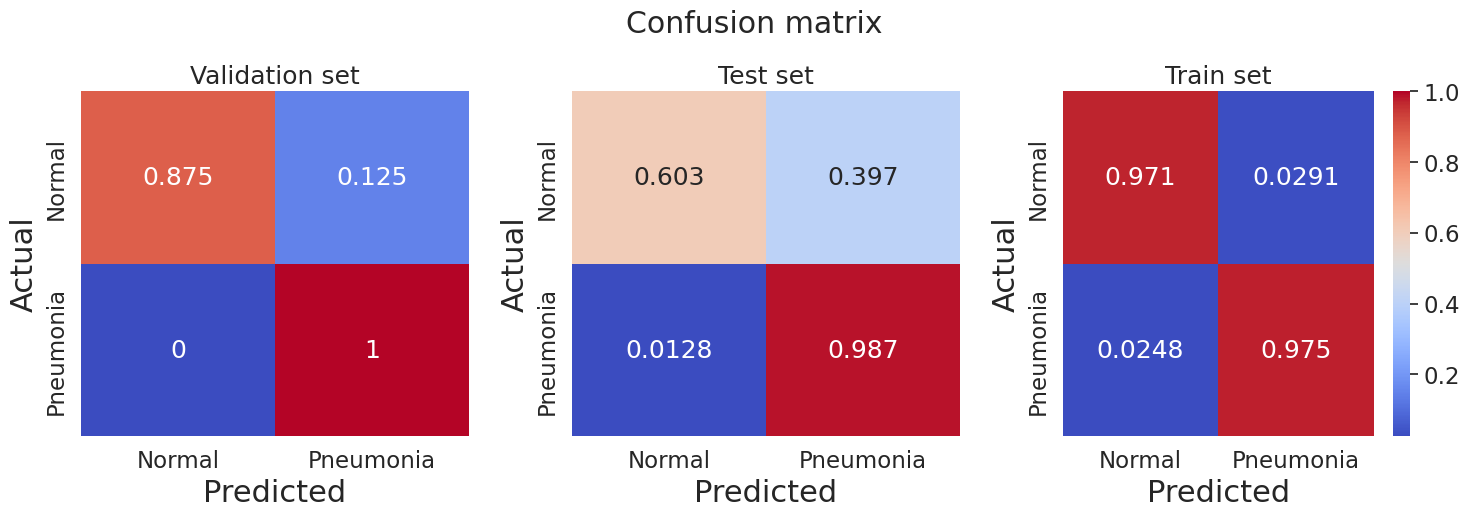

In [118]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


def plot_confmatrix(df, ax, title, cbar=False):
    normal_normal = evaluator.evaluate(df, {evaluator.metricName: "truePositiveRateByLabel", evaluator.metricLabel: 1.0}) 
    pneumo_pneumo = evaluator.evaluate(df, {evaluator.metricName: "truePositiveRateByLabel", evaluator.metricLabel: 2.0}) 

    normal_pneumo = evaluator.evaluate(df, {evaluator.metricName: "falsePositiveRateByLabel", evaluator.metricLabel: 1.0}) 
    pneumo_normal = evaluator.evaluate(df, {evaluator.metricName: "falsePositiveRateByLabel", evaluator.metricLabel: 2.0}) 

    conf_matrix = [[normal_normal, pneumo_normal],
                   [normal_pneumo, pneumo_pneumo]]

    xrays = ['Normal', 'Pneumonia']
    conf_matrix_df = pd.DataFrame(conf_matrix,columns=xrays,index=xrays)
    sns.set(font_scale=1.5)

    sns.heatmap(conf_matrix_df,
                cmap='coolwarm',
                annot=True,
                fmt='.3g',
                vmax=1,
                cbar=cbar,
                ax=ax)

    ax.set_title(title)
    ax.set_xlabel('Predicted',fontsize=22)
    ax.set_ylabel('Actual',fontsize=22)

#plt.figure(figsize=(10, 10))

print('Confusion matrix by x-rays set')
print('==============================\n')
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Confusion matrix')
fig.tight_layout()

plot_confmatrix(predictionValDF, axs[0], 'Validation set')
plot_confmatrix(predictionTestDF, axs[1], 'Test set')
plot_confmatrix(predictionTrainDF, axs[2], 'Train set', True)
